# Advanced Lane Finding

### 1- Camera Calebraion and Distortion Correction : 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def calibrate_distort_cam(images, test_image_name='test', corners_w=9, corners_h=6):
    """
    @param: images , array of images paths ['folder//image_name.jpg',..]
    """
    # prepare object points, 
    # 6*8 length arrays, length=3 each , like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((corners_w*corners_h,3), np.float32)
    objp[:,:2] = np.mgrid[0:corners_w, 0:corners_h].T.reshape(-1,2)#create grid of 2 arrays, then reshape to 6*9, then replace values in objp
    """output :
    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     ...
     [ 7.  5.  0.]
     [ 8.  5.  0.]]
    """
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)#read image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#convert to gray
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('chess board', fontsize=20)
    # Draw and display the corners of an image
    cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    ax2.imshow(img)
    ax2.set_title('chess board inner corners', fontsize=20)
    #calibration 
    test_img = cv2.imread('camera_cal/'+test_image_name+'.jpg')
    img_size = (test_img.shape[1], test_img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
    # Test undistortion on an image
    undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    #display
    ax3.imshow(test_img)
    ax3.set_title('Original Image', fontsize=20)
    ax4.imshow(undistorted_img)
    ax4.set_title('Undistorted Image', fontsize=20)
    
    return mtx, dist


In [3]:
import pickle
def save_calibration(mtx, dist, folder='camera_cal'):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( folder+"/wide_dist_pickle.p", "wb" ) )

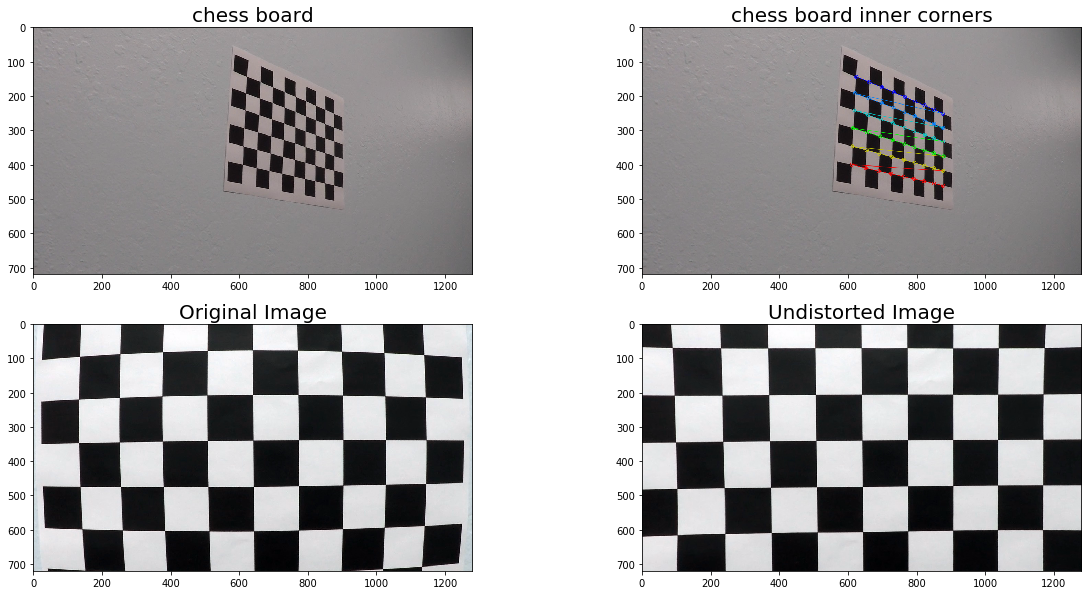

In [4]:
# Make a list of calibration images urls
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_distort_cam(images)
    
save_calibration(mtx, dist)



### 2-  Color/Gradient Threshold

In [5]:
import matplotlib.image as mpimg
def abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, s_thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'y':
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    else:
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    
    return sobel_binary

In [6]:
def s_hls_thresh(s_channel, s_thresh=(0, 255)):
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Return the result
    return s_binary

In [7]:
def pipeline_gradiant_thresh(undistimg, s_thresh=(170, 255), sobel_thresh=(30, 70), do_plot=False):
    img = np.copy(undistimg)
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img_yuv[:,:,2] = cv2.equalizeHist(img_yuv[:,:,2])
    # convert the YUV image back to RGB format
    #img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Choose a Sobel kernel size
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img_contrast, cv2.COLOR_RGB2HLS).astype(np.float)
    
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # Apply each of the thresholding functions
    sobel_x_binary = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=1, s_thresh=sobel_thresh)
    s_binary = s_hls_thresh(s_channel, s_thresh=s_thresh)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    
    if do_plot:
        f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 13))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(img)
        ax1.set_title('Original image', fontsize=20)

        ax4.imshow(img)
        ax4.set_title('Original image', fontsize=20)

        ax2.imshow(l_channel)
        ax2.set_title('L channel of image HLS', fontsize=20)

        ax5.imshow(s_channel)
        ax5.set_title('S channel of image HLS', fontsize=20)

        ax3.imshow(sobel_x_binary, cmap='gray')
        ax3.set_title('Binary Sobel X', fontsize=20)

        ax6.imshow(s_binary, cmap='gray')
        ax6.set_title('S Channel Binary', fontsize=20)
    return color_binary, sobel_x_binary , s_binary 

In [8]:
def compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=False):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(schannel_binary == 1) | (sobelx_binary == 1)] = 1
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Combined Results :", fontsize=30)
        ax1.imshow(result)
        ax1.set_title('Pipeline Result', fontsize=20)

        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined Binary', fontsize=20)
    return combined_binary

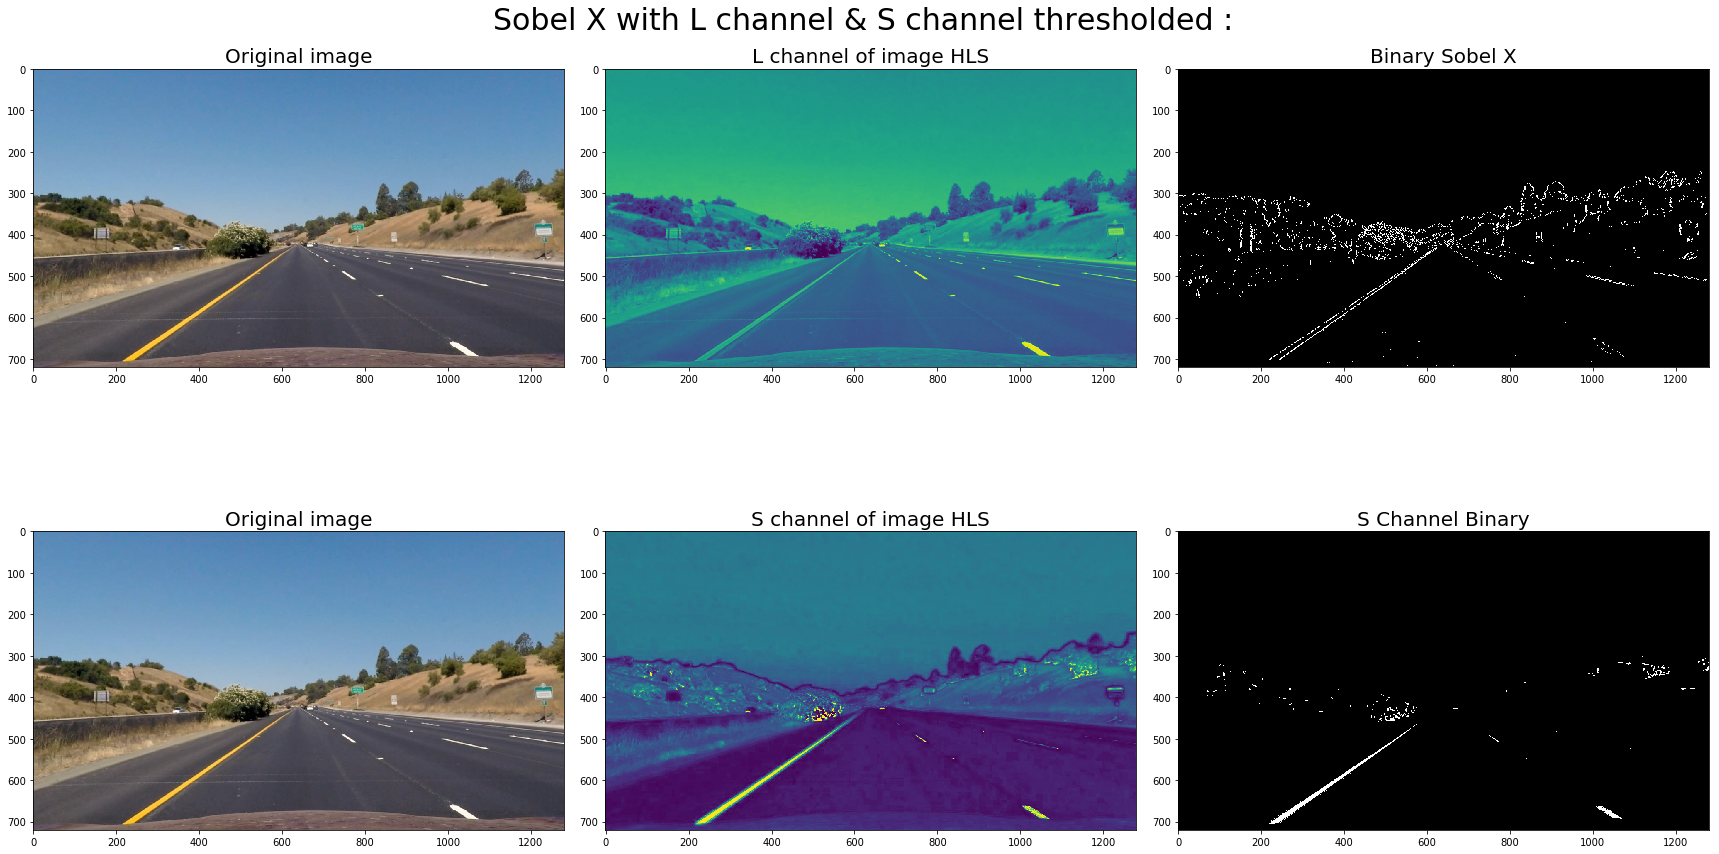

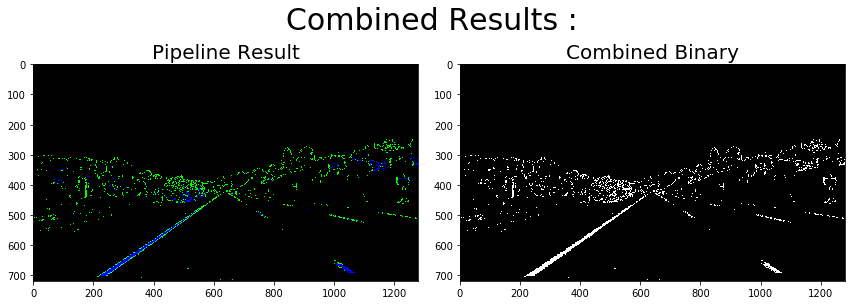

In [9]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist_img = cv2.undistort(image, mtx, dist, None, mtx)

result, sobelx_binary, schannel_binary = pipeline_gradiant_thresh(undist_img, do_plot=True)

#TODO: add to pipeline functions 
combined_binary = compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=True)

### 3- Perspective transform

##### 3a - adjust prespective on an image that has a straight lane line 

warped_img (720, 1280)
warped_img uint8


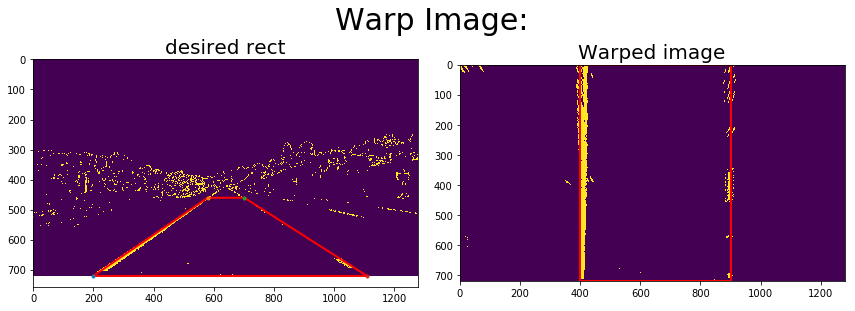

In [10]:
import matplotlib.patches as patches

def warp(image, do_plot=False):
   
    img_size = (image.shape[1], image.shape[0])
    horizon = int(img_size[1]*.64)#0.62
    
    src_vertices = np.float32(
        [[200,     img_size[1]],#LB
        [580, horizon],         #LT
        [702, horizon], 
        [1110,     img_size[1]]])
        #[[200,     img_size[1]],#LB
        #[599, horizon],         #LT
        #[678, horizon], 
        #[1110,     img_size[1]]])
    
    dst_vertices = np.float32(
        [[400, 720],
        [400, 0], 
        [900, 0], 
        [900, 720]])
        
    #warp matrix
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    #unwarp matrix
    Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    #do warp 
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Warp Image:", fontsize=30)
        ax1.imshow(image)
        ax1.plot(src_vertices[0][0],src_vertices[0][1],'.')
        ax1.plot(src_vertices[1][0],src_vertices[1][1],'.')
        ax1.plot(src_vertices[2][0],src_vertices[2][1],'.')
        ax1.plot(src_vertices[3][0],src_vertices[3][1],'.')
        ax1.add_patch(patches.Polygon(src_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        ax1.set_title('desired rect', fontsize=20)
        ax2.imshow(warped)
        ax2.add_patch(patches.Polygon(dst_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        #ax2.add_patch(patches.Rectangle((290,0),750,720,linewidth=2,edgecolor='r',facecolor='none'))
        ax2.set_title('Warped image', fontsize=20)

    return warped, Minv

warped_img , warped_img_Minv= warp(combined_binary , do_plot=True)
print("warped_img",warped_img.shape)
print("warped_img",warped_img.dtype)

###### 3b - test same process on curved line

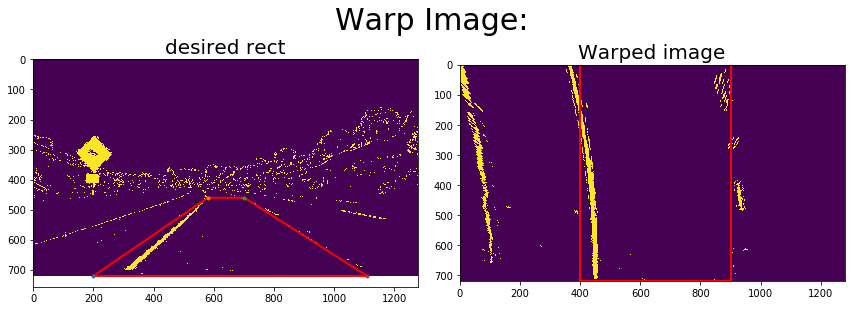

In [11]:
curved_image2 = cv2.imread('test_images/test2.jpg')
curved_image2 = cv2.cvtColor(curved_image2, cv2.COLOR_BGR2RGB)
undist_curved_image2 = cv2.undistort(curved_image2, mtx, dist, None, mtx)

curved_result2, curved_sobelx_binary2, curved_schannel_binary2 = pipeline_gradiant_thresh(undist_curved_image2, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary2 = compine_sobel_schannel(curved_sobelx_binary2, curved_schannel_binary2,curved_result2,do_plot=False)

curved_warped_img2, curved_warped_img2_Minv = warp(curved_combined_binary2 , do_plot=True)

another test, the other way

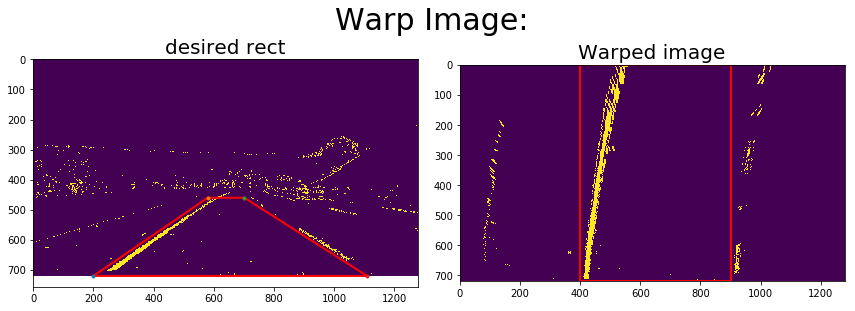

In [12]:
curved_image3 = cv2.imread('test_images/test3.jpg')
curved_image3 = cv2.cvtColor(curved_image3, cv2.COLOR_BGR2RGB)
undist_curved_image3 = cv2.undistort(curved_image3, mtx, dist, None, mtx)
curved_result3, curved_sobelx_binary3, curved_schannel_binary3 = pipeline_gradiant_thresh(undist_curved_image3, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary3 = compine_sobel_schannel(curved_sobelx_binary3, curved_schannel_binary3,curved_result3,do_plot=False)

curved_warped_img3, curved_warped_img3_Minv = warp(curved_combined_binary3 , do_plot=True)

bright lighting conditions

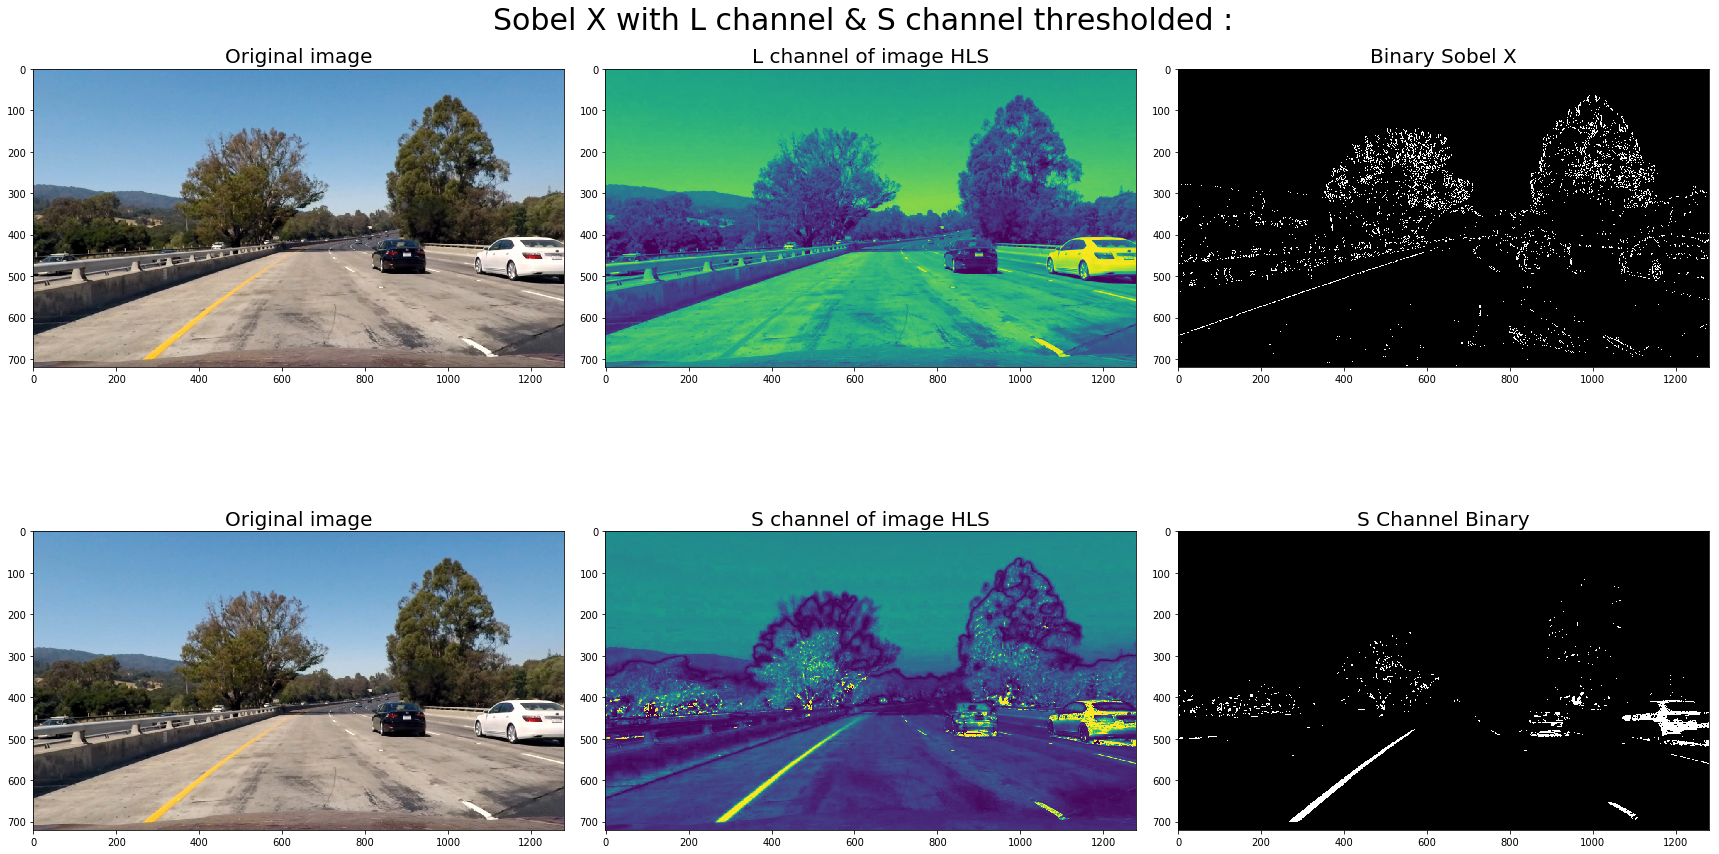

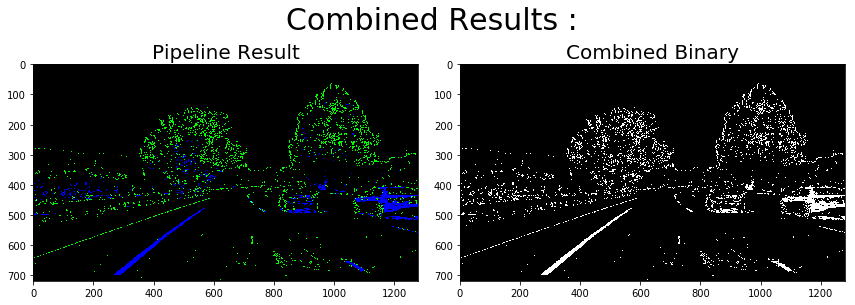

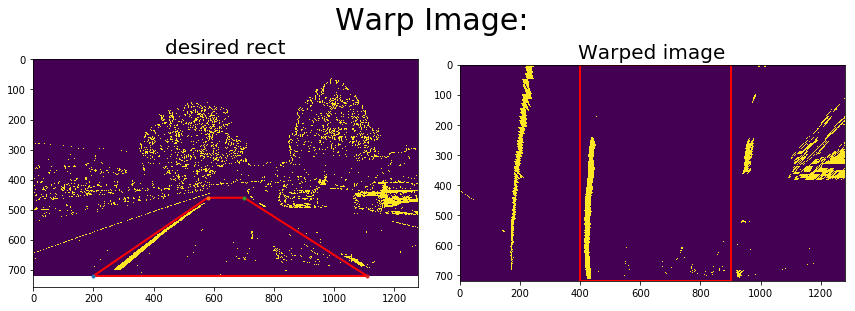

In [13]:
curved_image1 = cv2.imread('test_images/test1.jpg')
curved_image1 = cv2.cvtColor(curved_image1, cv2.COLOR_BGR2RGB)
undist_curved_image1 = cv2.undistort(curved_image1, mtx, dist, None, mtx)
curved_result1, curved_sobelx_binary1, curved_schannel_binary1 = pipeline_gradiant_thresh(undist_curved_image1, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary1 = compine_sobel_schannel(curved_sobelx_binary1, curved_schannel_binary1, curved_result1, do_plot=True)

curved_warped_img1, curved_warped_img1_Minv = warp(curved_combined_binary1 , do_plot=True)

another crazy lighting conditions

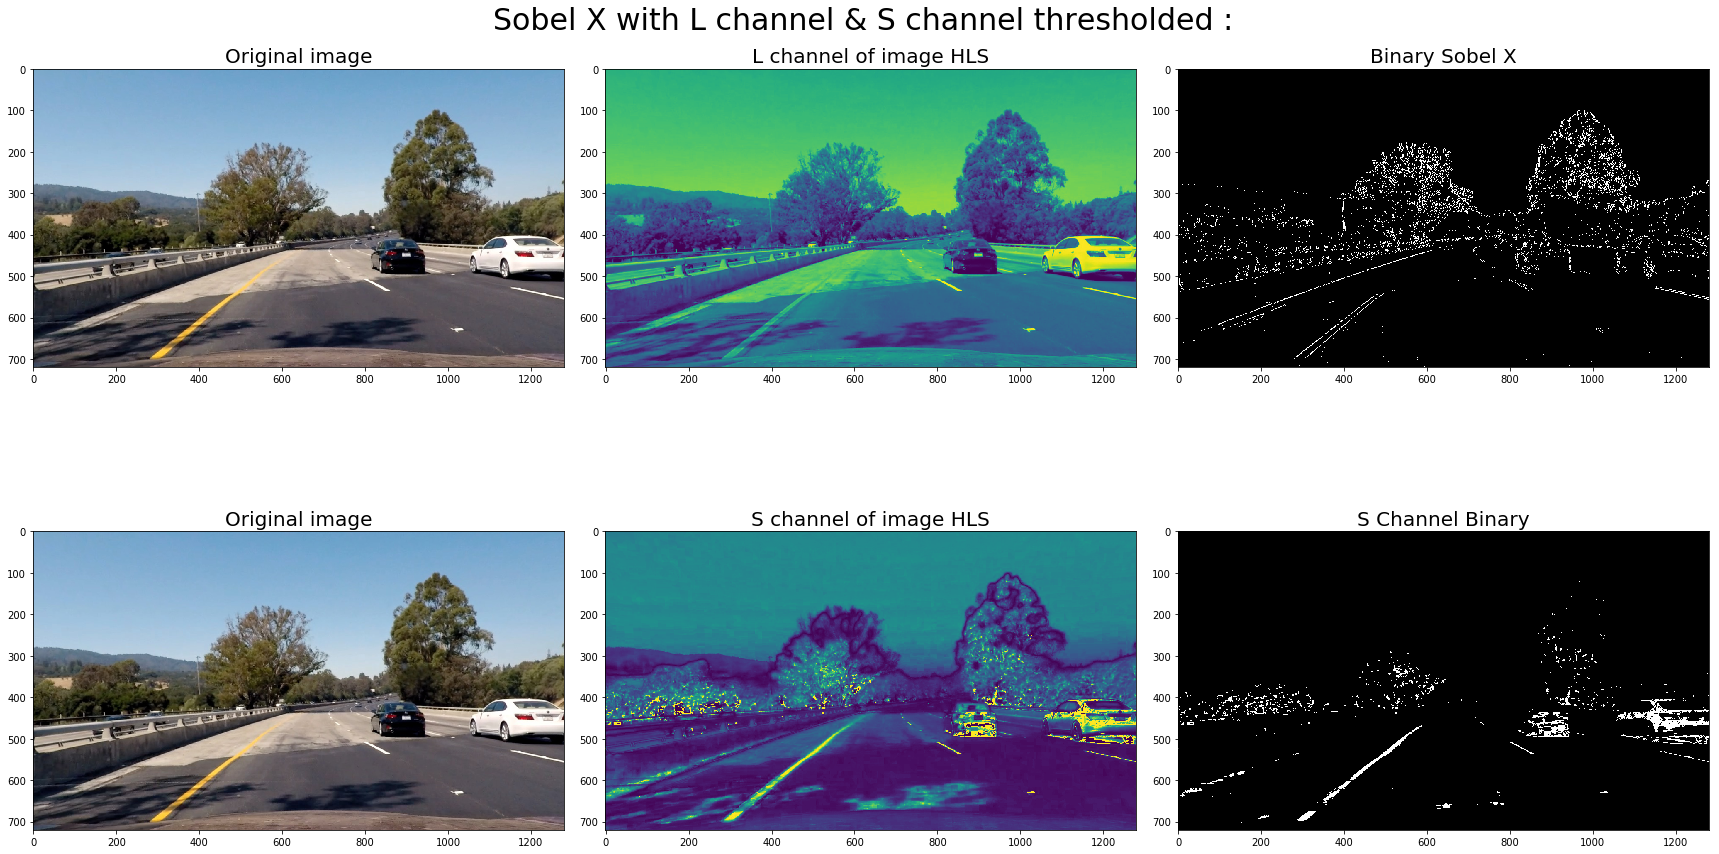

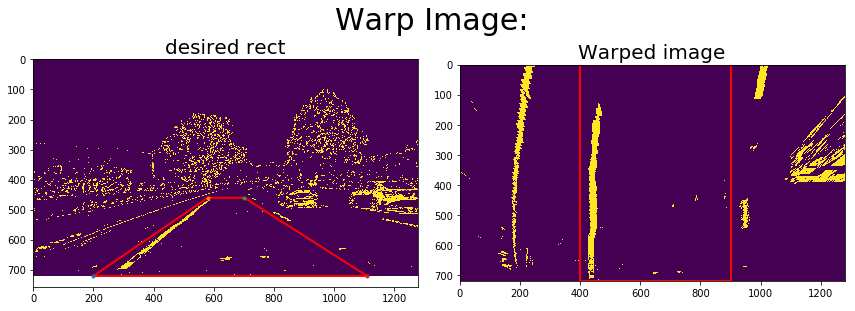

In [14]:
curved_image4 = cv2.imread('test_images/test4.jpg')
curved_image4 = cv2.cvtColor(curved_image4, cv2.COLOR_BGR2RGB)
undist_curved_image4 = cv2.undistort(curved_image4, mtx, dist, None, mtx)
curved_result4, curved_sobelx_binary4, curved_schannel_binary4 = pipeline_gradiant_thresh(undist_curved_image4, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary4 = compine_sobel_schannel(curved_sobelx_binary4, curved_schannel_binary4, curved_result4, do_plot=False)

curved_warped_img4, curved_warped_img4_Minv = warp(curved_combined_binary4 , do_plot=True)

### 4- find the lane in the bird-eye image

dedecting lane for :
- warped_img : which is straight line
- curved_warped_img2 : clear curved to left
- curved_warped_img3 : clear curved to right
- curved_warped_img1 : confusing curved to right


C:\D\Anas\mozakra\ML\CarND013\term1\CarND-Project4_Advanced-Lane-Lines\lanesearch.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)


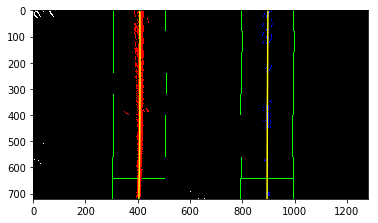

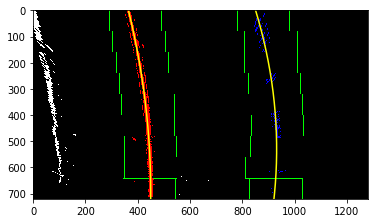

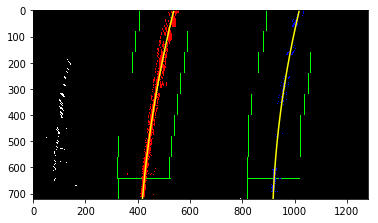

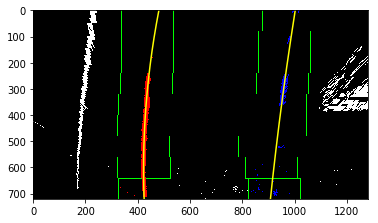

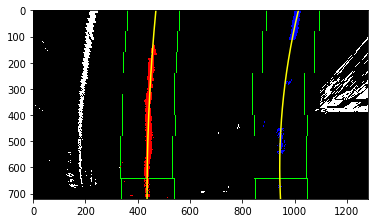

In [15]:
from lanesearch import slidingwindowsearch
warped_img_left_fit, warped_img_right_fit, ploty = slidingwindowsearch(warped_img,do_plot=True)
curved_warped_img2_left_fit, curved_warped_img2_right_fit, ploty2 = slidingwindowsearch(curved_warped_img2, do_plot=True)
curved_warped_img3_left_fit, curved_warped_img3_right_fit, ploty3 = slidingwindowsearch(curved_warped_img3, do_plot=True)
curved_warped_img1_left_fit, curved_warped_img1_right_fit, ploty1 = slidingwindowsearch(curved_warped_img1, do_plot=True)
curved_warped_img4_left_fit, curved_warped_img4_right_fit, ploty4 = slidingwindowsearch(curved_warped_img4, do_plot=True)

In [16]:
from curvatureandcenter import find_curvature, position_to_center, translate_position_to_center

warped_img_left_curv, warped_img_right_curv = find_curvature(warped_img_left_fit, warped_img_right_fit, ploty)
curved_warped_img2_left_curv, curved_warped_img2_right_curv = find_curvature(curved_warped_img2_left_fit, curved_warped_img2_right_fit, ploty2)
curved_warped_img3_left_curv, curved_warped_img3_right_curv = find_curvature(curved_warped_img3_left_fit, curved_warped_img3_right_fit, ploty3)
curved_warped_img1_left_curv, curved_warped_img1_right_curv = find_curvature(curved_warped_img1_left_fit, curved_warped_img1_right_fit, ploty1)
curved_warped_img4_left_curv, curved_warped_img4_right_curv = find_curvature(curved_warped_img4_left_fit, curved_warped_img4_right_fit, ploty4)


In [17]:
warped_img_pos = position_to_center(warped_img_left_fit[-1], warped_img_right_fit[-1], 1280)
curved_warped_img2_pos = position_to_center(curved_warped_img2_left_fit[-1], curved_warped_img2_right_fit[-1], 1280)
curved_warped_img3_pos = position_to_center(curved_warped_img3_left_fit[-1], curved_warped_img3_right_fit[-1], 1280)
curved_warped_img1_pos = position_to_center(curved_warped_img1_left_fit[-1], curved_warped_img1_right_fit[-1], 1280)
curved_warped_img4_pos = position_to_center(curved_warped_img4_left_fit[-1], curved_warped_img4_right_fit[-1], 1280)

position_to_center : -0.0505352873561
position_to_center : -0.239853458316
position_to_center : -0.148004807257
position_to_center : -0.137802026091
position_to_center : -0.268718606255


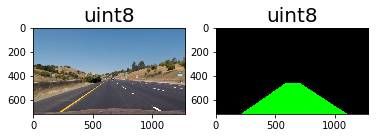

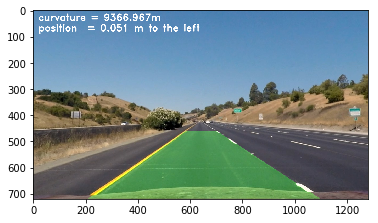

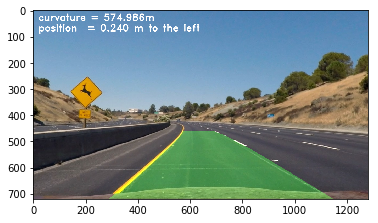

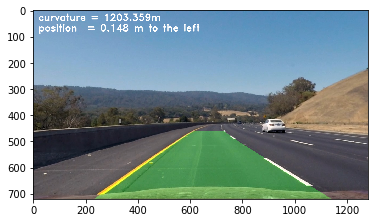

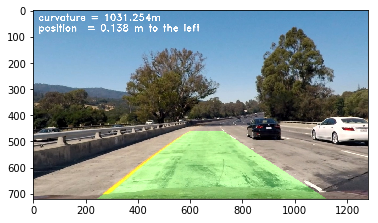

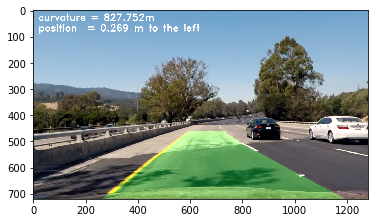

In [33]:
# Create an image to draw the lines on
#warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
def drawlane_unwarpimage(undist_img, result, left_fit, right_fit, ploty, unwarp_Minv, do_plot=False):
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(result, np.int_([pts]), (0,255, 0))
    #result or combined_binary !!
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(result, unwarp_Minv, (undist_img.shape[1], undist_img.shape[0])) 
    newwarp = newwarp.astype(np.uint8)#np.array(newwarp).astype('float')
    final_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    # Combine the result with the original image
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(undist_img)
        ax1.set_title(undist_img.dtype, fontsize=20)
        #image_ = np.array(undist_img).astype('float')
        ax2.imshow(newwarp_)
        ax2.set_title(newwarp.dtype, fontsize=20)
        plt.show()
    return final_result

def write_curv_pos(image_with_lane, left_curv, right_curv, midpoint_pos, do_plot=False):
    less_curve_val = min(left_curv, right_curv)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    #cv2.putText(img,        text,                         org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) 
    image_with_lane = cv2.putText(image_with_lane,"curvature = "+"{0:.3f}".format(less_curve_val)+"m",(20,40), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    image_with_lane = cv2.putText(image_with_lane,"position  = "+translate_position_to_center(midpoint_pos),(20,80), font, 1.2, (255,255,255), 2, cv2.LINE_AA)                
    #final_result = final_result.astype(np.uint8)
    #final_result = cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR)
    if do_plot:
        plt.imshow(image_with_lane)
        plt.show()
    return image_with_lane

final_result = drawlane_unwarpimage(undist_img, result, warped_img_left_fit, warped_img_right_fit, ploty, warped_img_Minv, do_plot=True)
final_image = write_curv_pos(final_result, warped_img_left_curv, warped_img_right_curv,warped_img_pos, do_plot=True)

final_result2 = drawlane_unwarpimage(undist_curved_image2, curved_result2, curved_warped_img2_left_fit, curved_warped_img2_right_fit, ploty2, curved_warped_img2_Minv)
final_image2 = write_curv_pos(final_result2, curved_warped_img2_left_curv, curved_warped_img2_right_curv,curved_warped_img2_pos, do_plot=True)

final_result3 = drawlane_unwarpimage(undist_curved_image3, curved_result3, curved_warped_img3_left_fit, curved_warped_img3_right_fit, ploty3, curved_warped_img3_Minv)
final_image3 = write_curv_pos(final_result3, curved_warped_img3_left_curv, curved_warped_img3_right_curv,curved_warped_img3_pos, do_plot=True)

final_result1 = drawlane_unwarpimage(undist_curved_image1, curved_result1, curved_warped_img1_left_fit, curved_warped_img1_right_fit, ploty1, curved_warped_img1_Minv)
final_image1 = write_curv_pos(final_result1, curved_warped_img1_left_curv, curved_warped_img1_right_curv,curved_warped_img1_pos, do_plot=True)

final_result4 = drawlane_unwarpimage(undist_curved_image4, curved_result4, curved_warped_img4_left_fit, curved_warped_img4_right_fit, ploty4, curved_warped_img4_Minv)
final_image4 = write_curv_pos(final_result4, curved_warped_img4_left_curv, curved_warped_img4_right_curv,curved_warped_img4_pos, do_plot=True)


## now it is time to put all this in a pine line ,
##### takes an image as input, and produce same image with lane dedected

In [49]:
#from lanesearch import slidingwindowsearch
#from curvatureandcenter import find_curvature, position_to_center, translate_position_to_center
def find_lane_main_pipeline(BGR_image, do_plot = False):
    #convert BGR image to RGB
    RGB_image = BGR_image#cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
    #undistort image using image calibraion results
    undist_image = cv2.undistort(RGB_image, mtx, dist, None, mtx)
    #create Color/gradient threshold using sobelX and s_channel of HLS
    two_colors_binary, sobelx_binary, s_channel_binary = pipeline_gradiant_thresh(undist_image, do_plot=do_plot)
    #combine result of sobelX and s_channel of HLS to one binary image
    combined_binary = compine_sobel_schannel(sobelx_binary, s_channel_binary, two_colors_binary, do_plot=do_plot)
    #Perspective transform to bird-eye view, save also unwrapping matrix to un
    warped_image, unwarpping_matrix = warp(combined_binary, do_plot=do_plot)
    #Detect lane pixels and fit to find the lane boundary.
    leftlane_fit, rightlane_fit, ploty = slidingwindowsearch(warped_image, do_plot=do_plot)
    #find left and right curvature
    leftlane_curv, rightlane_curv = find_curvature(leftlane_fit, rightlane_fit, ploty)
    #find lane mid-point with respect to image center
    lanecenter_pos = position_to_center(leftlane_fit[-1], rightlane_fit[-1], BGR_image.shape[1])
    #combine lane-rect-drawn-unwrapped-image with undistorted-image 
    unwarpped_image = drawlane_unwarpimage(undist_image, two_colors_binary, leftlane_fit, rightlane_fit, ploty, unwarpping_matrix, do_plot=do_plot)
    #write curve and pos data on image
    result_image = write_curv_pos(unwarpped_image, leftlane_curv, rightlane_curv, lanecenter_pos, do_plot=do_plot)
    
    return result_image

#### test pipelines with new image :

C:\D\Anas\mozakra\ML\CarND013\term1\CarND-Project4_Advanced-Lane-Lines\lanesearch.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)


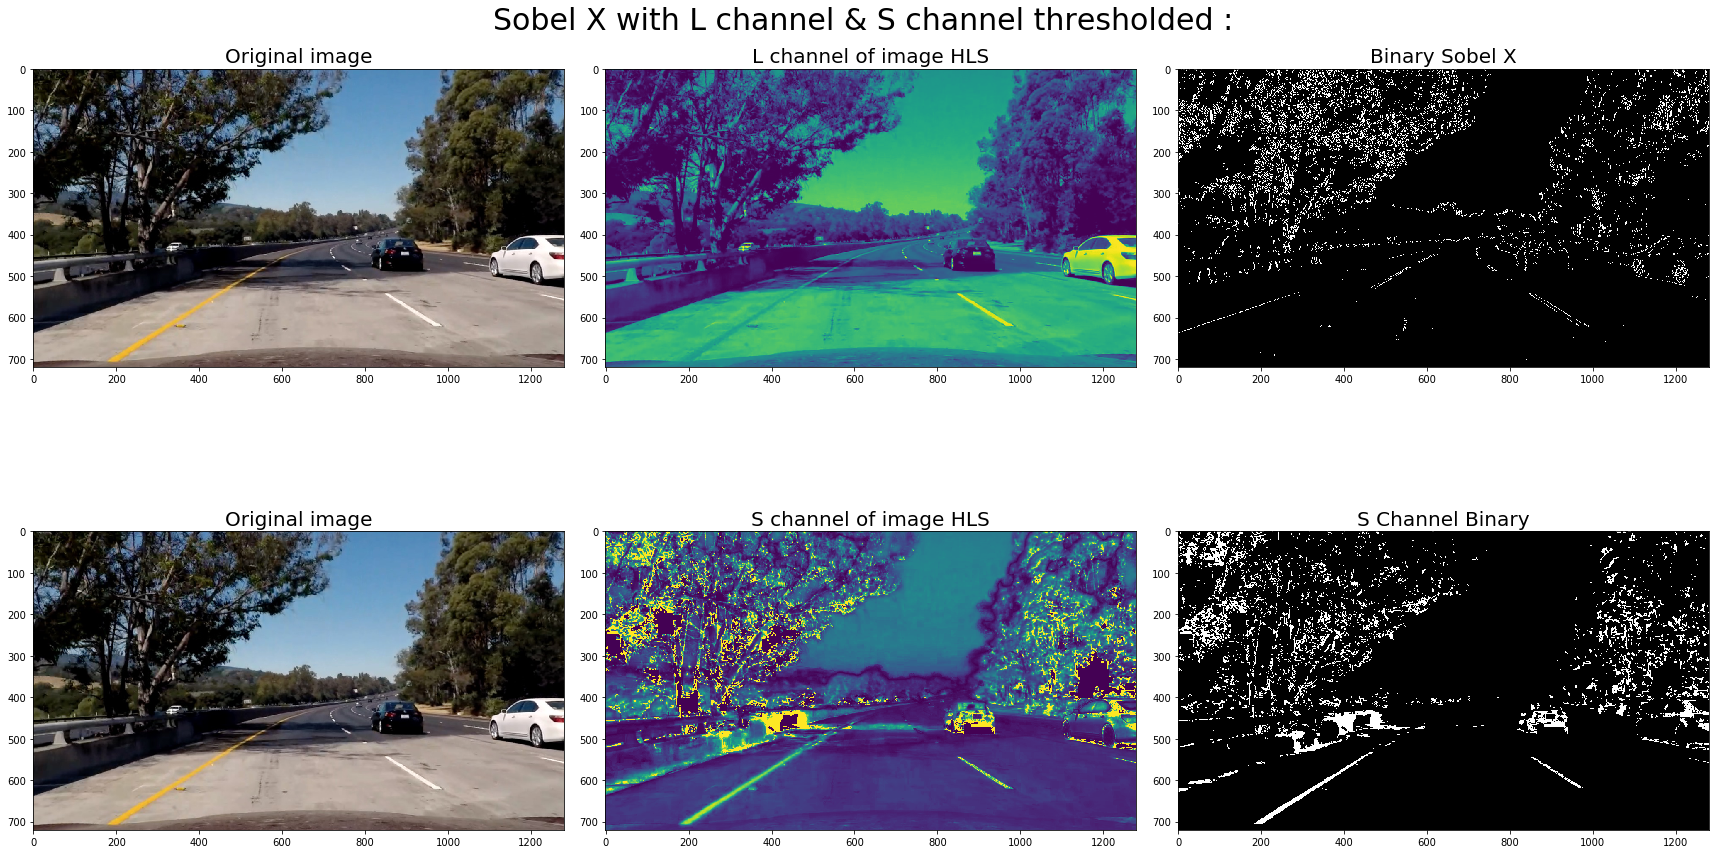

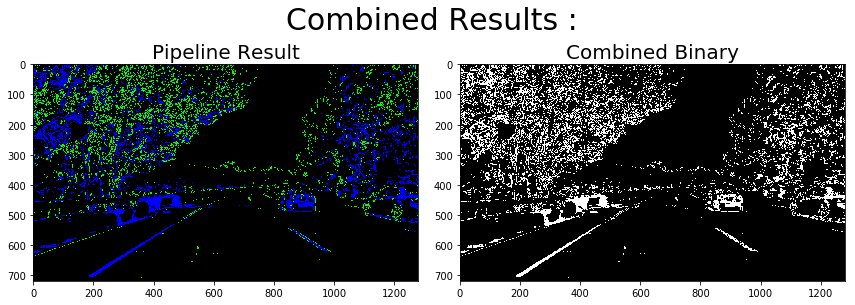

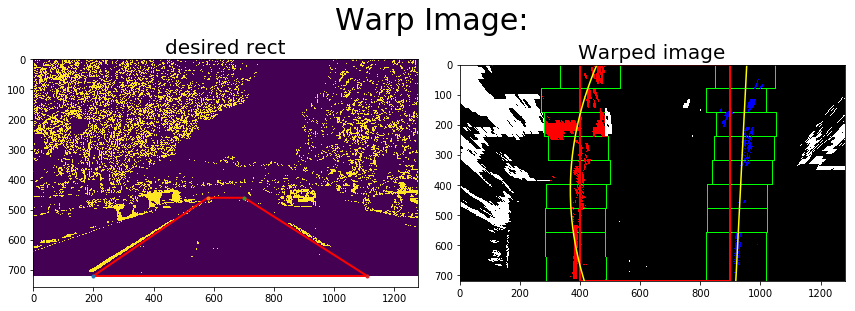

position_to_center : -0.13904959906


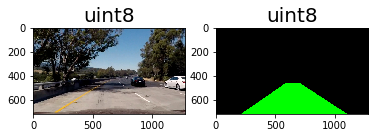

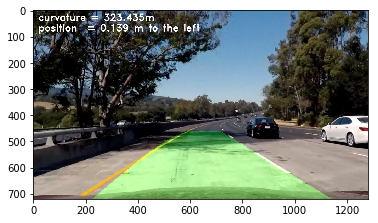

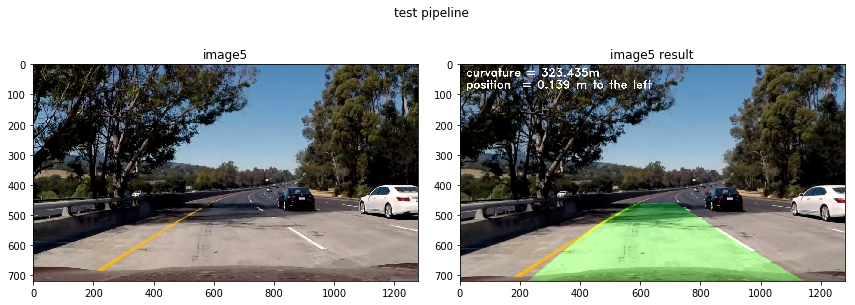

In [44]:
curved_image5 = cv2.imread('test_images/test5.jpg')
curved_image5_reult = find_lane_main_pipeline(curved_image5, True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
plt.suptitle("test pipeline")
ax1.imshow(cv2.cvtColor(curved_image5,cv2.COLOR_BGR2RGB))
ax1.set_title("image5")
ax2.imshow(curved_image5_reult)
ax2.set_title("image5 result")
plt.show()

## Get ready with project_video

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_lane_main_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

position_to_center : -0.289831160554
[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

position_to_center : -0.289831160554


  0%|                                         | 1/1261 [00:00<04:55,  4.27it/s]

position_to_center : -0.30170867364


  0%|                                         | 2/1261 [00:00<04:49,  4.35it/s]

position_to_center : -0.299468091551


  0%|                                         | 3/1261 [00:00<04:44,  4.42it/s]

position_to_center : -0.303912757935


  0%|▏                                        | 4/1261 [00:00<04:41,  4.46it/s]

position_to_center : -0.309502023506


  0%|▏                                        | 5/1261 [00:01<04:39,  4.49it/s]

position_to_center : -0.31472425379


  0%|▏                                        | 6/1261 [00:01<04:43,  4.42it/s]

position_to_center : -0.315960512478


  1%|▏                                        | 7/1261 [00:01<04:40,  4.47it/s]

position_to_center : -0.332952755017


  1%|▎                                        | 8/1261 [00:01<04:44,  4.40it/s]

position_to_center : -0.342555775293


  1%|▎                                        | 9/1261 [00:02<04:41,  4.45it/s]

position_to_center : -0.338565116229


  1%|▎                                       | 10/1261 [00:02<04:44,  4.40it/s]

position_to_center : -0.335355788185


  1%|▎                                       | 11/1261 [00:02<04:41,  4.45it/s]

position_to_center : -0.324585477869


  1%|▍                                       | 12/1261 [00:02<04:44,  4.39it/s]

position_to_center : -0.325648837942


  1%|▍                                       | 13/1261 [00:02<04:40,  4.44it/s]

position_to_center : -0.337773310468


  1%|▍                                       | 14/1261 [00:03<04:44,  4.39it/s]

position_to_center : -0.317472884327


  1%|▍                                       | 15/1261 [00:03<04:40,  4.44it/s]

position_to_center : -0.316617039982


  1%|▌                                       | 16/1261 [00:03<04:37,  4.48it/s]

position_to_center : -0.310804766256


  1%|▌                                       | 17/1261 [00:03<04:36,  4.51it/s]

position_to_center : -0.308764983903


  1%|▌                                       | 18/1261 [00:04<04:34,  4.53it/s]

position_to_center : -0.309152481906


  2%|▌                                       | 19/1261 [00:04<04:39,  4.44it/s]

position_to_center : -0.305668225113


  2%|▋                                       | 20/1261 [00:04<04:42,  4.39it/s]

position_to_center : -0.300928343412


  2%|▋                                       | 21/1261 [00:04<04:39,  4.44it/s]

position_to_center : -0.315802045742


  2%|▋                                       | 22/1261 [00:04<04:42,  4.39it/s]

position_to_center : -0.290730382588


  2%|▋                                       | 23/1261 [00:05<04:38,  4.44it/s]

position_to_center : -0.256088414837


  2%|▊                                       | 24/1261 [00:05<04:36,  4.48it/s]

position_to_center : -0.257569346203


  2%|▊                                       | 25/1261 [00:05<04:34,  4.51it/s]

position_to_center : -0.264862017114


  2%|▊                                       | 26/1261 [00:05<04:32,  4.53it/s]

position_to_center : -0.273346126492


  2%|▊                                       | 27/1261 [00:06<04:43,  4.35it/s]

position_to_center : -0.261295523951


  2%|▉                                       | 28/1261 [00:06<04:44,  4.33it/s]

position_to_center : -0.27023230224


  2%|▉                                       | 29/1261 [00:06<04:40,  4.40it/s]

position_to_center : -0.25860351045


  2%|▉                                       | 30/1261 [00:06<04:42,  4.36it/s]

position_to_center : -0.261548528512


  2%|▉                                       | 31/1261 [00:06<04:32,  4.51it/s]

position_to_center : -0.258172868275


  3%|█                                       | 32/1261 [00:07<04:25,  4.63it/s]

position_to_center : -0.259968135394


  3%|█                                       | 33/1261 [00:07<04:26,  4.61it/s]

position_to_center : -0.282926623729


  3%|█                                       | 34/1261 [00:07<04:26,  4.60it/s]

position_to_center : -0.261954858779


  3%|█                                       | 35/1261 [00:07<04:27,  4.59it/s]

position_to_center : -0.248626920722


  3%|█▏                                      | 36/1261 [00:08<04:15,  4.79it/s]

position_to_center : -0.260711413807


  3%|█▏                                      | 37/1261 [00:08<04:19,  4.72it/s]

position_to_center : -0.264297887456


  3%|█▏                                      | 38/1261 [00:08<04:21,  4.68it/s]

position_to_center : -0.249267109045


  3%|█▏                                      | 39/1261 [00:08<04:17,  4.75it/s]

position_to_center : -0.248427588244


  3%|█▎                                      | 40/1261 [00:08<04:11,  4.86it/s]

position_to_center : -0.258476547517


  3%|█▎                                      | 41/1261 [00:09<04:15,  4.77it/s]

position_to_center : -0.270629836058


  3%|█▎                                      | 42/1261 [00:09<04:13,  4.81it/s]

position_to_center : -0.27496540694


  3%|█▎                                      | 43/1261 [00:09<04:17,  4.74it/s]

position_to_center : -0.27597594715


  3%|█▍                                      | 44/1261 [00:09<04:13,  4.79it/s]

position_to_center : -0.284243249111


  4%|█▍                                      | 45/1261 [00:09<04:11,  4.83it/s]

position_to_center : -0.282558139232


  4%|█▍                                      | 46/1261 [00:10<04:15,  4.75it/s]

position_to_center : -0.300817209644


  4%|█▍                                      | 47/1261 [00:10<04:12,  4.80it/s]

position_to_center : -0.31946071975


  4%|█▌                                      | 48/1261 [00:10<04:16,  4.73it/s]

position_to_center : -0.314722787983


  4%|█▌                                      | 49/1261 [00:10<04:18,  4.68it/s]

position_to_center : -0.284396300004


  4%|█▌                                      | 50/1261 [00:10<04:14,  4.75it/s]

position_to_center : -0.29616539757


  4%|█▌                                      | 51/1261 [00:11<04:17,  4.70it/s]

position_to_center : -0.291441510437


  4%|█▋                                      | 52/1261 [00:11<04:13,  4.76it/s]

position_to_center : -0.285089905418


  4%|█▋                                      | 53/1261 [00:11<04:16,  4.70it/s]

position_to_center : -0.282940433638


  4%|█▋                                      | 54/1261 [00:11<04:13,  4.77it/s]

position_to_center : -0.28925508962


  4%|█▋                                      | 55/1261 [00:12<04:16,  4.71it/s]

position_to_center : -0.289196559725


  4%|█▊                                      | 56/1261 [00:12<04:18,  4.66it/s]

position_to_center : -0.290064705289


  5%|█▊                                      | 57/1261 [00:12<04:19,  4.64it/s]

position_to_center : -0.284918361171


  5%|█▊                                      | 58/1261 [00:12<04:20,  4.62it/s]

position_to_center : -0.277916326417


  5%|█▊                                      | 59/1261 [00:12<04:15,  4.70it/s]

position_to_center : -0.296080377953


  5%|█▉                                      | 60/1261 [00:13<04:11,  4.77it/s]

position_to_center : -0.268864393231


  5%|█▉                                      | 61/1261 [00:13<04:20,  4.61it/s]

position_to_center : -0.255741215402


  5%|█▉                                      | 62/1261 [00:13<04:20,  4.60it/s]

position_to_center : -0.249610177399


  5%|█▉                                      | 63/1261 [00:13<04:26,  4.49it/s]

position_to_center : -0.229270626705


  5%|██                                      | 64/1261 [00:13<04:19,  4.61it/s]

position_to_center : -0.23082003245


  5%|██                                      | 65/1261 [00:14<04:19,  4.60it/s]

position_to_center : -0.233989108392


  5%|██                                      | 66/1261 [00:14<04:20,  4.59it/s]

position_to_center : -0.229786934066


  5%|██▏                                     | 67/1261 [00:14<04:20,  4.59it/s]

position_to_center : -0.228635829972


  5%|██▏                                     | 68/1261 [00:14<04:20,  4.58it/s]

position_to_center : -0.224601937141


  5%|██▏                                     | 69/1261 [00:15<04:20,  4.58it/s]

position_to_center : -0.22180942143


  6%|██▏                                     | 70/1261 [00:15<04:20,  4.58it/s]

position_to_center : -0.238327888395


  6%|██▎                                     | 71/1261 [00:15<04:25,  4.48it/s]

position_to_center : -0.191557066719


  6%|██▎                                     | 72/1261 [00:15<04:23,  4.51it/s]

position_to_center : -0.214286817066


  6%|██▎                                     | 73/1261 [00:15<04:28,  4.43it/s]

position_to_center : -0.201659407804


  6%|██▎                                     | 74/1261 [00:16<04:19,  4.57it/s]

position_to_center : -0.203387943934


  6%|██▍                                     | 75/1261 [00:16<04:19,  4.57it/s]

position_to_center : -0.191705285498


  6%|██▍                                     | 76/1261 [00:16<04:13,  4.67it/s]

position_to_center : -0.198165284591


  6%|██▍                                     | 77/1261 [00:16<04:20,  4.54it/s]

position_to_center : -0.195795169224


  6%|██▍                                     | 78/1261 [00:17<04:19,  4.55it/s]

position_to_center : -0.192958358301


  6%|██▌                                     | 79/1261 [00:17<04:19,  4.56it/s]

position_to_center : -0.191167604377


  6%|██▌                                     | 80/1261 [00:17<04:24,  4.47it/s]

position_to_center : -0.188339553151


  6%|██▌                                     | 81/1261 [00:17<04:27,  4.40it/s]

position_to_center : -0.178903216049


  7%|██▌                                     | 82/1261 [00:17<04:24,  4.45it/s]

position_to_center : -0.17645814331


  7%|██▋                                     | 83/1261 [00:18<04:22,  4.49it/s]

position_to_center : -0.195733247319


  7%|██▋                                     | 84/1261 [00:18<04:20,  4.51it/s]

position_to_center : -0.186817884025


  7%|██▋                                     | 85/1261 [00:18<04:25,  4.44it/s]

position_to_center : -0.175669882419


  7%|██▋                                     | 86/1261 [00:18<04:22,  4.48it/s]

position_to_center : -0.144688757318


  7%|██▊                                     | 87/1261 [00:19<04:20,  4.50it/s]

position_to_center : -0.1744812885


  7%|██▊                                     | 88/1261 [00:19<04:19,  4.52it/s]

position_to_center : -0.15527892461


  7%|██▊                                     | 89/1261 [00:19<04:23,  4.44it/s]

position_to_center : -0.151593055709


  7%|██▊                                     | 90/1261 [00:19<04:21,  4.48it/s]

position_to_center : -0.160544758204


  7%|██▉                                     | 91/1261 [00:19<04:19,  4.51it/s]

position_to_center : -0.161123946362


  7%|██▉                                     | 92/1261 [00:20<04:23,  4.43it/s]

position_to_center : -0.164075865823


  7%|██▉                                     | 93/1261 [00:20<04:21,  4.47it/s]

position_to_center : -0.170762939984


  7%|██▉                                     | 94/1261 [00:20<04:24,  4.41it/s]

position_to_center : -0.166362568392


  8%|███                                     | 95/1261 [00:20<04:16,  4.55it/s]

position_to_center : -0.174781747537


  8%|███                                     | 96/1261 [00:21<04:21,  4.46it/s]

position_to_center : -0.181368634974


  8%|███                                     | 97/1261 [00:21<04:18,  4.49it/s]

position_to_center : -0.181606256745


  8%|███                                     | 98/1261 [00:21<04:17,  4.52it/s]

position_to_center : -0.167042109563


  8%|███▏                                    | 99/1261 [00:21<04:16,  4.53it/s]

position_to_center : -0.165662366661


  8%|███                                    | 100/1261 [00:21<04:15,  4.54it/s]

position_to_center : -0.177927148648


  8%|███                                    | 101/1261 [00:22<04:14,  4.55it/s]

position_to_center : -0.159570280108


  8%|███▏                                   | 102/1261 [00:22<04:14,  4.56it/s]

position_to_center : -0.166588907764


  8%|███▏                                   | 103/1261 [00:22<04:13,  4.56it/s]

position_to_center : -0.174240610045


  8%|███▏                                   | 104/1261 [00:22<04:13,  4.56it/s]

position_to_center : -0.185864803474


  8%|███▏                                   | 105/1261 [00:23<04:07,  4.67it/s]

position_to_center : -0.187530114556


  8%|███▎                                   | 106/1261 [00:23<04:14,  4.54it/s]

position_to_center : -0.195415653631


  8%|███▎                                   | 107/1261 [00:23<04:13,  4.55it/s]

position_to_center : -0.198645522214


  9%|███▎                                   | 108/1261 [00:23<04:18,  4.46it/s]

position_to_center : -0.194374371407


  9%|███▎                                   | 109/1261 [00:23<04:16,  4.49it/s]

position_to_center : -0.206993507611


  9%|███▍                                   | 110/1261 [00:24<04:04,  4.72it/s]

position_to_center : -0.20022629428


  9%|███▍                                   | 111/1261 [00:24<04:11,  4.57it/s]

position_to_center : -0.220843363028


  9%|███▍                                   | 112/1261 [00:24<04:11,  4.57it/s]

position_to_center : -0.203613758858


  9%|███▍                                   | 113/1261 [00:24<04:05,  4.67it/s]

position_to_center : -0.21616953649


  9%|███▌                                   | 114/1261 [00:25<04:07,  4.64it/s]

position_to_center : -0.204336427377


  9%|███▌                                   | 115/1261 [00:25<04:02,  4.72it/s]

position_to_center : -0.206339150369


  9%|███▌                                   | 116/1261 [00:25<04:04,  4.68it/s]

position_to_center : -0.21703839156


  9%|███▌                                   | 117/1261 [00:25<04:06,  4.64it/s]

position_to_center : -0.224885958621


  9%|███▋                                   | 118/1261 [00:25<04:07,  4.62it/s]

position_to_center : -0.229703403692


  9%|███▋                                   | 119/1261 [00:26<04:07,  4.61it/s]

position_to_center : -0.234722053835


 10%|███▋                                   | 120/1261 [00:26<04:08,  4.60it/s]

position_to_center : -0.251961043797


 10%|███▋                                   | 121/1261 [00:26<04:08,  4.59it/s]

position_to_center : -0.254325044124


 10%|███▊                                   | 122/1261 [00:26<04:08,  4.58it/s]

position_to_center : -0.244135923623


 10%|███▊                                   | 123/1261 [00:26<04:03,  4.68it/s]

position_to_center : -0.262179596591


 10%|███▊                                   | 124/1261 [00:27<04:04,  4.65it/s]

position_to_center : -0.263533709788


 10%|███▊                                   | 125/1261 [00:27<04:05,  4.62it/s]

position_to_center : -0.274776550126


 10%|███▉                                   | 126/1261 [00:27<04:00,  4.71it/s]

position_to_center : -0.248953479944


 10%|███▉                                   | 127/1261 [00:27<04:02,  4.67it/s]

position_to_center : -0.256788052954


 10%|███▉                                   | 128/1261 [00:28<04:04,  4.64it/s]

position_to_center : -0.270856917555


 10%|███▉                                   | 129/1261 [00:28<03:59,  4.72it/s]

position_to_center : -0.267170812341


 10%|████                                   | 130/1261 [00:28<04:01,  4.67it/s]

position_to_center : -0.277316336705


 10%|████                                   | 131/1261 [00:28<03:58,  4.75it/s]

position_to_center : -0.280482795724


 10%|████                                   | 132/1261 [00:28<03:55,  4.80it/s]

position_to_center : -0.28303835932


 11%|████                                   | 133/1261 [00:29<03:58,  4.73it/s]

position_to_center : -0.256795473711


 11%|████▏                                  | 134/1261 [00:29<04:00,  4.68it/s]

position_to_center : -0.267511140718


 11%|████▏                                  | 135/1261 [00:29<03:57,  4.75it/s]

position_to_center : -0.298835617756


 11%|████▏                                  | 136/1261 [00:29<03:59,  4.69it/s]

position_to_center : -0.296098778458


 11%|████▏                                  | 137/1261 [00:29<04:06,  4.56it/s]

position_to_center : -0.308731443492


 11%|████▎                                  | 138/1261 [00:30<04:06,  4.56it/s]

position_to_center : -0.299768847823


 11%|████▎                                  | 139/1261 [00:30<04:05,  4.56it/s]

position_to_center : -0.308336826434


 11%|████▎                                  | 140/1261 [00:30<04:05,  4.57it/s]

position_to_center : -0.296759350122


 11%|████▎                                  | 141/1261 [00:30<04:05,  4.57it/s]

position_to_center : -0.290421986079


 11%|████▍                                  | 142/1261 [00:31<04:04,  4.57it/s]

position_to_center : -0.296644385189


 11%|████▍                                  | 143/1261 [00:31<04:09,  4.47it/s]

position_to_center : -0.287568733856


 11%|████▍                                  | 144/1261 [00:31<04:02,  4.60it/s]

position_to_center : -0.28667270673


 11%|████▍                                  | 145/1261 [00:31<04:08,  4.49it/s]

position_to_center : -0.290616864156


 12%|████▌                                  | 146/1261 [00:31<04:06,  4.52it/s]

position_to_center : -0.271828756748


 12%|████▌                                  | 147/1261 [00:32<04:00,  4.63it/s]

position_to_center : -0.299129234625


 12%|████▌                                  | 148/1261 [00:32<04:01,  4.61it/s]

position_to_center : -0.304465488032


 12%|████▌                                  | 149/1261 [00:32<04:06,  4.50it/s]

position_to_center : -0.291645522445


 12%|████▋                                  | 150/1261 [00:32<04:00,  4.62it/s]

position_to_center : -0.274038298697


 12%|████▋                                  | 151/1261 [00:33<04:00,  4.61it/s]

position_to_center : -0.264783616706


 12%|████▋                                  | 152/1261 [00:33<04:01,  4.60it/s]

position_to_center : -0.262435788193


 12%|████▋                                  | 153/1261 [00:33<04:01,  4.59it/s]

position_to_center : -0.265749690562


 12%|████▊                                  | 154/1261 [00:33<04:01,  4.58it/s]

position_to_center : -0.271474858109


 12%|████▊                                  | 155/1261 [00:33<03:56,  4.68it/s]

position_to_center : -0.271606966453


 12%|████▊                                  | 156/1261 [00:34<03:57,  4.65it/s]

position_to_center : -0.266352622176


 12%|████▊                                  | 157/1261 [00:34<03:58,  4.62it/s]

position_to_center : -0.259076542681


 13%|████▉                                  | 158/1261 [00:34<03:59,  4.61it/s]

position_to_center : -0.252519508298


 13%|████▉                                  | 159/1261 [00:34<03:59,  4.60it/s]

position_to_center : -0.271729300737


 13%|████▉                                  | 160/1261 [00:34<03:59,  4.59it/s]

position_to_center : -0.246831978869


 13%|████▉                                  | 161/1261 [00:35<04:05,  4.49it/s]

position_to_center : -0.253042846518


 13%|█████                                  | 162/1261 [00:35<04:03,  4.51it/s]

position_to_center : -0.259023031435


 13%|█████                                  | 163/1261 [00:35<04:07,  4.44it/s]

position_to_center : -0.258528849298


 13%|█████                                  | 164/1261 [00:35<04:05,  4.48it/s]

position_to_center : -0.237735573055


 13%|█████                                  | 165/1261 [00:36<04:03,  4.50it/s]

position_to_center : -0.242918640659


 13%|█████▏                                 | 166/1261 [00:36<03:56,  4.62it/s]

position_to_center : -0.243059301644


 13%|█████▏                                 | 167/1261 [00:36<04:02,  4.51it/s]

position_to_center : -0.244768280958


 13%|█████▏                                 | 168/1261 [00:36<03:56,  4.63it/s]

position_to_center : -0.245130915639


 13%|█████▏                                 | 169/1261 [00:36<03:56,  4.61it/s]

position_to_center : -0.239128589511


 13%|█████▎                                 | 170/1261 [00:37<03:57,  4.60it/s]

position_to_center : -0.223413078048


 14%|█████▎                                 | 171/1261 [00:37<03:57,  4.59it/s]

position_to_center : -0.216152630366


 14%|█████▎                                 | 172/1261 [00:37<03:57,  4.58it/s]

position_to_center : -0.1807587999


 14%|█████▎                                 | 173/1261 [00:37<03:57,  4.58it/s]

position_to_center : -0.193071569857


 14%|█████▍                                 | 174/1261 [00:38<03:57,  4.58it/s]

position_to_center : -0.156477040221


 14%|█████▍                                 | 175/1261 [00:38<03:57,  4.58it/s]

position_to_center : -0.164794201249


 14%|█████▍                                 | 176/1261 [00:38<03:57,  4.57it/s]

position_to_center : -0.174231694582


 14%|█████▍                                 | 177/1261 [00:38<04:02,  4.48it/s]

position_to_center : -0.178013816119


 14%|█████▌                                 | 178/1261 [00:38<04:00,  4.51it/s]

position_to_center : -0.197091186451


 14%|█████▌                                 | 179/1261 [00:39<03:59,  4.52it/s]

position_to_center : -0.204555202808


 14%|█████▌                                 | 180/1261 [00:39<03:58,  4.54it/s]

position_to_center : -0.20777522554


 14%|█████▌                                 | 181/1261 [00:39<03:57,  4.55it/s]

position_to_center : -0.210757501651


 14%|█████▋                                 | 182/1261 [00:39<03:51,  4.65it/s]

position_to_center : -0.211459277373


 15%|█████▋                                 | 183/1261 [00:40<03:52,  4.63it/s]

position_to_center : -0.223482726419


 15%|█████▋                                 | 184/1261 [00:40<03:58,  4.51it/s]

position_to_center : -0.22859090337


 15%|█████▋                                 | 185/1261 [00:40<03:57,  4.53it/s]

position_to_center : -0.18471002863


 15%|█████▊                                 | 186/1261 [00:40<03:56,  4.54it/s]

position_to_center : -0.192360091155


 15%|█████▊                                 | 187/1261 [00:40<03:55,  4.55it/s]

position_to_center : -0.218821848072


 15%|█████▊                                 | 188/1261 [00:41<03:55,  4.56it/s]

position_to_center : -0.217282519667


 15%|█████▊                                 | 189/1261 [00:41<03:55,  4.56it/s]

position_to_center : -0.228065309834


 15%|█████▉                                 | 190/1261 [00:41<03:59,  4.47it/s]

position_to_center : -0.23976588433


 15%|█████▉                                 | 191/1261 [00:41<03:57,  4.50it/s]

position_to_center : -0.245100701246


 15%|█████▉                                 | 192/1261 [00:42<03:56,  4.52it/s]

position_to_center : -0.250849971954


 15%|█████▉                                 | 193/1261 [00:42<03:55,  4.54it/s]

position_to_center : -0.252146280492


 15%|██████                                 | 194/1261 [00:42<03:54,  4.55it/s]

position_to_center : -0.245788702974


 15%|██████                                 | 195/1261 [00:42<03:59,  4.46it/s]

position_to_center : -0.242916036738


 16%|██████                                 | 196/1261 [00:42<03:52,  4.59it/s]

position_to_center : -0.284081031308


 16%|██████                                 | 197/1261 [00:43<03:52,  4.58it/s]

position_to_center : -0.266685794163


 16%|██████                                 | 198/1261 [00:43<03:57,  4.48it/s]

position_to_center : -0.260236998366


 16%|██████▏                                | 199/1261 [00:43<03:55,  4.51it/s]

position_to_center : -0.254941983187


 16%|██████▏                                | 200/1261 [00:43<03:54,  4.53it/s]

position_to_center : -0.240367768682


 16%|██████▏                                | 201/1261 [00:43<03:48,  4.64it/s]

position_to_center : -0.254752315184


 16%|██████▏                                | 202/1261 [00:44<03:54,  4.52it/s]

position_to_center : -0.237017053334


 16%|██████▎                                | 203/1261 [00:44<03:48,  4.63it/s]

position_to_center : -0.229690966072


 16%|██████▎                                | 204/1261 [00:44<03:49,  4.62it/s]

position_to_center : -0.228671258761


 16%|██████▎                                | 205/1261 [00:44<03:49,  4.60it/s]

position_to_center : -0.232861633981


 16%|██████▎                                | 206/1261 [00:45<03:49,  4.59it/s]

position_to_center : -0.233841748457


 16%|██████▍                                | 207/1261 [00:45<03:44,  4.69it/s]

position_to_center : -0.193421137856


 16%|██████▍                                | 208/1261 [00:45<03:51,  4.55it/s]

position_to_center : -0.198798668975


 17%|██████▍                                | 209/1261 [00:45<03:50,  4.56it/s]

position_to_center : -0.222754932613


 17%|██████▍                                | 210/1261 [00:45<03:55,  4.47it/s]

position_to_center : -0.212733156635


 17%|██████▌                                | 211/1261 [00:46<03:48,  4.59it/s]

position_to_center : -0.222781169349


 17%|██████▌                                | 212/1261 [00:46<03:48,  4.59it/s]

position_to_center : -0.227634503363


 17%|██████▌                                | 213/1261 [00:46<03:53,  4.49it/s]

position_to_center : -0.224367266345


 17%|██████▌                                | 214/1261 [00:46<03:52,  4.51it/s]

position_to_center : -0.216277185749


 17%|██████▋                                | 215/1261 [00:47<03:50,  4.53it/s]

position_to_center : -0.212961535555


 17%|██████▋                                | 216/1261 [00:47<03:50,  4.54it/s]

position_to_center : -0.212072595369


 17%|██████▋                                | 217/1261 [00:47<03:49,  4.55it/s]

position_to_center : -0.208882292782


 17%|██████▋                                | 218/1261 [00:47<03:53,  4.46it/s]

position_to_center : -0.209320610578


 17%|██████▊                                | 219/1261 [00:47<03:51,  4.49it/s]

position_to_center : -0.207727571845


 17%|██████▊                                | 220/1261 [00:48<03:55,  4.42it/s]

position_to_center : -0.205518751241


 18%|██████▊                                | 221/1261 [00:48<03:52,  4.47it/s]

position_to_center : -0.202274818634


 18%|██████▊                                | 222/1261 [00:48<03:55,  4.40it/s]

position_to_center : -0.186803375344


 18%|██████▉                                | 223/1261 [00:48<03:53,  4.45it/s]

position_to_center : -0.189015106516


 18%|██████▉                                | 224/1261 [00:49<03:51,  4.49it/s]

position_to_center : -0.201509080678


 18%|██████▉                                | 225/1261 [00:49<03:54,  4.42it/s]

position_to_center : -0.187433417117


 18%|██████▉                                | 226/1261 [00:49<03:47,  4.56it/s]

position_to_center : -0.179523011368


 18%|███████                                | 227/1261 [00:49<03:51,  4.47it/s]

position_to_center : -0.181642754864


 18%|███████                                | 228/1261 [00:49<03:49,  4.50it/s]

position_to_center : -0.180640823807


 18%|███████                                | 229/1261 [00:50<03:53,  4.43it/s]

position_to_center : -0.172774677066


 18%|███████                                | 230/1261 [00:50<03:45,  4.56it/s]

position_to_center : -0.170341501096


 18%|███████▏                               | 231/1261 [00:50<03:45,  4.57it/s]

position_to_center : -0.157656447239


 18%|███████▏                               | 232/1261 [00:50<03:50,  4.47it/s]

position_to_center : -0.178641738882


 18%|███████▏                               | 233/1261 [00:51<03:53,  4.41it/s]

position_to_center : -0.11887920852


 19%|███████▏                               | 234/1261 [00:51<03:45,  4.55it/s]

position_to_center : -0.11898008183


 19%|███████▎                               | 235/1261 [00:51<03:45,  4.56it/s]

position_to_center : -0.131067913445


 19%|███████▎                               | 236/1261 [00:51<03:49,  4.47it/s]

position_to_center : -0.120689263569


 19%|███████▎                               | 237/1261 [00:51<03:47,  4.50it/s]

position_to_center : -0.113453354218


 19%|███████▎                               | 238/1261 [00:52<03:51,  4.43it/s]

position_to_center : -0.109291546806


 19%|███████▍                               | 239/1261 [00:52<03:43,  4.56it/s]

position_to_center : -0.115930539924


 19%|███████▍                               | 240/1261 [00:52<03:48,  4.47it/s]

position_to_center : -0.117888345198


 19%|███████▍                               | 241/1261 [00:52<03:41,  4.60it/s]

position_to_center : -0.117633763752


 19%|███████▍                               | 242/1261 [00:53<03:46,  4.49it/s]

position_to_center : -0.114864291652


 19%|███████▌                               | 243/1261 [00:53<03:45,  4.52it/s]

position_to_center : -0.112367058568


 19%|███████▌                               | 244/1261 [00:53<03:44,  4.53it/s]

position_to_center : -0.10993432243


 19%|███████▌                               | 245/1261 [00:53<03:43,  4.54it/s]

position_to_center : -0.0987956207442


 20%|███████▌                               | 246/1261 [00:53<03:52,  4.37it/s]

position_to_center : -0.115406897411


 20%|███████▋                               | 247/1261 [00:54<03:44,  4.52it/s]

position_to_center : -0.0862469961161


 20%|███████▋                               | 248/1261 [00:54<03:43,  4.53it/s]

position_to_center : -0.0805064386483


 20%|███████▋                               | 249/1261 [00:54<03:42,  4.55it/s]

position_to_center : -0.0975885901797


 20%|███████▋                               | 250/1261 [00:54<03:46,  4.46it/s]

position_to_center : -0.095882013208


 20%|███████▊                               | 251/1261 [00:55<03:40,  4.59it/s]

position_to_center : -0.0960770641467


 20%|███████▊                               | 252/1261 [00:55<03:40,  4.58it/s]

position_to_center : -0.101155952148


 20%|███████▊                               | 253/1261 [00:55<03:40,  4.58it/s]

position_to_center : -0.101457800654


 20%|███████▊                               | 254/1261 [00:55<03:40,  4.58it/s]

position_to_center : -0.104361555854


 20%|███████▉                               | 255/1261 [00:55<03:49,  4.39it/s]

position_to_center : -0.101329072844


 20%|███████▉                               | 256/1261 [00:56<03:46,  4.44it/s]

position_to_center : -0.06266704225


 20%|███████▉                               | 257/1261 [00:56<03:44,  4.48it/s]

position_to_center : -0.0878113582809


 20%|███████▉                               | 258/1261 [00:56<03:42,  4.51it/s]

position_to_center : -0.0700049558585


 21%|████████                               | 259/1261 [00:56<03:41,  4.53it/s]

position_to_center : -0.0864151780846


 21%|████████                               | 260/1261 [00:57<03:40,  4.54it/s]

position_to_center : -0.0890710361063


 21%|████████                               | 261/1261 [00:57<03:39,  4.55it/s]

position_to_center : -0.0881787452415


 21%|████████                               | 262/1261 [00:57<03:43,  4.46it/s]

position_to_center : -0.100079836836


 21%|████████▏                              | 263/1261 [00:57<03:42,  4.49it/s]

position_to_center : -0.109246049135


 21%|████████▏                              | 264/1261 [00:57<03:45,  4.42it/s]

position_to_center : -0.11446123897


 21%|████████▏                              | 265/1261 [00:58<03:43,  4.47it/s]

position_to_center : -0.116074173719


 21%|████████▏                              | 266/1261 [00:58<03:41,  4.50it/s]

position_to_center : -0.11871539004


 21%|████████▎                              | 267/1261 [00:58<03:44,  4.43it/s]

position_to_center : -0.120338238109


 21%|████████▎                              | 268/1261 [00:58<03:52,  4.28it/s]

position_to_center : -0.124013289083


 21%|████████▎                              | 269/1261 [00:59<03:47,  4.35it/s]

position_to_center : -0.14284878538


 21%|████████▎                              | 270/1261 [00:59<03:49,  4.33it/s]

position_to_center : -0.124338622949


 21%|████████▍                              | 271/1261 [00:59<03:52,  4.26it/s]

position_to_center : -0.129132147085


 22%|████████▍                              | 272/1261 [00:59<03:49,  4.31it/s]

position_to_center : -0.133192993687


 22%|████████▍                              | 273/1261 [01:00<03:51,  4.26it/s]

position_to_center : -0.134555974268


 22%|████████▍                              | 274/1261 [01:00<03:52,  4.24it/s]

position_to_center : -0.137723298843


 22%|████████▌                              | 275/1261 [01:00<03:53,  4.22it/s]

position_to_center : -0.14318773413


 22%|████████▌                              | 276/1261 [01:00<03:48,  4.31it/s]

position_to_center : -0.147644529986


 22%|████████▌                              | 277/1261 [01:00<03:44,  4.39it/s]

position_to_center : -0.148441780589


 22%|████████▌                              | 278/1261 [01:01<03:43,  4.40it/s]

position_to_center : -0.151399793348


 22%|████████▋                              | 279/1261 [01:01<03:42,  4.41it/s]

position_to_center : -0.150523303274


 22%|████████▋                              | 280/1261 [01:01<03:41,  4.44it/s]

position_to_center : -0.136730082522


 22%|████████▋                              | 281/1261 [01:01<03:41,  4.43it/s]

position_to_center : -0.144933442799


 22%|████████▋                              | 282/1261 [01:02<03:40,  4.44it/s]

position_to_center : -0.150816183491


 22%|████████▊                              | 283/1261 [01:02<03:37,  4.49it/s]

position_to_center : -0.178951197587


 23%|████████▊                              | 284/1261 [01:02<03:46,  4.31it/s]

position_to_center : -0.181764211788


 23%|████████▊                              | 285/1261 [01:02<03:45,  4.32it/s]

position_to_center : -0.191911152884


 23%|████████▊                              | 286/1261 [01:03<03:45,  4.32it/s]

position_to_center : -0.184288050065


 23%|████████▉                              | 287/1261 [01:03<03:37,  4.48it/s]

position_to_center : -0.191743859233


 23%|████████▉                              | 288/1261 [01:03<03:43,  4.36it/s]

position_to_center : -0.193339860019


 23%|████████▉                              | 289/1261 [01:03<03:50,  4.23it/s]

position_to_center : -0.194799554545


 23%|████████▉                              | 290/1261 [01:03<03:53,  4.15it/s]

position_to_center : -0.199323042173


 23%|█████████                              | 291/1261 [01:04<03:53,  4.15it/s]

position_to_center : -0.196909609467


 23%|█████████                              | 292/1261 [01:04<03:54,  4.13it/s]

position_to_center : -0.160441408154


 23%|█████████                              | 293/1261 [01:04<03:52,  4.16it/s]

position_to_center : -0.19004748365


 23%|█████████                              | 294/1261 [01:04<03:52,  4.16it/s]

position_to_center : -0.194613019324


 23%|█████████                              | 295/1261 [01:05<04:00,  4.02it/s]

position_to_center : -0.20168424061


 23%|█████████▏                             | 296/1261 [01:05<03:49,  4.20it/s]

position_to_center : -0.203509894367


 24%|█████████▏                             | 297/1261 [01:05<03:44,  4.28it/s]

position_to_center : -0.193532730922


 24%|█████████▏                             | 298/1261 [01:05<03:38,  4.40it/s]

position_to_center : -0.194839665137


 24%|█████████▏                             | 299/1261 [01:06<03:37,  4.42it/s]

position_to_center : -0.204494861542


 24%|█████████▎                             | 300/1261 [01:06<03:42,  4.32it/s]

position_to_center : -0.207365518109


 24%|█████████▎                             | 301/1261 [01:06<03:44,  4.28it/s]

position_to_center : -0.210730690006


 24%|█████████▎                             | 302/1261 [01:06<03:44,  4.26it/s]

position_to_center : -0.213954313747


 24%|█████████▎                             | 303/1261 [01:07<03:49,  4.18it/s]

position_to_center : -0.212253251436


 24%|█████████▍                             | 304/1261 [01:07<03:47,  4.21it/s]

position_to_center : -0.224318105458


 24%|█████████▍                             | 305/1261 [01:07<03:48,  4.19it/s]

position_to_center : -0.233323560999


 24%|█████████▍                             | 306/1261 [01:07<03:52,  4.11it/s]

position_to_center : -0.247771912347


 24%|█████████▍                             | 307/1261 [01:08<03:56,  4.03it/s]

position_to_center : -0.249406192997


 24%|█████████▌                             | 308/1261 [01:08<04:00,  3.96it/s]

position_to_center : -0.245275484601


 25%|█████████▌                             | 309/1261 [01:08<03:54,  4.06it/s]

position_to_center : -0.232604729878


 25%|█████████▌                             | 310/1261 [01:08<03:52,  4.09it/s]

position_to_center : -0.2156539829


 25%|█████████▌                             | 311/1261 [01:09<03:52,  4.09it/s]

position_to_center : -0.22755934468


 25%|█████████▋                             | 312/1261 [01:09<03:43,  4.24it/s]

position_to_center : -0.224887163663


 25%|█████████▋                             | 313/1261 [01:09<03:38,  4.35it/s]

position_to_center : -0.230289550638


 25%|█████████▋                             | 314/1261 [01:09<03:33,  4.43it/s]

position_to_center : -0.228693939385


 25%|█████████▋                             | 315/1261 [01:09<03:37,  4.35it/s]

position_to_center : -0.228621367794


 25%|█████████▊                             | 316/1261 [01:10<03:41,  4.26it/s]

position_to_center : -0.224747507962


 25%|█████████▊                             | 317/1261 [01:10<03:40,  4.27it/s]

position_to_center : -0.212176439567


 25%|█████████▊                             | 318/1261 [01:10<03:37,  4.34it/s]

position_to_center : -0.202646866539


 25%|█████████▊                             | 319/1261 [01:10<03:46,  4.17it/s]

position_to_center : -0.198734472264


 25%|█████████▉                             | 320/1261 [01:11<03:46,  4.16it/s]

position_to_center : -0.201074125878


 25%|█████████▉                             | 321/1261 [01:11<03:43,  4.20it/s]

position_to_center : -0.213870318619


 26%|█████████▉                             | 322/1261 [01:11<03:44,  4.19it/s]

position_to_center : -0.220380759971


 26%|█████████▉                             | 323/1261 [01:11<03:36,  4.33it/s]

position_to_center : -0.220499871103


 26%|██████████                             | 324/1261 [01:12<03:40,  4.24it/s]

position_to_center : -0.222724012591


 26%|██████████                             | 325/1261 [01:12<03:42,  4.20it/s]

position_to_center : -0.227606946567


 26%|██████████                             | 326/1261 [01:12<03:38,  4.28it/s]

position_to_center : -0.227133363094


 26%|██████████                             | 327/1261 [01:12<03:38,  4.27it/s]

position_to_center : -0.227716778368


 26%|██████████▏                            | 328/1261 [01:12<03:36,  4.32it/s]

position_to_center : -0.241634670679


 26%|██████████▏                            | 329/1261 [01:13<03:29,  4.44it/s]

position_to_center : -0.20679446499


 26%|██████████▏                            | 330/1261 [01:13<03:29,  4.44it/s]

position_to_center : -0.214603629222


 26%|██████████▏                            | 331/1261 [01:13<03:32,  4.37it/s]

position_to_center : -0.207640407754


 26%|██████████▎                            | 332/1261 [01:13<03:31,  4.38it/s]

position_to_center : -0.218147383162


 26%|██████████▎                            | 333/1261 [01:14<03:32,  4.37it/s]

position_to_center : -0.218944420927


 26%|██████████▎                            | 334/1261 [01:14<03:33,  4.34it/s]

position_to_center : -0.217939474269


 27%|██████████▎                            | 335/1261 [01:14<03:30,  4.40it/s]

position_to_center : -0.222785085501


 27%|██████████▍                            | 336/1261 [01:14<03:33,  4.33it/s]

position_to_center : -0.231013970576


 27%|██████████▍                            | 337/1261 [01:15<03:33,  4.33it/s]

position_to_center : -0.231396930596


 27%|██████████▍                            | 338/1261 [01:15<03:35,  4.29it/s]

position_to_center : -0.235224743085


 27%|██████████▍                            | 339/1261 [01:15<03:35,  4.27it/s]

position_to_center : -0.235238697413


 27%|██████████▌                            | 340/1261 [01:15<03:37,  4.23it/s]

position_to_center : -0.255755631199


 27%|██████████▌                            | 341/1261 [01:15<03:39,  4.20it/s]

position_to_center : -0.250495434267


 27%|██████████▌                            | 342/1261 [01:16<03:36,  4.25it/s]

position_to_center : -0.253796605731


 27%|██████████▌                            | 343/1261 [01:16<03:39,  4.18it/s]

position_to_center : -0.253074885822


 27%|██████████▋                            | 344/1261 [01:16<03:37,  4.21it/s]

position_to_center : -0.243811027395


 27%|██████████▋                            | 345/1261 [01:16<03:38,  4.20it/s]

position_to_center : -0.242337441201


 27%|██████████▋                            | 346/1261 [01:17<03:38,  4.19it/s]

position_to_center : -0.237751429785


 28%|██████████▋                            | 347/1261 [01:17<03:37,  4.20it/s]

position_to_center : -0.239802769116


 28%|██████████▊                            | 348/1261 [01:17<03:37,  4.19it/s]

position_to_center : -0.237313952454


 28%|██████████▊                            | 349/1261 [01:17<03:29,  4.34it/s]

position_to_center : -0.238295413743


 28%|██████████▊                            | 350/1261 [01:18<03:30,  4.33it/s]

position_to_center : -0.2343966093


 28%|██████████▊                            | 351/1261 [01:18<03:28,  4.37it/s]

position_to_center : -0.232085870733


 28%|██████████▉                            | 352/1261 [01:18<03:29,  4.34it/s]

position_to_center : -0.229779640648


 28%|██████████▉                            | 353/1261 [01:18<03:26,  4.39it/s]

position_to_center : -0.203608446935


 28%|██████████▉                            | 354/1261 [01:18<03:25,  4.41it/s]

position_to_center : -0.221643820514


 28%|██████████▉                            | 355/1261 [01:19<03:25,  4.40it/s]

position_to_center : -0.214826159487


 28%|███████████                            | 356/1261 [01:19<03:27,  4.37it/s]

position_to_center : -0.225350073622


 28%|███████████                            | 357/1261 [01:19<03:28,  4.33it/s]

position_to_center : -0.216959447571


 28%|███████████                            | 358/1261 [01:19<03:27,  4.35it/s]

position_to_center : -0.222074875712


 28%|███████████                            | 359/1261 [01:20<03:23,  4.44it/s]

position_to_center : -0.231796962673


 29%|███████████▏                           | 360/1261 [01:20<03:21,  4.46it/s]

position_to_center : -0.233570628055


 29%|███████████▏                           | 361/1261 [01:20<03:22,  4.44it/s]

position_to_center : -0.243317495622


 29%|███████████▏                           | 362/1261 [01:20<03:27,  4.34it/s]

position_to_center : -0.249893727961


 29%|███████████▏                           | 363/1261 [01:21<03:26,  4.34it/s]

position_to_center : -0.253256545913


 29%|███████████▎                           | 364/1261 [01:21<03:27,  4.33it/s]

position_to_center : -0.26387116894


 29%|███████████▎                           | 365/1261 [01:21<03:26,  4.34it/s]

position_to_center : -0.265661446036


 29%|███████████▎                           | 366/1261 [01:21<03:30,  4.26it/s]

position_to_center : -0.268805862385


 29%|███████████▎                           | 367/1261 [01:21<03:26,  4.32it/s]

position_to_center : -0.272618831807


 29%|███████████▍                           | 368/1261 [01:22<03:27,  4.31it/s]

position_to_center : -0.254064785062


 29%|███████████▍                           | 369/1261 [01:22<03:27,  4.29it/s]

position_to_center : -0.253514381688


 29%|███████████▍                           | 370/1261 [01:22<03:25,  4.33it/s]

position_to_center : -0.241951540916


 29%|███████████▍                           | 371/1261 [01:22<03:24,  4.36it/s]

position_to_center : -0.237489264015


 30%|███████████▌                           | 372/1261 [01:23<03:26,  4.31it/s]

position_to_center : -0.237269832161


 30%|███████████▌                           | 373/1261 [01:23<03:26,  4.31it/s]

position_to_center : -0.227122961768


 30%|███████████▌                           | 374/1261 [01:23<03:27,  4.28it/s]

position_to_center : -0.222227470747


 30%|███████████▌                           | 375/1261 [01:23<03:36,  4.10it/s]

position_to_center : -0.212008770974


 30%|███████████▋                           | 376/1261 [01:24<03:26,  4.29it/s]

position_to_center : -0.192728139005


 30%|███████████▋                           | 377/1261 [01:24<03:25,  4.30it/s]

position_to_center : -0.20161914034


 30%|███████████▋                           | 378/1261 [01:24<03:19,  4.42it/s]

position_to_center : -0.194868920563


 30%|███████████▋                           | 379/1261 [01:24<03:24,  4.30it/s]

position_to_center : -0.225239324622


 30%|███████████▊                           | 380/1261 [01:25<03:23,  4.32it/s]

position_to_center : -0.213348316489


 30%|███████████▊                           | 381/1261 [01:25<03:25,  4.27it/s]

position_to_center : -0.214022699507


 30%|███████████▊                           | 382/1261 [01:25<03:24,  4.30it/s]

position_to_center : -0.204867265328


 30%|███████████▊                           | 383/1261 [01:25<03:27,  4.24it/s]

position_to_center : -0.208187815009


 30%|███████████▉                           | 384/1261 [01:25<03:25,  4.26it/s]

position_to_center : -0.214290505006


 31%|███████████▉                           | 385/1261 [01:26<03:29,  4.18it/s]

position_to_center : -0.216522961687


 31%|███████████▉                           | 386/1261 [01:26<03:22,  4.32it/s]

position_to_center : -0.217486074009


 31%|███████████▉                           | 387/1261 [01:26<03:24,  4.27it/s]

position_to_center : -0.22132154762


 31%|████████████                           | 388/1261 [01:26<03:20,  4.36it/s]

position_to_center : -0.206411907435


 31%|████████████                           | 389/1261 [01:27<03:20,  4.35it/s]

position_to_center : -0.2031195204


 31%|████████████                           | 390/1261 [01:27<03:18,  4.40it/s]

position_to_center : -0.201787001705


 31%|████████████                           | 391/1261 [01:27<03:20,  4.33it/s]

position_to_center : -0.214213798221


 31%|████████████                           | 392/1261 [01:27<03:26,  4.21it/s]

position_to_center : -0.218321487059


 31%|████████████▏                          | 393/1261 [01:28<03:27,  4.18it/s]

position_to_center : -0.219863401844


 31%|████████████▏                          | 394/1261 [01:28<03:30,  4.12it/s]

position_to_center : -0.218297768282


 31%|████████████▏                          | 395/1261 [01:28<03:22,  4.28it/s]

position_to_center : -0.215173134687


 31%|████████████▏                          | 396/1261 [01:28<03:22,  4.27it/s]

position_to_center : -0.208763249521


 31%|████████████▎                          | 397/1261 [01:28<03:22,  4.27it/s]

position_to_center : -0.205424224236


 32%|████████████▎                          | 398/1261 [01:29<03:22,  4.27it/s]

position_to_center : -0.205479478892


 32%|████████████▎                          | 399/1261 [01:29<03:20,  4.30it/s]

position_to_center : -0.201716013723


 32%|████████████▎                          | 400/1261 [01:29<03:24,  4.21it/s]

position_to_center : -0.193371357285


 32%|████████████▍                          | 401/1261 [01:29<03:21,  4.28it/s]

position_to_center : -0.207357588464


 32%|████████████▍                          | 402/1261 [01:30<03:20,  4.29it/s]

position_to_center : -0.207278377455


 32%|████████████▍                          | 403/1261 [01:30<03:22,  4.23it/s]

position_to_center : -0.186817397557


 32%|████████████▍                          | 404/1261 [01:30<03:20,  4.28it/s]

position_to_center : -0.185396663401


 32%|████████████▌                          | 405/1261 [01:30<03:16,  4.35it/s]

position_to_center : -0.190715092971


 32%|████████████▌                          | 406/1261 [01:31<03:14,  4.39it/s]

position_to_center : -0.190816950094


 32%|████████████▌                          | 407/1261 [01:31<03:15,  4.37it/s]

position_to_center : -0.18723351623


 32%|████████████▌                          | 408/1261 [01:31<03:17,  4.31it/s]

position_to_center : -0.187007484571


 32%|████████████▋                          | 409/1261 [01:31<03:18,  4.29it/s]

position_to_center : -0.181063081401


 33%|████████████▋                          | 410/1261 [01:32<03:22,  4.20it/s]

position_to_center : -0.176451335652


 33%|████████████▋                          | 411/1261 [01:32<03:20,  4.24it/s]

position_to_center : -0.169031801304


 33%|████████████▋                          | 412/1261 [01:32<03:17,  4.29it/s]

position_to_center : -0.168109701714


 33%|████████████▊                          | 413/1261 [01:32<03:16,  4.32it/s]

position_to_center : -0.167635090347


 33%|████████████▊                          | 414/1261 [01:32<03:16,  4.30it/s]

position_to_center : -0.1446943815


 33%|████████████▊                          | 415/1261 [01:33<03:18,  4.27it/s]

position_to_center : -0.169081005822


 33%|████████████▊                          | 416/1261 [01:33<03:16,  4.30it/s]

position_to_center : -0.14045785513


 33%|████████████▉                          | 417/1261 [01:33<03:13,  4.35it/s]

position_to_center : -0.15025449382


 33%|████████████▉                          | 418/1261 [01:33<03:15,  4.32it/s]

position_to_center : -0.1542500345


 33%|████████████▉                          | 419/1261 [01:34<03:14,  4.33it/s]

position_to_center : -0.150312855456


 33%|████████████▉                          | 420/1261 [01:34<03:18,  4.24it/s]

position_to_center : -0.141852080937


 33%|█████████████                          | 421/1261 [01:34<03:17,  4.26it/s]

position_to_center : -0.142765104582


 33%|█████████████                          | 422/1261 [01:34<03:20,  4.19it/s]

position_to_center : -0.138596426093


 34%|█████████████                          | 423/1261 [01:35<03:18,  4.22it/s]

position_to_center : -0.13520610067


 34%|█████████████                          | 424/1261 [01:35<03:19,  4.19it/s]

position_to_center : -0.129560524175


 34%|█████████████▏                         | 425/1261 [01:35<03:22,  4.14it/s]

position_to_center : -0.122429508969


 34%|█████████████▏                         | 426/1261 [01:35<03:22,  4.13it/s]

position_to_center : -0.129728779623


 34%|█████████████▏                         | 427/1261 [01:36<03:25,  4.06it/s]

position_to_center : -0.129991172916


 34%|█████████████▏                         | 428/1261 [01:36<03:24,  4.07it/s]

position_to_center : -0.11246627073


 34%|█████████████▎                         | 429/1261 [01:36<03:26,  4.03it/s]

position_to_center : -0.116360348487


 34%|█████████████▎                         | 430/1261 [01:36<03:19,  4.16it/s]

position_to_center : -0.115485218139


 34%|█████████████▎                         | 431/1261 [01:37<03:20,  4.14it/s]

position_to_center : -0.119840688311


 34%|█████████████▎                         | 432/1261 [01:37<03:23,  4.08it/s]

position_to_center : -0.115028602891


 34%|█████████████▍                         | 433/1261 [01:37<03:23,  4.07it/s]

position_to_center : -0.109888897721


 34%|█████████████▍                         | 434/1261 [01:37<03:22,  4.08it/s]

position_to_center : -0.109318367629


 34%|█████████████▍                         | 435/1261 [01:38<03:19,  4.15it/s]

position_to_center : -0.110279301586


 35%|█████████████▍                         | 436/1261 [01:38<03:18,  4.15it/s]

position_to_center : -0.0895415076175


 35%|█████████████▌                         | 437/1261 [01:38<03:18,  4.16it/s]

position_to_center : -0.12931577595


 35%|█████████████▌                         | 438/1261 [01:38<03:11,  4.30it/s]

position_to_center : -0.101767631844


 35%|█████████████▌                         | 439/1261 [01:38<03:19,  4.13it/s]

position_to_center : -0.0976447155259


 35%|█████████████▌                         | 440/1261 [01:39<03:17,  4.16it/s]

position_to_center : -0.105929909268


 35%|█████████████▋                         | 441/1261 [01:39<03:17,  4.14it/s]

position_to_center : -0.0980742131715


 35%|█████████████▋                         | 442/1261 [01:39<03:19,  4.11it/s]

position_to_center : -0.107146805251


 35%|█████████████▋                         | 443/1261 [01:39<03:20,  4.08it/s]

position_to_center : -0.0917136749616


 35%|█████████████▋                         | 444/1261 [01:40<03:14,  4.20it/s]

position_to_center : -0.0886953936721


 35%|█████████████▊                         | 445/1261 [01:40<03:18,  4.11it/s]

position_to_center : -0.0943973598355


 35%|█████████████▊                         | 446/1261 [01:40<03:16,  4.16it/s]

position_to_center : -0.0850758605577


 35%|█████████████▊                         | 447/1261 [01:40<03:18,  4.10it/s]

position_to_center : -0.0809766997602


 36%|█████████████▊                         | 448/1261 [01:41<03:20,  4.06it/s]

position_to_center : -0.0943666187043


 36%|█████████████▉                         | 449/1261 [01:41<03:20,  4.05it/s]

position_to_center : -0.0589809558161


 36%|█████████████▉                         | 450/1261 [01:41<03:15,  4.15it/s]

position_to_center : -0.0584166736412


 36%|█████████████▉                         | 451/1261 [01:41<03:12,  4.20it/s]

position_to_center : -0.0766380006206


 36%|█████████████▉                         | 452/1261 [01:42<03:12,  4.21it/s]

position_to_center : -0.073158523499


 36%|██████████████                         | 453/1261 [01:42<03:12,  4.20it/s]

position_to_center : -0.0752413510666


 36%|██████████████                         | 454/1261 [01:42<03:12,  4.18it/s]

position_to_center : -0.0776401180468


 36%|██████████████                         | 455/1261 [01:42<03:12,  4.19it/s]

position_to_center : -0.0730357998017


 36%|██████████████                         | 456/1261 [01:43<03:06,  4.31it/s]

position_to_center : -0.079777721384


 36%|██████████████▏                        | 457/1261 [01:43<03:08,  4.26it/s]

position_to_center : -0.0870033296412


 36%|██████████████▏                        | 458/1261 [01:43<03:03,  4.37it/s]

position_to_center : -0.0853247351348


 36%|██████████████▏                        | 459/1261 [01:43<03:03,  4.38it/s]

position_to_center : -0.0866089207964


 36%|██████████████▏                        | 460/1261 [01:43<03:03,  4.37it/s]

position_to_center : -0.104581354677


 37%|██████████████▎                        | 461/1261 [01:44<03:04,  4.33it/s]

position_to_center : -0.118505969432


 37%|██████████████▎                        | 462/1261 [01:44<03:00,  4.42it/s]

position_to_center : -0.0868311851542


 37%|██████████████▎                        | 463/1261 [01:44<03:00,  4.42it/s]

position_to_center : -0.0767507218369


 37%|██████████████▎                        | 464/1261 [01:44<03:05,  4.30it/s]

position_to_center : -0.0946695674767


 37%|██████████████▍                        | 465/1261 [01:45<03:04,  4.32it/s]

position_to_center : -0.0946517625244


 37%|██████████████▍                        | 466/1261 [01:45<03:03,  4.34it/s]

position_to_center : -0.0934903878262


 37%|██████████████▍                        | 467/1261 [01:45<03:05,  4.29it/s]

position_to_center : -0.0914232679949


 37%|██████████████▍                        | 468/1261 [01:45<03:04,  4.29it/s]

position_to_center : -0.0963851179329


 37%|██████████████▌                        | 469/1261 [01:46<03:02,  4.33it/s]

position_to_center : -0.0922743459222


 37%|██████████████▌                        | 470/1261 [01:46<03:04,  4.29it/s]

position_to_center : -0.0992406176448


 37%|██████████████▌                        | 471/1261 [01:46<03:05,  4.27it/s]

position_to_center : -0.0956368447686


 37%|██████████████▌                        | 472/1261 [01:46<03:04,  4.28it/s]

position_to_center : -0.119612171379


 38%|██████████████▋                        | 473/1261 [01:46<03:02,  4.32it/s]

position_to_center : -0.0851015860446


 38%|██████████████▋                        | 474/1261 [01:47<03:03,  4.29it/s]

position_to_center : -0.0943199769342


 38%|██████████████▋                        | 475/1261 [01:47<03:05,  4.24it/s]

position_to_center : -0.0915687320741


 38%|██████████████▋                        | 476/1261 [01:47<03:07,  4.19it/s]

position_to_center : -0.0990613508849


 38%|██████████████▊                        | 477/1261 [01:47<03:04,  4.25it/s]

position_to_center : -0.108915316832


 38%|██████████████▊                        | 478/1261 [01:48<03:07,  4.17it/s]

position_to_center : -0.10488657377


 38%|██████████████▊                        | 479/1261 [01:48<03:03,  4.27it/s]

position_to_center : -0.112457962476


 38%|██████████████▊                        | 480/1261 [01:48<02:57,  4.41it/s]

position_to_center : -0.105258767921


 38%|██████████████▉                        | 481/1261 [01:48<02:57,  4.40it/s]

position_to_center : -0.111303265107


 38%|██████████████▉                        | 482/1261 [01:49<02:56,  4.42it/s]

position_to_center : -0.109452067258


 38%|██████████████▉                        | 483/1261 [01:49<03:03,  4.24it/s]

position_to_center : -0.107094584136


 38%|██████████████▉                        | 484/1261 [01:49<03:01,  4.27it/s]

position_to_center : -0.112580584536


 38%|███████████████                        | 485/1261 [01:49<03:05,  4.18it/s]

position_to_center : -0.130527576831


 39%|███████████████                        | 486/1261 [01:50<03:03,  4.22it/s]

position_to_center : -0.120855709796


 39%|███████████████                        | 487/1261 [01:50<03:03,  4.22it/s]

position_to_center : -0.110581292196


 39%|███████████████                        | 488/1261 [01:50<03:04,  4.20it/s]

position_to_center : -0.104594643117


 39%|███████████████                        | 489/1261 [01:50<03:04,  4.18it/s]

position_to_center : -0.111184958936


 39%|███████████████▏                       | 490/1261 [01:50<03:02,  4.22it/s]

position_to_center : -0.106078208613


 39%|███████████████▏                       | 491/1261 [01:51<03:03,  4.19it/s]

position_to_center : -0.118037246947


 39%|███████████████▏                       | 492/1261 [01:51<03:04,  4.17it/s]

position_to_center : -0.11281803946


 39%|███████████████▏                       | 493/1261 [01:51<03:05,  4.15it/s]

position_to_center : -0.117276652289


 39%|███████████████▎                       | 494/1261 [01:51<03:06,  4.12it/s]

position_to_center : -0.118759654695


 39%|███████████████▎                       | 495/1261 [01:52<03:06,  4.11it/s]

position_to_center : -0.108873079957


 39%|███████████████▎                       | 496/1261 [01:52<03:04,  4.14it/s]

position_to_center : -0.0868245459784


 39%|███████████████▎                       | 497/1261 [01:52<02:58,  4.27it/s]

position_to_center : -0.11920438357


 39%|███████████████▍                       | 498/1261 [01:52<02:57,  4.30it/s]

position_to_center : -0.0978480434077


 40%|███████████████▍                       | 499/1261 [01:53<02:55,  4.34it/s]

position_to_center : -0.120284857602


 40%|███████████████▍                       | 500/1261 [01:53<02:54,  4.36it/s]

position_to_center : -0.11046912395


 40%|███████████████▍                       | 501/1261 [01:53<02:53,  4.37it/s]

position_to_center : -0.129902784356


 40%|███████████████▌                       | 502/1261 [01:53<02:58,  4.25it/s]

position_to_center : -0.139039307901


 40%|███████████████▌                       | 503/1261 [01:54<02:59,  4.21it/s]

position_to_center : -0.136590785104


 40%|███████████████▌                       | 504/1261 [01:54<02:58,  4.25it/s]

position_to_center : -0.134356434249


 40%|███████████████▌                       | 505/1261 [01:54<02:55,  4.31it/s]

position_to_center : -0.133237803373


 40%|███████████████▋                       | 506/1261 [01:54<02:55,  4.31it/s]

position_to_center : -0.129028672839


 40%|███████████████▋                       | 507/1261 [01:54<02:59,  4.20it/s]

position_to_center : -0.127861536009


 40%|███████████████▋                       | 508/1261 [01:55<02:58,  4.21it/s]

position_to_center : -0.115988350944


 40%|███████████████▋                       | 509/1261 [01:55<03:00,  4.18it/s]

position_to_center : -0.115271028421


 40%|███████████████▊                       | 510/1261 [01:55<02:59,  4.19it/s]

position_to_center : -0.111294236251


 41%|███████████████▊                       | 511/1261 [01:55<02:57,  4.22it/s]

position_to_center : -0.127096621625


 41%|███████████████▊                       | 512/1261 [01:56<02:58,  4.20it/s]

position_to_center : -0.119335181662


 41%|███████████████▊                       | 513/1261 [01:56<03:00,  4.15it/s]

position_to_center : -0.13192728121


 41%|███████████████▉                       | 514/1261 [01:56<03:00,  4.15it/s]

position_to_center : -0.125077569118


 41%|███████████████▉                       | 515/1261 [01:56<02:57,  4.20it/s]

position_to_center : -0.120441662845


 41%|███████████████▉                       | 516/1261 [01:57<02:54,  4.27it/s]

position_to_center : -0.12176409298


 41%|███████████████▉                       | 517/1261 [01:57<02:56,  4.23it/s]

position_to_center : -0.117293610845


 41%|████████████████                       | 518/1261 [01:57<02:54,  4.25it/s]

position_to_center : -0.121478215004


 41%|████████████████                       | 519/1261 [01:57<02:55,  4.23it/s]

position_to_center : -0.121427920796


 41%|████████████████                       | 520/1261 [01:58<02:57,  4.17it/s]

position_to_center : -0.103261177764


 41%|████████████████                       | 521/1261 [01:58<02:56,  4.18it/s]

position_to_center : -0.116816021054


 41%|████████████████▏                      | 522/1261 [01:58<02:53,  4.25it/s]

position_to_center : -0.137314435781


 41%|████████████████▏                      | 523/1261 [01:58<02:53,  4.24it/s]

position_to_center : -0.109360879662


 42%|████████████████▏                      | 524/1261 [01:58<02:50,  4.33it/s]

position_to_center : -0.136629841539


 42%|████████████████▏                      | 525/1261 [01:59<02:51,  4.29it/s]

position_to_center : -0.121215256358


 42%|████████████████▎                      | 526/1261 [01:59<02:54,  4.22it/s]

position_to_center : -0.120799966073


 42%|████████████████▎                      | 527/1261 [01:59<02:54,  4.20it/s]

position_to_center : -0.119908799915


 42%|████████████████▎                      | 528/1261 [01:59<02:52,  4.24it/s]

position_to_center : -0.119800418867


 42%|████████████████▎                      | 529/1261 [02:00<02:53,  4.23it/s]

position_to_center : -0.12355218001


 42%|████████████████▍                      | 530/1261 [02:00<02:53,  4.21it/s]

position_to_center : -0.107607774334


 42%|████████████████▍                      | 531/1261 [02:00<02:51,  4.25it/s]

position_to_center : -0.0918781463727


 42%|████████████████▍                      | 532/1261 [02:00<02:49,  4.30it/s]

position_to_center : 0.13782209359


 42%|████████████████▍                      | 533/1261 [02:01<02:46,  4.37it/s]

position_to_center : 0.15453648577


 42%|████████████████▌                      | 534/1261 [02:01<02:43,  4.45it/s]

position_to_center : 0.205245877919


 42%|████████████████▌                      | 535/1261 [02:01<02:49,  4.27it/s]

position_to_center : 0.0932952361876


 43%|████████████████▌                      | 536/1261 [02:01<02:48,  4.30it/s]

position_to_center : -0.113320569216


 43%|████████████████▌                      | 537/1261 [02:02<02:46,  4.34it/s]

position_to_center : -0.114682004402


 43%|████████████████▋                      | 538/1261 [02:02<02:48,  4.28it/s]

position_to_center : -0.161773909787


 43%|████████████████▋                      | 539/1261 [02:02<02:54,  4.14it/s]

position_to_center : -0.150922057789


 43%|████████████████▋                      | 540/1261 [02:02<02:57,  4.07it/s]

position_to_center : -0.167835445021


 43%|████████████████▋                      | 541/1261 [02:03<02:57,  4.06it/s]

position_to_center : -0.168782673414


 43%|████████████████▊                      | 542/1261 [02:03<02:58,  4.04it/s]

position_to_center : -0.18519200458


 43%|████████████████▊                      | 543/1261 [02:03<02:53,  4.14it/s]

position_to_center : -0.164885987666


 43%|████████████████▊                      | 544/1261 [02:03<02:54,  4.10it/s]

position_to_center : -0.265488643759


 43%|████████████████▊                      | 545/1261 [02:04<02:54,  4.10it/s]

position_to_center : -0.361203890385


 43%|████████████████▉                      | 546/1261 [02:04<02:54,  4.09it/s]

position_to_center : -0.274984678774


 43%|████████████████▉                      | 547/1261 [02:04<02:54,  4.09it/s]

position_to_center : -0.203400622384


 43%|████████████████▉                      | 548/1261 [02:04<02:48,  4.24it/s]

position_to_center : -0.193688177974


 44%|████████████████▉                      | 549/1261 [02:04<02:50,  4.17it/s]

position_to_center : -0.167555505204


 44%|█████████████████                      | 550/1261 [02:05<02:49,  4.19it/s]

position_to_center : -0.117605838251


 44%|█████████████████                      | 551/1261 [02:05<02:51,  4.14it/s]

position_to_center : -0.134826302633


 44%|█████████████████                      | 552/1261 [02:05<02:46,  4.25it/s]

position_to_center : -0.120748689665


 44%|█████████████████                      | 553/1261 [02:05<02:46,  4.25it/s]

position_to_center : -0.0926229666207


 44%|█████████████████▏                     | 554/1261 [02:06<02:48,  4.20it/s]

position_to_center : -0.0299399588955


 44%|█████████████████▏                     | 555/1261 [02:06<02:45,  4.28it/s]

position_to_center : -0.0099715138846


 44%|█████████████████▏                     | 556/1261 [02:06<02:46,  4.24it/s]

position_to_center : -0.072139457218


 44%|█████████████████▏                     | 557/1261 [02:06<02:45,  4.26it/s]

position_to_center : -0.0979234354693


 44%|█████████████████▎                     | 558/1261 [02:07<02:44,  4.26it/s]

position_to_center : -0.113459008731


 44%|█████████████████▎                     | 559/1261 [02:07<02:47,  4.19it/s]

position_to_center : -0.142505443845


 44%|█████████████████▎                     | 560/1261 [02:07<02:48,  4.15it/s]

position_to_center : -0.143675753652


 44%|█████████████████▎                     | 561/1261 [02:07<02:48,  4.15it/s]

position_to_center : -0.150382566453


 45%|█████████████████▍                     | 562/1261 [02:08<02:48,  4.14it/s]

position_to_center : -0.142195180487


 45%|█████████████████▍                     | 563/1261 [02:08<02:45,  4.22it/s]

position_to_center : -0.138041979442


 45%|█████████████████▍                     | 564/1261 [02:08<02:45,  4.21it/s]

position_to_center : -0.132640150068


 45%|█████████████████▍                     | 565/1261 [02:08<02:41,  4.32it/s]

position_to_center : -0.118922124302


 45%|█████████████████▌                     | 566/1261 [02:08<02:38,  4.38it/s]

position_to_center : -0.135934987433


 45%|█████████████████▌                     | 567/1261 [02:09<02:37,  4.42it/s]

position_to_center : -0.117488868747


 45%|█████████████████▌                     | 568/1261 [02:09<02:36,  4.42it/s]

position_to_center : -0.121978967127


 45%|█████████████████▌                     | 569/1261 [02:09<02:38,  4.38it/s]

position_to_center : -0.140490087053


 45%|█████████████████▋                     | 570/1261 [02:09<02:34,  4.46it/s]

position_to_center : -0.147774710345


 45%|█████████████████▋                     | 571/1261 [02:10<02:38,  4.34it/s]

position_to_center : -0.149020216693


 45%|█████████████████▋                     | 572/1261 [02:10<02:40,  4.29it/s]

position_to_center : -0.149148390933


 45%|█████████████████▋                     | 573/1261 [02:10<02:41,  4.27it/s]

position_to_center : -0.155713794811


 46%|█████████████████▊                     | 574/1261 [02:10<02:44,  4.18it/s]

position_to_center : -0.182824161305


 46%|█████████████████▊                     | 575/1261 [02:11<02:42,  4.22it/s]

position_to_center : 0.473715772683


 46%|█████████████████▊                     | 576/1261 [02:11<02:39,  4.30it/s]

position_to_center : 0.514734674155


 46%|█████████████████▊                     | 577/1261 [02:11<02:42,  4.22it/s]

position_to_center : 0.510573241722


 46%|█████████████████▉                     | 578/1261 [02:11<02:43,  4.19it/s]

position_to_center : -0.162834827885


 46%|█████████████████▉                     | 579/1261 [02:12<02:42,  4.19it/s]

position_to_center : -0.169895178573


 46%|█████████████████▉                     | 580/1261 [02:12<02:40,  4.24it/s]

position_to_center : -0.171163403169


 46%|█████████████████▉                     | 581/1261 [02:12<02:42,  4.17it/s]

position_to_center : -0.145343192897


 46%|██████████████████                     | 582/1261 [02:12<02:41,  4.19it/s]

position_to_center : -0.147257704888


 46%|██████████████████                     | 583/1261 [02:12<02:42,  4.16it/s]

position_to_center : -0.169313630029


 46%|██████████████████                     | 584/1261 [02:13<02:42,  4.18it/s]

position_to_center : -0.170489325886


 46%|██████████████████                     | 585/1261 [02:13<02:42,  4.17it/s]

position_to_center : -0.177920144505


 46%|██████████████████                     | 586/1261 [02:13<02:39,  4.24it/s]

position_to_center : 0.536469938783


 47%|██████████████████▏                    | 587/1261 [02:13<02:39,  4.23it/s]

position_to_center : 0.501163694138


 47%|██████████████████▏                    | 588/1261 [02:14<02:42,  4.15it/s]

position_to_center : 0.437208888234


 47%|██████████████████▏                    | 589/1261 [02:14<02:44,  4.09it/s]

position_to_center : 0.489237945178


 47%|██████████████████▏                    | 590/1261 [02:14<02:43,  4.10it/s]

position_to_center : 0.502574022891


 47%|██████████████████▎                    | 591/1261 [02:14<02:39,  4.21it/s]

position_to_center : -0.118342682117


 47%|██████████████████▎                    | 592/1261 [02:15<02:38,  4.21it/s]

position_to_center : -0.0973793576579


 47%|██████████████████▎                    | 593/1261 [02:15<02:42,  4.10it/s]

position_to_center : -0.118684948622


 47%|██████████████████▎                    | 594/1261 [02:15<02:42,  4.10it/s]

position_to_center : -0.107213125099


 47%|██████████████████▍                    | 595/1261 [02:15<02:46,  4.01it/s]

position_to_center : -0.132668678495


 47%|██████████████████▍                    | 596/1261 [02:16<02:46,  4.00it/s]

position_to_center : -0.130003594895


 47%|██████████████████▍                    | 597/1261 [02:16<02:47,  3.97it/s]

position_to_center : -0.131455131995


 47%|██████████████████▍                    | 598/1261 [02:16<02:43,  4.07it/s]

position_to_center : -0.121319905006


 48%|██████████████████▌                    | 599/1261 [02:16<02:40,  4.12it/s]

position_to_center : -0.12388045477


 48%|██████████████████▌                    | 600/1261 [02:17<02:46,  3.98it/s]

position_to_center : -0.114151679663


 48%|██████████████████▌                    | 601/1261 [02:17<02:44,  4.00it/s]

position_to_center : -0.0978645437157


 48%|██████████████████▌                    | 602/1261 [02:17<02:43,  4.02it/s]

position_to_center : -0.109806559837


 48%|██████████████████▋                    | 603/1261 [02:17<02:41,  4.07it/s]

position_to_center : -0.116253113776


 48%|██████████████████▋                    | 604/1261 [02:18<02:43,  4.01it/s]

position_to_center : -0.118010348211


 48%|██████████████████▋                    | 605/1261 [02:18<02:48,  3.90it/s]

position_to_center : -0.141237580989


 48%|██████████████████▋                    | 606/1261 [02:18<02:43,  4.00it/s]

position_to_center : 0.624266131824


 48%|██████████████████▊                    | 607/1261 [02:18<02:44,  3.98it/s]

position_to_center : -0.101607090783


 48%|██████████████████▊                    | 608/1261 [02:19<02:44,  3.98it/s]

position_to_center : -0.0915597818116


 48%|██████████████████▊                    | 609/1261 [02:19<02:39,  4.09it/s]

position_to_center : -0.0793202868507


 48%|██████████████████▊                    | 610/1261 [02:19<02:37,  4.14it/s]

position_to_center : -0.0738424827291


 48%|██████████████████▉                    | 611/1261 [02:19<02:35,  4.17it/s]

position_to_center : -0.0758203686753


 49%|██████████████████▉                    | 612/1261 [02:20<02:34,  4.21it/s]

position_to_center : 0.463024878434


 49%|██████████████████▉                    | 613/1261 [02:20<02:35,  4.17it/s]

position_to_center : -0.0143762499148


 49%|██████████████████▉                    | 614/1261 [02:20<02:34,  4.18it/s]

position_to_center : 0.68738795997


 49%|███████████████████                    | 615/1261 [02:20<02:31,  4.25it/s]

position_to_center : 0.618701148282


 49%|███████████████████                    | 616/1261 [02:21<02:32,  4.23it/s]

position_to_center : 0.0833813643395


 49%|███████████████████                    | 617/1261 [02:21<02:29,  4.31it/s]

position_to_center : 0.0147884566605


 49%|███████████████████                    | 618/1261 [02:21<02:33,  4.18it/s]

position_to_center : 0.0364093307557


 49%|███████████████████▏                   | 619/1261 [02:21<02:34,  4.17it/s]

position_to_center : 0.022309792099


 49%|███████████████████▏                   | 620/1261 [02:21<02:31,  4.23it/s]

position_to_center : 0.0255326019723


 49%|███████████████████▏                   | 621/1261 [02:22<02:33,  4.16it/s]

position_to_center : 0.0133467655892


 49%|███████████████████▏                   | 622/1261 [02:22<02:38,  4.04it/s]

position_to_center : 0.0121475411605


 49%|███████████████████▎                   | 623/1261 [02:22<02:34,  4.13it/s]

position_to_center : -0.0126521595706


 49%|███████████████████▎                   | 624/1261 [02:22<02:32,  4.18it/s]

position_to_center : 0.51426409928


 50%|███████████████████▎                   | 625/1261 [02:23<02:35,  4.10it/s]

position_to_center : 0.537968469897


 50%|███████████████████▎                   | 626/1261 [02:23<02:36,  4.05it/s]

position_to_center : 0.58970305074


 50%|███████████████████▍                   | 627/1261 [02:23<02:38,  4.01it/s]

position_to_center : 0.631700799095


 50%|███████████████████▍                   | 628/1261 [02:23<02:40,  3.94it/s]

position_to_center : 0.594670010038


 50%|███████████████████▍                   | 629/1261 [02:24<02:40,  3.93it/s]

position_to_center : -0.0838042422388


 50%|███████████████████▍                   | 630/1261 [02:24<02:37,  4.00it/s]

position_to_center : -0.0631833595312


 50%|███████████████████▌                   | 631/1261 [02:24<02:39,  3.95it/s]

position_to_center : -0.0468298064003


 50%|███████████████████▌                   | 632/1261 [02:24<02:38,  3.97it/s]

position_to_center : -0.0571319405028


 50%|███████████████████▌                   | 633/1261 [02:25<02:33,  4.10it/s]

position_to_center : -0.0706382350274


 50%|███████████████████▌                   | 634/1261 [02:25<02:35,  4.03it/s]

position_to_center : -0.0758171348214


 50%|███████████████████▋                   | 635/1261 [02:25<02:33,  4.08it/s]

position_to_center : -0.0714200344004


 50%|███████████████████▋                   | 636/1261 [02:25<02:35,  4.02it/s]

position_to_center : -0.0843670008014


 51%|███████████████████▋                   | 637/1261 [02:26<02:33,  4.05it/s]

position_to_center : -0.087771891569


 51%|███████████████████▋                   | 638/1261 [02:26<02:30,  4.13it/s]

position_to_center : -0.0884671528251


 51%|███████████████████▊                   | 639/1261 [02:26<02:29,  4.17it/s]

position_to_center : -0.10419281329


 51%|███████████████████▊                   | 640/1261 [02:26<02:27,  4.21it/s]

position_to_center : -0.0954204478973


 51%|███████████████████▊                   | 641/1261 [02:27<02:32,  4.08it/s]

position_to_center : -0.117944537782


 51%|███████████████████▊                   | 642/1261 [02:27<02:33,  4.03it/s]

position_to_center : -0.107042866706


 51%|███████████████████▉                   | 643/1261 [02:27<02:33,  4.03it/s]

position_to_center : -0.13146327317


 51%|███████████████████▉                   | 644/1261 [02:27<02:28,  4.14it/s]

position_to_center : -0.136052003273


 51%|███████████████████▉                   | 645/1261 [02:28<02:27,  4.16it/s]

position_to_center : -0.152978165662


 51%|███████████████████▉                   | 646/1261 [02:28<02:28,  4.14it/s]

position_to_center : -0.133222701973


 51%|████████████████████                   | 647/1261 [02:28<02:28,  4.13it/s]

position_to_center : -0.147481386535


 51%|████████████████████                   | 648/1261 [02:28<02:28,  4.13it/s]

position_to_center : -0.14830370946


 51%|████████████████████                   | 649/1261 [02:29<02:26,  4.17it/s]

position_to_center : -0.146789197432


 52%|████████████████████                   | 650/1261 [02:29<02:29,  4.09it/s]

position_to_center : -0.152610718124


 52%|████████████████████▏                  | 651/1261 [02:29<02:31,  4.04it/s]

position_to_center : -0.152658542284


 52%|████████████████████▏                  | 652/1261 [02:29<02:28,  4.10it/s]

position_to_center : -0.156943955965


 52%|████████████████████▏                  | 653/1261 [02:30<02:27,  4.13it/s]

position_to_center : -0.155303279499


 52%|████████████████████▏                  | 654/1261 [02:30<02:25,  4.17it/s]

position_to_center : -0.173521969173


 52%|████████████████████▎                  | 655/1261 [02:30<02:25,  4.18it/s]

position_to_center : -0.173486045791


 52%|████████████████████▎                  | 656/1261 [02:30<02:28,  4.09it/s]

position_to_center : -0.203997361209


 52%|████████████████████▎                  | 657/1261 [02:31<02:25,  4.14it/s]

position_to_center : -0.192088812514


 52%|████████████████████▎                  | 658/1261 [02:31<02:23,  4.20it/s]

position_to_center : -0.179747035362


 52%|████████████████████▍                  | 659/1261 [02:31<02:22,  4.22it/s]

position_to_center : -0.176499586006


 52%|████████████████████▍                  | 660/1261 [02:31<02:26,  4.11it/s]

position_to_center : -0.179399802807


 52%|████████████████████▍                  | 661/1261 [02:32<02:27,  4.07it/s]

position_to_center : -0.182420952297


 52%|████████████████████▍                  | 662/1261 [02:32<02:22,  4.21it/s]

position_to_center : -0.178422145539


 53%|████████████████████▌                  | 663/1261 [02:32<02:23,  4.16it/s]

position_to_center : -0.180752282954


 53%|████████████████████▌                  | 664/1261 [02:32<02:23,  4.16it/s]

position_to_center : -0.1839350496


 53%|████████████████████▌                  | 665/1261 [02:32<02:24,  4.14it/s]

position_to_center : -0.182715811878


 53%|████████████████████▌                  | 666/1261 [02:33<02:23,  4.14it/s]

position_to_center : -0.215912980677


 53%|████████████████████▋                  | 667/1261 [02:33<02:21,  4.19it/s]

position_to_center : -0.20688564351


 53%|████████████████████▋                  | 668/1261 [02:33<02:19,  4.24it/s]

position_to_center : -0.192081484647


 53%|████████████████████▋                  | 669/1261 [02:33<02:19,  4.25it/s]

position_to_center : -0.200155507538


 53%|████████████████████▋                  | 670/1261 [02:34<02:19,  4.22it/s]

position_to_center : -0.200015468433


 53%|████████████████████▊                  | 671/1261 [02:34<02:20,  4.19it/s]

position_to_center : -0.195625656249


 53%|████████████████████▊                  | 672/1261 [02:34<02:21,  4.16it/s]

position_to_center : -0.194093211785


 53%|████████████████████▊                  | 673/1261 [02:34<02:23,  4.11it/s]

position_to_center : -0.186433141155


 53%|████████████████████▊                  | 674/1261 [02:35<02:24,  4.07it/s]

position_to_center : -0.188656350397


 54%|████████████████████▉                  | 675/1261 [02:35<02:21,  4.15it/s]

position_to_center : -0.191153376831


 54%|████████████████████▉                  | 676/1261 [02:35<02:17,  4.24it/s]

position_to_center : -0.196079241248


 54%|████████████████████▉                  | 677/1261 [02:35<02:13,  4.36it/s]

position_to_center : -0.202822976644


 54%|████████████████████▉                  | 678/1261 [02:36<02:13,  4.38it/s]

position_to_center : -0.19882363054


 54%|█████████████████████                  | 679/1261 [02:36<02:12,  4.38it/s]

position_to_center : -0.206376110198


 54%|█████████████████████                  | 680/1261 [02:36<02:16,  4.24it/s]

position_to_center : -0.19329738066


 54%|█████████████████████                  | 681/1261 [02:36<02:19,  4.17it/s]

position_to_center : -0.20467822347


 54%|█████████████████████                  | 682/1261 [02:36<02:20,  4.11it/s]

position_to_center : -0.212795045606


 54%|█████████████████████                  | 683/1261 [02:37<02:19,  4.15it/s]

position_to_center : -0.215786308357


 54%|█████████████████████▏                 | 684/1261 [02:37<02:18,  4.17it/s]

position_to_center : -0.214122223273


 54%|█████████████████████▏                 | 685/1261 [02:37<02:17,  4.20it/s]

position_to_center : -0.209925212526


 54%|█████████████████████▏                 | 686/1261 [02:37<02:14,  4.29it/s]

position_to_center : -0.207738220336


 54%|█████████████████████▏                 | 687/1261 [02:38<02:18,  4.14it/s]

position_to_center : -0.209848065727


 55%|█████████████████████▎                 | 688/1261 [02:38<02:19,  4.10it/s]

position_to_center : -0.211783885383


 55%|█████████████████████▎                 | 689/1261 [02:38<02:19,  4.10it/s]

position_to_center : -0.214970042993


 55%|█████████████████████▎                 | 690/1261 [02:38<02:18,  4.12it/s]

position_to_center : -0.205488278739


 55%|█████████████████████▎                 | 691/1261 [02:39<02:19,  4.08it/s]

position_to_center : -0.197352099512


 55%|█████████████████████▍                 | 692/1261 [02:39<02:15,  4.20it/s]

position_to_center : -0.187173957729


 55%|█████████████████████▍                 | 693/1261 [02:39<02:14,  4.23it/s]

position_to_center : -0.185718519065


 55%|█████████████████████▍                 | 694/1261 [02:39<02:18,  4.08it/s]

position_to_center : -0.21803049681


 55%|█████████████████████▍                 | 695/1261 [02:40<02:22,  3.98it/s]

position_to_center : -0.220901413426


 55%|█████████████████████▌                 | 696/1261 [02:40<02:18,  4.08it/s]

position_to_center : -0.207706492054


 55%|█████████████████████▌                 | 697/1261 [02:40<02:18,  4.06it/s]

position_to_center : -0.216225201849


 55%|█████████████████████▌                 | 698/1261 [02:40<02:20,  4.01it/s]

position_to_center : -0.211468593533


 55%|█████████████████████▌                 | 699/1261 [02:41<02:19,  4.03it/s]

position_to_center : -0.206945385653


 56%|█████████████████████▋                 | 700/1261 [02:41<02:16,  4.10it/s]

position_to_center : -0.207041601508


 56%|█████████████████████▋                 | 701/1261 [02:41<02:14,  4.16it/s]

position_to_center : -0.727299420985


 56%|█████████████████████▋                 | 702/1261 [02:41<02:12,  4.21it/s]

position_to_center : -0.203749192


 56%|█████████████████████▋                 | 703/1261 [02:42<02:14,  4.13it/s]

position_to_center : -0.213246345126


 56%|█████████████████████▊                 | 704/1261 [02:42<02:12,  4.21it/s]

position_to_center : -0.216811325243


 56%|█████████████████████▊                 | 705/1261 [02:42<02:16,  4.06it/s]

position_to_center : -0.222675259173


 56%|█████████████████████▊                 | 706/1261 [02:42<02:14,  4.12it/s]

position_to_center : -0.199518154078


 56%|█████████████████████▊                 | 707/1261 [02:43<02:17,  4.03it/s]

position_to_center : -0.196008814143


 56%|█████████████████████▉                 | 708/1261 [02:43<02:18,  3.99it/s]

position_to_center : -0.180979517732


 56%|█████████████████████▉                 | 709/1261 [02:43<02:18,  4.00it/s]

position_to_center : -0.184214810539


 56%|█████████████████████▉                 | 710/1261 [02:43<02:19,  3.96it/s]

position_to_center : -0.191909291396


 56%|█████████████████████▉                 | 711/1261 [02:44<02:16,  4.03it/s]

position_to_center : -0.185063193629


 56%|██████████████████████                 | 712/1261 [02:44<02:16,  4.01it/s]

position_to_center : -0.182401820927


 57%|██████████████████████                 | 713/1261 [02:44<02:12,  4.14it/s]

position_to_center : -0.721639626667


 57%|██████████████████████                 | 714/1261 [02:44<02:13,  4.10it/s]

position_to_center : -0.805875794013


 57%|██████████████████████                 | 715/1261 [02:45<02:12,  4.11it/s]

position_to_center : -0.848645318081


 57%|██████████████████████▏                | 716/1261 [02:45<02:14,  4.06it/s]

position_to_center : -0.852266705833


 57%|██████████████████████▏                | 717/1261 [02:45<02:16,  4.00it/s]

position_to_center : -0.885428300336


 57%|██████████████████████▏                | 718/1261 [02:45<02:15,  4.00it/s]

position_to_center : -0.870668709739


 57%|██████████████████████▏                | 719/1261 [02:46<02:16,  3.97it/s]

position_to_center : -0.87499169261


 57%|██████████████████████▎                | 720/1261 [02:46<02:11,  4.13it/s]

position_to_center : -0.210218876052


 57%|██████████████████████▎                | 721/1261 [02:46<02:10,  4.13it/s]

position_to_center : -0.202375237374


 57%|██████████████████████▎                | 722/1261 [02:46<02:10,  4.13it/s]

position_to_center : -0.198971203157


 57%|██████████████████████▎                | 723/1261 [02:47<02:09,  4.14it/s]

position_to_center : -0.199670306668


 57%|██████████████████████▍                | 724/1261 [02:47<02:08,  4.18it/s]

position_to_center : -0.842644134763


 57%|██████████████████████▍                | 725/1261 [02:47<02:07,  4.20it/s]

position_to_center : -0.83586772353


 58%|██████████████████████▍                | 726/1261 [02:47<02:07,  4.20it/s]

position_to_center : -0.788396329177


 58%|██████████████████████▍                | 727/1261 [02:47<02:08,  4.16it/s]

position_to_center : -0.223660425794


 58%|██████████████████████▌                | 728/1261 [02:48<02:05,  4.24it/s]

position_to_center : -0.23514756053


 58%|██████████████████████▌                | 729/1261 [02:48<02:08,  4.14it/s]

position_to_center : -0.235073975376


 58%|██████████████████████▌                | 730/1261 [02:48<02:11,  4.05it/s]

position_to_center : -0.228420400415


 58%|██████████████████████▌                | 731/1261 [02:48<02:12,  4.01it/s]

position_to_center : -0.240006587072


 58%|██████████████████████▋                | 732/1261 [02:49<02:09,  4.08it/s]

position_to_center : -0.232755165209


 58%|██████████████████████▋                | 733/1261 [02:49<02:07,  4.15it/s]

position_to_center : -0.23436157833


 58%|██████████████████████▋                | 734/1261 [02:49<02:06,  4.17it/s]

position_to_center : -0.232343368024


 58%|██████████████████████▋                | 735/1261 [02:49<02:03,  4.25it/s]

position_to_center : -0.244998715144


 58%|██████████████████████▊                | 736/1261 [02:50<02:03,  4.24it/s]

position_to_center : -0.242556452515


 58%|██████████████████████▊                | 737/1261 [02:50<02:03,  4.26it/s]

position_to_center : -0.801450718487


 59%|██████████████████████▊                | 738/1261 [02:50<02:07,  4.10it/s]

position_to_center : -0.882472756423


 59%|██████████████████████▊                | 739/1261 [02:50<02:07,  4.10it/s]

position_to_center : -0.273057709394


 59%|██████████████████████▉                | 740/1261 [02:51<02:03,  4.21it/s]

position_to_center : -0.259391337328


 59%|██████████████████████▉                | 741/1261 [02:51<02:06,  4.12it/s]

position_to_center : -0.271667522283


 59%|██████████████████████▉                | 742/1261 [02:51<02:07,  4.08it/s]

position_to_center : -0.269393361168


 59%|██████████████████████▉                | 743/1261 [02:51<02:08,  4.03it/s]

position_to_center : -0.262864090026


 59%|███████████████████████                | 744/1261 [02:52<02:06,  4.08it/s]

position_to_center : -0.268799280704


 59%|███████████████████████                | 745/1261 [02:52<02:02,  4.20it/s]

position_to_center : -0.261613142599


 59%|███████████████████████                | 746/1261 [02:52<02:04,  4.14it/s]

position_to_center : -0.268928525163


 59%|███████████████████████                | 747/1261 [02:52<02:01,  4.22it/s]

position_to_center : -0.27821548165


 59%|███████████████████████▏               | 748/1261 [02:52<01:58,  4.33it/s]

position_to_center : -0.275083472447


 59%|███████████████████████▏               | 749/1261 [02:53<01:57,  4.35it/s]

position_to_center : -0.282949199153


 59%|███████████████████████▏               | 750/1261 [02:53<02:00,  4.23it/s]

position_to_center : -0.282858598659


 60%|███████████████████████▏               | 751/1261 [02:53<02:04,  4.10it/s]

position_to_center : -0.290451995845


 60%|███████████████████████▎               | 752/1261 [02:53<02:03,  4.14it/s]

position_to_center : -0.323655169713


 60%|███████████████████████▎               | 753/1261 [02:54<01:59,  4.23it/s]

position_to_center : -0.306504623003


 60%|███████████████████████▎               | 754/1261 [02:54<02:02,  4.14it/s]

position_to_center : -0.322652396079


 60%|███████████████████████▎               | 755/1261 [02:54<02:03,  4.10it/s]

position_to_center : -0.329817428053


 60%|███████████████████████▍               | 756/1261 [02:54<02:05,  4.04it/s]

position_to_center : -0.331732262984


 60%|███████████████████████▍               | 757/1261 [02:55<02:03,  4.10it/s]

position_to_center : -0.325454288968


 60%|███████████████████████▍               | 758/1261 [02:55<02:02,  4.09it/s]

position_to_center : -0.330203551892


 60%|███████████████████████▍               | 759/1261 [02:55<02:01,  4.14it/s]

position_to_center : -0.334367713431


 60%|███████████████████████▌               | 760/1261 [02:55<01:57,  4.25it/s]

position_to_center : -0.335580773541


 60%|███████████████████████▌               | 761/1261 [02:56<02:02,  4.08it/s]

position_to_center : -1.41821274714


 60%|███████████████████████▌               | 762/1261 [02:56<01:58,  4.21it/s]

position_to_center : -0.345292289543


 61%|███████████████████████▌               | 763/1261 [02:56<01:58,  4.19it/s]

position_to_center : -0.383492010651


 61%|███████████████████████▋               | 764/1261 [02:56<01:59,  4.16it/s]

position_to_center : -0.376088619759


 61%|███████████████████████▋               | 765/1261 [02:57<01:57,  4.22it/s]

position_to_center : -0.355275055506


 61%|███████████████████████▋               | 766/1261 [02:57<01:55,  4.30it/s]

position_to_center : -0.349507397059


 61%|███████████████████████▋               | 767/1261 [02:57<01:54,  4.33it/s]

position_to_center : -0.366155886978


 61%|███████████████████████▊               | 768/1261 [02:57<01:51,  4.43it/s]

position_to_center : -0.379667599649


 61%|███████████████████████▊               | 769/1261 [02:58<01:54,  4.31it/s]

position_to_center : -0.368747170037


 61%|███████████████████████▊               | 770/1261 [02:58<01:53,  4.34it/s]

position_to_center : -0.372521092622


 61%|███████████████████████▊               | 771/1261 [02:58<01:57,  4.18it/s]

position_to_center : -0.379122843435


 61%|███████████████████████▉               | 772/1261 [02:58<01:54,  4.26it/s]

position_to_center : -0.373535506764


 61%|███████████████████████▉               | 773/1261 [02:58<01:54,  4.25it/s]

position_to_center : -0.378535679595


 61%|███████████████████████▉               | 774/1261 [02:59<01:55,  4.23it/s]

position_to_center : -0.384203406375


 61%|███████████████████████▉               | 775/1261 [02:59<01:57,  4.13it/s]

position_to_center : -0.396177283218


 62%|████████████████████████               | 776/1261 [02:59<01:54,  4.23it/s]

position_to_center : -0.367178154212


 62%|████████████████████████               | 777/1261 [02:59<01:53,  4.25it/s]

position_to_center : -0.393088851398


 62%|████████████████████████               | 778/1261 [03:00<01:54,  4.22it/s]

position_to_center : -0.394032431058


 62%|████████████████████████               | 779/1261 [03:00<01:51,  4.32it/s]

position_to_center : -0.388386427752


 62%|████████████████████████               | 780/1261 [03:00<01:52,  4.27it/s]

position_to_center : -0.397462049063


 62%|████████████████████████▏              | 781/1261 [03:00<01:57,  4.08it/s]

position_to_center : -0.3944229523


 62%|████████████████████████▏              | 782/1261 [03:01<01:56,  4.10it/s]

position_to_center : -0.379617529245


 62%|████████████████████████▏              | 783/1261 [03:01<01:54,  4.17it/s]

position_to_center : -0.382742447276


 62%|████████████████████████▏              | 784/1261 [03:01<01:54,  4.16it/s]

position_to_center : -0.385840909676


 62%|████████████████████████▎              | 785/1261 [03:01<01:54,  4.17it/s]

position_to_center : -0.383597072856


 62%|████████████████████████▎              | 786/1261 [03:02<01:53,  4.18it/s]

position_to_center : -0.387237442094


 62%|████████████████████████▎              | 787/1261 [03:02<01:55,  4.09it/s]

position_to_center : -0.390852484037


 62%|████████████████████████▎              | 788/1261 [03:02<01:57,  4.04it/s]

position_to_center : -0.369221710121


 63%|████████████████████████▍              | 789/1261 [03:02<01:55,  4.10it/s]

position_to_center : -0.375479378639


 63%|████████████████████████▍              | 790/1261 [03:03<01:55,  4.09it/s]

position_to_center : -0.388105204342


 63%|████████████████████████▍              | 791/1261 [03:03<01:55,  4.09it/s]

position_to_center : -0.39207613177


 63%|████████████████████████▍              | 792/1261 [03:03<01:53,  4.13it/s]

position_to_center : -0.371848892923


 63%|████████████████████████▌              | 793/1261 [03:03<01:56,  4.02it/s]

position_to_center : -0.366644323301


 63%|████████████████████████▌              | 794/1261 [03:04<01:54,  4.09it/s]

position_to_center : -0.367849620973


 63%|████████████████████████▌              | 795/1261 [03:04<01:54,  4.06it/s]

position_to_center : -0.370474143731


 63%|████████████████████████▌              | 796/1261 [03:04<01:57,  3.95it/s]

position_to_center : -0.368059906361


 63%|████████████████████████▋              | 797/1261 [03:04<02:00,  3.85it/s]

position_to_center : -0.368054697385


 63%|████████████████████████▋              | 798/1261 [03:05<01:58,  3.91it/s]

position_to_center : -0.374779307899


 63%|████████████████████████▋              | 799/1261 [03:05<01:59,  3.85it/s]

position_to_center : -0.372282451651


 63%|████████████████████████▋              | 800/1261 [03:05<01:59,  3.86it/s]

position_to_center : -0.378793701904


 64%|████████████████████████▊              | 801/1261 [03:05<01:57,  3.91it/s]

position_to_center : -0.372650696413


 64%|████████████████████████▊              | 802/1261 [03:06<01:58,  3.88it/s]

position_to_center : -0.352924222387


 64%|████████████████████████▊              | 803/1261 [03:06<01:56,  3.92it/s]

position_to_center : -0.361479266688


 64%|████████████████████████▊              | 804/1261 [03:06<01:58,  3.84it/s]

position_to_center : -0.358204073762


 64%|████████████████████████▉              | 805/1261 [03:06<01:57,  3.89it/s]

position_to_center : -0.354456323659


 64%|████████████████████████▉              | 806/1261 [03:07<01:56,  3.90it/s]

position_to_center : -0.363781712262


 64%|████████████████████████▉              | 807/1261 [03:07<01:57,  3.88it/s]

position_to_center : -0.369529764401


 64%|████████████████████████▉              | 808/1261 [03:07<01:56,  3.90it/s]

position_to_center : -0.370684469127


 64%|█████████████████████████              | 809/1261 [03:07<01:54,  3.94it/s]

position_to_center : -0.371135507394


 64%|█████████████████████████              | 810/1261 [03:08<01:54,  3.95it/s]

position_to_center : -0.382303845965


 64%|█████████████████████████              | 811/1261 [03:08<01:55,  3.90it/s]

position_to_center : -0.401011171382


 64%|█████████████████████████              | 812/1261 [03:08<01:57,  3.83it/s]

position_to_center : -0.401242033338


 64%|█████████████████████████▏             | 813/1261 [03:08<01:56,  3.85it/s]

position_to_center : -0.385935805028


 65%|█████████████████████████▏             | 814/1261 [03:09<01:53,  3.95it/s]

position_to_center : -0.35284688585


 65%|█████████████████████████▏             | 815/1261 [03:09<01:51,  3.99it/s]

position_to_center : -0.379800114881


 65%|█████████████████████████▏             | 816/1261 [03:09<01:49,  4.08it/s]

position_to_center : -0.356223626243


 65%|█████████████████████████▎             | 817/1261 [03:09<01:49,  4.06it/s]

position_to_center : -0.339669646038


 65%|█████████████████████████▎             | 818/1261 [03:10<01:48,  4.09it/s]

position_to_center : -0.334245614517


 65%|█████████████████████████▎             | 819/1261 [03:10<01:47,  4.11it/s]

position_to_center : -0.321766889487


 65%|█████████████████████████▎             | 820/1261 [03:10<01:44,  4.21it/s]

position_to_center : -0.314060606446


 65%|█████████████████████████▍             | 821/1261 [03:10<01:43,  4.27it/s]

position_to_center : -0.306800095942


 65%|█████████████████████████▍             | 822/1261 [03:11<01:45,  4.16it/s]

position_to_center : -0.295085905286


 65%|█████████████████████████▍             | 823/1261 [03:11<01:42,  4.26it/s]

position_to_center : -0.300741779103


 65%|█████████████████████████▍             | 824/1261 [03:11<01:43,  4.21it/s]

position_to_center : -0.28108523311


 65%|█████████████████████████▌             | 825/1261 [03:11<01:42,  4.26it/s]

position_to_center : -0.262386344236


 66%|█████████████████████████▌             | 826/1261 [03:12<01:45,  4.11it/s]

position_to_center : -0.261379878424


 66%|█████████████████████████▌             | 827/1261 [03:12<01:46,  4.08it/s]

position_to_center : -0.255837130229


 66%|█████████████████████████▌             | 828/1261 [03:12<01:44,  4.15it/s]

position_to_center : -0.250030864088


 66%|█████████████████████████▋             | 829/1261 [03:12<01:45,  4.11it/s]

position_to_center : -0.247256164004


 66%|█████████████████████████▋             | 830/1261 [03:13<01:43,  4.16it/s]

position_to_center : -0.240204082301


 66%|█████████████████████████▋             | 831/1261 [03:13<01:43,  4.14it/s]

position_to_center : -0.239828358174


 66%|█████████████████████████▋             | 832/1261 [03:13<01:43,  4.14it/s]

position_to_center : -0.235385546747


 66%|█████████████████████████▊             | 833/1261 [03:13<01:44,  4.09it/s]

position_to_center : -0.231761257324


 66%|█████████████████████████▊             | 834/1261 [03:14<01:44,  4.07it/s]

position_to_center : -0.221003683257


 66%|█████████████████████████▊             | 835/1261 [03:14<01:44,  4.07it/s]

position_to_center : -0.223967478023


 66%|█████████████████████████▊             | 836/1261 [03:14<01:43,  4.10it/s]

position_to_center : -0.218786726794


 66%|█████████████████████████▉             | 837/1261 [03:14<01:42,  4.12it/s]

position_to_center : -0.221638432212


 66%|█████████████████████████▉             | 838/1261 [03:14<01:43,  4.07it/s]

position_to_center : -0.207287520251


 67%|█████████████████████████▉             | 839/1261 [03:15<01:44,  4.06it/s]

position_to_center : -0.195960393432


 67%|█████████████████████████▉             | 840/1261 [03:15<01:43,  4.05it/s]

position_to_center : -0.192869696436


 67%|██████████████████████████             | 841/1261 [03:15<01:40,  4.16it/s]

position_to_center : -0.182029605387


 67%|██████████████████████████             | 842/1261 [03:15<01:43,  4.04it/s]

position_to_center : -0.176013885565


 67%|██████████████████████████             | 843/1261 [03:16<01:41,  4.10it/s]

position_to_center : -0.167459709169


 67%|██████████████████████████             | 844/1261 [03:16<01:43,  4.04it/s]

position_to_center : -0.156450254681


 67%|██████████████████████████▏            | 845/1261 [03:16<01:42,  4.05it/s]

position_to_center : -0.151646674655


 67%|██████████████████████████▏            | 846/1261 [03:16<01:43,  4.02it/s]

position_to_center : -0.128640167197


 67%|██████████████████████████▏            | 847/1261 [03:17<01:45,  3.92it/s]

position_to_center : -0.129344636243


 67%|██████████████████████████▏            | 848/1261 [03:17<01:44,  3.94it/s]

position_to_center : -0.13093107588


 67%|██████████████████████████▎            | 849/1261 [03:17<01:43,  3.97it/s]

position_to_center : -0.12366103561


 67%|██████████████████████████▎            | 850/1261 [03:17<01:45,  3.91it/s]

position_to_center : -0.115553477266


 67%|██████████████████████████▎            | 851/1261 [03:18<01:42,  3.99it/s]

position_to_center : -0.11842898277


 68%|██████████████████████████▎            | 852/1261 [03:18<01:41,  4.04it/s]

position_to_center : -0.114540716689


 68%|██████████████████████████▍            | 853/1261 [03:18<01:39,  4.11it/s]

position_to_center : -0.121702601762


 68%|██████████████████████████▍            | 854/1261 [03:18<01:39,  4.10it/s]

position_to_center : -0.122804956911


 68%|██████████████████████████▍            | 855/1261 [03:19<01:37,  4.15it/s]

position_to_center : -0.121441814365


 68%|██████████████████████████▍            | 856/1261 [03:19<01:39,  4.06it/s]

position_to_center : -0.120452339481


 68%|██████████████████████████▌            | 857/1261 [03:19<01:39,  4.07it/s]

position_to_center : -0.136922237486


 68%|██████████████████████████▌            | 858/1261 [03:19<01:36,  4.18it/s]

position_to_center : -0.174443878256


 68%|██████████████████████████▌            | 859/1261 [03:20<01:37,  4.11it/s]

position_to_center : -0.122204824042


 68%|██████████████████████████▌            | 860/1261 [03:20<01:39,  4.04it/s]

position_to_center : -0.142577904587


 68%|██████████████████████████▋            | 861/1261 [03:20<01:39,  4.02it/s]

position_to_center : -0.132552592731


 68%|██████████████████████████▋            | 862/1261 [03:20<01:37,  4.11it/s]

position_to_center : -0.135053734268


 68%|██████████████████████████▋            | 863/1261 [03:21<01:37,  4.07it/s]

position_to_center : -0.132960024685


 69%|██████████████████████████▋            | 864/1261 [03:21<01:36,  4.10it/s]

position_to_center : -0.136609827324


 69%|██████████████████████████▊            | 865/1261 [03:21<01:38,  4.03it/s]

position_to_center : -0.132499767907


 69%|██████████████████████████▊            | 866/1261 [03:21<01:39,  3.97it/s]

position_to_center : -0.133628004817


 69%|██████████████████████████▊            | 867/1261 [03:22<01:36,  4.09it/s]

position_to_center : -0.131881846333


 69%|██████████████████████████▊            | 868/1261 [03:22<01:36,  4.06it/s]

position_to_center : -0.130501924046


 69%|██████████████████████████▉            | 869/1261 [03:22<01:34,  4.13it/s]

position_to_center : -0.128542506276


 69%|██████████████████████████▉            | 870/1261 [03:22<01:33,  4.17it/s]

position_to_center : -0.131833988816


 69%|██████████████████████████▉            | 871/1261 [03:23<01:36,  4.06it/s]

position_to_center : -0.131418643976


 69%|██████████████████████████▉            | 872/1261 [03:23<01:38,  3.96it/s]

position_to_center : -0.128240631183


 69%|███████████████████████████            | 873/1261 [03:23<01:38,  3.95it/s]

position_to_center : -0.125001804543


 69%|███████████████████████████            | 874/1261 [03:23<01:39,  3.89it/s]

position_to_center : -0.131452988639


 69%|███████████████████████████            | 875/1261 [03:24<01:38,  3.92it/s]

position_to_center : -0.127095608961


 69%|███████████████████████████            | 876/1261 [03:24<01:39,  3.86it/s]

position_to_center : -0.132522435938


 70%|███████████████████████████            | 877/1261 [03:24<01:38,  3.90it/s]

position_to_center : -0.138466109644


 70%|███████████████████████████▏           | 878/1261 [03:24<01:35,  4.00it/s]

position_to_center : -0.142054477092


 70%|███████████████████████████▏           | 879/1261 [03:25<01:36,  3.98it/s]

position_to_center : -0.143883451048


 70%|███████████████████████████▏           | 880/1261 [03:25<01:36,  3.94it/s]

position_to_center : -0.13653270565


 70%|███████████████████████████▏           | 881/1261 [03:25<01:36,  3.96it/s]

position_to_center : -0.140709117242


 70%|███████████████████████████▎           | 882/1261 [03:25<01:35,  3.96it/s]

position_to_center : -0.106784446227


 70%|███████████████████████████▎           | 883/1261 [03:26<01:36,  3.91it/s]

position_to_center : -0.134995947256


 70%|███████████████████████████▎           | 884/1261 [03:26<01:35,  3.94it/s]

position_to_center : -0.141292532449


 70%|███████████████████████████▎           | 885/1261 [03:26<01:34,  3.97it/s]

position_to_center : -0.138963951892


 70%|███████████████████████████▍           | 886/1261 [03:26<01:32,  4.07it/s]

position_to_center : -0.134090118342


 70%|███████████████████████████▍           | 887/1261 [03:27<01:33,  3.99it/s]

position_to_center : -0.13445258666


 70%|███████████████████████████▍           | 888/1261 [03:27<01:34,  3.94it/s]

position_to_center : -0.134111778613


 70%|███████████████████████████▍           | 889/1261 [03:27<01:33,  3.98it/s]

position_to_center : -0.135245999292


 71%|███████████████████████████▌           | 890/1261 [03:27<01:35,  3.89it/s]

position_to_center : -0.133014839908


 71%|███████████████████████████▌           | 891/1261 [03:28<01:37,  3.81it/s]

position_to_center : -0.1342537064


 71%|███████████████████████████▌           | 892/1261 [03:28<01:35,  3.87it/s]

position_to_center : -0.135695069371


 71%|███████████████████████████▌           | 893/1261 [03:28<01:33,  3.95it/s]

position_to_center : -0.123752803439


 71%|███████████████████████████▋           | 894/1261 [03:28<01:35,  3.86it/s]

position_to_center : -0.139926938215


 71%|███████████████████████████▋           | 895/1261 [03:29<01:33,  3.91it/s]

position_to_center : -0.138451313881


 71%|███████████████████████████▋           | 896/1261 [03:29<01:33,  3.90it/s]

position_to_center : -0.15513520624


 71%|███████████████████████████▋           | 897/1261 [03:29<01:33,  3.89it/s]

position_to_center : -0.149949003655


 71%|███████████████████████████▊           | 898/1261 [03:30<01:33,  3.87it/s]

position_to_center : -0.144220824729


 71%|███████████████████████████▊           | 899/1261 [03:30<01:32,  3.91it/s]

position_to_center : -0.162194065725


 71%|███████████████████████████▊           | 900/1261 [03:30<01:31,  3.95it/s]

position_to_center : -0.17460150735


 71%|███████████████████████████▊           | 901/1261 [03:30<01:28,  4.06it/s]

position_to_center : -0.172348586919


 72%|███████████████████████████▉           | 902/1261 [03:31<01:30,  3.97it/s]

position_to_center : -0.17427024375


 72%|███████████████████████████▉           | 903/1261 [03:31<01:29,  3.99it/s]

position_to_center : -0.180775137053


 72%|███████████████████████████▉           | 904/1261 [03:31<01:30,  3.93it/s]

position_to_center : -0.185690438994


 72%|███████████████████████████▉           | 905/1261 [03:31<01:29,  3.97it/s]

position_to_center : -0.178207030444


 72%|████████████████████████████           | 906/1261 [03:32<01:29,  3.98it/s]

position_to_center : -0.201319914343


 72%|████████████████████████████           | 907/1261 [03:32<01:26,  4.07it/s]

position_to_center : -0.181742797102


 72%|████████████████████████████           | 908/1261 [03:32<01:27,  4.04it/s]

position_to_center : -0.194174041549


 72%|████████████████████████████           | 909/1261 [03:32<01:26,  4.07it/s]

position_to_center : -0.182734363888


 72%|████████████████████████████▏          | 910/1261 [03:32<01:26,  4.05it/s]

position_to_center : -0.191078324144


 72%|████████████████████████████▏          | 911/1261 [03:33<01:25,  4.09it/s]

position_to_center : -0.184094621986


 72%|████████████████████████████▏          | 912/1261 [03:33<01:24,  4.15it/s]

position_to_center : -0.179766133446


 72%|████████████████████████████▏          | 913/1261 [03:33<01:24,  4.11it/s]

position_to_center : -0.174675365672


 72%|████████████████████████████▎          | 914/1261 [03:33<01:25,  4.07it/s]

position_to_center : -0.171973443721


 73%|████████████████████████████▎          | 915/1261 [03:34<01:25,  4.06it/s]

position_to_center : -0.174923585408


 73%|████████████████████████████▎          | 916/1261 [03:34<01:26,  4.01it/s]

position_to_center : -0.169040443914


 73%|████████████████████████████▎          | 917/1261 [03:34<01:26,  3.99it/s]

position_to_center : -0.140714244331


 73%|████████████████████████████▍          | 918/1261 [03:34<01:24,  4.06it/s]

position_to_center : -0.1512982226


 73%|████████████████████████████▍          | 919/1261 [03:35<01:23,  4.09it/s]

position_to_center : -0.160333893277


 73%|████████████████████████████▍          | 920/1261 [03:35<01:21,  4.17it/s]

position_to_center : -0.150761903069


 73%|████████████████████████████▍          | 921/1261 [03:35<01:21,  4.19it/s]

position_to_center : -0.130700072808


 73%|████████████████████████████▌          | 922/1261 [03:35<01:22,  4.12it/s]

position_to_center : -0.135791314369


 73%|████████████████████████████▌          | 923/1261 [03:36<01:18,  4.28it/s]

position_to_center : -0.128285524058


 73%|████████████████████████████▌          | 924/1261 [03:36<01:18,  4.32it/s]

position_to_center : -0.133417103345


 73%|████████████████████████████▌          | 925/1261 [03:36<01:19,  4.22it/s]

position_to_center : -0.128940510457


 73%|████████████████████████████▋          | 926/1261 [03:36<01:20,  4.15it/s]

position_to_center : -0.125477251014


 74%|████████████████████████████▋          | 927/1261 [03:37<01:22,  4.03it/s]

position_to_center : -0.125373620446


 74%|████████████████████████████▋          | 928/1261 [03:37<01:21,  4.10it/s]

position_to_center : -0.122724038118


 74%|████████████████████████████▋          | 929/1261 [03:37<01:21,  4.07it/s]

position_to_center : -0.10766159072


 74%|████████████████████████████▊          | 930/1261 [03:37<01:23,  3.97it/s]

position_to_center : -0.129882451122


 74%|████████████████████████████▊          | 931/1261 [03:38<01:22,  3.98it/s]

position_to_center : -0.13379970642


 74%|████████████████████████████▊          | 932/1261 [03:38<01:22,  3.99it/s]

position_to_center : -0.144148887861


 74%|████████████████████████████▊          | 933/1261 [03:38<01:22,  3.99it/s]

position_to_center : -0.151281758165


 74%|████████████████████████████▉          | 934/1261 [03:38<01:21,  3.99it/s]

position_to_center : -0.154920328639


 74%|████████████████████████████▉          | 935/1261 [03:39<01:24,  3.85it/s]

position_to_center : -0.16392458488


 74%|████████████████████████████▉          | 936/1261 [03:39<01:28,  3.69it/s]

position_to_center : -0.163333570588


 74%|████████████████████████████▉          | 937/1261 [03:39<01:27,  3.71it/s]

position_to_center : -0.168385778699


 74%|█████████████████████████████          | 938/1261 [03:39<01:25,  3.79it/s]

position_to_center : -0.164392712305


 74%|█████████████████████████████          | 939/1261 [03:40<01:22,  3.93it/s]

position_to_center : -0.165398805035


 75%|█████████████████████████████          | 940/1261 [03:40<01:22,  3.88it/s]

position_to_center : -0.163807079552


 75%|█████████████████████████████          | 941/1261 [03:40<01:23,  3.84it/s]

position_to_center : -0.159646386758


 75%|█████████████████████████████▏         | 942/1261 [03:40<01:22,  3.89it/s]

position_to_center : -0.162287382429


 75%|█████████████████████████████▏         | 943/1261 [03:41<01:18,  4.07it/s]

position_to_center : -0.163455624731


 75%|█████████████████████████████▏         | 944/1261 [03:41<01:18,  4.05it/s]

position_to_center : -0.164346281968


 75%|█████████████████████████████▏         | 945/1261 [03:41<01:19,  3.96it/s]

position_to_center : -0.158382779693


 75%|█████████████████████████████▎         | 946/1261 [03:41<01:17,  4.05it/s]

position_to_center : -0.163903671481


 75%|█████████████████████████████▎         | 947/1261 [03:42<01:17,  4.03it/s]

position_to_center : -0.160159181825


 75%|█████████████████████████████▎         | 948/1261 [03:42<01:17,  4.02it/s]

position_to_center : -0.159311510426


 75%|█████████████████████████████▎         | 949/1261 [03:42<01:17,  4.02it/s]

position_to_center : -0.151831003448


 75%|█████████████████████████████▍         | 950/1261 [03:42<01:17,  4.01it/s]

position_to_center : -0.148342275569


 75%|█████████████████████████████▍         | 951/1261 [03:43<01:15,  4.08it/s]

position_to_center : -0.152127790231


 75%|█████████████████████████████▍         | 952/1261 [03:43<01:17,  3.98it/s]

position_to_center : -0.153158315016


 76%|█████████████████████████████▍         | 953/1261 [03:43<01:15,  4.06it/s]

position_to_center : -0.163967413636


 76%|█████████████████████████████▌         | 954/1261 [03:43<01:15,  4.04it/s]

position_to_center : -0.165336621194


 76%|█████████████████████████████▌         | 955/1261 [03:44<01:17,  3.96it/s]

position_to_center : -0.150564173657


 76%|█████████████████████████████▌         | 956/1261 [03:44<01:16,  3.97it/s]

position_to_center : -0.137071884501


 76%|█████████████████████████████▌         | 957/1261 [03:44<01:16,  3.98it/s]

position_to_center : -0.16551523099


 76%|█████████████████████████████▋         | 958/1261 [03:44<01:16,  3.98it/s]

position_to_center : -0.179301459132


 76%|█████████████████████████████▋         | 959/1261 [03:45<01:15,  3.99it/s]

position_to_center : -0.18459044527


 76%|█████████████████████████████▋         | 960/1261 [03:45<01:16,  3.92it/s]

position_to_center : -0.186045617838


 76%|█████████████████████████████▋         | 961/1261 [03:45<01:16,  3.94it/s]

position_to_center : -0.195348048454


 76%|█████████████████████████████▊         | 962/1261 [03:45<01:15,  3.96it/s]

position_to_center : -0.204972790515


 76%|█████████████████████████████▊         | 963/1261 [03:46<01:13,  4.05it/s]

position_to_center : -0.215460252665


 76%|█████████████████████████████▊         | 964/1261 [03:46<01:15,  3.96it/s]

position_to_center : -0.21548803971


 77%|█████████████████████████████▊         | 965/1261 [03:46<01:11,  4.12it/s]

position_to_center : -0.25748794883


 77%|█████████████████████████████▉         | 966/1261 [03:46<01:13,  4.01it/s]

position_to_center : -0.251200393037


 77%|█████████████████████████████▉         | 967/1261 [03:47<01:13,  4.01it/s]

position_to_center : -0.241948495397


 77%|█████████████████████████████▉         | 968/1261 [03:47<01:11,  4.08it/s]

position_to_center : -0.228855756782


 77%|█████████████████████████████▉         | 969/1261 [03:47<01:10,  4.13it/s]

position_to_center : -0.248870872616


 77%|██████████████████████████████         | 970/1261 [03:47<01:12,  4.02it/s]

position_to_center : -0.24486919249


 77%|██████████████████████████████         | 971/1261 [03:48<01:10,  4.09it/s]

position_to_center : -0.252688388397


 77%|██████████████████████████████         | 972/1261 [03:48<01:11,  4.06it/s]

position_to_center : -0.242704084633


 77%|██████████████████████████████         | 973/1261 [03:48<01:11,  4.04it/s]

position_to_center : -0.246035708619


 77%|██████████████████████████████         | 974/1261 [03:48<01:11,  4.03it/s]

position_to_center : -0.24844717767


 77%|██████████████████████████████▏        | 975/1261 [03:49<01:09,  4.10it/s]

position_to_center : -0.25436755086


 77%|██████████████████████████████▏        | 976/1261 [03:49<01:10,  4.07it/s]

position_to_center : -0.259618965436


 77%|██████████████████████████████▏        | 977/1261 [03:49<01:11,  3.97it/s]

position_to_center : -0.280934844419


 78%|██████████████████████████████▏        | 978/1261 [03:49<01:09,  4.06it/s]

position_to_center : -0.257598468385


 78%|██████████████████████████████▎        | 979/1261 [03:50<01:11,  3.96it/s]

position_to_center : -0.270204415446


 78%|██████████████████████████████▎        | 980/1261 [03:50<01:10,  3.97it/s]

position_to_center : -0.259992513492


 78%|██████████████████████████████▎        | 981/1261 [03:50<01:10,  3.98it/s]

position_to_center : -0.278372347348


 78%|██████████████████████████████▎        | 982/1261 [03:50<01:08,  4.06it/s]

position_to_center : -0.288493077122


 78%|██████████████████████████████▍        | 983/1261 [03:51<01:08,  4.04it/s]

position_to_center : -0.266777232857


 78%|██████████████████████████████▍        | 984/1261 [03:51<01:06,  4.19it/s]

position_to_center : -0.272457991045


 78%|██████████████████████████████▍        | 985/1261 [03:51<01:06,  4.13it/s]

position_to_center : -0.283975360082


 78%|██████████████████████████████▍        | 986/1261 [03:51<01:05,  4.17it/s]

position_to_center : -0.274662436146


 78%|██████████████████████████████▌        | 987/1261 [03:52<01:05,  4.20it/s]

position_to_center : -0.31526837738


 78%|██████████████████████████████▌        | 988/1261 [03:52<01:04,  4.22it/s]

position_to_center : -0.306677806853


 78%|██████████████████████████████▌        | 989/1261 [03:52<01:06,  4.07it/s]

position_to_center : -0.088449172468


 79%|██████████████████████████████▌        | 990/1261 [03:52<01:08,  3.97it/s]

position_to_center : -0.183071949692


 79%|██████████████████████████████▋        | 991/1261 [03:53<01:09,  3.91it/s]

position_to_center : -0.265191762076


 79%|██████████████████████████████▋        | 992/1261 [03:53<01:08,  3.94it/s]

position_to_center : -0.260522077958


 79%|██████████████████████████████▋        | 993/1261 [03:53<01:09,  3.88it/s]

position_to_center : -0.241860048165


 79%|██████████████████████████████▋        | 994/1261 [03:53<01:08,  3.92it/s]

position_to_center : -0.243535298239


 79%|██████████████████████████████▊        | 995/1261 [03:54<01:07,  3.94it/s]

position_to_center : -0.229716198266


 79%|██████████████████████████████▊        | 996/1261 [03:54<01:09,  3.82it/s]

position_to_center : -0.239161680148


 79%|██████████████████████████████▊        | 997/1261 [03:54<01:09,  3.80it/s]

position_to_center : -0.223677366277


 79%|██████████████████████████████▊        | 998/1261 [03:54<01:06,  3.93it/s]

position_to_center : -0.181768245129


 79%|██████████████████████████████▉        | 999/1261 [03:55<01:07,  3.88it/s]

position_to_center : -0.152858775497


 79%|██████████████████████████████▏       | 1000/1261 [03:55<01:04,  4.06it/s]

position_to_center : -0.0562013649978


 79%|██████████████████████████████▏       | 1001/1261 [03:55<01:04,  4.04it/s]

position_to_center : -0.105453740642


 79%|██████████████████████████████▏       | 1002/1261 [03:55<01:05,  3.96it/s]

position_to_center : -0.11497818553


 80%|██████████████████████████████▏       | 1003/1261 [03:56<01:03,  4.04it/s]

position_to_center : -0.11724616428


 80%|██████████████████████████████▎       | 1004/1261 [03:56<01:04,  3.96it/s]

position_to_center : -0.181903782245


 80%|██████████████████████████████▎       | 1005/1261 [03:56<01:03,  4.04it/s]

position_to_center : -0.204677440701


 80%|██████████████████████████████▎       | 1006/1261 [03:56<01:03,  4.03it/s]

position_to_center : -0.184388582144


 80%|██████████████████████████████▎       | 1007/1261 [03:57<01:04,  3.95it/s]

position_to_center : -0.179981624429


 80%|██████████████████████████████▍       | 1008/1261 [03:57<01:03,  3.96it/s]

position_to_center : -0.148312578821


 80%|██████████████████████████████▍       | 1009/1261 [03:57<01:03,  3.97it/s]

position_to_center : -0.147045890561


 80%|██████████████████████████████▍       | 1010/1261 [03:57<01:03,  3.98it/s]

position_to_center : -0.131307097405


 80%|██████████████████████████████▍       | 1011/1261 [03:58<01:02,  3.99it/s]

position_to_center : -0.10801932941


 80%|██████████████████████████████▍       | 1012/1261 [03:58<01:01,  4.07it/s]

position_to_center : -0.0936420395598


 80%|██████████████████████████████▌       | 1013/1261 [03:58<01:01,  4.05it/s]

position_to_center : -0.10263723755


 80%|██████████████████████████████▌       | 1014/1261 [03:58<01:01,  4.03it/s]

position_to_center : -0.0947109154064


 80%|██████████████████████████████▌       | 1015/1261 [03:59<01:01,  4.02it/s]

position_to_center : -0.140565505498


 81%|██████████████████████████████▌       | 1016/1261 [03:59<00:59,  4.09it/s]

position_to_center : -0.0912748560951


 81%|██████████████████████████████▋       | 1017/1261 [03:59<01:01,  3.99it/s]

position_to_center : -0.0763379980178


 81%|██████████████████████████████▋       | 1018/1261 [03:59<00:59,  4.07it/s]

position_to_center : -0.0782418316008


 81%|██████████████████████████████▋       | 1019/1261 [04:00<00:59,  4.05it/s]

position_to_center : -0.0934012338303


 81%|██████████████████████████████▋       | 1020/1261 [04:00<01:00,  3.96it/s]

position_to_center : -0.0849596075393


 81%|██████████████████████████████▊       | 1021/1261 [04:00<01:00,  3.97it/s]

position_to_center : -0.0811524253228


 81%|██████████████████████████████▊       | 1022/1261 [04:00<00:58,  4.05it/s]

position_to_center : -0.0694752437589


 81%|██████████████████████████████▊       | 1023/1261 [04:01<01:00,  3.96it/s]

position_to_center : -0.0605343630905


 81%|██████████████████████████████▊       | 1024/1261 [04:01<00:59,  3.97it/s]

position_to_center : -0.0584312874618


 81%|██████████████████████████████▉       | 1025/1261 [04:01<01:01,  3.84it/s]

position_to_center : 0.600778552174


 81%|██████████████████████████████▉       | 1026/1261 [04:01<01:00,  3.89it/s]

position_to_center : -0.0859086927141


 81%|██████████████████████████████▉       | 1027/1261 [04:02<01:00,  3.85it/s]

position_to_center : -0.135713141363


 82%|██████████████████████████████▉       | 1028/1261 [04:02<00:58,  3.96it/s]

position_to_center : -0.121917701021


 82%|███████████████████████████████       | 1029/1261 [04:02<00:59,  3.90it/s]

position_to_center : -0.101119005969


 82%|███████████████████████████████       | 1030/1261 [04:02<00:57,  4.01it/s]

position_to_center : -0.0372714036256


 82%|███████████████████████████████       | 1031/1261 [04:03<00:59,  3.86it/s]

position_to_center : -0.0595704399044


 82%|███████████████████████████████       | 1032/1261 [04:03<00:58,  3.90it/s]

position_to_center : -0.141616920055


 82%|███████████████████████████████▏      | 1033/1261 [04:03<00:59,  3.86it/s]

position_to_center : -0.152587360643


 82%|███████████████████████████████▏      | 1034/1261 [04:03<00:59,  3.83it/s]

position_to_center : -0.0647704104089


 82%|███████████████████████████████▏      | 1035/1261 [04:04<01:00,  3.74it/s]

position_to_center : 0.608775820583


 82%|███████████████████████████████▏      | 1036/1261 [04:04<01:01,  3.68it/s]

position_to_center : 0.692748657686


 82%|███████████████████████████████▏      | 1037/1261 [04:04<01:01,  3.64it/s]

position_to_center : -0.593510784135


 82%|███████████████████████████████▎      | 1038/1261 [04:05<00:59,  3.74it/s]

position_to_center : 0.649183716477


 82%|███████████████████████████████▎      | 1039/1261 [04:05<00:59,  3.75it/s]

position_to_center : -0.775448197541


 82%|███████████████████████████████▎      | 1040/1261 [04:05<00:58,  3.75it/s]

position_to_center : 0.24954006106


 83%|███████████████████████████████▎      | 1041/1261 [04:05<00:57,  3.83it/s]

position_to_center : 0.418776690465


 83%|███████████████████████████████▍      | 1042/1261 [04:06<00:59,  3.68it/s]

position_to_center : 1.04308674796


 83%|███████████████████████████████▍      | 1043/1261 [04:06<00:57,  3.77it/s]

position_to_center : 0.629319696173


 83%|███████████████████████████████▍      | 1044/1261 [04:06<00:58,  3.70it/s]

position_to_center : 0.445935396922


 83%|███████████████████████████████▍      | 1045/1261 [04:06<00:58,  3.72it/s]

position_to_center : 0.334241875228


 83%|███████████████████████████████▌      | 1046/1261 [04:07<00:57,  3.73it/s]

position_to_center : 1.15375372156


 83%|███████████████████████████████▌      | 1047/1261 [04:07<00:57,  3.74it/s]

position_to_center : 0.510289802385


 83%|███████████████████████████████▌      | 1048/1261 [04:07<00:55,  3.82it/s]

position_to_center : 0.661903472548


 83%|███████████████████████████████▌      | 1049/1261 [04:07<00:54,  3.87it/s]

position_to_center : 0.586094539374


 83%|███████████████████████████████▋      | 1050/1261 [04:08<00:53,  3.91it/s]

position_to_center : 0.0506685097972


 83%|███████████████████████████████▋      | 1051/1261 [04:08<00:54,  3.86it/s]

position_to_center : 0.0758820586266


 83%|███████████████████████████████▋      | 1052/1261 [04:08<00:53,  3.90it/s]

position_to_center : -0.00928356284307


 84%|███████████████████████████████▋      | 1053/1261 [04:09<00:52,  3.93it/s]

position_to_center : -0.00893948416138


 84%|███████████████████████████████▊      | 1054/1261 [04:09<00:52,  3.95it/s]

position_to_center : -0.0145318093479


 84%|███████████████████████████████▊      | 1055/1261 [04:09<00:51,  3.97it/s]

position_to_center : -0.0196557250155


 84%|███████████████████████████████▊      | 1056/1261 [04:09<00:52,  3.90it/s]

position_to_center : -0.0324322535661


 84%|███████████████████████████████▊      | 1057/1261 [04:10<00:52,  3.86it/s]

position_to_center : -0.0495209492172


 84%|███████████████████████████████▉      | 1058/1261 [04:10<00:51,  3.97it/s]

position_to_center : -0.0623059386887


 84%|███████████████████████████████▉      | 1059/1261 [04:10<00:51,  3.91it/s]

position_to_center : -0.10018594716


 84%|███████████████████████████████▉      | 1060/1261 [04:10<00:52,  3.86it/s]

position_to_center : -0.125848588207


 84%|███████████████████████████████▉      | 1061/1261 [04:11<00:50,  3.98it/s]

position_to_center : -0.142132103172


 84%|████████████████████████████████      | 1062/1261 [04:11<00:49,  4.06it/s]

position_to_center : -0.13720290125


 84%|████████████████████████████████      | 1063/1261 [04:11<00:49,  3.97it/s]

position_to_center : -0.141269909057


 84%|████████████████████████████████      | 1064/1261 [04:11<00:48,  4.05it/s]

position_to_center : -0.138130629496


 84%|████████████████████████████████      | 1065/1261 [04:12<00:48,  4.04it/s]

position_to_center : -0.137941284278


 85%|████████████████████████████████      | 1066/1261 [04:12<00:49,  3.95it/s]

position_to_center : -0.140275370962


 85%|████████████████████████████████▏     | 1067/1261 [04:12<00:48,  3.97it/s]

position_to_center : -0.142222525091


 85%|████████████████████████████████▏     | 1068/1261 [04:12<00:48,  3.98it/s]

position_to_center : -0.138489065213


 85%|████████████████████████████████▏     | 1069/1261 [04:13<00:50,  3.84it/s]

position_to_center : -0.139845266108


 85%|████████████████████████████████▏     | 1070/1261 [04:13<00:48,  3.96it/s]

position_to_center : -0.143664209891


 85%|████████████████████████████████▎     | 1071/1261 [04:13<00:48,  3.90it/s]

position_to_center : -0.131257152473


 85%|████████████████████████████████▎     | 1072/1261 [04:13<00:49,  3.86it/s]

position_to_center : -0.125966703982


 85%|████████████████████████████████▎     | 1073/1261 [04:14<00:49,  3.76it/s]

position_to_center : -0.146906632568


 85%|████████████████████████████████▎     | 1074/1261 [04:14<00:49,  3.76it/s]

position_to_center : -0.166876553381


 85%|████████████████████████████████▍     | 1075/1261 [04:14<00:49,  3.76it/s]

position_to_center : -0.155144885877


 85%|████████████████████████████████▍     | 1076/1261 [04:14<00:49,  3.76it/s]

position_to_center : -0.165625862914


 85%|████████████████████████████████▍     | 1077/1261 [04:15<00:48,  3.76it/s]

position_to_center : -0.174585531475


 85%|████████████████████████████████▍     | 1078/1261 [04:15<00:47,  3.83it/s]

position_to_center : -0.187608281041


 86%|████████████████████████████████▌     | 1079/1261 [04:15<00:47,  3.81it/s]

position_to_center : -0.190157098358


 86%|████████████████████████████████▌     | 1080/1261 [04:15<00:46,  3.87it/s]

position_to_center : -0.199497050461


 86%|████████████████████████████████▌     | 1081/1261 [04:16<00:46,  3.83it/s]

position_to_center : -0.202970432727


 86%|████████████████████████████████▌     | 1082/1261 [04:16<00:45,  3.95it/s]

position_to_center : -0.214747772847


 86%|████████████████████████████████▋     | 1083/1261 [04:16<00:45,  3.90it/s]

position_to_center : -0.224227640489


 86%|████████████████████████████████▋     | 1084/1261 [04:16<00:45,  3.93it/s]

position_to_center : -0.235052604955


 86%|████████████████████████████████▋     | 1085/1261 [04:17<00:44,  3.95it/s]

position_to_center : -0.219873612017


 86%|████████████████████████████████▋     | 1086/1261 [04:17<00:44,  3.96it/s]

position_to_center : -0.222158655242


 86%|████████████████████████████████▊     | 1087/1261 [04:17<00:44,  3.90it/s]

position_to_center : -0.220552873678


 86%|████████████████████████████████▊     | 1088/1261 [04:18<00:45,  3.79it/s]

position_to_center : -0.217434659855


 86%|████████████████████████████████▊     | 1089/1261 [04:18<00:45,  3.78it/s]

position_to_center : -0.227187064569


 86%|████████████████████████████████▊     | 1090/1261 [04:18<00:44,  3.85it/s]

position_to_center : -0.22493913306


 87%|████████████████████████████████▉     | 1091/1261 [04:18<00:43,  3.89it/s]

position_to_center : -0.226438548253


 87%|████████████████████████████████▉     | 1092/1261 [04:19<00:43,  3.92it/s]

position_to_center : -0.227854288267


 87%|████████████████████████████████▉     | 1093/1261 [04:19<00:42,  3.95it/s]

position_to_center : -0.22612208966


 87%|████████████████████████████████▉     | 1094/1261 [04:19<00:41,  4.04it/s]

position_to_center : -0.210490459672


 87%|████████████████████████████████▉     | 1095/1261 [04:19<00:41,  4.03it/s]

position_to_center : -0.206496577814


 87%|█████████████████████████████████     | 1096/1261 [04:20<00:41,  3.94it/s]

position_to_center : -0.196894646511


 87%|█████████████████████████████████     | 1097/1261 [04:20<00:41,  3.96it/s]

position_to_center : -0.205659242173


 87%|█████████████████████████████████     | 1098/1261 [04:20<00:41,  3.97it/s]

position_to_center : -0.216877551079


 87%|█████████████████████████████████     | 1099/1261 [04:20<00:41,  3.91it/s]

position_to_center : -0.212623454226


 87%|█████████████████████████████████▏    | 1100/1261 [04:21<00:40,  3.93it/s]

position_to_center : -0.221516926595


 87%|█████████████████████████████████▏    | 1101/1261 [04:21<00:39,  4.03it/s]

position_to_center : -0.225979397026


 87%|█████████████████████████████████▏    | 1102/1261 [04:21<00:38,  4.10it/s]

position_to_center : -0.236019464439


 87%|█████████████████████████████████▏    | 1103/1261 [04:21<00:39,  3.99it/s]

position_to_center : -0.249061504616


 88%|█████████████████████████████████▎    | 1104/1261 [04:22<00:38,  4.07it/s]

position_to_center : -0.258529015723


 88%|█████████████████████████████████▎    | 1105/1261 [04:22<00:39,  3.97it/s]

position_to_center : -0.268998142188


 88%|█████████████████████████████████▎    | 1106/1261 [04:22<00:38,  3.98it/s]

position_to_center : -0.270621022428


 88%|█████████████████████████████████▎    | 1107/1261 [04:22<00:38,  3.99it/s]

position_to_center : -0.303406893273


 88%|█████████████████████████████████▍    | 1108/1261 [04:23<00:39,  3.92it/s]

position_to_center : -0.307211895391


 88%|█████████████████████████████████▍    | 1109/1261 [04:23<00:38,  3.94it/s]

position_to_center : -0.297371378167


 88%|█████████████████████████████████▍    | 1110/1261 [04:23<00:37,  4.03it/s]

position_to_center : -0.30336594934


 88%|█████████████████████████████████▍    | 1111/1261 [04:23<00:37,  4.02it/s]

position_to_center : -0.287091325909


 88%|█████████████████████████████████▌    | 1112/1261 [04:24<00:37,  4.02it/s]

position_to_center : -0.285063373829


 88%|█████████████████████████████████▌    | 1113/1261 [04:24<00:36,  4.09it/s]

position_to_center : -0.271067952257


 88%|█████████████████████████████████▌    | 1114/1261 [04:24<00:36,  4.06it/s]

position_to_center : -0.269758389612


 88%|█████████████████████████████████▌    | 1115/1261 [04:24<00:36,  4.04it/s]

position_to_center : -0.260809816548


 89%|█████████████████████████████████▋    | 1116/1261 [04:25<00:35,  4.03it/s]

position_to_center : -0.251121052648


 89%|█████████████████████████████████▋    | 1117/1261 [04:25<00:35,  4.02it/s]

position_to_center : -0.225185440476


 89%|█████████████████████████████████▋    | 1118/1261 [04:25<00:36,  3.94it/s]

position_to_center : -0.222265008352


 89%|█████████████████████████████████▋    | 1119/1261 [04:25<00:35,  3.96it/s]

position_to_center : -0.228940745566


 89%|█████████████████████████████████▊    | 1120/1261 [04:26<00:35,  3.97it/s]

position_to_center : -0.246534352382


 89%|█████████████████████████████████▊    | 1121/1261 [04:26<00:35,  3.98it/s]

position_to_center : -0.228001234946


 89%|█████████████████████████████████▊    | 1122/1261 [04:26<00:34,  4.06it/s]

position_to_center : -0.230432392736


 89%|█████████████████████████████████▊    | 1123/1261 [04:26<00:35,  3.89it/s]

position_to_center : -0.225620931141


 89%|█████████████████████████████████▊    | 1124/1261 [04:27<00:35,  3.85it/s]

position_to_center : -0.234242796428


 89%|█████████████████████████████████▉    | 1125/1261 [04:27<00:35,  3.83it/s]

position_to_center : -0.236645847976


 89%|█████████████████████████████████▉    | 1126/1261 [04:27<00:34,  3.88it/s]

position_to_center : -0.240736659797


 89%|█████████████████████████████████▉    | 1127/1261 [04:27<00:34,  3.84it/s]

position_to_center : -0.238227295284


 89%|█████████████████████████████████▉    | 1128/1261 [04:28<00:34,  3.82it/s]

position_to_center : -0.23409366319


 90%|██████████████████████████████████    | 1129/1261 [04:28<00:34,  3.82it/s]

position_to_center : -0.229608144716


 90%|██████████████████████████████████    | 1130/1261 [04:28<00:34,  3.80it/s]

position_to_center : -0.227788274157


 90%|██████████████████████████████████    | 1131/1261 [04:28<00:33,  3.93it/s]

position_to_center : -0.242909585976


 90%|██████████████████████████████████    | 1132/1261 [04:29<00:33,  3.88it/s]

position_to_center : -0.227162623577


 90%|██████████████████████████████████▏   | 1133/1261 [04:29<00:33,  3.84it/s]

position_to_center : -0.205934823153


 90%|██████████████████████████████████▏   | 1134/1261 [04:29<00:32,  3.96it/s]

position_to_center : -0.218024555157


 90%|██████████████████████████████████▏   | 1135/1261 [04:29<00:31,  3.97it/s]

position_to_center : -0.207080852871


 90%|██████████████████████████████████▏   | 1136/1261 [04:30<00:31,  3.98it/s]

position_to_center : -0.204187874413


 90%|██████████████████████████████████▎   | 1137/1261 [04:30<00:31,  3.99it/s]

position_to_center : -0.200614769787


 90%|██████████████████████████████████▎   | 1138/1261 [04:30<00:30,  4.07it/s]

position_to_center : -0.203192868658


 90%|██████████████████████████████████▎   | 1139/1261 [04:30<00:30,  4.05it/s]

position_to_center : -0.204210250968


 90%|██████████████████████████████████▎   | 1140/1261 [04:31<00:30,  3.96it/s]

position_to_center : -0.191321944198


 90%|██████████████████████████████████▍   | 1141/1261 [04:31<00:30,  3.97it/s]

position_to_center : -0.201944728227


 91%|██████████████████████████████████▍   | 1142/1261 [04:31<00:29,  3.98it/s]

position_to_center : -0.211576457719


 91%|██████████████████████████████████▍   | 1143/1261 [04:31<00:29,  3.99it/s]

position_to_center : -0.210696624143


 91%|██████████████████████████████████▍   | 1144/1261 [04:32<00:29,  3.99it/s]

position_to_center : -0.215728510292


 91%|██████████████████████████████████▌   | 1145/1261 [04:32<00:29,  3.99it/s]

position_to_center : -0.226347172044


 91%|██████████████████████████████████▌   | 1146/1261 [04:32<00:29,  3.92it/s]

position_to_center : -0.229636194225


 91%|██████████████████████████████████▌   | 1147/1261 [04:32<00:28,  4.02it/s]

position_to_center : -0.22330578042


 91%|██████████████████████████████████▌   | 1148/1261 [04:33<00:28,  4.01it/s]

position_to_center : -0.227758970598


 91%|██████████████████████████████████▌   | 1149/1261 [04:33<00:27,  4.09it/s]

position_to_center : -0.223122031569


 91%|██████████████████████████████████▋   | 1150/1261 [04:33<00:27,  3.98it/s]

position_to_center : -0.220065172157


 91%|██████████████████████████████████▋   | 1151/1261 [04:33<00:27,  3.99it/s]

position_to_center : -0.215130894255


 91%|██████████████████████████████████▋   | 1152/1261 [04:34<00:27,  3.99it/s]

position_to_center : -0.221972895847


 91%|██████████████████████████████████▋   | 1153/1261 [04:34<00:28,  3.85it/s]

position_to_center : -0.213057716093


 92%|██████████████████████████████████▊   | 1154/1261 [04:34<00:27,  3.89it/s]

position_to_center : -0.228620241265


 92%|██████████████████████████████████▊   | 1155/1261 [04:34<00:27,  3.85it/s]

position_to_center : -0.219177234806


 92%|██████████████████████████████████▊   | 1156/1261 [04:35<00:27,  3.76it/s]

position_to_center : -0.205570013822


 92%|██████████████████████████████████▊   | 1157/1261 [04:35<00:27,  3.83it/s]

position_to_center : -0.208711243128


 92%|██████████████████████████████████▉   | 1158/1261 [04:35<00:26,  3.88it/s]

position_to_center : -0.216566912191


 92%|██████████████████████████████████▉   | 1159/1261 [04:35<00:25,  4.06it/s]

position_to_center : -0.210337461187


 92%|██████████████████████████████████▉   | 1160/1261 [04:36<00:24,  4.04it/s]

position_to_center : -0.206836919518


 92%|██████████████████████████████████▉   | 1161/1261 [04:36<00:25,  3.96it/s]

position_to_center : -0.205354175055


 92%|███████████████████████████████████   | 1162/1261 [04:36<00:25,  3.83it/s]

position_to_center : -0.205303971106


 92%|███████████████████████████████████   | 1163/1261 [04:36<00:25,  3.88it/s]

position_to_center : -0.189993137845


 92%|███████████████████████████████████   | 1164/1261 [04:37<00:24,  3.91it/s]

position_to_center : -0.187623707195


 92%|███████████████████████████████████   | 1165/1261 [04:37<00:24,  3.87it/s]

position_to_center : -0.192468209796


 92%|███████████████████████████████████▏  | 1166/1261 [04:37<00:24,  3.91it/s]

position_to_center : -0.193857859185


 93%|███████████████████████████████████▏  | 1167/1261 [04:38<00:24,  3.86it/s]

position_to_center : -0.200169118607


 93%|███████████████████████████████████▏  | 1168/1261 [04:38<00:24,  3.83it/s]

position_to_center : -0.177467588861


 93%|███████████████████████████████████▏  | 1169/1261 [04:38<00:23,  3.95it/s]

position_to_center : -0.1772389963


 93%|███████████████████████████████████▎  | 1170/1261 [04:38<00:23,  3.89it/s]

position_to_center : -0.173070153181


 93%|███████████████████████████████████▎  | 1171/1261 [04:39<00:23,  3.85it/s]

position_to_center : -0.166243566481


 93%|███████████████████████████████████▎  | 1172/1261 [04:39<00:22,  3.90it/s]

position_to_center : -0.1722058588


 93%|███████████████████████████████████▎  | 1173/1261 [04:39<00:22,  3.86it/s]

position_to_center : -0.168260929255


 93%|███████████████████████████████████▍  | 1174/1261 [04:39<00:21,  3.97it/s]

position_to_center : -0.170835301423


 93%|███████████████████████████████████▍  | 1175/1261 [04:40<00:22,  3.91it/s]

position_to_center : -0.170426725304


 93%|███████████████████████████████████▍  | 1176/1261 [04:40<00:21,  3.93it/s]

position_to_center : -0.184591272959


 93%|███████████████████████████████████▍  | 1177/1261 [04:40<00:22,  3.81it/s]

position_to_center : -0.182496654791


 93%|███████████████████████████████████▍  | 1178/1261 [04:40<00:21,  3.80it/s]

position_to_center : -0.188441364171


 93%|███████████████████████████████████▌  | 1179/1261 [04:41<00:21,  3.79it/s]

position_to_center : -0.200025619968


 94%|███████████████████████████████████▌  | 1180/1261 [04:41<00:20,  3.92it/s]

position_to_center : -0.206939416798


 94%|███████████████████████████████████▌  | 1181/1261 [04:41<00:20,  3.94it/s]

position_to_center : -0.219206051752


 94%|███████████████████████████████████▌  | 1182/1261 [04:41<00:20,  3.89it/s]

position_to_center : -0.22347060518


 94%|███████████████████████████████████▋  | 1183/1261 [04:42<00:19,  3.99it/s]

position_to_center : -0.240218593891


 94%|███████████████████████████████████▋  | 1184/1261 [04:42<00:19,  4.00it/s]

position_to_center : -0.248519817511


 94%|███████████████████████████████████▋  | 1185/1261 [04:42<00:19,  3.92it/s]

position_to_center : -0.263157187478


 94%|███████████████████████████████████▋  | 1186/1261 [04:42<00:19,  3.87it/s]

position_to_center : -0.286740297477


 94%|███████████████████████████████████▊  | 1187/1261 [04:43<00:18,  3.98it/s]

position_to_center : -0.279692780847


 94%|███████████████████████████████████▊  | 1188/1261 [04:43<00:17,  4.06it/s]

position_to_center : -0.272499220457


 94%|███████████████████████████████████▊  | 1189/1261 [04:43<00:17,  4.12it/s]

position_to_center : -0.277940291074


 94%|███████████████████████████████████▊  | 1190/1261 [04:43<00:18,  3.93it/s]

position_to_center : -0.274396809121


 94%|███████████████████████████████████▉  | 1191/1261 [04:44<00:17,  4.03it/s]

position_to_center : -0.276102374423


 95%|███████████████████████████████████▉  | 1192/1261 [04:44<00:17,  3.95it/s]

position_to_center : -0.269398527458


 95%|███████████████████████████████████▉  | 1193/1261 [04:44<00:17,  3.96it/s]

position_to_center : -0.272122514295


 95%|███████████████████████████████████▉  | 1194/1261 [04:44<00:16,  4.05it/s]

position_to_center : -0.269428346621


 95%|████████████████████████████████████  | 1195/1261 [04:45<00:16,  3.96it/s]

position_to_center : -0.270277173929


 95%|████████████████████████████████████  | 1196/1261 [04:45<00:16,  3.83it/s]

position_to_center : -0.257902955122


 95%|████████████████████████████████████  | 1197/1261 [04:45<00:16,  3.81it/s]

position_to_center : -0.276615615763


 95%|████████████████████████████████████  | 1198/1261 [04:45<00:16,  3.86it/s]

position_to_center : -0.27555537668


 95%|████████████████████████████████████▏ | 1199/1261 [04:46<00:16,  3.83it/s]

position_to_center : -0.283060650459


 95%|████████████████████████████████████▏ | 1200/1261 [04:46<00:15,  3.88it/s]

position_to_center : -0.304325226544


 95%|████████████████████████████████████▏ | 1201/1261 [04:46<00:15,  3.92it/s]

position_to_center : -0.292617302455


 95%|████████████████████████████████████▏ | 1202/1261 [04:46<00:14,  4.02it/s]

position_to_center : -0.294843044631


 95%|████████████████████████████████████▎ | 1203/1261 [04:47<00:15,  3.87it/s]

position_to_center : -0.302127511542


 95%|████████████████████████████████████▎ | 1204/1261 [04:47<00:14,  3.98it/s]

position_to_center : -0.308982788645


 96%|████████████████████████████████████▎ | 1205/1261 [04:47<00:14,  3.98it/s]

position_to_center : -0.307100874006


 96%|████████████████████████████████████▎ | 1206/1261 [04:47<00:13,  3.99it/s]

position_to_center : -0.311626775181


 96%|████████████████████████████████████▎ | 1207/1261 [04:48<00:13,  4.07it/s]

position_to_center : -0.305031720791


 96%|████████████████████████████████████▍ | 1208/1261 [04:48<00:13,  4.05it/s]

position_to_center : -0.299743552331


 96%|████████████████████████████████████▍ | 1209/1261 [04:48<00:12,  4.11it/s]

position_to_center : -0.305830205087


 96%|████████████████████████████████████▍ | 1210/1261 [04:48<00:12,  3.93it/s]

position_to_center : -0.319970773124


 96%|████████████████████████████████████▍ | 1211/1261 [04:49<00:12,  4.02it/s]

position_to_center : -0.292366313539


 96%|████████████████████████████████████▌ | 1212/1261 [04:49<00:12,  3.94it/s]

position_to_center : -0.307013197102


 96%|████████████████████████████████████▌ | 1213/1261 [04:49<00:12,  3.96it/s]

position_to_center : -0.305022932549


 96%|████████████████████████████████████▌ | 1214/1261 [04:49<00:12,  3.76it/s]

position_to_center : -0.303098034172


 96%|████████████████████████████████████▌ | 1215/1261 [04:50<00:11,  3.97it/s]

position_to_center : -0.302456566502


 96%|████████████████████████████████████▋ | 1216/1261 [04:50<00:11,  3.91it/s]

position_to_center : -0.302413040632


 97%|████████████████████████████████████▋ | 1217/1261 [04:50<00:11,  3.93it/s]

position_to_center : -0.302144440031


 97%|████████████████████████████████████▋ | 1218/1261 [04:50<00:10,  3.95it/s]

position_to_center : -0.302343180037


 97%|████████████████████████████████████▋ | 1219/1261 [04:51<00:10,  4.04it/s]

position_to_center : -0.302075391567


 97%|████████████████████████████████████▊ | 1220/1261 [04:51<00:10,  3.96it/s]

position_to_center : -0.313855701652


 97%|████████████████████████████████████▊ | 1221/1261 [04:51<00:09,  4.04it/s]

position_to_center : -0.337308436857


 97%|████████████████████████████████████▊ | 1222/1261 [04:51<00:09,  4.03it/s]

position_to_center : -0.324617397863


 97%|████████████████████████████████████▊ | 1223/1261 [04:52<00:09,  3.95it/s]

position_to_center : -0.332592996036


 97%|████████████████████████████████████▉ | 1224/1261 [04:52<00:09,  3.96it/s]

position_to_center : -0.335477769154


 97%|████████████████████████████████████▉ | 1225/1261 [04:52<00:09,  3.97it/s]

position_to_center : -0.342179923246


 97%|████████████████████████████████████▉ | 1226/1261 [04:52<00:08,  3.98it/s]

position_to_center : -0.338115356302


 97%|████████████████████████████████████▉ | 1227/1261 [04:53<00:08,  3.99it/s]

position_to_center : -0.341063260666


 97%|█████████████████████████████████████ | 1228/1261 [04:53<00:08,  3.99it/s]

position_to_center : -0.341710080609


 97%|█████████████████████████████████████ | 1229/1261 [04:53<00:08,  3.99it/s]

position_to_center : -0.338757157197


 98%|█████████████████████████████████████ | 1230/1261 [04:53<00:08,  3.85it/s]

position_to_center : -0.334584279741


 98%|█████████████████████████████████████ | 1231/1261 [04:54<00:07,  3.82it/s]

position_to_center : -0.324760096442


 98%|█████████████████████████████████████▏| 1232/1261 [04:54<00:07,  3.95it/s]

position_to_center : -0.352676488833


 98%|█████████████████████████████████████▏| 1233/1261 [04:54<00:06,  4.04it/s]

position_to_center : -0.358070068413


 98%|█████████████████████████████████████▏| 1234/1261 [04:54<00:06,  4.03it/s]

position_to_center : -0.360353803963


 98%|█████████████████████████████████████▏| 1235/1261 [04:55<00:06,  4.02it/s]

position_to_center : -0.353887240059


 98%|█████████████████████████████████████▏| 1236/1261 [04:55<00:06,  3.94it/s]

position_to_center : -0.353050201103


 98%|█████████████████████████████████████▎| 1237/1261 [04:55<00:06,  3.96it/s]

position_to_center : -0.359886492941


 98%|█████████████████████████████████████▎| 1238/1261 [04:55<00:05,  4.04it/s]

position_to_center : -0.357347350249


 98%|█████████████████████████████████████▎| 1239/1261 [04:56<00:05,  3.96it/s]

position_to_center : -0.362037384474


 98%|█████████████████████████████████████▎| 1240/1261 [04:56<00:05,  3.90it/s]

position_to_center : -0.36608031803


 98%|█████████████████████████████████████▍| 1241/1261 [04:56<00:04,  4.00it/s]

position_to_center : -0.370528790281


 98%|█████████████████████████████████████▍| 1242/1261 [04:56<00:04,  4.08it/s]

position_to_center : -0.382401733297


 99%|█████████████████████████████████████▍| 1243/1261 [04:57<00:04,  3.98it/s]

position_to_center : -0.394492834132


 99%|█████████████████████████████████████▍| 1244/1261 [04:57<00:04,  4.06it/s]

position_to_center : -0.390841081981


 99%|█████████████████████████████████████▌| 1245/1261 [04:57<00:03,  4.04it/s]

position_to_center : -0.395180775656


 99%|█████████████████████████████████████▌| 1246/1261 [04:57<00:03,  4.03it/s]

position_to_center : -0.4025597108


 99%|█████████████████████████████████████▌| 1247/1261 [04:58<00:03,  4.10it/s]

position_to_center : -0.405832007764


 99%|█████████████████████████████████████▌| 1248/1261 [04:58<00:03,  3.99it/s]

position_to_center : -0.401784361178


 99%|█████████████████████████████████████▋| 1249/1261 [04:58<00:03,  3.99it/s]

position_to_center : -0.397384424428


 99%|█████████████████████████████████████▋| 1250/1261 [04:58<00:02,  4.00it/s]

position_to_center : -0.401904507082


 99%|█████████████████████████████████████▋| 1251/1261 [04:59<00:02,  4.07it/s]

position_to_center : -0.396848957662


 99%|█████████████████████████████████████▋| 1252/1261 [04:59<00:02,  4.13it/s]

position_to_center : -0.380782364463


 99%|█████████████████████████████████████▊| 1253/1261 [04:59<00:01,  4.01it/s]

position_to_center : -0.405662822769


 99%|█████████████████████████████████████▊| 1254/1261 [04:59<00:01,  4.01it/s]

position_to_center : -0.415084053835


100%|█████████████████████████████████████▊| 1255/1261 [05:00<00:01,  4.08it/s]

position_to_center : -0.400443713467


100%|█████████████████████████████████████▊| 1256/1261 [05:00<00:01,  4.14it/s]

position_to_center : -0.385195477483


100%|█████████████████████████████████████▉| 1257/1261 [05:00<00:00,  4.09it/s]

position_to_center : -0.384701572432


100%|█████████████████████████████████████▉| 1258/1261 [05:00<00:00,  4.07it/s]

position_to_center : -0.382536783128


100%|█████████████████████████████████████▉| 1259/1261 [05:01<00:00,  4.05it/s]

position_to_center : -0.372998306085


100%|█████████████████████████████████████▉| 1260/1261 [05:01<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 5min 2s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### challenge_video

In [51]:
yellow_output = 'challenge_video_reult.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(find_lane_main_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

position_to_center : -0.179861208476
[MoviePy] >>>> Building video challenge_video_reult.mp4
[MoviePy] Writing video challenge_video_reult.mp4


  0%|                                                  | 0/485 [00:00<?, ?it/s]

position_to_center : -0.179861208476


  0%|                                          | 1/485 [00:00<01:54,  4.22it/s]

position_to_center : -0.229826264829


  0%|▏                                         | 2/485 [00:00<01:52,  4.30it/s]

position_to_center : -0.233412634384


  1%|▎                                         | 3/485 [00:00<01:50,  4.36it/s]

position_to_center : -0.247964004684


  1%|▎                                         | 4/485 [00:00<01:48,  4.43it/s]

position_to_center : -0.234855892306


  1%|▍                                         | 5/485 [00:01<01:47,  4.46it/s]

position_to_center : -0.193082353592


  1%|▌                                         | 6/485 [00:01<01:46,  4.51it/s]

position_to_center : -0.174492662336


  1%|▌                                         | 7/485 [00:01<01:45,  4.52it/s]

position_to_center : -0.183631394892


  2%|▋                                         | 8/485 [00:01<01:44,  4.55it/s]

position_to_center : 0.447179185704


  2%|▊                                         | 9/485 [00:01<01:44,  4.56it/s]

position_to_center : 0.212541703141


  2%|▊                                        | 10/485 [00:02<01:43,  4.59it/s]

position_to_center : 0.429359017379


  2%|▉                                        | 11/485 [00:02<01:41,  4.66it/s]

position_to_center : -0.238476445121


  2%|█                                        | 12/485 [00:02<01:42,  4.63it/s]

position_to_center : -0.259731574826


  3%|█                                        | 13/485 [00:02<01:41,  4.65it/s]

position_to_center : 0.464726313614


  3%|█▏                                       | 14/485 [00:03<01:39,  4.71it/s]

position_to_center : 0.470130025346


  3%|█▎                                       | 15/485 [00:03<01:40,  4.69it/s]

position_to_center : 0.438492136008


  3%|█▎                                       | 16/485 [00:03<01:41,  4.63it/s]

position_to_center : 0.437084136698


  4%|█▍                                       | 17/485 [00:03<01:41,  4.62it/s]

position_to_center : 0.41163144805


  4%|█▌                                       | 18/485 [00:03<01:42,  4.54it/s]

position_to_center : 0.431756864321


  4%|█▌                                       | 19/485 [00:04<01:42,  4.56it/s]

position_to_center : -0.297116933048


  4%|█▋                                       | 20/485 [00:04<01:42,  4.55it/s]

position_to_center : -0.262722296747


  4%|█▊                                       | 21/485 [00:04<01:40,  4.61it/s]

position_to_center : -0.263729173454


  5%|█▊                                       | 22/485 [00:04<01:39,  4.64it/s]

position_to_center : -0.415201252421


  5%|█▉                                       | 23/485 [00:05<01:41,  4.57it/s]

position_to_center : -0.354817550134


  5%|██                                       | 24/485 [00:05<01:39,  4.63it/s]

position_to_center : -0.415478088882


  5%|██                                       | 25/485 [00:05<01:40,  4.57it/s]

position_to_center : -0.444547242453


  5%|██▏                                      | 26/485 [00:05<01:39,  4.63it/s]

position_to_center : -0.479256851109


  6%|██▎                                      | 27/485 [00:05<01:40,  4.57it/s]

position_to_center : -0.49823381222


  6%|██▎                                      | 28/485 [00:06<01:40,  4.54it/s]

position_to_center : 0.284612954373


  6%|██▍                                      | 29/485 [00:06<01:39,  4.61it/s]

position_to_center : -0.400849261684


  6%|██▌                                      | 30/485 [00:06<01:39,  4.56it/s]

position_to_center : 0.317128786476


  6%|██▌                                      | 31/485 [00:06<01:38,  4.60it/s]

position_to_center : -0.484667897878


  7%|██▋                                      | 32/485 [00:06<01:37,  4.64it/s]

position_to_center : 0.302589902066


  7%|██▊                                      | 33/485 [00:07<01:37,  4.64it/s]

position_to_center : 0.36562415527


  7%|██▊                                      | 34/485 [00:07<01:35,  4.73it/s]

position_to_center : -0.115131616032


  7%|██▉                                      | 35/485 [00:07<01:33,  4.80it/s]

position_to_center : 0.178495721265


  7%|███                                      | 36/485 [00:07<01:33,  4.78it/s]

position_to_center : 0.292913158451


  8%|███▏                                     | 37/485 [00:08<01:32,  4.82it/s]

position_to_center : 0.213258814214


  8%|███▏                                     | 38/485 [00:08<01:34,  4.75it/s]

position_to_center : 0.138235223247


  8%|███▎                                     | 39/485 [00:08<01:34,  4.70it/s]

position_to_center : -0.460138451456


  8%|███▍                                     | 40/485 [00:08<01:35,  4.68it/s]

position_to_center : -0.453365022068


  8%|███▍                                     | 41/485 [00:08<01:32,  4.79it/s]

position_to_center : 0.225266815792


  9%|███▌                                     | 42/485 [00:09<01:34,  4.70it/s]

position_to_center : 0.283400390307


  9%|███▋                                     | 43/485 [00:09<01:36,  4.59it/s]

position_to_center : 0.381146111285


  9%|███▋                                     | 44/485 [00:09<01:35,  4.61it/s]

position_to_center : -0.397866693524


  9%|███▊                                     | 45/485 [00:09<01:32,  4.74it/s]

position_to_center : -0.381601038316


  9%|███▉                                     | 46/485 [00:09<01:32,  4.77it/s]

position_to_center : 0.164989763545


 10%|███▉                                     | 47/485 [00:10<01:34,  4.66it/s]

position_to_center : 0.171384233933


 10%|████                                     | 48/485 [00:10<01:34,  4.64it/s]

position_to_center : 0.29639674837


 10%|████▏                                    | 49/485 [00:10<01:32,  4.69it/s]

position_to_center : 0.410603340858


 10%|████▏                                    | 50/485 [00:10<01:33,  4.66it/s]

position_to_center : 0.380990503463


 11%|████▎                                    | 51/485 [00:11<01:35,  4.56it/s]

position_to_center : -0.573167011584


 11%|████▍                                    | 52/485 [00:11<01:34,  4.56it/s]

position_to_center : 0.453990868015


 11%|████▍                                    | 53/485 [00:11<01:34,  4.58it/s]

position_to_center : 0.429871538365


 11%|████▌                                    | 54/485 [00:11<01:34,  4.57it/s]

position_to_center : 0.453278093903


 11%|████▋                                    | 55/485 [00:11<01:34,  4.54it/s]

position_to_center : 0.461478052414


 12%|████▋                                    | 56/485 [00:12<01:33,  4.58it/s]

position_to_center : 0.465662555124


 12%|████▊                                    | 57/485 [00:12<01:33,  4.59it/s]

position_to_center : 0.461100536338


 12%|████▉                                    | 58/485 [00:12<01:31,  4.67it/s]

position_to_center : 0.464018429186


 12%|████▉                                    | 59/485 [00:12<01:31,  4.67it/s]

position_to_center : 0.4154973736


 12%|█████                                    | 60/485 [00:12<01:31,  4.62it/s]

position_to_center : 0.401870578985


 13%|█████▏                                   | 61/485 [00:13<01:32,  4.60it/s]

position_to_center : 0.34511119258


 13%|█████▏                                   | 62/485 [00:13<01:31,  4.60it/s]

position_to_center : -0.515517861634


 13%|█████▎                                   | 63/485 [00:13<01:31,  4.61it/s]

position_to_center : 0.180542319887


 13%|█████▍                                   | 64/485 [00:13<01:31,  4.59it/s]

position_to_center : -0.131292638751


 13%|█████▍                                   | 65/485 [00:14<01:31,  4.58it/s]

position_to_center : 0.325427648277


 14%|█████▌                                   | 66/485 [00:14<01:32,  4.54it/s]

position_to_center : -0.818127916864


 14%|█████▋                                   | 67/485 [00:14<01:29,  4.67it/s]

position_to_center : -0.836360511475


 14%|█████▋                                   | 68/485 [00:14<01:31,  4.58it/s]

position_to_center : -0.841978631722


 14%|█████▊                                   | 69/485 [00:14<01:30,  4.59it/s]

position_to_center : -0.862471937917


 14%|█████▉                                   | 70/485 [00:15<01:31,  4.53it/s]

position_to_center : -0.543453141182


 15%|██████                                   | 71/485 [00:15<01:30,  4.58it/s]

position_to_center : -0.507433262212


 15%|██████                                   | 72/485 [00:15<01:28,  4.67it/s]

position_to_center : 0.222128962004


 15%|██████▏                                  | 73/485 [00:15<01:29,  4.60it/s]

position_to_center : 0.222206471706


 15%|██████▎                                  | 74/485 [00:16<01:28,  4.62it/s]

position_to_center : 0.204777333852


 15%|██████▎                                  | 75/485 [00:16<01:30,  4.55it/s]

position_to_center : 0.198916531451


 16%|██████▍                                  | 76/485 [00:16<01:28,  4.61it/s]

position_to_center : 0.211220118424


 16%|██████▌                                  | 77/485 [00:16<01:28,  4.61it/s]

position_to_center : 0.211816611602


 16%|██████▌                                  | 78/485 [00:16<01:27,  4.63it/s]

position_to_center : -0.319383160061


 16%|██████▋                                  | 79/485 [00:17<01:29,  4.54it/s]

position_to_center : -0.285283829971


 16%|██████▊                                  | 80/485 [00:17<01:29,  4.54it/s]

position_to_center : -0.459933837974


 17%|██████▊                                  | 81/485 [00:17<01:29,  4.51it/s]

position_to_center : 0.189677861173


 17%|██████▉                                  | 82/485 [00:17<01:30,  4.47it/s]

position_to_center : -0.299231056427


 17%|███████                                  | 83/485 [00:18<01:29,  4.48it/s]

position_to_center : -0.305257122822


 17%|███████                                  | 84/485 [00:18<01:29,  4.48it/s]

position_to_center : -0.473472800909


 18%|███████▏                                 | 85/485 [00:18<01:28,  4.50it/s]

position_to_center : 0.0783493155056


 18%|███████▎                                 | 86/485 [00:18<01:25,  4.64it/s]

position_to_center : 0.0570883699376


 18%|███████▎                                 | 87/485 [00:18<01:25,  4.64it/s]

position_to_center : 0.0636999275473


 18%|███████▍                                 | 88/485 [00:19<01:26,  4.60it/s]

position_to_center : 0.0896716627169


 18%|███████▌                                 | 89/485 [00:19<01:25,  4.63it/s]

position_to_center : -0.534624221692


 19%|███████▌                                 | 90/485 [00:19<01:25,  4.62it/s]

position_to_center : -0.56234547269


 19%|███████▋                                 | 91/485 [00:19<01:28,  4.44it/s]

position_to_center : -0.528540961478


 19%|███████▊                                 | 92/485 [00:20<01:29,  4.37it/s]

position_to_center : -0.516240670381


 19%|███████▊                                 | 93/485 [00:20<01:30,  4.33it/s]

position_to_center : -0.882142610802


 19%|███████▉                                 | 94/485 [00:20<01:32,  4.24it/s]

position_to_center : -0.91620022031


 20%|████████                                 | 95/485 [00:20<01:31,  4.27it/s]

position_to_center : -0.925788955103


 20%|████████                                 | 96/485 [00:20<01:29,  4.34it/s]

position_to_center : -0.967452869499


 20%|████████▏                                | 97/485 [00:21<01:28,  4.37it/s]

position_to_center : -0.947865658664


 20%|████████▎                                | 98/485 [00:21<01:29,  4.34it/s]

position_to_center : 0.0455812573983


 20%|████████▎                                | 99/485 [00:21<01:27,  4.41it/s]

position_to_center : -0.00314583237572


 21%|████████▏                               | 100/485 [00:21<01:26,  4.43it/s]

position_to_center : 0.0405149071076


 21%|████████▎                               | 101/485 [00:22<01:26,  4.43it/s]

position_to_center : 0.0270194896479


 21%|████████▍                               | 102/485 [00:22<01:24,  4.54it/s]

position_to_center : 0.0438484021867


 21%|████████▍                               | 103/485 [00:22<01:24,  4.54it/s]

position_to_center : -0.0153703014483


 21%|████████▌                               | 104/485 [00:22<01:23,  4.55it/s]

position_to_center : -0.00337190842348


 22%|████████▋                               | 105/485 [00:22<01:23,  4.55it/s]

position_to_center : 0.0463272933019


 22%|████████▋                               | 106/485 [00:23<01:23,  4.53it/s]

position_to_center : 0.0378671587057


 22%|████████▊                               | 107/485 [00:23<01:23,  4.55it/s]

position_to_center : 0.0589119441301


 22%|████████▉                               | 108/485 [00:23<01:22,  4.57it/s]

position_to_center : 0.0648609936962


 22%|████████▉                               | 109/485 [00:23<01:22,  4.56it/s]

position_to_center : 0.0610432056074


 23%|█████████                               | 110/485 [00:24<01:22,  4.57it/s]

position_to_center : 0.0442539256804


 23%|█████████▏                              | 111/485 [00:24<01:21,  4.57it/s]

position_to_center : 0.0581278157336


 23%|█████████▏                              | 112/485 [00:24<01:19,  4.67it/s]

position_to_center : 0.0659069744731


 23%|█████████▎                              | 113/485 [00:24<01:18,  4.74it/s]

position_to_center : 0.0588873539876


 24%|█████████▍                              | 114/485 [00:24<01:19,  4.69it/s]

position_to_center : 0.0691263937657


 24%|█████████▍                              | 115/485 [00:25<01:19,  4.65it/s]

position_to_center : 0.0614556793249


 24%|█████████▌                              | 116/485 [00:25<01:19,  4.63it/s]

position_to_center : -0.0186764895685


 24%|█████████▋                              | 117/485 [00:25<01:18,  4.71it/s]

position_to_center : -0.0245410801085


 24%|█████████▋                              | 118/485 [00:25<01:18,  4.67it/s]

position_to_center : 0.0810300387176


 25%|█████████▊                              | 119/485 [00:25<01:17,  4.74it/s]

position_to_center : 0.116342397726


 25%|█████████▉                              | 120/485 [00:26<01:17,  4.69it/s]

position_to_center : 0.23292043956


 25%|█████████▉                              | 121/485 [00:26<01:18,  4.65it/s]

position_to_center : 0.470675935922


 25%|██████████                              | 122/485 [00:26<01:18,  4.63it/s]

position_to_center : 0.482933070086


 25%|██████████▏                             | 123/485 [00:26<01:18,  4.61it/s]

position_to_center : 0.237929802741


 26%|██████████▏                             | 124/485 [00:27<01:16,  4.70it/s]

position_to_center : 0.231517854562


 26%|██████████▎                             | 125/485 [00:27<01:17,  4.66it/s]

position_to_center : 0.303533841921


 26%|██████████▍                             | 126/485 [00:27<01:17,  4.63it/s]

position_to_center : 0.117884811347


 26%|██████████▍                             | 127/485 [00:27<01:15,  4.72it/s]

position_to_center : 0.0309702203072


 26%|██████████▌                             | 128/485 [00:27<01:16,  4.67it/s]

position_to_center : 0.00110047550583


 27%|██████████▋                             | 129/485 [00:28<01:15,  4.74it/s]

position_to_center : -0.0428115653767


 27%|██████████▋                             | 130/485 [00:28<01:15,  4.69it/s]

position_to_center : -0.103597136188


 27%|██████████▊                             | 131/485 [00:28<01:16,  4.65it/s]

position_to_center : -0.0674209085099


 27%|██████████▉                             | 132/485 [00:28<01:14,  4.73it/s]

position_to_center : 0.529408787972


 27%|██████████▉                             | 133/485 [00:28<01:15,  4.68it/s]

position_to_center : 0.567880241288


 28%|███████████                             | 134/485 [00:29<01:13,  4.75it/s]

position_to_center : 0.720705242322


 28%|███████████▏                            | 135/485 [00:29<01:16,  4.60it/s]

position_to_center : 0.711980929588


 28%|███████████▏                            | 136/485 [00:29<01:17,  4.49it/s]

position_to_center : 0.66686230887


 28%|███████████▎                            | 137/485 [00:29<01:17,  4.52it/s]

position_to_center : 0.769506507525


 28%|███████████▍                            | 138/485 [00:30<01:14,  4.63it/s]

position_to_center : 0.742045228974


 29%|███████████▍                            | 139/485 [00:30<01:15,  4.61it/s]

position_to_center : 0.0210999587752


 29%|███████████▌                            | 140/485 [00:30<01:15,  4.60it/s]

position_to_center : 0.10591178332


 29%|███████████▋                            | 141/485 [00:30<01:14,  4.59it/s]

position_to_center : -0.0891135716056


 29%|███████████▋                            | 142/485 [00:30<01:16,  4.49it/s]

position_to_center : 0.183014176507


 29%|███████████▊                            | 143/485 [00:31<01:15,  4.51it/s]

position_to_center : 0.20118403725


 30%|███████████▉                            | 144/485 [00:31<01:16,  4.44it/s]

position_to_center : 0.234304042951


 30%|███████████▉                            | 145/485 [00:31<01:17,  4.38it/s]

position_to_center : 0.112447072661


 30%|████████████                            | 146/485 [00:31<01:17,  4.35it/s]

position_to_center : 0.207533193161


 30%|████████████                            | 147/485 [00:32<01:18,  4.32it/s]

position_to_center : 0.214133165855


 31%|████████████▏                           | 148/485 [00:32<01:18,  4.31it/s]

position_to_center : 0.19140407525


 31%|████████████▎                           | 149/485 [00:32<01:19,  4.21it/s]

position_to_center : 0.181460605429


 31%|████████████▎                           | 150/485 [00:32<01:17,  4.31it/s]

position_to_center : 0.717996685879


 31%|████████████▍                           | 151/485 [00:33<01:16,  4.39it/s]

position_to_center : 0.149061031411


 31%|████████████▌                           | 152/485 [00:33<01:16,  4.35it/s]

position_to_center : 0.14872508229


 32%|████████████▌                           | 153/485 [00:33<01:13,  4.51it/s]

position_to_center : 0.220148883313


 32%|████████████▋                           | 154/485 [00:33<01:14,  4.43it/s]

position_to_center : 0.72431264683


 32%|████████████▊                           | 155/485 [00:33<01:12,  4.57it/s]

position_to_center : 0.18914775774


 32%|████████████▊                           | 156/485 [00:34<01:11,  4.57it/s]

position_to_center : 0.145227923163


 32%|████████████▉                           | 157/485 [00:34<01:11,  4.57it/s]

position_to_center : 0.0761943128884


 33%|█████████████                           | 158/485 [00:34<01:13,  4.47it/s]

position_to_center : 0.0558926949225


 33%|█████████████                           | 159/485 [00:34<01:12,  4.50it/s]

position_to_center : 0.0182970225733


 33%|█████████████▏                          | 160/485 [00:34<01:11,  4.52it/s]

position_to_center : 0.00869411889102


 33%|█████████████▎                          | 161/485 [00:35<01:11,  4.54it/s]

position_to_center : -0.0091796449853


 33%|█████████████▎                          | 162/485 [00:35<01:11,  4.55it/s]

position_to_center : 0.010016108624


 34%|█████████████▍                          | 163/485 [00:35<01:09,  4.65it/s]

position_to_center : 0.0206199198992


 34%|█████████████▌                          | 164/485 [00:35<01:09,  4.63it/s]

position_to_center : 0.026592561254


 34%|█████████████▌                          | 165/485 [00:36<01:10,  4.51it/s]

position_to_center : 0.0280487611769


 34%|█████████████▋                          | 166/485 [00:36<01:11,  4.44it/s]

position_to_center : 0.0427928522752


 34%|█████████████▊                          | 167/485 [00:36<01:11,  4.48it/s]

position_to_center : 0.0459127199931


 35%|█████████████▊                          | 168/485 [00:36<01:10,  4.50it/s]

position_to_center : 0.0765705301641


 35%|█████████████▉                          | 169/485 [00:36<01:09,  4.52it/s]

position_to_center : 0.0674037601266


 35%|██████████████                          | 170/485 [00:37<01:09,  4.54it/s]

position_to_center : 0.0779857989258


 35%|██████████████                          | 171/485 [00:37<01:09,  4.55it/s]

position_to_center : 0.0735843367551


 35%|██████████████▏                         | 172/485 [00:37<01:10,  4.46it/s]

position_to_center : 0.0574517334923


 36%|██████████████▎                         | 173/485 [00:37<01:09,  4.49it/s]

position_to_center : 0.0471417485904


 36%|██████████████▎                         | 174/485 [00:38<01:08,  4.52it/s]

position_to_center : 0.054456993907


 36%|██████████████▍                         | 175/485 [00:38<01:08,  4.53it/s]

position_to_center : 0.122323030137


 36%|██████████████▌                         | 176/485 [00:38<01:06,  4.64it/s]

position_to_center : 0.149078442868


 36%|██████████████▌                         | 177/485 [00:38<01:08,  4.52it/s]

position_to_center : 0.0804275736238


 37%|██████████████▋                         | 178/485 [00:38<01:05,  4.68it/s]

position_to_center : 0.0868985133665


 37%|██████████████▊                         | 179/485 [00:39<01:05,  4.65it/s]

position_to_center : 0.0766310918545


 37%|██████████████▊                         | 180/485 [00:39<01:04,  4.73it/s]

position_to_center : 0.0917083359637


 37%|██████████████▉                         | 181/485 [00:39<01:06,  4.58it/s]

position_to_center : 0.098198146548


 38%|███████████████                         | 182/485 [00:39<01:07,  4.48it/s]

position_to_center : 0.105065671662


 38%|███████████████                         | 183/485 [00:40<01:07,  4.51it/s]

position_to_center : 0.107856513627


 38%|███████████████▏                        | 184/485 [00:40<01:07,  4.43it/s]

position_to_center : 0.114010666719


 38%|███████████████▎                        | 185/485 [00:40<01:07,  4.47it/s]

position_to_center : 0.105253326355


 38%|███████████████▎                        | 186/485 [00:40<01:06,  4.50it/s]

position_to_center : 0.0910753996517


 39%|███████████████▍                        | 187/485 [00:40<01:05,  4.52it/s]

position_to_center : 0.0777656729205


 39%|███████████████▌                        | 188/485 [00:41<01:04,  4.64it/s]

position_to_center : 0.0703879673526


 39%|███████████████▌                        | 189/485 [00:41<01:05,  4.52it/s]

position_to_center : 0.0925269052067


 39%|███████████████▋                        | 190/485 [00:41<01:07,  4.35it/s]

position_to_center : 0.111698511465


 39%|███████████████▊                        | 191/485 [00:41<01:07,  4.32it/s]

position_to_center : 0.776468263346


 40%|███████████████▊                        | 192/485 [00:42<01:08,  4.31it/s]

position_to_center : 0.117226444633


 40%|███████████████▉                        | 193/485 [00:42<01:06,  4.38it/s]

position_to_center : 0.111566801217


 40%|████████████████                        | 194/485 [00:42<01:05,  4.44it/s]

position_to_center : 0.127779036421


 40%|████████████████                        | 195/485 [00:42<01:03,  4.57it/s]

position_to_center : 0.123808458553


 40%|████████████████▏                       | 196/485 [00:42<01:04,  4.48it/s]

position_to_center : 0.0912949389032


 41%|████████████████▏                       | 197/485 [00:43<01:02,  4.60it/s]

position_to_center : 0.0597750598848


 41%|████████████████▎                       | 198/485 [00:43<01:02,  4.59it/s]

position_to_center : 0.0656323519904


 41%|████████████████▍                       | 199/485 [00:43<01:02,  4.59it/s]

position_to_center : 0.0678975088255


 41%|████████████████▍                       | 200/485 [00:43<01:02,  4.58it/s]

position_to_center : 0.0303906998415


 41%|████████████████▌                       | 201/485 [00:44<01:03,  4.48it/s]

position_to_center : 0.0645515330056


 42%|████████████████▋                       | 202/485 [00:44<01:02,  4.51it/s]

position_to_center : 0.0902294318771


 42%|████████████████▋                       | 203/485 [00:44<01:02,  4.53it/s]

position_to_center : 0.0773168051967


 42%|████████████████▊                       | 204/485 [00:44<01:03,  4.45it/s]

position_to_center : 0.082491234957


 42%|████████████████▉                       | 205/485 [00:44<01:02,  4.48it/s]

position_to_center : 0.0938385891911


 42%|████████████████▉                       | 206/485 [00:45<01:01,  4.51it/s]

position_to_center : 0.0912632463717


 43%|█████████████████                       | 207/485 [00:45<01:00,  4.63it/s]

position_to_center : 0.089679097975


 43%|█████████████████▏                      | 208/485 [00:45<01:02,  4.44it/s]

position_to_center : 0.111126690438


 43%|█████████████████▏                      | 209/485 [00:45<01:01,  4.46it/s]

position_to_center : 0.117531570444


 43%|█████████████████▎                      | 210/485 [00:46<00:59,  4.59it/s]

position_to_center : 0.117479447261


 44%|█████████████████▍                      | 211/485 [00:46<01:01,  4.49it/s]

position_to_center : 0.0833885026204


 44%|█████████████████▍                      | 212/485 [00:46<01:00,  4.51it/s]

position_to_center : 0.086046174304


 44%|█████████████████▌                      | 213/485 [00:46<01:00,  4.53it/s]

position_to_center : 0.0985884449081


 44%|█████████████████▋                      | 214/485 [00:46<00:59,  4.54it/s]

position_to_center : 0.0514006259731


 44%|█████████████████▋                      | 215/485 [00:47<01:00,  4.46it/s]

position_to_center : 0.0904975192749


 45%|█████████████████▊                      | 216/485 [00:47<00:59,  4.49it/s]

position_to_center : 0.102857911189


 45%|█████████████████▉                      | 217/485 [00:47<00:59,  4.51it/s]

position_to_center : 0.100531760885


 45%|█████████████████▉                      | 218/485 [00:47<01:00,  4.44it/s]

position_to_center : 0.106940965495


 45%|██████████████████                      | 219/485 [00:48<00:59,  4.48it/s]

position_to_center : 0.12206385533


 45%|██████████████████▏                     | 220/485 [00:48<00:58,  4.50it/s]

position_to_center : 0.115751769514


 46%|██████████████████▏                     | 221/485 [00:48<00:57,  4.62it/s]

position_to_center : 0.108651101543


 46%|██████████████████▎                     | 222/485 [00:48<00:58,  4.51it/s]

position_to_center : 0.112774842258


 46%|██████████████████▍                     | 223/485 [00:48<00:57,  4.53it/s]

position_to_center : 0.118205915793


 46%|██████████████████▍                     | 224/485 [00:49<00:57,  4.54it/s]

position_to_center : 0.127213900315


 46%|██████████████████▌                     | 225/485 [00:49<00:57,  4.55it/s]

position_to_center : 0.134036695261


 47%|██████████████████▋                     | 226/485 [00:49<00:59,  4.37it/s]

position_to_center : 0.142880396434


 47%|██████████████████▋                     | 227/485 [00:49<00:58,  4.43it/s]

position_to_center : 0.137425829333


 47%|██████████████████▊                     | 228/485 [00:50<00:57,  4.47it/s]

position_to_center : 0.110495458707


 47%|██████████████████▉                     | 229/485 [00:50<00:58,  4.41it/s]

position_to_center : 0.140041509081


 47%|██████████████████▉                     | 230/485 [00:50<00:57,  4.46it/s]

position_to_center : 0.143470927277


 48%|███████████████████                     | 231/485 [00:50<00:56,  4.49it/s]

position_to_center : 0.135872526854


 48%|███████████████████▏                    | 232/485 [00:50<00:57,  4.42it/s]

position_to_center : 0.141179590897


 48%|███████████████████▏                    | 233/485 [00:51<00:56,  4.47it/s]

position_to_center : 0.153792969205


 48%|███████████████████▎                    | 234/485 [00:51<00:55,  4.50it/s]

position_to_center : 0.131901953881


 48%|███████████████████▍                    | 235/485 [00:51<00:55,  4.52it/s]

position_to_center : 0.141875171534


 49%|███████████████████▍                    | 236/485 [00:51<00:54,  4.53it/s]

position_to_center : 0.111791499228


 49%|███████████████████▌                    | 237/485 [00:52<00:55,  4.45it/s]

position_to_center : 0.123762496855


 49%|███████████████████▋                    | 238/485 [00:52<00:55,  4.49it/s]

position_to_center : 0.124650988138


 49%|███████████████████▋                    | 239/485 [00:52<00:55,  4.42it/s]

position_to_center : 0.138941180499


 49%|███████████████████▊                    | 240/485 [00:52<00:57,  4.28it/s]

position_to_center : 0.0641728610097


 50%|███████████████████▉                    | 241/485 [00:53<00:57,  4.28it/s]

position_to_center : 0.0673437737402


 50%|███████████████████▉                    | 242/485 [00:53<00:55,  4.36it/s]

position_to_center : 0.0510461642793


 50%|████████████████████                    | 243/485 [00:53<00:55,  4.33it/s]

position_to_center : 0.0678805516538


 50%|████████████████████                    | 244/485 [00:53<00:54,  4.40it/s]

position_to_center : 0.0763402152384


 51%|████████████████████▏                   | 245/485 [00:53<00:53,  4.45it/s]

position_to_center : 0.0552374015079


 51%|████████████████████▎                   | 246/485 [00:54<00:54,  4.39it/s]

position_to_center : 0.0604033895717


 51%|████████████████████▎                   | 247/485 [00:54<00:54,  4.36it/s]

position_to_center : 0.0651623858062


 51%|████████████████████▍                   | 248/485 [00:54<00:53,  4.42it/s]

position_to_center : 0.0370245301005


 51%|████████████████████▌                   | 249/485 [00:54<00:52,  4.46it/s]

position_to_center : 0.0471169312265


 52%|████████████████████▌                   | 250/485 [00:55<00:53,  4.40it/s]

position_to_center : 0.0387365847968


 52%|████████████████████▋                   | 251/485 [00:55<00:52,  4.45it/s]

position_to_center : 0.0445541787517


 52%|████████████████████▊                   | 252/485 [00:55<00:51,  4.49it/s]

position_to_center : 0.0454838609869


 52%|████████████████████▊                   | 253/485 [00:55<00:52,  4.42it/s]

position_to_center : 0.0462760403515


 52%|████████████████████▉                   | 254/485 [00:55<00:50,  4.56it/s]

position_to_center : 0.0320958600596


 53%|█████████████████████                   | 255/485 [00:56<00:51,  4.47it/s]

position_to_center : 0.0124578712804


 53%|█████████████████████                   | 256/485 [00:56<00:51,  4.40it/s]

position_to_center : 0.0597944596674


 53%|█████████████████████▏                  | 257/485 [00:56<00:51,  4.45it/s]

position_to_center : 0.0456524178724


 53%|█████████████████████▎                  | 258/485 [00:56<00:51,  4.40it/s]

position_to_center : 0.0580522588701


 53%|█████████████████████▎                  | 259/485 [00:57<00:51,  4.36it/s]

position_to_center : 0.0940075114464


 54%|█████████████████████▍                  | 260/485 [00:57<00:51,  4.33it/s]

position_to_center : 0.0517095735119


 54%|█████████████████████▌                  | 261/485 [00:57<00:50,  4.40it/s]

position_to_center : 0.0261749079213


 54%|█████████████████████▌                  | 262/485 [00:57<00:51,  4.36it/s]

position_to_center : 0.0395657560581


 54%|█████████████████████▋                  | 263/485 [00:57<00:50,  4.42it/s]

position_to_center : 0.0556538798028


 54%|█████████████████████▊                  | 264/485 [00:58<00:51,  4.28it/s]

position_to_center : 0.0694707038142


 55%|█████████████████████▊                  | 265/485 [00:58<00:50,  4.37it/s]

position_to_center : 0.0605700846948


 55%|█████████████████████▉                  | 266/485 [00:58<00:49,  4.43it/s]

position_to_center : 0.144982433438


 55%|██████████████████████                  | 267/485 [00:58<00:49,  4.38it/s]

position_to_center : 0.0523465900821


 55%|██████████████████████                  | 268/485 [00:59<00:49,  4.34it/s]

position_to_center : 0.0769804042551


 55%|██████████████████████▏                 | 269/485 [00:59<00:48,  4.41it/s]

position_to_center : 0.0906382532565


 56%|██████████████████████▎                 | 270/485 [00:59<00:49,  4.37it/s]

position_to_center : 0.107872708614


 56%|██████████████████████▎                 | 271/485 [00:59<00:48,  4.43it/s]

position_to_center : 0.0450819238622


 56%|██████████████████████▍                 | 272/485 [01:00<00:47,  4.47it/s]

position_to_center : 0.106299309806


 56%|██████████████████████▌                 | 273/485 [01:00<00:47,  4.50it/s]

position_to_center : 0.092277299454


 56%|██████████████████████▌                 | 274/485 [01:00<00:46,  4.52it/s]

position_to_center : 0.0928103978109


 57%|██████████████████████▋                 | 275/485 [01:00<00:46,  4.54it/s]

position_to_center : 0.0679715939077


 57%|██████████████████████▊                 | 276/485 [01:00<00:45,  4.55it/s]

position_to_center : 0.0665269990875


 57%|██████████████████████▊                 | 277/485 [01:01<00:46,  4.46it/s]

position_to_center : 0.0616020719714


 57%|██████████████████████▉                 | 278/485 [01:01<00:47,  4.40it/s]

position_to_center : 0.0644672530313


 58%|███████████████████████                 | 279/485 [01:01<00:46,  4.45it/s]

position_to_center : 0.0746211973616


 58%|███████████████████████                 | 280/485 [01:01<00:45,  4.49it/s]

position_to_center : 0.0759954898533


 58%|███████████████████████▏                | 281/485 [01:02<00:47,  4.33it/s]

position_to_center : 0.0574850594907


 58%|███████████████████████▎                | 282/485 [01:02<00:46,  4.40it/s]

position_to_center : 0.0572974805461


 58%|███████████████████████▎                | 283/485 [01:02<00:46,  4.36it/s]

position_to_center : 0.0571188602002


 59%|███████████████████████▍                | 284/485 [01:02<00:46,  4.33it/s]

position_to_center : 0.0600110775959


 59%|███████████████████████▌                | 285/485 [01:02<00:45,  4.40it/s]

position_to_center : 0.058456217215


 59%|███████████████████████▌                | 286/485 [01:03<00:45,  4.36it/s]

position_to_center : 0.0702388892088


 59%|███████████████████████▋                | 287/485 [01:03<00:45,  4.33it/s]

position_to_center : 0.0880489269513


 59%|███████████████████████▊                | 288/485 [01:03<00:45,  4.31it/s]

position_to_center : 0.0787286658166


 60%|███████████████████████▊                | 289/485 [01:03<00:46,  4.21it/s]

position_to_center : 0.0308814789771


 60%|███████████████████████▉                | 290/485 [01:04<00:46,  4.23it/s]

position_to_center : 0.0889804683917


 60%|████████████████████████                | 291/485 [01:04<00:44,  4.33it/s]

position_to_center : 0.102872188415


 60%|████████████████████████                | 292/485 [01:04<00:44,  4.31it/s]

position_to_center : 0.0986735824695


 60%|████████████████████████▏               | 293/485 [01:04<00:44,  4.30it/s]

position_to_center : 0.0905064784321


 61%|████████████████████████▏               | 294/485 [01:05<00:43,  4.37it/s]

position_to_center : 0.100124546377


 61%|████████████████████████▎               | 295/485 [01:05<00:42,  4.43it/s]

position_to_center : 0.101450362546


 61%|████████████████████████▍               | 296/485 [01:05<00:42,  4.47it/s]

position_to_center : 0.093087949249


 61%|████████████████████████▍               | 297/485 [01:05<00:41,  4.50it/s]

position_to_center : 0.118468627726


 61%|████████████████████████▌               | 298/485 [01:05<00:42,  4.43it/s]

position_to_center : 0.132282728034


 62%|████████████████████████▋               | 299/485 [01:06<00:41,  4.47it/s]

position_to_center : 0.131514125165


 62%|████████████████████████▋               | 300/485 [01:06<00:41,  4.50it/s]

position_to_center : 0.175702812556


 62%|████████████████████████▊               | 301/485 [01:06<00:41,  4.43it/s]

position_to_center : 0.181552950537


 62%|████████████████████████▉               | 302/485 [01:06<00:41,  4.38it/s]

position_to_center : 0.146119114132


 62%|████████████████████████▉               | 303/485 [01:07<00:41,  4.43it/s]

position_to_center : 0.146917090511


 63%|█████████████████████████               | 304/485 [01:07<00:41,  4.38it/s]

position_to_center : 0.151158029619


 63%|█████████████████████████▏              | 305/485 [01:07<00:39,  4.53it/s]

position_to_center : 0.156987373419


 63%|█████████████████████████▏              | 306/485 [01:07<00:39,  4.54it/s]

position_to_center : 0.144245381943


 63%|█████████████████████████▎              | 307/485 [01:07<00:39,  4.46it/s]

position_to_center : 0.133949959388


 64%|█████████████████████████▍              | 308/485 [01:08<00:40,  4.40it/s]

position_to_center : 0.131780466676


 64%|█████████████████████████▍              | 309/485 [01:08<00:40,  4.36it/s]

position_to_center : 0.0955394761992


 64%|█████████████████████████▌              | 310/485 [01:08<00:40,  4.33it/s]

position_to_center : 0.105810202011


 64%|█████████████████████████▋              | 311/485 [01:08<00:39,  4.40it/s]

position_to_center : 0.149049304678


 64%|█████████████████████████▋              | 312/485 [01:09<00:39,  4.36it/s]

position_to_center : 0.165625748868


 65%|█████████████████████████▊              | 313/485 [01:09<00:38,  4.42it/s]

position_to_center : 0.210286113676


 65%|█████████████████████████▉              | 314/485 [01:09<00:39,  4.37it/s]

position_to_center : 0.13155999514


 65%|█████████████████████████▉              | 315/485 [01:09<00:39,  4.34it/s]

position_to_center : 0.101364816014


 65%|██████████████████████████              | 316/485 [01:10<00:38,  4.41it/s]

position_to_center : 0.144482677285


 65%|██████████████████████████▏             | 317/485 [01:10<00:37,  4.46it/s]

position_to_center : 0.169432145072


 66%|██████████████████████████▏             | 318/485 [01:10<00:37,  4.49it/s]

position_to_center : 0.141719738964


 66%|██████████████████████████▎             | 319/485 [01:10<00:36,  4.51it/s]

position_to_center : 0.175062004417


 66%|██████████████████████████▍             | 320/485 [01:10<00:37,  4.44it/s]

position_to_center : 0.153271372133


 66%|██████████████████████████▍             | 321/485 [01:11<00:37,  4.38it/s]

position_to_center : 0.13492099272


 66%|██████████████████████████▌             | 322/485 [01:11<00:36,  4.44it/s]

position_to_center : 0.125625285578


 67%|██████████████████████████▋             | 323/485 [01:11<00:36,  4.48it/s]

position_to_center : 0.0888144088042


 67%|██████████████████████████▋             | 324/485 [01:11<00:36,  4.41it/s]

position_to_center : 0.0972909227283


 67%|██████████████████████████▊             | 325/485 [01:12<00:35,  4.46it/s]

position_to_center : 0.206831754272


 67%|██████████████████████████▉             | 326/485 [01:12<00:36,  4.31it/s]

position_to_center : 0.226541160558


 67%|██████████████████████████▉             | 327/485 [01:12<00:35,  4.48it/s]

position_to_center : 0.0950256596738


 68%|███████████████████████████             | 328/485 [01:12<00:35,  4.41it/s]

position_to_center : 0.0948253731819


 68%|███████████████████████████▏            | 329/485 [01:12<00:35,  4.37it/s]

position_to_center : 0.157322398848


 68%|███████████████████████████▏            | 330/485 [01:13<00:35,  4.43it/s]

position_to_center : 0.176712884617


 68%|███████████████████████████▎            | 331/485 [01:13<00:35,  4.38it/s]

position_to_center : 0.175299539451


 68%|███████████████████████████▍            | 332/485 [01:13<00:34,  4.43it/s]

position_to_center : 0.146320819337


 69%|███████████████████████████▍            | 333/485 [01:13<00:35,  4.29it/s]

position_to_center : 0.0641908516019


 69%|███████████████████████████▌            | 334/485 [01:14<00:33,  4.47it/s]

position_to_center : 0.064534660684


 69%|███████████████████████████▋            | 335/485 [01:14<00:34,  4.40it/s]

position_to_center : 0.084584263937


 69%|███████████████████████████▋            | 336/485 [01:14<00:34,  4.36it/s]

position_to_center : 0.049279698939


 69%|███████████████████████████▊            | 337/485 [01:14<00:34,  4.25it/s]

position_to_center : 0.0465165701126


 70%|███████████████████████████▉            | 338/485 [01:15<00:33,  4.43it/s]

position_to_center : 0.0445081853797


 70%|███████████████████████████▉            | 339/485 [01:15<00:33,  4.38it/s]

position_to_center : 0.0850379104487


 70%|████████████████████████████            | 340/485 [01:15<00:32,  4.43it/s]

position_to_center : 0.0807527828166


 70%|████████████████████████████            | 341/485 [01:15<00:32,  4.47it/s]

position_to_center : 0.081073770329


 71%|████████████████████████████▏           | 342/485 [01:15<00:31,  4.50it/s]

position_to_center : 0.0738932452389


 71%|████████████████████████████▎           | 343/485 [01:16<00:32,  4.43it/s]

position_to_center : 0.078992168056


 71%|████████████████████████████▎           | 344/485 [01:16<00:31,  4.47it/s]

position_to_center : 0.0854864107701


 71%|████████████████████████████▍           | 345/485 [01:16<00:31,  4.41it/s]

position_to_center : 0.0938574951424


 71%|████████████████████████████▌           | 346/485 [01:16<00:31,  4.36it/s]

position_to_center : 0.105762629353


 72%|████████████████████████████▌           | 347/485 [01:17<00:31,  4.33it/s]

position_to_center : 0.112141102668


 72%|████████████████████████████▋           | 348/485 [01:17<00:31,  4.40it/s]

position_to_center : 0.102591767559


 72%|████████████████████████████▊           | 349/485 [01:17<00:31,  4.27it/s]

position_to_center : 0.0964149771601


 72%|████████████████████████████▊           | 350/485 [01:17<00:30,  4.36it/s]

position_to_center : 0.0858499578769


 72%|████████████████████████████▉           | 351/485 [01:17<00:30,  4.33it/s]

position_to_center : 0.0883194117262


 73%|█████████████████████████████           | 352/485 [01:18<00:30,  4.40it/s]

position_to_center : 0.0753879436242


 73%|█████████████████████████████           | 353/485 [01:18<00:30,  4.36it/s]

position_to_center : 0.103779970286


 73%|█████████████████████████████▏          | 354/485 [01:18<00:29,  4.42it/s]

position_to_center : 0.0899788030634


 73%|█████████████████████████████▎          | 355/485 [01:18<00:29,  4.37it/s]

position_to_center : 0.0964637583036


 73%|█████████████████████████████▎          | 356/485 [01:19<00:29,  4.43it/s]

position_to_center : 0.0984861525792


 74%|█████████████████████████████▍          | 357/485 [01:19<00:29,  4.38it/s]

position_to_center : 0.0945149180965


 74%|█████████████████████████████▌          | 358/485 [01:19<00:29,  4.35it/s]

position_to_center : 0.104380564668


 74%|█████████████████████████████▌          | 359/485 [01:19<00:28,  4.41it/s]

position_to_center : 0.106487208189


 74%|█████████████████████████████▋          | 360/485 [01:20<00:29,  4.28it/s]

position_to_center : 0.110701538552


 74%|█████████████████████████████▊          | 361/485 [01:20<00:27,  4.45it/s]

position_to_center : 0.111968618797


 75%|█████████████████████████████▊          | 362/485 [01:20<00:27,  4.40it/s]

position_to_center : 0.117643305185


 75%|█████████████████████████████▉          | 363/485 [01:20<00:26,  4.54it/s]

position_to_center : 0.119841021309


 75%|██████████████████████████████          | 364/485 [01:20<00:27,  4.36it/s]

position_to_center : 0.106264553084


 75%|██████████████████████████████          | 365/485 [01:21<00:27,  4.42it/s]

position_to_center : 0.105435257236


 75%|██████████████████████████████▏         | 366/485 [01:21<00:26,  4.56it/s]

position_to_center : 0.107138782169


 76%|██████████████████████████████▎         | 367/485 [01:21<00:26,  4.47it/s]

position_to_center : 0.0860143308563


 76%|██████████████████████████████▎         | 368/485 [01:21<00:27,  4.32it/s]

position_to_center : 0.102799257418


 76%|██████████████████████████████▍         | 369/485 [01:22<00:25,  4.48it/s]

position_to_center : 0.678078348639


 76%|██████████████████████████████▌         | 370/485 [01:22<00:26,  4.42it/s]

position_to_center : 0.672231067069


 76%|██████████████████████████████▌         | 371/485 [01:22<00:26,  4.37it/s]

position_to_center : 0.106378515982


 77%|██████████████████████████████▋         | 372/485 [01:22<00:26,  4.34it/s]

position_to_center : 0.118263322506


 77%|██████████████████████████████▊         | 373/485 [01:22<00:25,  4.32it/s]

position_to_center : 0.107667482301


 77%|██████████████████████████████▊         | 374/485 [01:23<00:25,  4.39it/s]

position_to_center : 0.109513612952


 77%|██████████████████████████████▉         | 375/485 [01:23<00:25,  4.27it/s]

position_to_center : 0.126602623565


 78%|███████████████████████████████         | 376/485 [01:23<00:25,  4.27it/s]

position_to_center : 0.125433218904


 78%|███████████████████████████████         | 377/485 [01:23<00:25,  4.27it/s]

position_to_center : 0.125612159274


 78%|███████████████████████████████▏        | 378/485 [01:24<00:25,  4.27it/s]

position_to_center : 0.120204299109


 78%|███████████████████████████████▎        | 379/485 [01:24<00:24,  4.35it/s]

position_to_center : 0.12104536064


 78%|███████████████████████████████▎        | 380/485 [01:24<00:24,  4.33it/s]

position_to_center : 0.722449470528


 79%|███████████████████████████████▍        | 381/485 [01:24<00:24,  4.31it/s]

position_to_center : 0.738120615774


 79%|███████████████████████████████▌        | 382/485 [01:25<00:23,  4.38it/s]

position_to_center : 0.75105728343


 79%|███████████████████████████████▌        | 383/485 [01:25<00:22,  4.44it/s]

position_to_center : 0.760991691021


 79%|███████████████████████████████▋        | 384/485 [01:25<00:23,  4.39it/s]

position_to_center : 0.764496419113


 79%|███████████████████████████████▊        | 385/485 [01:25<00:22,  4.35it/s]

position_to_center : 0.182779906756


 80%|███████████████████████████████▊        | 386/485 [01:25<00:22,  4.41it/s]

position_to_center : 0.182513822833


 80%|███████████████████████████████▉        | 387/485 [01:26<00:22,  4.37it/s]

position_to_center : 0.187263948024


 80%|████████████████████████████████        | 388/485 [01:26<00:21,  4.43it/s]

position_to_center : -0.51051914303


 80%|████████████████████████████████        | 389/485 [01:26<00:21,  4.47it/s]

position_to_center : -0.508768668263


 80%|████████████████████████████████▏       | 390/485 [01:26<00:21,  4.41it/s]

position_to_center : -0.496105019347


 81%|████████████████████████████████▏       | 391/485 [01:27<00:21,  4.45it/s]

position_to_center : -0.488293802463


 81%|████████████████████████████████▎       | 392/485 [01:27<00:21,  4.40it/s]

position_to_center : -0.490082087396


 81%|████████████████████████████████▍       | 393/485 [01:27<00:20,  4.45it/s]

position_to_center : -0.487048987192


 81%|████████████████████████████████▍       | 394/485 [01:27<00:20,  4.48it/s]

position_to_center : -0.477930713959


 81%|████████████████████████████████▌       | 395/485 [01:27<00:20,  4.42it/s]

position_to_center : -0.470755742158


 82%|████████████████████████████████▋       | 396/485 [01:28<00:19,  4.56it/s]

position_to_center : -0.447520780661


 82%|████████████████████████████████▋       | 397/485 [01:28<00:19,  4.47it/s]

position_to_center : -0.453832720808


 82%|████████████████████████████████▊       | 398/485 [01:28<00:19,  4.50it/s]

position_to_center : -0.363035232607


 82%|████████████████████████████████▉       | 399/485 [01:28<00:19,  4.43it/s]

position_to_center : -0.339332386631


 82%|████████████████████████████████▉       | 400/485 [01:29<00:19,  4.38it/s]

position_to_center : -0.431505147336


 83%|█████████████████████████████████       | 401/485 [01:29<00:19,  4.34it/s]

position_to_center : -0.447903048119


 83%|█████████████████████████████████▏      | 402/485 [01:29<00:18,  4.41it/s]

position_to_center : -0.338319631997


 83%|█████████████████████████████████▏      | 403/485 [01:29<00:18,  4.37it/s]

position_to_center : -0.33570100057


 83%|█████████████████████████████████▎      | 404/485 [01:30<00:18,  4.34it/s]

position_to_center : -0.363847065163


 84%|█████████████████████████████████▍      | 405/485 [01:30<00:18,  4.31it/s]

position_to_center : -0.3904984132


 84%|█████████████████████████████████▍      | 406/485 [01:30<00:18,  4.39it/s]

position_to_center : -0.392855860191


 84%|█████████████████████████████████▌      | 407/485 [01:30<00:18,  4.26it/s]

position_to_center : -0.524593201976


 84%|█████████████████████████████████▋      | 408/485 [01:30<00:17,  4.30it/s]

position_to_center : 0.236404969194


 84%|█████████████████████████████████▋      | 409/485 [01:31<00:18,  4.21it/s]

position_to_center : 0.246373105199


 85%|█████████████████████████████████▊      | 410/485 [01:31<00:17,  4.31it/s]

position_to_center : 0.255241969776


 85%|█████████████████████████████████▉      | 411/485 [01:31<00:17,  4.30it/s]

position_to_center : -0.523123061168


 85%|█████████████████████████████████▉      | 412/485 [01:31<00:16,  4.38it/s]

position_to_center : 0.265619348685


 85%|██████████████████████████████████      | 413/485 [01:32<00:16,  4.34it/s]

position_to_center : -0.448361938392


 85%|██████████████████████████████████▏     | 414/485 [01:32<00:16,  4.32it/s]

position_to_center : 0.25281001286


 86%|██████████████████████████████████▏     | 415/485 [01:32<00:16,  4.30it/s]

position_to_center : 0.248178977109


 86%|██████████████████████████████████▎     | 416/485 [01:32<00:16,  4.21it/s]

position_to_center : -0.626313328038


 86%|██████████████████████████████████▍     | 417/485 [01:33<00:16,  4.22it/s]

position_to_center : -0.550097178336


 86%|██████████████████████████████████▍     | 418/485 [01:33<00:15,  4.24it/s]

position_to_center : -0.469465974379


 86%|██████████████████████████████████▌     | 419/485 [01:33<00:15,  4.25it/s]

position_to_center : -0.479369204998


 87%|██████████████████████████████████▋     | 420/485 [01:33<00:15,  4.25it/s]

position_to_center : -0.575586110821


 87%|██████████████████████████████████▋     | 421/485 [01:34<00:15,  4.17it/s]

position_to_center : -0.54699399612


 87%|██████████████████████████████████▊     | 422/485 [01:34<00:14,  4.20it/s]

position_to_center : -0.643180705693


 87%|██████████████████████████████████▉     | 423/485 [01:34<00:14,  4.22it/s]

position_to_center : -0.673718852715


 87%|██████████████████████████████████▉     | 424/485 [01:34<00:14,  4.23it/s]

position_to_center : -0.775941874121


 88%|███████████████████████████████████     | 425/485 [01:34<00:13,  4.33it/s]

position_to_center : -0.636273115026


 88%|███████████████████████████████████▏    | 426/485 [01:35<00:13,  4.40it/s]

position_to_center : -0.51804859342


 88%|███████████████████████████████████▏    | 427/485 [01:35<00:13,  4.27it/s]

position_to_center : -0.454627409061


 88%|███████████████████████████████████▎    | 428/485 [01:35<00:13,  4.19it/s]

position_to_center : -0.74696512929


 88%|███████████████████████████████████▍    | 429/485 [01:35<00:13,  4.21it/s]

position_to_center : -0.727432654125


 89%|███████████████████████████████████▍    | 430/485 [01:36<00:13,  4.23it/s]

position_to_center : -0.697640096092


 89%|███████████████████████████████████▌    | 431/485 [01:36<00:12,  4.41it/s]

position_to_center : -0.543345580298


 89%|███████████████████████████████████▋    | 432/485 [01:36<00:11,  4.46it/s]

position_to_center : -0.493674963933


 89%|███████████████████████████████████▋    | 433/485 [01:36<00:11,  4.40it/s]

position_to_center : 0.282940131247


 89%|███████████████████████████████████▊    | 434/485 [01:37<00:11,  4.27it/s]

position_to_center : 0.291970781843


 90%|███████████████████████████████████▉    | 435/485 [01:37<00:11,  4.27it/s]

position_to_center : 0.243025600696


 90%|███████████████████████████████████▉    | 436/485 [01:37<00:11,  4.36it/s]

position_to_center : 0.175815270839


 90%|████████████████████████████████████    | 437/485 [01:37<00:11,  4.24it/s]

position_to_center : 0.170995037659


 90%|████████████████████████████████████    | 438/485 [01:37<00:11,  4.25it/s]

position_to_center : 0.196900252239


 91%|████████████████████████████████████▏   | 439/485 [01:38<00:10,  4.25it/s]

position_to_center : 0.225294426182


 91%|████████████████████████████████████▎   | 440/485 [01:38<00:10,  4.17it/s]

position_to_center : 0.261302512885


 91%|████████████████████████████████████▎   | 441/485 [01:38<00:10,  4.29it/s]

position_to_center : 0.270277421615


 91%|████████████████████████████████████▍   | 442/485 [01:38<00:10,  4.28it/s]

position_to_center : 0.25259637159


 91%|████████████████████████████████████▌   | 443/485 [01:39<00:09,  4.28it/s]

position_to_center : 0.31303520229


 92%|████████████████████████████████████▌   | 444/485 [01:39<00:09,  4.27it/s]

position_to_center : 0.318950128059


 92%|████████████████████████████████████▋   | 445/485 [01:39<00:09,  4.36it/s]

position_to_center : 0.331216114951


 92%|████████████████████████████████████▊   | 446/485 [01:39<00:09,  4.33it/s]

position_to_center : 0.347221994517


 92%|████████████████████████████████████▊   | 447/485 [01:40<00:08,  4.31it/s]

position_to_center : 0.334507475112


 92%|████████████████████████████████████▉   | 448/485 [01:40<00:08,  4.30it/s]

position_to_center : 0.299642967041


 93%|█████████████████████████████████████   | 449/485 [01:40<00:08,  4.20it/s]

position_to_center : 0.267662326881


 93%|█████████████████████████████████████   | 450/485 [01:40<00:08,  4.22it/s]

position_to_center : 0.380432568519


 93%|█████████████████████████████████████▏  | 451/485 [01:41<00:08,  4.24it/s]

position_to_center : 0.267517586402


 93%|█████████████████████████████████████▎  | 452/485 [01:41<00:07,  4.24it/s]

position_to_center : -0.521378940714


 93%|█████████████████████████████████████▎  | 453/485 [01:41<00:07,  4.25it/s]

position_to_center : 0.47005610468


 94%|█████████████████████████████████████▍  | 454/485 [01:41<00:07,  4.26it/s]

position_to_center : 0.17410024128


 94%|█████████████████████████████████████▌  | 455/485 [01:41<00:07,  4.26it/s]

position_to_center : 0.181396430382


 94%|█████████████████████████████████████▌  | 456/485 [01:42<00:06,  4.35it/s]

position_to_center : 0.153295965695


 94%|█████████████████████████████████████▋  | 457/485 [01:42<00:06,  4.32it/s]

position_to_center : 0.230734394478


 94%|█████████████████████████████████████▊  | 458/485 [01:42<00:06,  4.31it/s]

position_to_center : 0.277547124372


 95%|█████████████████████████████████████▊  | 459/485 [01:42<00:06,  4.21it/s]

position_to_center : 0.302432675052


 95%|█████████████████████████████████████▉  | 460/485 [01:43<00:05,  4.31it/s]

position_to_center : 0.333910668335


 95%|██████████████████████████████████████  | 461/485 [01:43<00:05,  4.21it/s]

position_to_center : 0.32287881924


 95%|██████████████████████████████████████  | 462/485 [01:43<00:05,  4.15it/s]

position_to_center : -0.381951215844


 95%|██████████████████████████████████████▏ | 463/485 [01:43<00:05,  4.27it/s]

position_to_center : -0.259715075877


 96%|██████████████████████████████████████▎ | 464/485 [01:44<00:05,  4.18it/s]

position_to_center : -0.335448114534


 96%|██████████████████████████████████████▎ | 465/485 [01:44<00:04,  4.29it/s]

position_to_center : 0.363501284313


 96%|██████████████████████████████████████▍ | 466/485 [01:44<00:04,  4.20it/s]

position_to_center : 0.364265755942


 96%|██████████████████████████████████████▌ | 467/485 [01:44<00:04,  4.14it/s]

position_to_center : -0.51480499075


 96%|██████████████████████████████████████▌ | 468/485 [01:45<00:04,  4.18it/s]

position_to_center : -0.520833271969


 97%|██████████████████████████████████████▋ | 469/485 [01:45<00:03,  4.29it/s]

position_to_center : -0.520591565417


 97%|██████████████████████████████████████▊ | 470/485 [01:45<00:03,  4.28it/s]

position_to_center : 0.309064427952


 97%|██████████████████████████████████████▊ | 471/485 [01:45<00:03,  4.28it/s]

position_to_center : -0.423163065726


 97%|██████████████████████████████████████▉ | 472/485 [01:45<00:03,  4.27it/s]

position_to_center : -0.392487605107


 98%|███████████████████████████████████████ | 473/485 [01:46<00:02,  4.19it/s]

position_to_center : 0.405769552593


 98%|███████████████████████████████████████ | 474/485 [01:46<00:02,  4.21it/s]

position_to_center : -0.34661120381


 98%|███████████████████████████████████████▏| 475/485 [01:46<00:02,  4.15it/s]

position_to_center : 0.441461227794


 98%|███████████████████████████████████████▎| 476/485 [01:46<00:02,  4.10it/s]

position_to_center : 0.519452438367


 98%|███████████████████████████████████████▎| 477/485 [01:47<00:01,  4.07it/s]

position_to_center : 0.559076485205


 99%|███████████████████████████████████████▍| 478/485 [01:47<00:01,  4.13it/s]

position_to_center : 0.404123333696


 99%|███████████████████████████████████████▌| 479/485 [01:47<00:01,  4.17it/s]

position_to_center : 0.436706856573


 99%|███████████████████████████████████████▌| 480/485 [01:47<00:01,  4.20it/s]

position_to_center : 0.481162295073


 99%|███████████████████████████████████████▋| 481/485 [01:48<00:00,  4.22it/s]

position_to_center : 0.33014409961


 99%|███████████████████████████████████████▊| 482/485 [01:48<00:00,  4.23it/s]

position_to_center : 0.330447822536


100%|███████████████████████████████████████▊| 483/485 [01:48<00:00,  4.16it/s]

position_to_center : 0.314550758268


100%|███████████████████████████████████████▉| 484/485 [01:48<00:00,  4.11it/s]

position_to_center : 0.314550758268


100%|████████████████████████████████████████| 485/485 [01:49<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_reult.mp4 

Wall time: 1min 50s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [52]:
yellow_output = 'harder_challenge_video_reult.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
yellow_clip = clip2.fl_image(find_lane_main_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

position_to_center : 0.00658389732222
[MoviePy] >>>> Building video harder_challenge_video_reult.mp4
[MoviePy] Writing video harder_challenge_video_reult.mp4


  0%|                                                 | 0/1200 [00:00<?, ?it/s]

position_to_center : 0.00658389732222


  0%|                                         | 1/1200 [00:00<04:22,  4.57it/s]

position_to_center : 0.00305125632215


  0%|                                         | 2/1200 [00:00<04:33,  4.38it/s]

position_to_center : -0.00779603152482


  0%|                                         | 3/1200 [00:00<04:35,  4.35it/s]

position_to_center : -0.0186917541466


  0%|▏                                        | 4/1200 [00:00<04:36,  4.32it/s]

position_to_center : -0.0200482736839


  0%|▏                                        | 5/1200 [00:01<04:37,  4.31it/s]

position_to_center : -0.0213253465643


  0%|▏                                        | 6/1200 [00:01<04:38,  4.29it/s]

position_to_center : -0.00808326361907


  1%|▏                                        | 7/1200 [00:01<04:38,  4.29it/s]

position_to_center : 0.0214100621204


  1%|▎                                        | 8/1200 [00:01<04:44,  4.20it/s]

position_to_center : 0.0274278992608


  1%|▎                                        | 9/1200 [00:02<04:36,  4.30it/s]

position_to_center : 0.0308812955332


  1%|▎                                       | 10/1200 [00:02<04:37,  4.29it/s]

position_to_center : 0.04014326483


  1%|▎                                       | 11/1200 [00:02<04:37,  4.28it/s]

position_to_center : 0.0242302618974


  1%|▍                                       | 12/1200 [00:02<04:32,  4.37it/s]

position_to_center : -0.00742087090239


  1%|▍                                       | 13/1200 [00:03<04:33,  4.34it/s]

position_to_center : 0.0245303198193


  1%|▍                                       | 14/1200 [00:03<04:40,  4.23it/s]

position_to_center : -0.00564421597171


  1%|▌                                       | 15/1200 [00:03<04:39,  4.24it/s]

position_to_center : -0.0407963105437


  1%|▌                                       | 16/1200 [00:03<04:38,  4.25it/s]

position_to_center : -0.0722106294563


  1%|▌                                       | 17/1200 [00:04<04:43,  4.17it/s]

position_to_center : -0.0733264296936


  2%|▌                                       | 18/1200 [00:04<04:41,  4.20it/s]

position_to_center : -0.0798688124558


  2%|▋                                       | 19/1200 [00:04<04:39,  4.22it/s]

position_to_center : -0.0533036222394


  2%|▋                                       | 20/1200 [00:04<04:38,  4.23it/s]

position_to_center : -0.0454892524179


  2%|▋                                       | 21/1200 [00:04<04:37,  4.24it/s]

position_to_center : -0.0248380535054


  2%|▋                                       | 22/1200 [00:05<04:31,  4.34it/s]

position_to_center : -0.0325496762883


  2%|▊                                       | 23/1200 [00:05<04:38,  4.23it/s]

position_to_center : -0.0268218414742


  2%|▊                                       | 24/1200 [00:05<04:37,  4.24it/s]

position_to_center : -0.0166235119377


  2%|▊                                       | 25/1200 [00:05<04:31,  4.33it/s]

position_to_center : 0.00363666179124


  2%|▊                                       | 26/1200 [00:06<04:37,  4.23it/s]

position_to_center : 0.00483279242424


  2%|▉                                       | 27/1200 [00:06<04:36,  4.24it/s]

position_to_center : -0.00632952982822


  2%|▉                                       | 28/1200 [00:06<04:35,  4.25it/s]

position_to_center : 0.0128247493352


  2%|▉                                       | 29/1200 [00:06<04:35,  4.25it/s]

position_to_center : 0.0193479754298


  2%|█                                       | 30/1200 [00:07<04:34,  4.26it/s]

position_to_center : 0.0142133403449


  3%|█                                       | 31/1200 [00:07<04:34,  4.26it/s]

position_to_center : -0.510303966534


  3%|█                                       | 32/1200 [00:07<04:45,  4.10it/s]

position_to_center : 0.0608516888232


  3%|█                                       | 33/1200 [00:07<04:35,  4.23it/s]

position_to_center : 0.00460767575246


  3%|█▏                                      | 34/1200 [00:08<04:34,  4.24it/s]

position_to_center : 0.0327214076375


  3%|█▏                                      | 35/1200 [00:08<04:34,  4.25it/s]

position_to_center : 0.088198935894


  3%|█▏                                      | 36/1200 [00:08<04:28,  4.34it/s]

position_to_center : 0.0349119025964


  3%|█▏                                      | 37/1200 [00:08<04:29,  4.32it/s]

position_to_center : -0.0604946168895


  3%|█▎                                      | 38/1200 [00:08<04:30,  4.30it/s]

position_to_center : -0.163040808908


  3%|█▎                                      | 39/1200 [00:09<04:30,  4.29it/s]

position_to_center : 0.0109902433734


  3%|█▎                                      | 40/1200 [00:09<04:30,  4.28it/s]

position_to_center : -0.0337120481674


  3%|█▎                                      | 41/1200 [00:09<04:30,  4.28it/s]

position_to_center : -0.028281351841


  4%|█▍                                      | 42/1200 [00:09<04:30,  4.28it/s]

position_to_center : -0.0486195711956


  4%|█▍                                      | 43/1200 [00:10<04:36,  4.19it/s]

position_to_center : -0.0949122597836


  4%|█▍                                      | 44/1200 [00:10<04:39,  4.13it/s]

position_to_center : -0.0876635377461


  4%|█▌                                      | 45/1200 [00:10<04:36,  4.17it/s]

position_to_center : -0.184989829936


  4%|█▌                                      | 46/1200 [00:10<04:34,  4.20it/s]

position_to_center : -0.451577249325


  4%|█▌                                      | 47/1200 [00:11<04:33,  4.22it/s]

position_to_center : -0.477745948787


  4%|█▌                                      | 48/1200 [00:11<04:48,  4.00it/s]

position_to_center : -0.51659893393


  4%|█▋                                      | 49/1200 [00:11<04:53,  3.92it/s]

position_to_center : -0.546159854284


  4%|█▋                                      | 50/1200 [00:11<04:56,  3.87it/s]

position_to_center : -0.616801891732


  4%|█▋                                      | 51/1200 [00:12<04:59,  3.84it/s]

position_to_center : 0.0201387000923


  4%|█▋                                      | 52/1200 [00:12<05:00,  3.82it/s]

position_to_center : 0.0353751282603


  4%|█▊                                      | 53/1200 [00:12<05:01,  3.80it/s]

position_to_center : -0.0505922020295


  4%|█▊                                      | 54/1200 [00:12<05:02,  3.79it/s]

position_to_center : -0.065949287086


  5%|█▊                                      | 55/1200 [00:13<05:02,  3.78it/s]

position_to_center : -0.580897443849


  5%|█▊                                      | 56/1200 [00:13<05:08,  3.71it/s]

position_to_center : -0.149369102787


  5%|█▉                                      | 57/1200 [00:13<05:05,  3.75it/s]

position_to_center : -0.0955805620952


  5%|█▉                                      | 58/1200 [00:13<04:59,  3.82it/s]

position_to_center : 0.0681626049182


  5%|█▉                                      | 59/1200 [00:14<05:00,  3.80it/s]

position_to_center : 0.0401947244545


  5%|██                                      | 60/1200 [00:14<05:00,  3.79it/s]

position_to_center : 0.00279449266482


  5%|██                                      | 61/1200 [00:14<05:01,  3.78it/s]

position_to_center : -0.337635500431


  5%|██                                      | 62/1200 [00:15<05:01,  3.78it/s]

position_to_center : -0.35745408258


  5%|██                                      | 63/1200 [00:15<05:01,  3.77it/s]

position_to_center : 0.0689506839567


  5%|██▏                                     | 64/1200 [00:15<05:01,  3.77it/s]

position_to_center : -0.339809094186


  5%|██▏                                     | 65/1200 [00:15<05:01,  3.77it/s]

position_to_center : -0.508247986654


  6%|██▏                                     | 66/1200 [00:16<05:00,  3.77it/s]

position_to_center : -0.531927653209


  6%|██▏                                     | 67/1200 [00:16<05:00,  3.77it/s]

position_to_center : -0.486804511688


  6%|██▎                                     | 68/1200 [00:16<05:00,  3.77it/s]

position_to_center : -0.450172313664


  6%|██▎                                     | 69/1200 [00:16<05:00,  3.77it/s]

position_to_center : -0.667820656202


  6%|██▎                                     | 70/1200 [00:17<05:05,  3.70it/s]

position_to_center : -0.724820984462


  6%|██▎                                     | 71/1200 [00:17<05:03,  3.72it/s]

position_to_center : -0.73631876409


  6%|██▍                                     | 72/1200 [00:17<05:02,  3.73it/s]

position_to_center : -0.780303287693


  6%|██▍                                     | 73/1200 [00:17<05:01,  3.74it/s]

position_to_center : -0.81614954477


  6%|██▍                                     | 74/1200 [00:18<05:00,  3.75it/s]

position_to_center : 0.0966179212164


  6%|██▌                                     | 75/1200 [00:18<05:10,  3.63it/s]

position_to_center : -0.793364744249


  6%|██▌                                     | 76/1200 [00:18<05:11,  3.60it/s]

position_to_center : -0.0168222115958


  6%|██▌                                     | 77/1200 [00:19<05:07,  3.65it/s]

position_to_center : -0.123611493085


  6%|██▌                                     | 78/1200 [00:19<05:09,  3.62it/s]

position_to_center : -0.0748168846843


  7%|██▋                                     | 79/1200 [00:19<05:05,  3.66it/s]

position_to_center : -0.12734783639


  7%|██▋                                     | 80/1200 [00:19<04:58,  3.76it/s]

position_to_center : -0.150462232655


  7%|██▋                                     | 81/1200 [00:20<04:57,  3.76it/s]

position_to_center : 0.214705619693


  7%|██▋                                     | 82/1200 [00:20<04:51,  3.83it/s]

position_to_center : -0.417051256211


  7%|██▊                                     | 83/1200 [00:20<04:53,  3.81it/s]

position_to_center : 0.635592003383


  7%|██▊                                     | 84/1200 [00:20<04:43,  3.94it/s]

position_to_center : -0.713634103311


  7%|██▊                                     | 85/1200 [00:21<04:47,  3.88it/s]

position_to_center : 0.755929817037


  7%|██▊                                     | 86/1200 [00:21<04:49,  3.85it/s]

position_to_center : -0.674359795335


  7%|██▉                                     | 87/1200 [00:21<04:40,  3.96it/s]

position_to_center : -1.09872532961


  7%|██▉                                     | 88/1200 [00:21<04:45,  3.90it/s]

position_to_center : -0.13939005749


  7%|██▉                                     | 89/1200 [00:22<04:42,  3.93it/s]

position_to_center : -1.19582009352


  8%|███                                     | 90/1200 [00:22<04:46,  3.88it/s]

position_to_center : -0.958707681579


  8%|███                                     | 91/1200 [00:22<04:43,  3.91it/s]

position_to_center : -1.04963296359


  8%|███                                     | 92/1200 [00:22<04:41,  3.94it/s]

position_to_center : -1.00620866598


  8%|███                                     | 93/1200 [00:23<04:39,  3.96it/s]

position_to_center : -0.146709194297


  8%|███▏                                    | 94/1200 [00:23<04:38,  3.97it/s]

position_to_center : -0.147991998492


  8%|███▏                                    | 95/1200 [00:23<04:32,  4.05it/s]

position_to_center : -0.128856132369


  8%|███▏                                    | 96/1200 [00:23<04:33,  4.04it/s]

position_to_center : -0.622323771966


  8%|███▏                                    | 97/1200 [00:24<04:33,  4.03it/s]

position_to_center : -0.697236566901


  8%|███▎                                    | 98/1200 [00:24<04:36,  3.99it/s]

position_to_center : -0.779039591973


  8%|███▎                                    | 99/1200 [00:24<04:37,  3.97it/s]

position_to_center : -0.746759533057


  8%|███▎                                   | 100/1200 [00:24<04:36,  3.98it/s]

position_to_center : -0.754189396324


  8%|███▎                                   | 101/1200 [00:25<04:40,  3.91it/s]

position_to_center : -0.268689573131


  8%|███▎                                   | 102/1200 [00:25<04:44,  3.87it/s]

position_to_center : -0.365017967293


  9%|███▎                                   | 103/1200 [00:25<04:35,  3.98it/s]

position_to_center : -0.431823304198


  9%|███▍                                   | 104/1200 [00:25<04:35,  3.98it/s]

position_to_center : -0.412125602112


  9%|███▍                                   | 105/1200 [00:26<04:39,  3.92it/s]

position_to_center : -0.381331387925


  9%|███▍                                   | 106/1200 [00:26<04:42,  3.87it/s]

position_to_center : -0.451300453581


  9%|███▍                                   | 107/1200 [00:26<04:39,  3.91it/s]

position_to_center : -0.479107987568


  9%|███▌                                   | 108/1200 [00:27<04:42,  3.86it/s]

position_to_center : -0.606894368784


  9%|███▌                                   | 109/1200 [00:27<04:44,  3.83it/s]

position_to_center : -0.614937112241


  9%|███▌                                   | 110/1200 [00:27<04:45,  3.81it/s]

position_to_center : -0.570569079365


  9%|███▌                                   | 111/1200 [00:27<04:46,  3.80it/s]

position_to_center : 0.404789151731


  9%|███▋                                   | 112/1200 [00:28<04:37,  3.93it/s]

position_to_center : 0.553044037474


  9%|███▋                                   | 113/1200 [00:28<04:35,  3.95it/s]

position_to_center : 0.380199212098


 10%|███▋                                   | 114/1200 [00:28<04:33,  3.96it/s]

position_to_center : 0.65693438432


 10%|███▋                                   | 115/1200 [00:28<04:32,  3.97it/s]

position_to_center : 0.657488089173


 10%|███▊                                   | 116/1200 [00:29<04:32,  3.98it/s]

position_to_center : 0.441761318101


 10%|███▊                                   | 117/1200 [00:29<04:36,  3.91it/s]

position_to_center : 0.0549133805603


 10%|███▊                                   | 118/1200 [00:29<04:34,  3.94it/s]

position_to_center : -0.0519537422847


 10%|███▊                                   | 119/1200 [00:29<04:36,  3.90it/s]

position_to_center : 0.0425415677321


 10%|███▉                                   | 120/1200 [00:30<04:39,  3.86it/s]

position_to_center : -0.00888600174543


 10%|███▉                                   | 121/1200 [00:30<04:41,  3.83it/s]

position_to_center : -0.058728180431


 10%|███▉                                   | 122/1200 [00:30<04:37,  3.88it/s]

position_to_center : -0.07200680967


 10%|███▉                                   | 123/1200 [00:30<04:35,  3.92it/s]

position_to_center : -0.0808517944802


 10%|████                                   | 124/1200 [00:31<04:38,  3.87it/s]

position_to_center : -0.0673575081815


 10%|████                                   | 125/1200 [00:31<04:40,  3.84it/s]

position_to_center : -0.0534301961725


 10%|████                                   | 126/1200 [00:31<04:36,  3.88it/s]

position_to_center : -0.0524931616346


 11%|████▏                                  | 127/1200 [00:31<04:33,  3.92it/s]

position_to_center : -0.0441929046758


 11%|████▏                                  | 128/1200 [00:32<04:26,  4.02it/s]

position_to_center : -0.0320979850328


 11%|████▏                                  | 129/1200 [00:32<04:26,  4.01it/s]

position_to_center : -0.0408203747647


 11%|████▏                                  | 130/1200 [00:32<04:31,  3.93it/s]

position_to_center : -0.0287722056632


 11%|████▎                                  | 131/1200 [00:32<04:30,  3.95it/s]

position_to_center : -0.0179720875705


 11%|████▎                                  | 132/1200 [00:33<04:24,  4.04it/s]

position_to_center : -0.0276230762


 11%|████▎                                  | 133/1200 [00:33<04:29,  3.95it/s]

position_to_center : -0.0460127755866


 11%|████▎                                  | 134/1200 [00:33<04:23,  4.04it/s]

position_to_center : -0.0186080054159


 11%|████▍                                  | 135/1200 [00:33<04:29,  3.96it/s]

position_to_center : -0.0389511428363


 11%|████▍                                  | 136/1200 [00:34<04:31,  3.91it/s]

position_to_center : -0.00825156171901


 11%|████▍                                  | 137/1200 [00:34<04:41,  3.78it/s]

position_to_center : 0.179347339124


 12%|████▍                                  | 138/1200 [00:34<05:09,  3.43it/s]

position_to_center : 0.0224900865205


 12%|████▌                                  | 139/1200 [00:35<05:08,  3.44it/s]

position_to_center : 0.0152744036885


 12%|████▌                                  | 140/1200 [00:35<05:08,  3.44it/s]

position_to_center : 0.0215565211645


 12%|████▌                                  | 141/1200 [00:35<05:07,  3.45it/s]

position_to_center : 0.0213183785968


 12%|████▌                                  | 142/1200 [00:35<05:06,  3.45it/s]

position_to_center : 0.134374842073


 12%|████▋                                  | 143/1200 [00:36<05:08,  3.42it/s]

position_to_center : 0.109232443162


 12%|████▋                                  | 144/1200 [00:36<05:10,  3.40it/s]

position_to_center : 0.53373331048


 12%|████▋                                  | 145/1200 [00:36<05:05,  3.45it/s]

position_to_center : 0.650320805271


 12%|████▋                                  | 146/1200 [00:37<04:59,  3.52it/s]

position_to_center : 1.04839115932


 12%|████▊                                  | 147/1200 [00:37<04:54,  3.58it/s]

position_to_center : 0.563962050283


 12%|████▊                                  | 148/1200 [00:37<04:56,  3.55it/s]

position_to_center : 1.64975482516


 12%|████▊                                  | 149/1200 [00:37<04:53,  3.58it/s]

position_to_center : 2.10580126973


 12%|████▉                                  | 150/1200 [00:38<04:48,  3.64it/s]

position_to_center : 1.00557436993


 13%|████▉                                  | 151/1200 [00:38<04:42,  3.72it/s]

position_to_center : 0.633617730509


 13%|████▉                                  | 152/1200 [00:38<04:37,  3.78it/s]

position_to_center : 0.702577267036


 13%|████▉                                  | 153/1200 [00:38<04:32,  3.84it/s]

position_to_center : 0.88027837923


 13%|█████                                  | 154/1200 [00:39<04:25,  3.93it/s]

position_to_center : 0.699487869846


 13%|█████                                  | 155/1200 [00:39<04:25,  3.93it/s]

position_to_center : 0.755712863679


 13%|█████                                  | 156/1200 [00:39<04:24,  3.95it/s]

position_to_center : 0.519027185156


 13%|█████                                  | 157/1200 [00:39<04:29,  3.87it/s]

position_to_center : 0.721628289237


 13%|█████▏                                 | 158/1200 [00:40<04:24,  3.93it/s]

position_to_center : 0.555156346207


 13%|█████▏                                 | 159/1200 [00:40<04:26,  3.91it/s]

position_to_center : 0.722007046303


 13%|█████▏                                 | 160/1200 [00:40<04:22,  3.96it/s]

position_to_center : 0.630961904435


 13%|█████▏                                 | 161/1200 [00:40<04:20,  3.99it/s]

position_to_center : 0.757828665486


 14%|█████▎                                 | 162/1200 [00:41<04:18,  4.02it/s]

position_to_center : 0.628754968214


 14%|█████▎                                 | 163/1200 [00:41<04:24,  3.92it/s]

position_to_center : 0.842335876505


 14%|█████▎                                 | 164/1200 [00:41<04:21,  3.97it/s]

position_to_center : 0.737033800674


 14%|█████▎                                 | 165/1200 [00:41<04:20,  3.98it/s]

position_to_center : 1.01262350253


 14%|█████▍                                 | 166/1200 [00:42<04:19,  3.98it/s]

position_to_center : 0.787279934953


 14%|█████▍                                 | 167/1200 [00:42<04:19,  3.99it/s]

position_to_center : 0.720046962958


 14%|█████▍                                 | 168/1200 [00:42<04:18,  3.99it/s]

position_to_center : 0.783120692496


 14%|█████▍                                 | 169/1200 [00:42<04:19,  3.97it/s]

position_to_center : 0.683769382605


 14%|█████▌                                 | 170/1200 [00:43<04:18,  3.98it/s]

position_to_center : 0.575943571848


 14%|█████▌                                 | 171/1200 [00:43<04:21,  3.94it/s]

position_to_center : -0.56504251763


 14%|█████▌                                 | 172/1200 [00:43<04:18,  3.98it/s]

position_to_center : -0.576256207847


 14%|█████▌                                 | 173/1200 [00:43<04:20,  3.94it/s]

position_to_center : -0.534655193757


 14%|█████▋                                 | 174/1200 [00:44<04:23,  3.89it/s]

position_to_center : -0.556533352651


 15%|█████▋                                 | 175/1200 [00:44<04:27,  3.83it/s]

position_to_center : -0.614516332657


 15%|█████▋                                 | 176/1200 [00:44<04:27,  3.83it/s]

position_to_center : 0.616009211849


 15%|█████▊                                 | 177/1200 [00:45<04:21,  3.91it/s]

position_to_center : 0.594514657734


 15%|█████▊                                 | 178/1200 [00:45<04:25,  3.84it/s]

position_to_center : -0.299850305591


 15%|█████▊                                 | 179/1200 [00:45<04:25,  3.84it/s]

position_to_center : 0.523088763967


 15%|█████▊                                 | 180/1200 [00:45<04:19,  3.93it/s]

position_to_center : 0.640177609837


 15%|█████▉                                 | 181/1200 [00:46<04:22,  3.88it/s]

position_to_center : 0.622914651137


 15%|█████▉                                 | 182/1200 [00:46<04:18,  3.94it/s]

position_to_center : 0.549379388888


 15%|█████▉                                 | 183/1200 [00:46<04:16,  3.96it/s]

position_to_center : 0.52622031734


 15%|█████▉                                 | 184/1200 [00:46<04:18,  3.92it/s]

position_to_center : 0.520846461365


 15%|██████                                 | 185/1200 [00:47<04:18,  3.92it/s]

position_to_center : 0.56408585035


 16%|██████                                 | 186/1200 [00:47<04:13,  3.99it/s]

position_to_center : 0.527838410626


 16%|██████                                 | 187/1200 [00:47<04:16,  3.95it/s]

position_to_center : 0.817426695233


 16%|██████                                 | 188/1200 [00:47<04:15,  3.96it/s]

position_to_center : 0.0788951841728


 16%|██████▏                                | 189/1200 [00:48<04:20,  3.88it/s]

position_to_center : 0.20353588121


 16%|██████▏                                | 190/1200 [00:48<04:16,  3.94it/s]

position_to_center : 1.09020304947


 16%|██████▏                                | 191/1200 [00:48<04:14,  3.96it/s]

position_to_center : 0.661169622854


 16%|██████▏                                | 192/1200 [00:48<04:12,  3.99it/s]

position_to_center : 0.603192404831


 16%|██████▎                                | 193/1200 [00:49<04:15,  3.95it/s]

position_to_center : 1.00125090349


 16%|██████▎                                | 194/1200 [00:49<04:13,  3.96it/s]

position_to_center : 0.709683551489


 16%|██████▎                                | 195/1200 [00:49<04:14,  3.95it/s]

position_to_center : 0.863968038387


 16%|██████▎                                | 196/1200 [00:49<04:19,  3.87it/s]

position_to_center : -0.985034544849


 16%|██████▍                                | 197/1200 [00:50<04:24,  3.80it/s]

position_to_center : -0.537375520751


 16%|██████▍                                | 198/1200 [00:50<04:24,  3.79it/s]

position_to_center : -0.436171487853


 17%|██████▍                                | 199/1200 [00:50<04:25,  3.76it/s]

position_to_center : -0.332680774004


 17%|██████▌                                | 200/1200 [00:50<04:22,  3.81it/s]

position_to_center : -0.21665148579


 17%|██████▌                                | 201/1200 [00:51<04:26,  3.75it/s]

position_to_center : -0.419917372599


 17%|██████▌                                | 202/1200 [00:51<04:26,  3.74it/s]

position_to_center : -0.293989918828


 17%|██████▌                                | 203/1200 [00:51<04:27,  3.73it/s]

position_to_center : -0.0147033020546


 17%|██████▋                                | 204/1200 [00:52<04:36,  3.61it/s]

position_to_center : -0.463550608284


 17%|██████▋                                | 205/1200 [00:52<04:38,  3.58it/s]

position_to_center : -0.405838079729


 17%|██████▋                                | 206/1200 [00:52<04:32,  3.65it/s]

position_to_center : -0.417923544361


 17%|██████▋                                | 207/1200 [00:52<04:51,  3.41it/s]

position_to_center : -0.403589113636


 17%|██████▊                                | 208/1200 [00:53<04:48,  3.44it/s]

position_to_center : -0.397701710273


 17%|██████▊                                | 209/1200 [00:53<04:51,  3.40it/s]

position_to_center : -0.319916774143


 18%|██████▊                                | 210/1200 [00:53<04:51,  3.40it/s]

position_to_center : -0.32005804086


 18%|██████▊                                | 211/1200 [00:54<04:52,  3.38it/s]

position_to_center : -0.243459605749


 18%|██████▉                                | 212/1200 [00:54<05:03,  3.25it/s]

position_to_center : -0.292031493436


 18%|██████▉                                | 213/1200 [00:54<05:07,  3.21it/s]

position_to_center : -0.379051659333


 18%|██████▉                                | 214/1200 [00:55<05:06,  3.22it/s]

position_to_center : -0.370006294436


 18%|██████▉                                | 215/1200 [00:55<05:04,  3.23it/s]

position_to_center : -0.367378737749


 18%|███████                                | 216/1200 [00:55<05:00,  3.28it/s]

position_to_center : -0.269204194215


 18%|███████                                | 217/1200 [00:55<04:59,  3.28it/s]

position_to_center : -0.296679697954


 18%|███████                                | 218/1200 [00:56<04:56,  3.31it/s]

position_to_center : -0.256439404492


 18%|███████                                | 219/1200 [00:56<04:58,  3.29it/s]

position_to_center : -0.750012744905


 18%|███████▏                               | 220/1200 [00:56<04:57,  3.30it/s]

position_to_center : -1.3744710738


 18%|███████▏                               | 221/1200 [00:57<04:51,  3.36it/s]

position_to_center : -1.31990494235


 18%|███████▏                               | 222/1200 [00:57<04:48,  3.39it/s]

position_to_center : -1.07298279227


 19%|███████▏                               | 223/1200 [00:57<04:47,  3.40it/s]

position_to_center : -1.30004408921


 19%|███████▎                               | 224/1200 [00:58<04:47,  3.40it/s]

position_to_center : -1.13002440294


 19%|███████▎                               | 225/1200 [00:58<04:47,  3.40it/s]

position_to_center : -1.24168757682


 19%|███████▎                               | 226/1200 [00:58<04:52,  3.33it/s]

position_to_center : -1.30535199336


 19%|███████▍                               | 227/1200 [00:58<04:47,  3.38it/s]

position_to_center : -1.28031793588


 19%|███████▍                               | 228/1200 [00:59<04:53,  3.31it/s]

position_to_center : -1.35386736885


 19%|███████▍                               | 229/1200 [00:59<04:48,  3.37it/s]

position_to_center : -1.2493962319


 19%|███████▍                               | 230/1200 [00:59<04:57,  3.26it/s]

position_to_center : -1.27896315328


 19%|███████▌                               | 231/1200 [01:00<04:50,  3.33it/s]

position_to_center : -1.52293989067


 19%|███████▌                               | 232/1200 [01:00<04:47,  3.37it/s]

position_to_center : -1.63201130127


 19%|███████▌                               | 233/1200 [01:00<04:42,  3.42it/s]

position_to_center : -1.62727917934


 20%|███████▌                               | 234/1200 [01:01<04:41,  3.43it/s]

position_to_center : -0.552706634149


 20%|███████▋                               | 235/1200 [01:01<04:42,  3.42it/s]

position_to_center : -0.297713046002


 20%|███████▋                               | 236/1200 [01:01<04:42,  3.41it/s]

position_to_center : -0.2347302791


 20%|███████▋                               | 237/1200 [01:01<04:42,  3.40it/s]

position_to_center : -0.230570549101


 20%|███████▋                               | 238/1200 [01:02<04:35,  3.49it/s]

position_to_center : -0.216337170201


 20%|███████▊                               | 239/1200 [01:02<04:35,  3.49it/s]

position_to_center : -0.253047469857


 20%|███████▊                               | 240/1200 [01:02<04:32,  3.52it/s]

position_to_center : -0.254753191122


 20%|███████▊                               | 241/1200 [01:03<04:35,  3.48it/s]

position_to_center : -0.285502850267


 20%|███████▊                               | 242/1200 [01:03<04:43,  3.38it/s]

position_to_center : -0.329345216811


 20%|███████▉                               | 243/1200 [01:03<04:41,  3.40it/s]

position_to_center : -0.321706736375


 20%|███████▉                               | 244/1200 [01:03<04:42,  3.38it/s]

position_to_center : -0.327780039926


 20%|███████▉                               | 245/1200 [01:04<04:43,  3.37it/s]

position_to_center : -0.317695978897


 20%|███████▉                               | 246/1200 [01:04<04:45,  3.34it/s]

position_to_center : -0.285194086422


 21%|████████                               | 247/1200 [01:04<04:49,  3.29it/s]

position_to_center : -0.330769341948


 21%|████████                               | 248/1200 [01:05<04:52,  3.25it/s]

position_to_center : -0.386963887147


 21%|████████                               | 249/1200 [01:05<04:53,  3.24it/s]

position_to_center : -0.383654418521


 21%|████████▏                              | 250/1200 [01:05<04:49,  3.28it/s]

position_to_center : -0.418815638638


 21%|████████▏                              | 251/1200 [01:06<04:55,  3.21it/s]

position_to_center : -0.428834942834


 21%|████████▏                              | 252/1200 [01:06<04:56,  3.20it/s]

position_to_center : -0.407546779493


 21%|████████▏                              | 253/1200 [01:06<04:53,  3.22it/s]

position_to_center : -0.387019575804


 21%|████████▎                              | 254/1200 [01:07<04:50,  3.26it/s]

position_to_center : -0.340080256063


 21%|████████▎                              | 255/1200 [01:07<04:51,  3.25it/s]

position_to_center : -0.360475455031


 21%|████████▎                              | 256/1200 [01:07<04:48,  3.27it/s]

position_to_center : -0.221631192667


 21%|████████▎                              | 257/1200 [01:07<04:48,  3.27it/s]

position_to_center : -0.214569438449


 22%|████████▍                              | 258/1200 [01:08<04:41,  3.34it/s]

position_to_center : -0.249425857358


 22%|████████▍                              | 259/1200 [01:08<04:40,  3.36it/s]

position_to_center : -0.30032639374


 22%|████████▍                              | 260/1200 [01:08<04:36,  3.40it/s]

position_to_center : -0.234261824425


 22%|████████▍                              | 261/1200 [01:09<04:38,  3.37it/s]

position_to_center : -0.285871548351


 22%|████████▌                              | 262/1200 [01:09<04:32,  3.44it/s]

position_to_center : -0.212993684713


 22%|████████▌                              | 263/1200 [01:09<04:30,  3.46it/s]

position_to_center : -0.18000966125


 22%|████████▌                              | 264/1200 [01:09<04:27,  3.51it/s]

position_to_center : -0.0892518759118


 22%|████████▌                              | 265/1200 [01:10<04:21,  3.57it/s]

position_to_center : -0.108204127395


 22%|████████▋                              | 266/1200 [01:10<04:20,  3.59it/s]

position_to_center : -0.146686437616


 22%|████████▋                              | 267/1200 [01:10<04:14,  3.66it/s]

position_to_center : -0.0655479501385


 22%|████████▋                              | 268/1200 [01:11<04:12,  3.70it/s]

position_to_center : -0.231603105394


 22%|████████▋                              | 269/1200 [01:11<04:13,  3.68it/s]

position_to_center : -0.230472691404


 22%|████████▊                              | 270/1200 [01:11<04:12,  3.69it/s]

position_to_center : -0.211393181556


 23%|████████▊                              | 271/1200 [01:11<04:17,  3.61it/s]

position_to_center : -0.245865740696


 23%|████████▊                              | 272/1200 [01:12<04:15,  3.64it/s]

position_to_center : -0.279488235557


 23%|████████▊                              | 273/1200 [01:12<04:13,  3.66it/s]

position_to_center : -0.320498057097


 23%|████████▉                              | 274/1200 [01:12<04:08,  3.73it/s]

position_to_center : -0.313680697678


 23%|████████▉                              | 275/1200 [01:12<04:15,  3.62it/s]

position_to_center : 0.123027665598


 23%|████████▉                              | 276/1200 [01:13<04:29,  3.43it/s]

position_to_center : 0.232952698868


 23%|█████████                              | 277/1200 [01:13<04:26,  3.47it/s]

position_to_center : 0.0497443438846


 23%|█████████                              | 278/1200 [01:13<04:23,  3.49it/s]

position_to_center : 0.0113816784


 23%|█████████                              | 279/1200 [01:14<04:17,  3.57it/s]

position_to_center : 0.220699273288


 23%|█████████                              | 280/1200 [01:14<04:13,  3.63it/s]

position_to_center : 0.265475400999


 23%|█████████▏                             | 281/1200 [01:14<04:14,  3.60it/s]

position_to_center : 0.194942670227


 24%|█████████▏                             | 282/1200 [01:14<04:15,  3.59it/s]

position_to_center : 0.154735942031


 24%|█████████▏                             | 283/1200 [01:15<04:07,  3.70it/s]

position_to_center : 0.0876882140082


 24%|█████████▏                             | 284/1200 [01:15<04:01,  3.79it/s]

position_to_center : 0.0718167686297


 24%|█████████▎                             | 285/1200 [01:15<04:02,  3.78it/s]

position_to_center : 0.056435444609


 24%|█████████▎                             | 286/1200 [01:15<04:02,  3.78it/s]

position_to_center : 0.0266001570886


 24%|█████████▎                             | 287/1200 [01:16<04:06,  3.71it/s]

position_to_center : 0.0331018592261


 24%|█████████▎                             | 288/1200 [01:16<04:04,  3.72it/s]

position_to_center : -0.460387274275


 24%|█████████▍                             | 289/1200 [01:16<04:08,  3.67it/s]

position_to_center : -0.519075232729


 24%|█████████▍                             | 290/1200 [01:17<04:01,  3.76it/s]

position_to_center : -0.517522037908


 24%|█████████▍                             | 291/1200 [01:17<04:05,  3.70it/s]

position_to_center : -0.698753883885


 24%|█████████▍                             | 292/1200 [01:17<04:04,  3.72it/s]

position_to_center : -0.729949755483


 24%|█████████▌                             | 293/1200 [01:17<04:07,  3.67it/s]

position_to_center : -0.75765073518


 24%|█████████▌                             | 294/1200 [01:18<04:09,  3.63it/s]

position_to_center : -0.834347585215


 25%|█████████▌                             | 295/1200 [01:18<04:06,  3.67it/s]

position_to_center : -0.136059093343


 25%|█████████▌                             | 296/1200 [01:18<04:00,  3.76it/s]

position_to_center : -0.277668141524


 25%|█████████▋                             | 297/1200 [01:18<03:55,  3.83it/s]

position_to_center : -0.245529025143


 25%|█████████▋                             | 298/1200 [01:19<03:56,  3.81it/s]

position_to_center : -0.224888175084


 25%|█████████▋                             | 299/1200 [01:19<03:53,  3.87it/s]

position_to_center : -0.199456578772


 25%|█████████▊                             | 300/1200 [01:19<03:58,  3.77it/s]

position_to_center : -0.23014515515


 25%|█████████▊                             | 301/1200 [01:19<03:54,  3.83it/s]

position_to_center : -0.22554162357


 25%|█████████▊                             | 302/1200 [01:20<03:51,  3.88it/s]

position_to_center : -0.21629731276


 25%|█████████▊                             | 303/1200 [01:20<03:44,  3.99it/s]

position_to_center : -0.241427726854


 25%|█████████▉                             | 304/1200 [01:20<03:48,  3.92it/s]

position_to_center : -0.234283842531


 25%|█████████▉                             | 305/1200 [01:20<03:46,  3.94it/s]

position_to_center : -0.196117032899


 26%|█████████▉                             | 306/1200 [01:21<03:45,  3.96it/s]

position_to_center : -0.172783288089


 26%|█████████▉                             | 307/1200 [01:21<03:44,  3.97it/s]

position_to_center : -0.154204445491


 26%|██████████                             | 308/1200 [01:21<03:44,  3.98it/s]

position_to_center : -0.14534073943


 26%|██████████                             | 309/1200 [01:21<03:39,  4.06it/s]

position_to_center : -0.132437311986


 26%|██████████                             | 310/1200 [01:22<03:35,  4.12it/s]

position_to_center : -0.134002304616


 26%|██████████                             | 311/1200 [01:22<03:41,  4.01it/s]

position_to_center : -0.125113617393


 26%|██████████▏                            | 312/1200 [01:22<03:41,  4.01it/s]

position_to_center : -0.185837994135


 26%|██████████▏                            | 313/1200 [01:22<03:41,  4.00it/s]

position_to_center : 0.0258093934111


 26%|██████████▏                            | 314/1200 [01:23<03:45,  3.93it/s]

position_to_center : -0.134980030463


 26%|██████████▏                            | 315/1200 [01:23<03:52,  3.81it/s]

position_to_center : -0.0834770726722


 26%|██████████▎                            | 316/1200 [01:23<03:48,  3.86it/s]

position_to_center : -0.135029803697


 26%|██████████▎                            | 317/1200 [01:23<03:42,  3.98it/s]

position_to_center : -0.119145921526


 26%|██████████▎                            | 318/1200 [01:24<03:45,  3.91it/s]

position_to_center : -0.107117219549


 27%|██████████▎                            | 319/1200 [01:24<03:43,  3.94it/s]

position_to_center : -0.0932452193739


 27%|██████████▍                            | 320/1200 [01:24<03:42,  3.96it/s]

position_to_center : 0.102332154008


 27%|██████████▍                            | 321/1200 [01:24<03:41,  3.97it/s]

position_to_center : 0.20351164589


 27%|██████████▍                            | 322/1200 [01:25<03:40,  3.98it/s]

position_to_center : 0.177550899396


 27%|██████████▍                            | 323/1200 [01:25<03:44,  3.91it/s]

position_to_center : 0.213432617992


 27%|██████████▌                            | 324/1200 [01:25<03:46,  3.87it/s]

position_to_center : -0.891412443844


 27%|██████████▌                            | 325/1200 [01:26<03:48,  3.84it/s]

position_to_center : -0.991911220145


 27%|██████████▌                            | 326/1200 [01:26<03:45,  3.88it/s]

position_to_center : -1.02472162919


 27%|██████████▋                            | 327/1200 [01:26<03:42,  3.92it/s]

position_to_center : -1.02673185864


 27%|██████████▋                            | 328/1200 [01:26<03:41,  3.94it/s]

position_to_center : -0.901749044498


 27%|██████████▋                            | 329/1200 [01:27<03:48,  3.82it/s]

position_to_center : -1.03420953707


 28%|██████████▋                            | 330/1200 [01:27<03:44,  3.87it/s]

position_to_center : -0.963516801495


 28%|██████████▊                            | 331/1200 [01:27<03:46,  3.84it/s]

position_to_center : -0.952179799007


 28%|██████████▊                            | 332/1200 [01:27<03:47,  3.82it/s]

position_to_center : -0.952674897817


 28%|██████████▊                            | 333/1200 [01:28<03:48,  3.80it/s]

position_to_center : -0.0349050440809


 28%|██████████▊                            | 334/1200 [01:28<03:44,  3.86it/s]

position_to_center : -0.0296766297345


 28%|██████████▉                            | 335/1200 [01:28<03:45,  3.83it/s]

position_to_center : -0.0973246674753


 28%|██████████▉                            | 336/1200 [01:28<03:50,  3.74it/s]

position_to_center : 0.0276176902341


 28%|██████████▉                            | 337/1200 [01:29<03:54,  3.68it/s]

position_to_center : 0.021931148983


 28%|██████████▉                            | 338/1200 [01:29<03:52,  3.71it/s]

position_to_center : -0.825340515635


 28%|███████████                            | 339/1200 [01:29<03:55,  3.66it/s]

position_to_center : -0.820179522295


 28%|███████████                            | 340/1200 [01:30<04:01,  3.57it/s]

position_to_center : -0.914314168939


 28%|███████████                            | 341/1200 [01:30<03:52,  3.69it/s]

position_to_center : -0.923301196971


 28%|███████████                            | 342/1200 [01:30<03:55,  3.65it/s]

position_to_center : -0.92414529017


 29%|███████████▏                           | 343/1200 [01:30<03:56,  3.62it/s]

position_to_center : -0.803776799459


 29%|███████████▏                           | 344/1200 [01:31<03:57,  3.60it/s]

position_to_center : -0.830940557482


 29%|███████████▏                           | 345/1200 [01:31<04:02,  3.53it/s]

position_to_center : -0.817061377293


 29%|███████████▏                           | 346/1200 [01:31<03:57,  3.59it/s]

position_to_center : -0.857347508714


 29%|███████████▎                           | 347/1200 [01:31<03:54,  3.64it/s]

position_to_center : -0.744416110891


 29%|███████████▎                           | 348/1200 [01:32<03:51,  3.68it/s]

position_to_center : -0.838826100371


 29%|███████████▎                           | 349/1200 [01:32<03:49,  3.70it/s]

position_to_center : -0.761915673679


 29%|███████████▍                           | 350/1200 [01:32<03:52,  3.66it/s]

position_to_center : -0.771111864127


 29%|███████████▍                           | 351/1200 [01:33<03:46,  3.75it/s]

position_to_center : -0.532996611287


 29%|███████████▍                           | 352/1200 [01:33<03:45,  3.76it/s]

position_to_center : -0.503956356932


 29%|███████████▍                           | 353/1200 [01:33<03:49,  3.69it/s]

position_to_center : -0.527853411551


 30%|███████████▌                           | 354/1200 [01:33<03:51,  3.65it/s]

position_to_center : -0.440720892393


 30%|███████████▌                           | 355/1200 [01:34<03:45,  3.75it/s]

position_to_center : -0.389792650522


 30%|███████████▌                           | 356/1200 [01:34<03:44,  3.75it/s]

position_to_center : -0.297075256145


 30%|███████████▌                           | 357/1200 [01:34<03:50,  3.65it/s]

position_to_center : -0.967288343253


 30%|███████████▋                           | 358/1200 [01:34<03:54,  3.59it/s]

position_to_center : -0.76092556522


 30%|███████████▋                           | 359/1200 [01:35<03:52,  3.62it/s]

position_to_center : -0.445520706352


 30%|███████████▋                           | 360/1200 [01:35<03:57,  3.54it/s]

position_to_center : -0.840978193729


 30%|███████████▋                           | 361/1200 [01:35<04:04,  3.43it/s]

position_to_center : -0.818383283769


 30%|███████████▊                           | 362/1200 [01:36<04:00,  3.48it/s]

position_to_center : -0.745904221151


 30%|███████████▊                           | 363/1200 [01:36<03:55,  3.56it/s]

position_to_center : -0.659874151474


 30%|███████████▊                           | 364/1200 [01:36<03:53,  3.58it/s]

position_to_center : -1.01637574699


 30%|███████████▊                           | 365/1200 [01:36<03:50,  3.62it/s]

position_to_center : -1.16727971309


 30%|███████████▉                           | 366/1200 [01:37<03:50,  3.62it/s]

position_to_center : -0.902927053507


 31%|███████████▉                           | 367/1200 [01:37<03:53,  3.57it/s]

position_to_center : -0.810323975848


 31%|███████████▉                           | 368/1200 [01:37<04:00,  3.46it/s]

position_to_center : -0.7162441031


 31%|███████████▉                           | 369/1200 [01:38<03:59,  3.47it/s]

position_to_center : -0.342137733915


 31%|████████████                           | 370/1200 [01:38<04:00,  3.45it/s]

position_to_center : -0.850401908475


 31%|████████████                           | 371/1200 [01:38<04:06,  3.36it/s]

position_to_center : -0.752678453972


 31%|████████████                           | 372/1200 [01:39<04:10,  3.30it/s]

position_to_center : -0.853304138702


 31%|████████████                           | 373/1200 [01:39<04:18,  3.20it/s]

position_to_center : -0.774609675151


 31%|████████████▏                          | 374/1200 [01:39<04:24,  3.12it/s]

position_to_center : -0.760615636811


 31%|████████████▏                          | 375/1200 [01:40<04:28,  3.08it/s]

position_to_center : -1.0592625833


 31%|████████████▏                          | 376/1200 [01:40<04:31,  3.03it/s]

position_to_center : -1.08158197974


 31%|████████████▎                          | 377/1200 [01:40<04:35,  2.99it/s]

position_to_center : -0.981008087212


 32%|████████████▎                          | 378/1200 [01:41<04:32,  3.02it/s]

position_to_center : -0.830752280656


 32%|████████████▎                          | 379/1200 [01:41<04:28,  3.06it/s]

position_to_center : -0.78169692501


 32%|████████████▎                          | 380/1200 [01:41<04:31,  3.02it/s]

position_to_center : -0.935734897873


 32%|████████████▍                          | 381/1200 [01:41<04:26,  3.07it/s]

position_to_center : -0.842988476992


 32%|████████████▍                          | 382/1200 [01:42<04:27,  3.06it/s]

position_to_center : -0.821540761053


 32%|████████████▍                          | 383/1200 [01:42<04:30,  3.02it/s]

position_to_center : -0.948323047063


 32%|████████████▍                          | 384/1200 [01:43<04:33,  2.98it/s]

position_to_center : -0.883069745759


 32%|████████████▌                          | 385/1200 [01:43<04:29,  3.02it/s]

position_to_center : -0.743115437562


 32%|████████████▌                          | 386/1200 [01:43<04:34,  2.97it/s]

position_to_center : -0.836054525136


 32%|████████████▌                          | 387/1200 [01:44<04:39,  2.91it/s]

position_to_center : -0.821001579959


 32%|████████████▌                          | 388/1200 [01:44<04:46,  2.83it/s]

position_to_center : -0.884353233858


 32%|████████████▋                          | 389/1200 [01:44<04:40,  2.89it/s]

position_to_center : -0.862378349193


 32%|████████████▋                          | 390/1200 [01:45<04:35,  2.94it/s]

position_to_center : -0.771761575472


 33%|████████████▋                          | 391/1200 [01:45<04:32,  2.97it/s]

position_to_center : -0.712379408844


 33%|████████████▋                          | 392/1200 [01:45<04:29,  2.99it/s]

position_to_center : -0.659311687002


 33%|████████████▊                          | 393/1200 [01:46<04:31,  2.97it/s]

position_to_center : -0.607223411156


 33%|████████████▊                          | 394/1200 [01:46<04:29,  2.99it/s]

position_to_center : -0.606003821081


 33%|████████████▊                          | 395/1200 [01:46<04:23,  3.05it/s]

position_to_center : -0.698214763248


 33%|████████████▊                          | 396/1200 [01:47<04:19,  3.09it/s]

position_to_center : -0.672310622945


 33%|████████████▉                          | 397/1200 [01:47<04:28,  2.99it/s]

position_to_center : -0.708982464846


 33%|████████████▉                          | 398/1200 [01:47<04:30,  2.97it/s]

position_to_center : -0.782819096757


 33%|████████████▉                          | 399/1200 [01:48<04:31,  2.95it/s]

position_to_center : -0.854642640294


 33%|█████████████                          | 400/1200 [01:48<04:32,  2.94it/s]

position_to_center : -0.662882746421


 33%|█████████████                          | 401/1200 [01:48<04:32,  2.93it/s]

position_to_center : -0.604291936798


 34%|█████████████                          | 402/1200 [01:49<04:33,  2.92it/s]

position_to_center : -0.53917948101


 34%|█████████████                          | 403/1200 [01:49<04:25,  3.00it/s]

position_to_center : -0.509883801522


 34%|█████████████▏                         | 404/1200 [01:49<04:24,  3.01it/s]

position_to_center : -0.535068224093


 34%|█████████████▏                         | 405/1200 [01:50<04:19,  3.07it/s]

position_to_center : -0.624752847722


 34%|█████████████▏                         | 406/1200 [01:50<04:23,  3.02it/s]

position_to_center : -0.580558235801


 34%|█████████████▏                         | 407/1200 [01:50<04:29,  2.94it/s]

position_to_center : -0.541058740435


 34%|█████████████▎                         | 408/1200 [01:51<04:30,  2.93it/s]

position_to_center : -0.552892438671


 34%|█████████████▎                         | 409/1200 [01:51<04:30,  2.93it/s]

position_to_center : -0.55945824646


 34%|█████████████▎                         | 410/1200 [01:51<04:34,  2.88it/s]

position_to_center : -0.566068278032


 34%|█████████████▎                         | 411/1200 [01:52<04:29,  2.93it/s]

position_to_center : -0.560863867307


 34%|█████████████▍                         | 412/1200 [01:52<04:29,  2.92it/s]

position_to_center : -0.545593519467


 34%|█████████████▍                         | 413/1200 [01:52<04:25,  2.96it/s]

position_to_center : -0.504139588937


 34%|█████████████▍                         | 414/1200 [01:53<04:26,  2.94it/s]

position_to_center : -0.484409373931


 35%|█████████████▍                         | 415/1200 [01:53<04:23,  2.97it/s]

position_to_center : -0.443462864565


 35%|█████████████▌                         | 416/1200 [01:53<04:29,  2.91it/s]

position_to_center : -0.434082226042


 35%|█████████████▌                         | 417/1200 [01:54<04:25,  2.95it/s]

position_to_center : -0.2679182755


 35%|█████████████▌                         | 418/1200 [01:54<04:26,  2.94it/s]

position_to_center : -0.0268535970385


 35%|█████████████▌                         | 419/1200 [01:54<04:26,  2.93it/s]

position_to_center : -0.315448106444


 35%|█████████████▋                         | 420/1200 [01:55<04:23,  2.96it/s]

position_to_center : -0.281689504864


 35%|█████████████▋                         | 421/1200 [01:55<04:24,  2.95it/s]

position_to_center : -0.27914129006


 35%|█████████████▋                         | 422/1200 [01:55<04:24,  2.94it/s]

position_to_center : -0.247788121999


 35%|█████████████▋                         | 423/1200 [01:56<04:10,  3.10it/s]

position_to_center : -0.396066918565


 35%|█████████████▊                         | 424/1200 [01:56<04:11,  3.08it/s]

position_to_center : -0.408741923121


 35%|█████████████▊                         | 425/1200 [01:56<04:12,  3.07it/s]

position_to_center : -0.567818664926


 36%|█████████████▊                         | 426/1200 [01:57<04:01,  3.20it/s]

position_to_center : -0.632850306817


 36%|█████████████▉                         | 427/1200 [01:57<03:57,  3.25it/s]

position_to_center : -0.622012052105


 36%|█████████████▉                         | 428/1200 [01:57<03:58,  3.24it/s]

position_to_center : -0.633623920134


 36%|█████████████▉                         | 429/1200 [01:57<03:52,  3.32it/s]

position_to_center : -0.649528588803


 36%|█████████████▉                         | 430/1200 [01:58<03:50,  3.33it/s]

position_to_center : -0.575385672275


 36%|██████████████                         | 431/1200 [01:58<03:53,  3.29it/s]

position_to_center : -0.540175164149


 36%|██████████████                         | 432/1200 [01:58<03:51,  3.32it/s]

position_to_center : -0.393015961009


 36%|██████████████                         | 433/1200 [01:59<03:46,  3.38it/s]

position_to_center : -0.416410634176


 36%|██████████████                         | 434/1200 [01:59<03:43,  3.43it/s]

position_to_center : -0.418285033739


 36%|██████████████▏                        | 435/1200 [01:59<03:44,  3.41it/s]

position_to_center : -0.409254978729


 36%|██████████████▏                        | 436/1200 [02:00<03:44,  3.40it/s]

position_to_center : -0.424923540982


 36%|██████████████▏                        | 437/1200 [02:00<03:37,  3.50it/s]

position_to_center : -0.406150051345


 36%|██████████████▏                        | 438/1200 [02:00<03:40,  3.46it/s]

position_to_center : -0.339585328514


 37%|██████████████▎                        | 439/1200 [02:00<03:38,  3.49it/s]

position_to_center : -0.342868482628


 37%|██████████████▎                        | 440/1200 [02:01<03:36,  3.51it/s]

position_to_center : -0.335779915668


 37%|██████████████▎                        | 441/1200 [02:01<03:39,  3.47it/s]

position_to_center : -0.697867528471


 37%|██████████████▎                        | 442/1200 [02:01<03:40,  3.44it/s]

position_to_center : -0.679052637232


 37%|██████████████▍                        | 443/1200 [02:02<03:34,  3.53it/s]

position_to_center : -0.613205688492


 37%|██████████████▍                        | 444/1200 [02:02<03:37,  3.48it/s]

position_to_center : -0.631369468521


 37%|██████████████▍                        | 445/1200 [02:02<03:39,  3.44it/s]

position_to_center : -0.446393883998


 37%|██████████████▍                        | 446/1200 [02:02<03:36,  3.48it/s]

position_to_center : -0.490088661029


 37%|██████████████▌                        | 447/1200 [02:03<03:35,  3.50it/s]

position_to_center : -0.559462989431


 37%|██████████████▌                        | 448/1200 [02:03<03:33,  3.52it/s]

position_to_center : -0.75531593745


 37%|██████████████▌                        | 449/1200 [02:03<03:32,  3.53it/s]

position_to_center : -0.675568302558


 38%|██████████████▋                        | 450/1200 [02:04<03:28,  3.60it/s]

position_to_center : -0.836603316964


 38%|██████████████▋                        | 451/1200 [02:04<03:29,  3.58it/s]

position_to_center : -0.96074717118


 38%|██████████████▋                        | 452/1200 [02:04<03:29,  3.58it/s]

position_to_center : -0.960899362673


 38%|██████████████▋                        | 453/1200 [02:04<03:25,  3.63it/s]

position_to_center : -0.955037667667


 38%|██████████████▊                        | 454/1200 [02:05<03:19,  3.73it/s]

position_to_center : -0.870301874731


 38%|██████████████▊                        | 455/1200 [02:05<03:22,  3.68it/s]

position_to_center : -0.880415263391


 38%|██████████████▊                        | 456/1200 [02:05<03:20,  3.70it/s]

position_to_center : -0.81393665936


 38%|██████████████▊                        | 457/1200 [02:05<03:23,  3.66it/s]

position_to_center : -0.90170808918


 38%|██████████████▉                        | 458/1200 [02:06<03:21,  3.69it/s]

position_to_center : -0.847565480109


 38%|██████████████▉                        | 459/1200 [02:06<03:19,  3.71it/s]

position_to_center : -0.808717394755


 38%|██████████████▉                        | 460/1200 [02:06<03:18,  3.73it/s]

position_to_center : -0.899872735622


 38%|██████████████▉                        | 461/1200 [02:07<03:21,  3.67it/s]

position_to_center : -0.897202406825


 38%|███████████████                        | 462/1200 [02:07<03:22,  3.64it/s]

position_to_center : -1.01095713355


 39%|███████████████                        | 463/1200 [02:07<03:17,  3.74it/s]

position_to_center : -0.965161479904


 39%|███████████████                        | 464/1200 [02:07<03:16,  3.75it/s]

position_to_center : -0.999330508843


 39%|███████████████                        | 465/1200 [02:08<03:22,  3.62it/s]

position_to_center : -1.09541151554


 39%|███████████████▏                       | 466/1200 [02:08<03:20,  3.67it/s]

position_to_center : -1.0949074123


 39%|███████████████▏                       | 467/1200 [02:08<03:18,  3.69it/s]

position_to_center : -1.22100202374


 39%|███████████████▏                       | 468/1200 [02:08<03:13,  3.78it/s]

position_to_center : -1.04328493704


 39%|███████████████▏                       | 469/1200 [02:09<03:17,  3.71it/s]

position_to_center : -1.10232547852


 39%|███████████████▎                       | 470/1200 [02:09<03:19,  3.66it/s]

position_to_center : -1.16355030297


 39%|███████████████▎                       | 471/1200 [02:09<03:17,  3.69it/s]

position_to_center : 0.260591627576


 39%|███████████████▎                       | 472/1200 [02:09<03:12,  3.78it/s]

position_to_center : 0.205624703814


 39%|███████████████▎                       | 473/1200 [02:10<03:12,  3.78it/s]

position_to_center : -0.912121894195


 40%|███████████████▍                       | 474/1200 [02:10<03:15,  3.71it/s]

position_to_center : -1.59891973367


 40%|███████████████▍                       | 475/1200 [02:10<03:11,  3.79it/s]

position_to_center : -0.920962428529


 40%|███████████████▍                       | 476/1200 [02:11<03:14,  3.72it/s]

position_to_center : -0.82375418202


 40%|███████████████▌                       | 477/1200 [02:11<03:17,  3.67it/s]

position_to_center : -0.852275358117


 40%|███████████████▌                       | 478/1200 [02:11<03:11,  3.76it/s]

position_to_center : -0.815991439031


 40%|███████████████▌                       | 479/1200 [02:11<03:15,  3.70it/s]

position_to_center : -0.896922595574


 40%|███████████████▌                       | 480/1200 [02:12<03:17,  3.65it/s]

position_to_center : -1.68272122071


 40%|███████████████▋                       | 481/1200 [02:12<03:15,  3.69it/s]

position_to_center : -0.822549839822


 40%|███████████████▋                       | 482/1200 [02:12<03:20,  3.58it/s]

position_to_center : -0.75989952085


 40%|███████████████▋                       | 483/1200 [02:12<03:17,  3.63it/s]

position_to_center : -1.64420405338


 40%|███████████████▋                       | 484/1200 [02:13<03:16,  3.65it/s]

position_to_center : -1.14304487982


 40%|███████████████▊                       | 485/1200 [02:13<03:17,  3.62it/s]

position_to_center : -0.501877760486


 40%|███████████████▊                       | 486/1200 [02:13<03:11,  3.72it/s]

position_to_center : -1.36964288541


 41%|███████████████▊                       | 487/1200 [02:14<03:07,  3.80it/s]

position_to_center : -0.410857583322


 41%|███████████████▊                       | 488/1200 [02:14<03:11,  3.73it/s]

position_to_center : -1.04034073498


 41%|███████████████▉                       | 489/1200 [02:14<03:10,  3.74it/s]

position_to_center : -0.507430531724


 41%|███████████████▉                       | 490/1200 [02:14<03:09,  3.75it/s]

position_to_center : -0.116000307075


 41%|███████████████▉                       | 491/1200 [02:15<03:09,  3.75it/s]

position_to_center : -0.762620555538


 41%|███████████████▉                       | 492/1200 [02:15<03:08,  3.76it/s]

position_to_center : -0.802371745241


 41%|████████████████                       | 493/1200 [02:15<03:08,  3.76it/s]

position_to_center : -0.829163155744


 41%|████████████████                       | 494/1200 [02:15<03:07,  3.76it/s]

position_to_center : -0.810220133762


 41%|████████████████                       | 495/1200 [02:16<03:10,  3.70it/s]

position_to_center : -0.769943135222


 41%|████████████████                       | 496/1200 [02:16<03:06,  3.78it/s]

position_to_center : 0.695407653513


 41%|████████████████▏                      | 497/1200 [02:16<03:09,  3.71it/s]

position_to_center : 0.614265618116


 42%|████████████████▏                      | 498/1200 [02:16<03:11,  3.66it/s]

position_to_center : 0.536395778635


 42%|████████████████▏                      | 499/1200 [02:17<03:16,  3.57it/s]

position_to_center : 0.393074582184


 42%|████████████████▎                      | 500/1200 [02:17<03:19,  3.51it/s]

position_to_center : 0.299034922376


 42%|████████████████▎                      | 501/1200 [02:17<03:15,  3.58it/s]

position_to_center : 0.229625352242


 42%|████████████████▎                      | 502/1200 [02:18<03:15,  3.58it/s]

position_to_center : 0.135412132251


 42%|████████████████▎                      | 503/1200 [02:18<03:14,  3.58it/s]

position_to_center : -0.894939225272


 42%|████████████████▍                      | 504/1200 [02:18<03:11,  3.63it/s]

position_to_center : -0.458974843258


 42%|████████████████▍                      | 505/1200 [02:18<03:12,  3.61it/s]

position_to_center : -0.670433304683


 42%|████████████████▍                      | 506/1200 [02:19<03:09,  3.66it/s]

position_to_center : -0.810018589443


 42%|████████████████▍                      | 507/1200 [02:19<03:11,  3.62it/s]

position_to_center : -0.838763072146


 42%|████████████████▌                      | 508/1200 [02:19<03:12,  3.60it/s]

position_to_center : -0.776512443257


 42%|████████████████▌                      | 509/1200 [02:20<03:09,  3.65it/s]

position_to_center : -0.868945477418


 42%|████████████████▌                      | 510/1200 [02:20<03:10,  3.62it/s]

position_to_center : -0.801379066488


 43%|████████████████▌                      | 511/1200 [02:20<03:08,  3.66it/s]

position_to_center : -0.849247411104


 43%|████████████████▋                      | 512/1200 [02:20<03:09,  3.63it/s]

position_to_center : -0.867694042234


 43%|████████████████▋                      | 513/1200 [02:21<03:04,  3.73it/s]

position_to_center : -0.862204373052


 43%|████████████████▋                      | 514/1200 [02:21<03:03,  3.74it/s]

position_to_center : -0.839034233879


 43%|████████████████▋                      | 515/1200 [02:21<03:09,  3.62it/s]

position_to_center : -0.872715178356


 43%|████████████████▊                      | 516/1200 [02:21<03:03,  3.73it/s]

position_to_center : -0.82818616239


 43%|████████████████▊                      | 517/1200 [02:22<03:05,  3.67it/s]

position_to_center : -0.732887735132


 43%|████████████████▊                      | 518/1200 [02:22<03:10,  3.58it/s]

position_to_center : -0.712462895156


 43%|████████████████▊                      | 519/1200 [02:22<03:04,  3.69it/s]

position_to_center : -0.658747143762


 43%|████████████████▉                      | 520/1200 [02:23<03:06,  3.65it/s]

position_to_center : -0.682129748973


 43%|████████████████▉                      | 521/1200 [02:23<03:07,  3.62it/s]

position_to_center : -0.696578303781


 44%|████████████████▉                      | 522/1200 [02:23<03:05,  3.66it/s]

position_to_center : -0.669035009204


 44%|████████████████▉                      | 523/1200 [02:23<03:03,  3.69it/s]

position_to_center : -0.592089772577


 44%|█████████████████                      | 524/1200 [02:24<03:01,  3.71it/s]

position_to_center : -0.657607743391


 44%|█████████████████                      | 525/1200 [02:24<03:00,  3.73it/s]

position_to_center : -0.658913394782


 44%|█████████████████                      | 526/1200 [02:24<03:00,  3.74it/s]

position_to_center : -0.68988827662


 44%|█████████████████▏                     | 527/1200 [02:24<02:59,  3.75it/s]

position_to_center : -0.779836441441


 44%|█████████████████▏                     | 528/1200 [02:25<02:59,  3.75it/s]

position_to_center : -0.804102951933


 44%|█████████████████▏                     | 529/1200 [02:25<02:58,  3.76it/s]

position_to_center : -0.828449807467


 44%|█████████████████▏                     | 530/1200 [02:25<02:55,  3.83it/s]

position_to_center : -0.862256343818


 44%|█████████████████▎                     | 531/1200 [02:25<02:52,  3.88it/s]

position_to_center : -0.904752174085


 44%|█████████████████▎                     | 532/1200 [02:26<02:53,  3.84it/s]

position_to_center : -0.883113793064


 44%|█████████████████▎                     | 533/1200 [02:26<02:54,  3.82it/s]

position_to_center : 0.143886262273


 44%|█████████████████▎                     | 534/1200 [02:26<02:52,  3.87it/s]

position_to_center : 0.113760880917


 45%|█████████████████▍                     | 535/1200 [02:26<02:53,  3.84it/s]

position_to_center : 0.136000338828


 45%|█████████████████▍                     | 536/1200 [02:27<02:50,  3.89it/s]

position_to_center : 0.132437917726


 45%|█████████████████▍                     | 537/1200 [02:27<02:49,  3.92it/s]

position_to_center : 0.132744882294


 45%|█████████████████▍                     | 538/1200 [02:27<02:50,  3.87it/s]

position_to_center : 0.126827952168


 45%|█████████████████▌                     | 539/1200 [02:27<02:45,  3.98it/s]

position_to_center : 0.129910457394


 45%|█████████████████▌                     | 540/1200 [02:28<02:48,  3.91it/s]

position_to_center : 0.117068148233


 45%|█████████████████▌                     | 541/1200 [02:28<02:47,  3.94it/s]

position_to_center : 0.120499944438


 45%|█████████████████▌                     | 542/1200 [02:28<02:46,  3.96it/s]

position_to_center : 0.120460313492


 45%|█████████████████▋                     | 543/1200 [02:29<02:45,  3.97it/s]

position_to_center : 0.11587622653


 45%|█████████████████▋                     | 544/1200 [02:29<02:47,  3.91it/s]

position_to_center : 0.114798866675


 45%|█████████████████▋                     | 545/1200 [02:29<02:43,  4.01it/s]

position_to_center : 0.107274544342


 46%|█████████████████▋                     | 546/1200 [02:29<02:43,  4.01it/s]

position_to_center : 0.0992660151053


 46%|█████████████████▊                     | 547/1200 [02:29<02:40,  4.08it/s]

position_to_center : 0.0929820343554


 46%|█████████████████▊                     | 548/1200 [02:30<02:40,  4.06it/s]

position_to_center : 0.0904729720551


 46%|█████████████████▊                     | 549/1200 [02:30<02:41,  4.04it/s]

position_to_center : 0.085140425192


 46%|█████████████████▉                     | 550/1200 [02:30<02:44,  3.95it/s]

position_to_center : 0.0789125579351


 46%|█████████████████▉                     | 551/1200 [02:30<02:40,  4.04it/s]

position_to_center : 0.0782141595504


 46%|█████████████████▉                     | 552/1200 [02:31<02:40,  4.03it/s]

position_to_center : 0.0660179448359


 46%|█████████████████▉                     | 553/1200 [02:31<02:40,  4.02it/s]

position_to_center : 0.0634083317327


 46%|██████████████████                     | 554/1200 [02:31<02:40,  4.01it/s]

position_to_center : 0.0522283104039


 46%|██████████████████                     | 555/1200 [02:31<02:34,  4.17it/s]

position_to_center : 0.0462880314916


 46%|██████████████████                     | 556/1200 [02:32<02:36,  4.11it/s]

position_to_center : 0.0349234360419


 46%|██████████████████                     | 557/1200 [02:32<02:37,  4.08it/s]

position_to_center : 0.0251450542579


 46%|██████████████████▏                    | 558/1200 [02:32<02:38,  4.06it/s]

position_to_center : 0.034863868623


 47%|██████████████████▏                    | 559/1200 [02:32<02:35,  4.12it/s]

position_to_center : 0.039882265966


 47%|██████████████████▏                    | 560/1200 [02:33<02:36,  4.08it/s]

position_to_center : 0.0286705743102


 47%|██████████████████▏                    | 561/1200 [02:33<02:40,  3.98it/s]

position_to_center : 0.0353318231681


 47%|██████████████████▎                    | 562/1200 [02:33<02:40,  3.99it/s]

position_to_center : 0.0229122097538


 47%|██████████████████▎                    | 563/1200 [02:33<02:39,  3.99it/s]

position_to_center : 0.0154153717824


 47%|██████████████████▎                    | 564/1200 [02:34<02:39,  3.99it/s]

position_to_center : 6.75483854811e-05


 47%|██████████████████▎                    | 565/1200 [02:34<02:38,  4.00it/s]

position_to_center : 0.00405799010505


 47%|██████████████████▍                    | 566/1200 [02:34<02:35,  4.07it/s]

position_to_center : 0.00905481698221


 47%|██████████████████▍                    | 567/1200 [02:34<02:39,  3.98it/s]

position_to_center : 0.00588938980637


 47%|██████████████████▍                    | 568/1200 [02:35<02:41,  3.91it/s]

position_to_center : 0.00796773123818


 47%|██████████████████▍                    | 569/1200 [02:35<02:40,  3.94it/s]

position_to_center : 0.0124071800693


 48%|██████████████████▌                    | 570/1200 [02:35<02:36,  4.03it/s]

position_to_center : 0.0472134311582


 48%|██████████████████▌                    | 571/1200 [02:35<02:36,  4.02it/s]

position_to_center : 0.0600132664889


 48%|██████████████████▌                    | 572/1200 [02:36<02:39,  3.94it/s]

position_to_center : 0.079118362746


 48%|██████████████████▌                    | 573/1200 [02:36<02:38,  3.96it/s]

position_to_center : 0.0278741541334


 48%|██████████████████▋                    | 574/1200 [02:36<02:37,  3.97it/s]

position_to_center : 0.0154245241306


 48%|██████████████████▋                    | 575/1200 [02:36<02:39,  3.91it/s]

position_to_center : 0.0556451617562


 48%|██████████████████▋                    | 576/1200 [02:37<02:41,  3.86it/s]

position_to_center : 0.0789739169618


 48%|██████████████████▊                    | 577/1200 [02:37<02:39,  3.90it/s]

position_to_center : -0.429231163814


 48%|██████████████████▊                    | 578/1200 [02:37<02:38,  3.93it/s]

position_to_center : -0.446631111891


 48%|██████████████████▊                    | 579/1200 [02:38<02:37,  3.95it/s]

position_to_center : -0.314145857435


 48%|██████████████████▊                    | 580/1200 [02:38<02:36,  3.97it/s]

position_to_center : -0.28779278007


 48%|██████████████████▉                    | 581/1200 [02:38<02:38,  3.90it/s]

position_to_center : -0.504620340141


 48%|██████████████████▉                    | 582/1200 [02:38<02:37,  3.93it/s]

position_to_center : -0.311237928173


 49%|██████████████████▉                    | 583/1200 [02:39<02:39,  3.88it/s]

position_to_center : -0.255279794769


 49%|██████████████████▉                    | 584/1200 [02:39<02:34,  3.99it/s]

position_to_center : -0.427510919107


 49%|███████████████████                    | 585/1200 [02:39<02:36,  3.92it/s]

position_to_center : -0.367237987318


 49%|███████████████████                    | 586/1200 [02:39<02:35,  3.94it/s]

position_to_center : -0.250325514534


 49%|███████████████████                    | 587/1200 [02:40<02:37,  3.89it/s]

position_to_center : -0.475777348894


 49%|███████████████████                    | 588/1200 [02:40<02:36,  3.92it/s]

position_to_center : -0.552170730458


 49%|███████████████████▏                   | 589/1200 [02:40<02:37,  3.87it/s]

position_to_center : -0.552077531826


 49%|███████████████████▏                   | 590/1200 [02:40<02:33,  3.98it/s]

position_to_center : -0.555773340838


 49%|███████████████████▏                   | 591/1200 [02:41<02:32,  3.99it/s]

position_to_center : -0.225145912318


 49%|███████████████████▏                   | 592/1200 [02:41<02:32,  3.99it/s]

position_to_center : -0.502589426416


 49%|███████████████████▎                   | 593/1200 [02:41<02:34,  3.92it/s]

position_to_center : -0.619495707962


 50%|███████████████████▎                   | 594/1200 [02:41<02:27,  4.10it/s]

position_to_center : -0.611518584083


 50%|███████████████████▎                   | 595/1200 [02:42<02:31,  3.99it/s]

position_to_center : -0.35995095827


 50%|███████████████████▎                   | 596/1200 [02:42<02:34,  3.92it/s]

position_to_center : -0.574826107961


 50%|███████████████████▍                   | 597/1200 [02:42<02:32,  3.94it/s]

position_to_center : -0.580381236285


 50%|███████████████████▍                   | 598/1200 [02:42<02:32,  3.96it/s]

position_to_center : -0.570871370614


 50%|███████████████████▍                   | 599/1200 [02:43<02:31,  3.97it/s]

position_to_center : -0.589858119314


 50%|███████████████████▌                   | 600/1200 [02:43<02:33,  3.91it/s]

position_to_center : -0.65370974705


 50%|███████████████████▌                   | 601/1200 [02:43<02:29,  4.01it/s]

position_to_center : -0.128964759532


 50%|███████████████████▌                   | 602/1200 [02:43<02:29,  4.01it/s]

position_to_center : -0.529131514324


 50%|███████████████████▌                   | 603/1200 [02:44<02:23,  4.16it/s]

position_to_center : -0.431923031014


 50%|███████████████████▋                   | 604/1200 [02:44<02:24,  4.11it/s]

position_to_center : -0.309540391239


 50%|███████████████████▋                   | 605/1200 [02:44<02:25,  4.08it/s]

position_to_center : -0.119381028584


 50%|███████████████████▋                   | 606/1200 [02:44<02:26,  4.05it/s]

position_to_center : -0.175458094645


 51%|███████████████████▋                   | 607/1200 [02:45<02:26,  4.04it/s]

position_to_center : -0.125173191774


 51%|███████████████████▊                   | 608/1200 [02:45<02:27,  4.03it/s]

position_to_center : -0.102204907077


 51%|███████████████████▊                   | 609/1200 [02:45<02:27,  4.02it/s]

position_to_center : -0.0573767230512


 51%|███████████████████▊                   | 610/1200 [02:45<02:27,  4.01it/s]

position_to_center : -0.0789122245139


 51%|███████████████████▊                   | 611/1200 [02:46<02:29,  3.93it/s]

position_to_center : -0.00172026757742


 51%|███████████████████▉                   | 612/1200 [02:46<02:25,  4.03it/s]

position_to_center : 0.050023547268


 51%|███████████████████▉                   | 613/1200 [02:46<02:31,  3.87it/s]

position_to_center : 0.0379394010906


 51%|███████████████████▉                   | 614/1200 [02:46<02:27,  3.98it/s]

position_to_center : 0.0401220857339


 51%|███████████████████▉                   | 615/1200 [02:47<02:29,  3.92it/s]

position_to_center : 0.0382976007696


 51%|████████████████████                   | 616/1200 [02:47<02:30,  3.87it/s]

position_to_center : 0.0205301095407


 51%|████████████████████                   | 617/1200 [02:47<02:37,  3.70it/s]

position_to_center : 0.0214048605881


 52%|████████████████████                   | 618/1200 [02:47<02:36,  3.72it/s]

position_to_center : 0.0411870221727


 52%|████████████████████                   | 619/1200 [02:48<02:38,  3.67it/s]

position_to_center : 0.0575222056079


 52%|████████████████████▏                  | 620/1200 [02:48<02:36,  3.70it/s]

position_to_center : 0.0104704137316


 52%|████████████████████▏                  | 621/1200 [02:48<02:41,  3.59it/s]

position_to_center : -0.54607726754


 52%|████████████████████▏                  | 622/1200 [02:49<02:41,  3.58it/s]

position_to_center : -0.477588483988


 52%|████████████████████▏                  | 623/1200 [02:49<02:41,  3.57it/s]

position_to_center : -0.421942184736


 52%|████████████████████▎                  | 624/1200 [02:49<02:44,  3.51it/s]

position_to_center : -0.426090706694


 52%|████████████████████▎                  | 625/1200 [02:49<02:43,  3.52it/s]

position_to_center : -0.408677866175


 52%|████████████████████▎                  | 626/1200 [02:50<02:42,  3.54it/s]

position_to_center : -0.410516710369


 52%|████████████████████▍                  | 627/1200 [02:50<02:47,  3.43it/s]

position_to_center : -0.384571122051


 52%|████████████████████▍                  | 628/1200 [02:50<02:45,  3.47it/s]

position_to_center : -0.396600852794


 52%|████████████████████▍                  | 629/1200 [02:51<02:46,  3.44it/s]

position_to_center : -0.391605242869


 52%|████████████████████▍                  | 630/1200 [02:51<02:49,  3.36it/s]

position_to_center : -0.45781957181


 53%|████████████████████▌                  | 631/1200 [02:51<02:49,  3.36it/s]

position_to_center : -0.446336479605


 53%|████████████████████▌                  | 632/1200 [02:51<02:51,  3.31it/s]

position_to_center : -0.416025501768


 53%|████████████████████▌                  | 633/1200 [02:52<02:47,  3.38it/s]

position_to_center : -0.433842794108


 53%|████████████████████▌                  | 634/1200 [02:52<02:47,  3.38it/s]

position_to_center : -0.463083381402


 53%|████████████████████▋                  | 635/1200 [02:52<02:47,  3.37it/s]

position_to_center : -0.434158275328


 53%|████████████████████▋                  | 636/1200 [02:53<02:49,  3.32it/s]

position_to_center : -0.401647793542


 53%|████████████████████▋                  | 637/1200 [02:53<02:51,  3.28it/s]

position_to_center : -0.515067192463


 53%|████████████████████▋                  | 638/1200 [02:53<02:55,  3.21it/s]

position_to_center : -0.420489982889


 53%|████████████████████▊                  | 639/1200 [02:54<02:57,  3.16it/s]

position_to_center : -0.453000877019


 53%|████████████████████▊                  | 640/1200 [02:54<02:56,  3.17it/s]

position_to_center : -0.431253295955


 53%|████████████████████▊                  | 641/1200 [02:54<03:03,  3.04it/s]

position_to_center : -0.442333684177


 54%|████████████████████▊                  | 642/1200 [02:55<03:00,  3.09it/s]

position_to_center : -0.444835732872


 54%|████████████████████▉                  | 643/1200 [02:55<02:58,  3.12it/s]

position_to_center : -0.369664106888


 54%|████████████████████▉                  | 644/1200 [02:55<02:56,  3.14it/s]

position_to_center : -0.398077366374


 54%|████████████████████▉                  | 645/1200 [02:56<02:58,  3.11it/s]

position_to_center : -0.428711405616


 54%|████████████████████▉                  | 646/1200 [02:56<02:59,  3.09it/s]

position_to_center : -0.434600360743


 54%|█████████████████████                  | 647/1200 [02:56<02:56,  3.13it/s]

position_to_center : -0.391761903121


 54%|█████████████████████                  | 648/1200 [02:57<03:03,  3.01it/s]

position_to_center : -0.370206211097


 54%|█████████████████████                  | 649/1200 [02:57<03:02,  3.02it/s]

position_to_center : -0.341321053737


 54%|█████████████████████▏                 | 650/1200 [02:57<03:06,  2.95it/s]

position_to_center : -0.319176533016


 54%|█████████████████████▏                 | 651/1200 [02:58<03:09,  2.90it/s]

position_to_center : -0.300201342527


 54%|█████████████████████▏                 | 652/1200 [02:58<03:06,  2.94it/s]

position_to_center : -0.280188241963


 54%|█████████████████████▏                 | 653/1200 [02:58<02:58,  3.06it/s]

position_to_center : -0.249294128406


 55%|█████████████████████▎                 | 654/1200 [02:59<02:58,  3.05it/s]

position_to_center : -0.25816407671


 55%|█████████████████████▎                 | 655/1200 [02:59<02:58,  3.05it/s]

position_to_center : -0.2353819035


 55%|█████████████████████▎                 | 656/1200 [02:59<02:55,  3.09it/s]

position_to_center : -0.280416140428


 55%|█████████████████████▎                 | 657/1200 [03:00<02:58,  3.04it/s]

position_to_center : -0.292527246106


 55%|█████████████████████▍                 | 658/1200 [03:00<02:58,  3.04it/s]

position_to_center : -0.275099074004


 55%|█████████████████████▍                 | 659/1200 [03:00<02:57,  3.04it/s]

position_to_center : -0.259180671172


 55%|█████████████████████▍                 | 660/1200 [03:01<02:59,  3.00it/s]

position_to_center : -0.231924106497


 55%|█████████████████████▍                 | 661/1200 [03:01<02:56,  3.06it/s]

position_to_center : -0.0566650102849


 55%|█████████████████████▌                 | 662/1200 [03:01<02:56,  3.05it/s]

position_to_center : -0.273615816639


 55%|█████████████████████▌                 | 663/1200 [03:02<03:00,  2.97it/s]

position_to_center : -0.0916406570388


 55%|█████████████████████▌                 | 664/1200 [03:02<02:59,  2.99it/s]

position_to_center : -0.0665047487186


 55%|█████████████████████▌                 | 665/1200 [03:02<02:55,  3.05it/s]

position_to_center : -0.229470451523


 56%|█████████████████████▋                 | 666/1200 [03:03<02:52,  3.09it/s]

position_to_center : -0.208061700533


 56%|█████████████████████▋                 | 667/1200 [03:03<02:55,  3.04it/s]

position_to_center : -0.224023657877


 56%|█████████████████████▋                 | 668/1200 [03:03<02:55,  3.04it/s]

position_to_center : 0.128750010313


 56%|█████████████████████▋                 | 669/1200 [03:03<02:52,  3.09it/s]

position_to_center : 0.175344459861


 56%|█████████████████████▊                 | 670/1200 [03:04<02:52,  3.07it/s]

position_to_center : 0.286951538257


 56%|█████████████████████▊                 | 671/1200 [03:04<02:50,  3.11it/s]

position_to_center : 0.217487767643


 56%|█████████████████████▊                 | 672/1200 [03:04<02:48,  3.14it/s]

position_to_center : 0.173724422335


 56%|█████████████████████▊                 | 673/1200 [03:05<02:44,  3.20it/s]

position_to_center : 0.194530328429


 56%|█████████████████████▉                 | 674/1200 [03:05<02:41,  3.25it/s]

position_to_center : 0.244272165295


 56%|█████████████████████▉                 | 675/1200 [03:05<02:39,  3.29it/s]

position_to_center : 0.122980539544


 56%|█████████████████████▉                 | 676/1200 [03:06<02:40,  3.26it/s]

position_to_center : -0.190798475974


 56%|██████████████████████                 | 677/1200 [03:06<02:38,  3.29it/s]

position_to_center : 0.1135665694


 56%|██████████████████████                 | 678/1200 [03:06<02:35,  3.37it/s]

position_to_center : -0.317713840678


 57%|██████████████████████                 | 679/1200 [03:07<02:32,  3.42it/s]

position_to_center : -0.737978606827


 57%|██████████████████████                 | 680/1200 [03:07<02:32,  3.40it/s]

position_to_center : -0.669116096211


 57%|██████████████████████▏                | 681/1200 [03:07<02:32,  3.39it/s]

position_to_center : -0.667829202547


 57%|██████████████████████▏                | 682/1200 [03:07<02:28,  3.50it/s]

position_to_center : -0.669021344824


 57%|██████████████████████▏                | 683/1200 [03:08<02:27,  3.51it/s]

position_to_center : -0.660222002078


 57%|██████████████████████▏                | 684/1200 [03:08<02:23,  3.59it/s]

position_to_center : -0.729636751368


 57%|██████████████████████▎                | 685/1200 [03:08<02:23,  3.58it/s]

position_to_center : -0.599726597842


 57%|██████████████████████▎                | 686/1200 [03:08<02:26,  3.51it/s]

position_to_center : -0.245104274538


 57%|██████████████████████▎                | 687/1200 [03:09<02:20,  3.64it/s]

position_to_center : -0.717306172855


 57%|██████████████████████▎                | 688/1200 [03:09<02:21,  3.62it/s]

position_to_center : -0.731060603646


 57%|██████████████████████▍                | 689/1200 [03:09<02:19,  3.66it/s]

position_to_center : -0.672843845086


 57%|██████████████████████▍                | 690/1200 [03:10<02:20,  3.63it/s]

position_to_center : -0.732025552588


 58%|██████████████████████▍                | 691/1200 [03:10<02:18,  3.67it/s]

position_to_center : -0.734590524274


 58%|██████████████████████▍                | 692/1200 [03:10<02:19,  3.63it/s]

position_to_center : -0.598086841532


 58%|██████████████████████▌                | 693/1200 [03:10<02:15,  3.74it/s]

position_to_center : 0.0799423531879


 58%|██████████████████████▌                | 694/1200 [03:11<02:15,  3.74it/s]

position_to_center : -0.690393381661


 58%|██████████████████████▌                | 695/1200 [03:11<02:12,  3.82it/s]

position_to_center : 0.07261892935


 58%|██████████████████████▌                | 696/1200 [03:11<02:12,  3.80it/s]

position_to_center : 0.063941951801


 58%|██████████████████████▋                | 697/1200 [03:11<02:07,  3.93it/s]

position_to_center : 0.0735986542169


 58%|██████████████████████▋                | 698/1200 [03:12<02:07,  3.95it/s]

position_to_center : 0.152386199609


 58%|██████████████████████▋                | 699/1200 [03:12<02:06,  3.97it/s]

position_to_center : -0.00266475877385


 58%|██████████████████████▊                | 700/1200 [03:12<02:03,  4.05it/s]

position_to_center : 0.0444164987826


 58%|██████████████████████▊                | 701/1200 [03:12<02:08,  3.89it/s]

position_to_center : 0.000197370153852


 58%|██████████████████████▊                | 702/1200 [03:13<02:07,  3.92it/s]

position_to_center : 0.145230742206


 59%|██████████████████████▊                | 703/1200 [03:13<02:05,  3.94it/s]

position_to_center : 0.138922900465


 59%|██████████████████████▉                | 704/1200 [03:13<02:07,  3.89it/s]

position_to_center : -0.138086784434


 59%|██████████████████████▉                | 705/1200 [03:13<02:08,  3.85it/s]

position_to_center : -1.49346542653


 59%|██████████████████████▉                | 706/1200 [03:14<02:09,  3.82it/s]

position_to_center : -1.56447009689


 59%|██████████████████████▉                | 707/1200 [03:14<02:09,  3.81it/s]

position_to_center : -1.35079261329


 59%|███████████████████████                | 708/1200 [03:14<02:09,  3.79it/s]

position_to_center : -1.45155828178


 59%|███████████████████████                | 709/1200 [03:14<02:09,  3.78it/s]

position_to_center : -1.82250598589


 59%|███████████████████████                | 710/1200 [03:15<02:09,  3.78it/s]

position_to_center : -1.39211221159


 59%|███████████████████████                | 711/1200 [03:15<02:09,  3.77it/s]

position_to_center : 0.572555300755


 59%|███████████████████████▏               | 712/1200 [03:15<02:09,  3.77it/s]

position_to_center : 0.376285336706


 59%|███████████████████████▏               | 713/1200 [03:16<02:11,  3.70it/s]

position_to_center : 0.233650312879


 60%|███████████████████████▏               | 714/1200 [03:16<02:15,  3.60it/s]

position_to_center : 0.0251615200465


 60%|███████████████████████▏               | 715/1200 [03:16<02:13,  3.65it/s]

position_to_center : -0.936244201234


 60%|███████████████████████▎               | 716/1200 [03:16<02:13,  3.62it/s]

position_to_center : -0.887221083983


 60%|███████████████████████▎               | 717/1200 [03:17<02:11,  3.66it/s]

position_to_center : -0.888740869728


 60%|███████████████████████▎               | 718/1200 [03:17<02:12,  3.63it/s]

position_to_center : -0.898819590979


 60%|███████████████████████▎               | 719/1200 [03:17<02:13,  3.61it/s]

position_to_center : -0.913272928688


 60%|███████████████████████▍               | 720/1200 [03:18<02:11,  3.65it/s]

position_to_center : -0.884676863718


 60%|███████████████████████▍               | 721/1200 [03:18<02:14,  3.56it/s]

position_to_center : -0.890936732571


 60%|███████████████████████▍               | 722/1200 [03:18<02:12,  3.62it/s]

position_to_center : -0.859976223343


 60%|███████████████████████▍               | 723/1200 [03:18<02:12,  3.60it/s]

position_to_center : -0.890946129771


 60%|███████████████████████▌               | 724/1200 [03:19<02:14,  3.53it/s]

position_to_center : -0.883606628292


 60%|███████████████████████▌               | 725/1200 [03:19<02:14,  3.54it/s]

position_to_center : -0.912245088896


 60%|███████████████████████▌               | 726/1200 [03:19<02:13,  3.54it/s]

position_to_center : -0.949184412378


 61%|███████████████████████▋               | 727/1200 [03:20<02:15,  3.49it/s]

position_to_center : -1.02050763341


 61%|███████████████████████▋               | 728/1200 [03:20<02:16,  3.45it/s]

position_to_center : -1.07241932118


 61%|███████████████████████▋               | 729/1200 [03:20<02:15,  3.48it/s]

position_to_center : -1.15435012542


 61%|███████████████████████▋               | 730/1200 [03:20<02:11,  3.56it/s]

position_to_center : -1.13244936398


 61%|███████████████████████▊               | 731/1200 [03:21<02:16,  3.45it/s]

position_to_center : -1.14787988644


 61%|███████████████████████▊               | 732/1200 [03:21<02:16,  3.42it/s]

position_to_center : -1.15578939114


 61%|███████████████████████▊               | 733/1200 [03:21<02:17,  3.41it/s]

position_to_center : -1.13102631909


 61%|███████████████████████▊               | 734/1200 [03:22<02:17,  3.39it/s]

position_to_center : -1.07707642172


 61%|███████████████████████▉               | 735/1200 [03:22<02:15,  3.44it/s]

position_to_center : -1.02068837157


 61%|███████████████████████▉               | 736/1200 [03:22<02:13,  3.47it/s]

position_to_center : -0.990569469737


 61%|███████████████████████▉               | 737/1200 [03:22<02:10,  3.56it/s]

position_to_center : -0.370083404512


 62%|███████████████████████▉               | 738/1200 [03:23<02:12,  3.50it/s]

position_to_center : -0.355382951169


 62%|████████████████████████               | 739/1200 [03:23<02:11,  3.52it/s]

position_to_center : -0.331064374241


 62%|████████████████████████               | 740/1200 [03:23<02:10,  3.53it/s]

position_to_center : -0.331493108485


 62%|████████████████████████               | 741/1200 [03:23<02:05,  3.66it/s]

position_to_center : -0.297497888808


 62%|████████████████████████               | 742/1200 [03:24<02:06,  3.63it/s]

position_to_center : -0.241897764838


 62%|████████████████████████▏              | 743/1200 [03:24<02:08,  3.54it/s]

position_to_center : -0.199131337824


 62%|████████████████████████▏              | 744/1200 [03:24<02:08,  3.55it/s]

position_to_center : -0.193953989203


 62%|████████████████████████▏              | 745/1200 [03:25<02:03,  3.67it/s]

position_to_center : -0.189513756134


 62%|████████████████████████▏              | 746/1200 [03:25<02:04,  3.64it/s]

position_to_center : -0.160741810578


 62%|████████████████████████▎              | 747/1200 [03:25<02:03,  3.67it/s]

position_to_center : -0.145914141291


 62%|████████████████████████▎              | 748/1200 [03:25<02:02,  3.70it/s]

position_to_center : -0.118801799164


 62%|████████████████████████▎              | 749/1200 [03:26<02:01,  3.72it/s]

position_to_center : -0.102467779081


 62%|████████████████████████▍              | 750/1200 [03:26<02:00,  3.73it/s]

position_to_center : -0.109775107037


 63%|████████████████████████▍              | 751/1200 [03:26<01:57,  3.81it/s]

position_to_center : -0.119647787925


 63%|████████████████████████▍              | 752/1200 [03:26<02:00,  3.73it/s]

position_to_center : -0.132742733099


 63%|████████████████████████▍              | 753/1200 [03:27<01:59,  3.74it/s]

position_to_center : -0.0498849535629


 63%|████████████████████████▌              | 754/1200 [03:27<02:01,  3.68it/s]

position_to_center : -0.120485686599


 63%|████████████████████████▌              | 755/1200 [03:27<02:02,  3.64it/s]

position_to_center : -0.179363713182


 63%|████████████████████████▌              | 756/1200 [03:28<02:02,  3.62it/s]

position_to_center : -0.26052410986


 63%|████████████████████████▌              | 757/1200 [03:28<02:01,  3.66it/s]

position_to_center : -0.216415117288


 63%|████████████████████████▋              | 758/1200 [03:28<02:03,  3.57it/s]

position_to_center : -0.291640281939


 63%|████████████████████████▋              | 759/1200 [03:28<02:01,  3.62it/s]

position_to_center : -0.438996986997


 63%|████████████████████████▋              | 760/1200 [03:29<02:00,  3.67it/s]

position_to_center : -0.464142157916


 63%|████████████████████████▋              | 761/1200 [03:29<02:00,  3.63it/s]

position_to_center : -0.418124893102


 64%|████████████████████████▊              | 762/1200 [03:29<01:59,  3.67it/s]

position_to_center : -0.343477255968


 64%|████████████████████████▊              | 763/1200 [03:29<01:58,  3.70it/s]

position_to_center : -0.36990333535


 64%|████████████████████████▊              | 764/1200 [03:30<02:01,  3.59it/s]

position_to_center : -0.334451067666


 64%|████████████████████████▊              | 765/1200 [03:30<01:59,  3.64it/s]

position_to_center : -0.340879494887


 64%|████████████████████████▉              | 766/1200 [03:30<02:00,  3.62it/s]

position_to_center : -0.297185499395


 64%|████████████████████████▉              | 767/1200 [03:31<02:00,  3.60it/s]

position_to_center : -0.257351617729


 64%|████████████████████████▉              | 768/1200 [03:31<02:00,  3.58it/s]

position_to_center : -0.267257306629


 64%|████████████████████████▉              | 769/1200 [03:31<01:58,  3.64it/s]

position_to_center : -0.876964639141


 64%|█████████████████████████              | 770/1200 [03:31<01:59,  3.61it/s]

position_to_center : -0.108871524537


 64%|█████████████████████████              | 771/1200 [03:32<01:57,  3.66it/s]

position_to_center : -0.121936741315


 64%|█████████████████████████              | 772/1200 [03:32<02:02,  3.51it/s]

position_to_center : 0.0262764963696


 64%|█████████████████████████              | 773/1200 [03:32<02:01,  3.52it/s]

position_to_center : -0.0265737990703


 64%|█████████████████████████▏             | 774/1200 [03:33<01:58,  3.59it/s]

position_to_center : -0.0594997186348


 65%|█████████████████████████▏             | 775/1200 [03:33<01:58,  3.58it/s]

position_to_center : -0.000795905698831


 65%|█████████████████████████▏             | 776/1200 [03:33<02:00,  3.51it/s]

position_to_center : 0.0717526059681


 65%|█████████████████████████▎             | 777/1200 [03:33<01:57,  3.59it/s]

position_to_center : 0.0627610928694


 65%|█████████████████████████▎             | 778/1200 [03:34<01:56,  3.64it/s]

position_to_center : 0.106884489967


 65%|█████████████████████████▎             | 779/1200 [03:34<01:54,  3.67it/s]

position_to_center : 0.131155091978


 65%|█████████████████████████▎             | 780/1200 [03:34<01:57,  3.58it/s]

position_to_center : 0.166667971735


 65%|█████████████████████████▍             | 781/1200 [03:35<01:57,  3.57it/s]

position_to_center : 0.136185532409


 65%|█████████████████████████▍             | 782/1200 [03:35<02:01,  3.45it/s]

position_to_center : 0.123920356107


 65%|█████████████████████████▍             | 783/1200 [03:35<01:59,  3.48it/s]

position_to_center : 0.136787060117


 65%|█████████████████████████▍             | 784/1200 [03:35<01:56,  3.56it/s]

position_to_center : 0.0583900339058


 65%|█████████████████████████▌             | 785/1200 [03:36<01:58,  3.50it/s]

position_to_center : 0.0433055289812


 66%|█████████████████████████▌             | 786/1200 [03:36<01:55,  3.58it/s]

position_to_center : 0.0244626989262


 66%|█████████████████████████▌             | 787/1200 [03:36<01:55,  3.57it/s]

position_to_center : 0.0262139360784


 66%|█████████████████████████▌             | 788/1200 [03:37<01:55,  3.57it/s]

position_to_center : -0.00288101259302


 66%|█████████████████████████▋             | 789/1200 [03:37<01:55,  3.56it/s]

position_to_center : -0.0857556451579


 66%|█████████████████████████▋             | 790/1200 [03:37<01:55,  3.56it/s]

position_to_center : -0.13200330999


 66%|█████████████████████████▋             | 791/1200 [03:37<01:54,  3.56it/s]

position_to_center : -0.382895997171


 66%|█████████████████████████▋             | 792/1200 [03:38<01:50,  3.68it/s]

position_to_center : -0.735153379


 66%|█████████████████████████▊             | 793/1200 [03:38<01:55,  3.52it/s]

position_to_center : -0.670992362618


 66%|█████████████████████████▊             | 794/1200 [03:38<01:56,  3.47it/s]

position_to_center : -0.629434635912


 66%|█████████████████████████▊             | 795/1200 [03:39<01:57,  3.44it/s]

position_to_center : -0.626959404196


 66%|█████████████████████████▊             | 796/1200 [03:39<01:58,  3.42it/s]

position_to_center : -0.675194570002


 66%|█████████████████████████▉             | 797/1200 [03:39<01:58,  3.40it/s]

position_to_center : -0.734585096869


 66%|█████████████████████████▉             | 798/1200 [03:39<01:58,  3.39it/s]

position_to_center : -0.322748018276


 67%|█████████████████████████▉             | 799/1200 [03:40<01:58,  3.39it/s]

position_to_center : -0.283030584479


 67%|██████████████████████████             | 800/1200 [03:40<02:02,  3.28it/s]

position_to_center : -0.258634065621


 67%|██████████████████████████             | 801/1200 [03:40<02:02,  3.25it/s]

position_to_center : -0.232121748947


 67%|██████████████████████████             | 802/1200 [03:41<01:57,  3.39it/s]

position_to_center : -0.098929073575


 67%|██████████████████████████             | 803/1200 [03:41<01:57,  3.38it/s]

position_to_center : -0.00779621100652


 67%|██████████████████████████▏            | 804/1200 [03:41<01:55,  3.43it/s]

position_to_center : 0.00786431342896


 67%|██████████████████████████▏            | 805/1200 [03:41<01:53,  3.47it/s]

position_to_center : 0.00329828140387


 67%|██████████████████████████▏            | 806/1200 [03:42<01:52,  3.49it/s]

position_to_center : -0.0105251826041


 67%|██████████████████████████▏            | 807/1200 [03:42<01:52,  3.49it/s]

position_to_center : 0.00503172742439


 67%|██████████████████████████▎            | 808/1200 [03:42<01:51,  3.51it/s]

position_to_center : -0.0842294173998


 67%|██████████████████████████▎            | 809/1200 [03:43<01:49,  3.58it/s]

position_to_center : -0.0947212019871


 68%|██████████████████████████▎            | 810/1200 [03:43<01:50,  3.52it/s]

position_to_center : -0.0680799692967


 68%|██████████████████████████▎            | 811/1200 [03:43<01:50,  3.53it/s]

position_to_center : -0.00283876103604


 68%|██████████████████████████▍            | 812/1200 [03:43<01:46,  3.66it/s]

position_to_center : -0.0263824413908


 68%|██████████████████████████▍            | 813/1200 [03:44<01:43,  3.75it/s]

position_to_center : -0.0170664863856


 68%|██████████████████████████▍            | 814/1200 [03:44<01:42,  3.76it/s]

position_to_center : -0.0871779514295


 68%|██████████████████████████▍            | 815/1200 [03:44<01:40,  3.83it/s]

position_to_center : -0.229158333813


 68%|██████████████████████████▌            | 816/1200 [03:44<01:40,  3.81it/s]

position_to_center : 0.148546116606


 68%|██████████████████████████▌            | 817/1200 [03:45<01:42,  3.73it/s]

position_to_center : 0.0510740491065


 68%|██████████████████████████▌            | 818/1200 [03:45<01:40,  3.81it/s]

position_to_center : -0.063684414111


 68%|██████████████████████████▌            | 819/1200 [03:45<01:40,  3.79it/s]

position_to_center : -0.653185177692


 68%|██████████████████████████▋            | 820/1200 [03:45<01:40,  3.78it/s]

position_to_center : -0.644736012952


 68%|██████████████████████████▋            | 821/1200 [03:46<01:40,  3.78it/s]

position_to_center : -0.763249414941


 68%|██████████████████████████▋            | 822/1200 [03:46<01:40,  3.77it/s]

position_to_center : -0.595286452817


 69%|██████████████████████████▋            | 823/1200 [03:46<01:39,  3.77it/s]

position_to_center : -0.412722091836


 69%|██████████████████████████▊            | 824/1200 [03:47<01:39,  3.77it/s]

position_to_center : -0.805499755229


 69%|██████████████████████████▊            | 825/1200 [03:47<01:39,  3.77it/s]

position_to_center : -0.43522428117


 69%|██████████████████████████▊            | 826/1200 [03:47<01:41,  3.70it/s]

position_to_center : -0.952332062709


 69%|██████████████████████████▉            | 827/1200 [03:47<01:38,  3.79it/s]

position_to_center : -0.799093459482


 69%|██████████████████████████▉            | 828/1200 [03:48<01:40,  3.71it/s]

position_to_center : -0.857152432334


 69%|██████████████████████████▉            | 829/1200 [03:48<01:39,  3.73it/s]

position_to_center : -1.03715742062


 69%|██████████████████████████▉            | 830/1200 [03:48<01:40,  3.68it/s]

position_to_center : -0.607908532435


 69%|███████████████████████████            | 831/1200 [03:48<01:41,  3.64it/s]

position_to_center : -0.585735469409


 69%|███████████████████████████            | 832/1200 [03:49<01:41,  3.61it/s]

position_to_center : -0.441259109419


 69%|███████████████████████████            | 833/1200 [03:49<01:40,  3.66it/s]

position_to_center : -0.465502316557


 70%|███████████████████████████            | 834/1200 [03:49<01:42,  3.57it/s]

position_to_center : -0.521312970445


 70%|███████████████████████████▏           | 835/1200 [03:50<01:42,  3.56it/s]

position_to_center : -0.505413219671


 70%|███████████████████████████▏           | 836/1200 [03:50<01:43,  3.50it/s]

position_to_center : -0.608318249203


 70%|███████████████████████████▏           | 837/1200 [03:50<01:43,  3.52it/s]

position_to_center : -0.703528331202


 70%|███████████████████████████▏           | 838/1200 [03:50<01:44,  3.47it/s]

position_to_center : -0.780855062039


 70%|███████████████████████████▎           | 839/1200 [03:51<01:44,  3.44it/s]

position_to_center : -0.743106352115


 70%|███████████████████████████▎           | 840/1200 [03:51<01:45,  3.42it/s]

position_to_center : 0.438263269592


 70%|███████████████████████████▎           | 841/1200 [03:51<01:43,  3.46it/s]

position_to_center : 0.435991975904


 70%|███████████████████████████▎           | 842/1200 [03:52<01:46,  3.38it/s]

position_to_center : 0.484738818778


 70%|███████████████████████████▍           | 843/1200 [03:52<01:45,  3.37it/s]

position_to_center : -1.10568173898


 70%|███████████████████████████▍           | 844/1200 [03:52<01:45,  3.37it/s]

position_to_center : -1.10069632867


 70%|███████████████████████████▍           | 845/1200 [03:53<01:45,  3.37it/s]

position_to_center : -0.829799480295


 70%|███████████████████████████▍           | 846/1200 [03:53<01:46,  3.32it/s]

position_to_center : -0.786608192846


 71%|███████████████████████████▌           | 847/1200 [03:53<01:49,  3.23it/s]

position_to_center : -0.643566208249


 71%|███████████████████████████▌           | 848/1200 [03:54<01:50,  3.17it/s]

position_to_center : -0.574712511941


 71%|███████████████████████████▌           | 849/1200 [03:54<01:50,  3.18it/s]

position_to_center : -0.797216454046


 71%|███████████████████████████▋           | 850/1200 [03:54<01:54,  3.05it/s]

position_to_center : -0.637824691061


 71%|███████████████████████████▋           | 851/1200 [03:54<01:52,  3.09it/s]

position_to_center : -0.421312356316


 71%|███████████████████████████▋           | 852/1200 [03:55<01:56,  2.99it/s]

position_to_center : -0.512713535989


 71%|███████████████████████████▋           | 853/1200 [03:55<01:58,  2.93it/s]

position_to_center : -0.915754993241


 71%|███████████████████████████▊           | 854/1200 [03:56<01:58,  2.92it/s]

position_to_center : -0.423232456854


 71%|███████████████████████████▊           | 855/1200 [03:56<01:58,  2.92it/s]

position_to_center : -0.407363122638


 71%|███████████████████████████▊           | 856/1200 [03:56<01:59,  2.88it/s]

position_to_center : -0.7989676023


 71%|███████████████████████████▊           | 857/1200 [03:57<01:58,  2.89it/s]

position_to_center : -0.785419125206


 72%|███████████████████████████▉           | 858/1200 [03:57<02:04,  2.74it/s]

position_to_center : -0.494618740452


 72%|███████████████████████████▉           | 859/1200 [03:57<02:03,  2.76it/s]

position_to_center : -0.639116802525


 72%|███████████████████████████▉           | 860/1200 [03:58<02:07,  2.66it/s]

position_to_center : -0.63238805656


 72%|███████████████████████████▉           | 861/1200 [03:58<02:07,  2.66it/s]

position_to_center : -0.553681337715


 72%|████████████████████████████           | 862/1200 [03:59<02:06,  2.66it/s]

position_to_center : -0.634084971998


 72%|████████████████████████████           | 863/1200 [03:59<02:04,  2.70it/s]

position_to_center : -0.646284454428


 72%|████████████████████████████           | 864/1200 [03:59<02:06,  2.66it/s]

position_to_center : -0.552305139113


 72%|████████████████████████████           | 865/1200 [04:00<02:04,  2.69it/s]

position_to_center : -0.527525514447


 72%|████████████████████████████▏          | 866/1200 [04:00<02:04,  2.68it/s]

position_to_center : -0.532416037913


 72%|████████████████████████████▏          | 867/1200 [04:00<02:05,  2.65it/s]

position_to_center : -0.534318332414


 72%|████████████████████████████▏          | 868/1200 [04:01<02:08,  2.59it/s]

position_to_center : -0.501166543959


 72%|████████████████████████████▏          | 869/1200 [04:01<02:08,  2.58it/s]

position_to_center : -0.509675330087


 72%|████████████████████████████▎          | 870/1200 [04:02<02:05,  2.64it/s]

position_to_center : -0.493200384535


 73%|████████████████████████████▎          | 871/1200 [04:02<02:04,  2.65it/s]

position_to_center : -0.299021948843


 73%|████████████████████████████▎          | 872/1200 [04:02<02:00,  2.72it/s]

position_to_center : -0.312152904988


 73%|████████████████████████████▎          | 873/1200 [04:03<01:59,  2.74it/s]

position_to_center : -0.358822807564


 73%|████████████████████████████▍          | 874/1200 [04:03<01:56,  2.79it/s]

position_to_center : -0.338784108653


 73%|████████████████████████████▍          | 875/1200 [04:03<01:58,  2.75it/s]

position_to_center : -0.0399574230149


 73%|████████████████████████████▍          | 876/1200 [04:04<01:52,  2.87it/s]

position_to_center : -0.0790907885757


 73%|████████████████████████████▌          | 877/1200 [04:04<01:50,  2.92it/s]

position_to_center : -1.18601476535


 73%|████████████████████████████▌          | 878/1200 [04:04<01:47,  3.00it/s]

position_to_center : -0.904017407446


 73%|████████████████████████████▌          | 879/1200 [04:05<01:46,  3.01it/s]

position_to_center : -0.838878922089


 73%|████████████████████████████▌          | 880/1200 [04:05<01:44,  3.07it/s]

position_to_center : -0.768552951859


 73%|████████████████████████████▋          | 881/1200 [04:05<01:42,  3.11it/s]

position_to_center : -0.6757114786


 74%|████████████████████████████▋          | 882/1200 [04:06<01:39,  3.18it/s]

position_to_center : -0.592718390131


 74%|████████████████████████████▋          | 883/1200 [04:06<01:38,  3.23it/s]

position_to_center : -0.685013817997


 74%|████████████████████████████▋          | 884/1200 [04:06<01:35,  3.31it/s]

position_to_center : -0.643763559141


 74%|████████████████████████████▊          | 885/1200 [04:06<01:34,  3.32it/s]

position_to_center : -0.6226204505


 74%|████████████████████████████▊          | 886/1200 [04:07<01:31,  3.44it/s]

position_to_center : -0.578659503977


 74%|████████████████████████████▊          | 887/1200 [04:07<01:31,  3.42it/s]

position_to_center : -1.26631897631


 74%|████████████████████████████▊          | 888/1200 [04:07<01:28,  3.52it/s]

position_to_center : -1.25624014647


 74%|████████████████████████████▉          | 889/1200 [04:08<01:26,  3.59it/s]

position_to_center : -1.18781980446


 74%|████████████████████████████▉          | 890/1200 [04:08<01:26,  3.58it/s]

position_to_center : -1.18840533438


 74%|████████████████████████████▉          | 891/1200 [04:08<01:26,  3.57it/s]

position_to_center : -1.24276260957


 74%|████████████████████████████▉          | 892/1200 [04:08<01:24,  3.63it/s]

position_to_center : -1.16408924165


 74%|█████████████████████████████          | 893/1200 [04:09<01:25,  3.61it/s]

position_to_center : -1.11554477428


 74%|█████████████████████████████          | 894/1200 [04:09<01:23,  3.65it/s]

position_to_center : -1.09119751531


 75%|█████████████████████████████          | 895/1200 [04:09<01:22,  3.68it/s]

position_to_center : -1.07516519802


 75%|█████████████████████████████          | 896/1200 [04:09<01:23,  3.64it/s]

position_to_center : -1.08065555424


 75%|█████████████████████████████▏         | 897/1200 [04:10<01:20,  3.74it/s]

position_to_center : -1.06986666763


 75%|█████████████████████████████▏         | 898/1200 [04:10<01:20,  3.75it/s]

position_to_center : -1.13961847884


 75%|█████████████████████████████▏         | 899/1200 [04:10<01:20,  3.75it/s]

position_to_center : -1.14551002905


 75%|█████████████████████████████▎         | 900/1200 [04:11<01:19,  3.76it/s]

position_to_center : -1.32425483128


 75%|█████████████████████████████▎         | 901/1200 [04:11<01:20,  3.69it/s]

position_to_center : -0.672141863705


 75%|█████████████████████████████▎         | 902/1200 [04:11<01:21,  3.65it/s]

position_to_center : -0.687778913397


 75%|█████████████████████████████▎         | 903/1200 [04:11<01:20,  3.68it/s]

position_to_center : -0.67547541686


 75%|█████████████████████████████▍         | 904/1200 [04:12<01:19,  3.71it/s]

position_to_center : -0.701559724464


 75%|█████████████████████████████▍         | 905/1200 [04:12<01:19,  3.73it/s]

position_to_center : -0.11994519213


 76%|█████████████████████████████▍         | 906/1200 [04:12<01:20,  3.67it/s]

position_to_center : -0.101779249753


 76%|█████████████████████████████▍         | 907/1200 [04:12<01:16,  3.83it/s]

position_to_center : -0.108657698204


 76%|█████████████████████████████▌         | 908/1200 [04:13<01:16,  3.81it/s]

position_to_center : -0.107562353587


 76%|█████████████████████████████▌         | 909/1200 [04:13<01:16,  3.80it/s]

position_to_center : 0.483288593685


 76%|█████████████████████████████▌         | 910/1200 [04:13<01:16,  3.79it/s]

position_to_center : 0.455603564431


 76%|█████████████████████████████▌         | 911/1200 [04:13<01:17,  3.71it/s]

position_to_center : 0.470117936733


 76%|█████████████████████████████▋         | 912/1200 [04:14<01:15,  3.80it/s]

position_to_center : -0.0809986764566


 76%|█████████████████████████████▋         | 913/1200 [04:14<01:15,  3.79it/s]

position_to_center : -0.173750517026


 76%|█████████████████████████████▋         | 914/1200 [04:14<01:15,  3.78it/s]

position_to_center : -0.12994465531


 76%|█████████████████████████████▋         | 915/1200 [04:14<01:14,  3.84it/s]

position_to_center : 0.234728351819


 76%|█████████████████████████████▊         | 916/1200 [04:15<01:14,  3.82it/s]

position_to_center : -0.533078705086


 76%|█████████████████████████████▊         | 917/1200 [04:15<01:15,  3.74it/s]

position_to_center : -0.180384138687


 76%|█████████████████████████████▊         | 918/1200 [04:15<01:16,  3.68it/s]

position_to_center : -0.461682798813


 77%|█████████████████████████████▊         | 919/1200 [04:16<01:14,  3.77it/s]

position_to_center : -0.488222361931


 77%|█████████████████████████████▉         | 920/1200 [04:16<01:14,  3.77it/s]

position_to_center : -0.516321021443


 77%|█████████████████████████████▉         | 921/1200 [04:16<01:12,  3.84it/s]

position_to_center : -0.25841024759


 77%|█████████████████████████████▉         | 922/1200 [04:16<01:11,  3.88it/s]

position_to_center : -0.172064243795


 77%|█████████████████████████████▉         | 923/1200 [04:17<01:12,  3.85it/s]

position_to_center : -0.18246275971


 77%|██████████████████████████████         | 924/1200 [04:17<01:12,  3.82it/s]

position_to_center : -0.217892618863


 77%|██████████████████████████████         | 925/1200 [04:17<01:12,  3.80it/s]

position_to_center : -0.245358429462


 77%|██████████████████████████████         | 926/1200 [04:17<01:10,  3.86it/s]

position_to_center : -0.298439760147


 77%|██████████████████████████████▏        | 927/1200 [04:18<01:08,  3.97it/s]

position_to_center : -0.22838049847


 77%|██████████████████████████████▏        | 928/1200 [04:18<01:08,  3.98it/s]

position_to_center : -0.242460500861


 77%|██████████████████████████████▏        | 929/1200 [04:18<01:07,  3.99it/s]

position_to_center : -0.24044445682


 78%|██████████████████████████████▏        | 930/1200 [04:18<01:07,  3.99it/s]

position_to_center : -0.0972406194335


 78%|██████████████████████████████▎        | 931/1200 [04:19<01:07,  3.99it/s]

position_to_center : -0.060632679948


 78%|██████████████████████████████▎        | 932/1200 [04:19<01:07,  4.00it/s]

position_to_center : -0.0816779223621


 78%|██████████████████████████████▎        | 933/1200 [04:19<01:05,  4.07it/s]

position_to_center : -0.0661922959076


 78%|██████████████████████████████▎        | 934/1200 [04:19<01:06,  3.98it/s]

position_to_center : -0.0321316554986


 78%|██████████████████████████████▍        | 935/1200 [04:20<01:06,  3.98it/s]

position_to_center : -0.0849283100705


 78%|██████████████████████████████▍        | 936/1200 [04:20<01:06,  3.99it/s]

position_to_center : -0.0304403991278


 78%|██████████████████████████████▍        | 937/1200 [04:20<01:05,  3.99it/s]

position_to_center : 7.88602811798e-05


 78%|██████████████████████████████▍        | 938/1200 [04:20<01:05,  3.99it/s]

position_to_center : 0.105677946245


 78%|██████████████████████████████▌        | 939/1200 [04:21<01:05,  4.00it/s]

position_to_center : 0.141536858281


 78%|██████████████████████████████▌        | 940/1200 [04:21<01:03,  4.07it/s]

position_to_center : 0.0868208354206


 78%|██████████████████████████████▌        | 941/1200 [04:21<01:03,  4.05it/s]

position_to_center : 0.0387963552034


 78%|██████████████████████████████▌        | 942/1200 [04:21<01:05,  3.96it/s]

position_to_center : 0.0661518015432


 79%|██████████████████████████████▋        | 943/1200 [04:22<01:05,  3.90it/s]

position_to_center : 0.0167846621354


 79%|██████████████████████████████▋        | 944/1200 [04:22<01:05,  3.93it/s]

position_to_center : -0.112553224208


 79%|██████████████████████████████▋        | 945/1200 [04:22<01:05,  3.88it/s]

position_to_center : -0.189430690743


 79%|██████████████████████████████▋        | 946/1200 [04:22<01:06,  3.84it/s]

position_to_center : -0.311041265043


 79%|██████████████████████████████▊        | 947/1200 [04:23<01:06,  3.82it/s]

position_to_center : -0.271816884561


 79%|██████████████████████████████▊        | 948/1200 [04:23<01:05,  3.87it/s]

position_to_center : -0.14833666854


 79%|██████████████████████████████▊        | 949/1200 [04:23<01:05,  3.84it/s]

position_to_center : -0.179430619529


 79%|██████████████████████████████▉        | 950/1200 [04:23<01:05,  3.82it/s]

position_to_center : -0.0680661208216


 79%|██████████████████████████████▉        | 951/1200 [04:24<01:04,  3.87it/s]

position_to_center : 0.150523237397


 79%|██████████████████████████████▉        | 952/1200 [04:24<01:04,  3.84it/s]

position_to_center : 0.731566583077


 79%|██████████████████████████████▉        | 953/1200 [04:24<01:04,  3.82it/s]

position_to_center : 0.576319896577


 80%|███████████████████████████████        | 954/1200 [04:24<01:03,  3.87it/s]

position_to_center : 0.489733156799


 80%|███████████████████████████████        | 955/1200 [04:25<01:02,  3.91it/s]

position_to_center : 0.391178687481


 80%|███████████████████████████████        | 956/1200 [04:25<01:02,  3.93it/s]

position_to_center : 0.347873143689


 80%|███████████████████████████████        | 957/1200 [04:25<01:03,  3.81it/s]

position_to_center : -0.304818819669


 80%|███████████████████████████████▏       | 958/1200 [04:26<01:02,  3.87it/s]

position_to_center : -0.558352084612


 80%|███████████████████████████████▏       | 959/1200 [04:26<01:02,  3.84it/s]

position_to_center : -0.556533824028


 80%|███████████████████████████████▏       | 960/1200 [04:26<01:01,  3.88it/s]

position_to_center : 0.584936238233


 80%|███████████████████████████████▏       | 961/1200 [04:26<01:03,  3.78it/s]

position_to_center : 0.657860816881


 80%|███████████████████████████████▎       | 962/1200 [04:27<01:01,  3.84it/s]

position_to_center : -0.105083704992


 80%|███████████████████████████████▎       | 963/1200 [04:27<01:02,  3.82it/s]

position_to_center : 0.0187598805396


 80%|███████████████████████████████▎       | 964/1200 [04:27<00:59,  3.94it/s]

position_to_center : 1.14680860063


 80%|███████████████████████████████▎       | 965/1200 [04:27<01:00,  3.89it/s]

position_to_center : 1.01223423054


 80%|███████████████████████████████▍       | 966/1200 [04:28<01:00,  3.85it/s]

position_to_center : 0.661444066102


 81%|███████████████████████████████▍       | 967/1200 [04:28<00:59,  3.89it/s]

position_to_center : 0.517021726868


 81%|███████████████████████████████▍       | 968/1200 [04:28<01:01,  3.79it/s]

position_to_center : -0.559149325243


 81%|███████████████████████████████▍       | 969/1200 [04:28<01:00,  3.85it/s]

position_to_center : -0.440575918518


 81%|███████████████████████████████▌       | 970/1200 [04:29<01:00,  3.82it/s]

position_to_center : -0.532419045546


 81%|███████████████████████████████▌       | 971/1200 [04:29<00:59,  3.87it/s]

position_to_center : -0.616710469173


 81%|███████████████████████████████▌       | 972/1200 [04:29<00:57,  3.98it/s]

position_to_center : -0.44928517733


 81%|███████████████████████████████▌       | 973/1200 [04:29<00:57,  3.92it/s]

position_to_center : -0.632419035151


 81%|███████████████████████████████▋       | 974/1200 [04:30<00:58,  3.87it/s]

position_to_center : 0.275977061314


 81%|███████████████████████████████▋       | 975/1200 [04:30<00:56,  3.98it/s]

position_to_center : -0.0640787078914


 81%|███████████████████████████████▋       | 976/1200 [04:30<00:56,  3.99it/s]

position_to_center : -0.582320453765


 81%|███████████████████████████████▊       | 977/1200 [04:30<00:56,  3.92it/s]

position_to_center : 0.239317557673


 82%|███████████████████████████████▊       | 978/1200 [04:31<00:56,  3.94it/s]

position_to_center : 0.428611148937


 82%|███████████████████████████████▊       | 979/1200 [04:31<00:54,  4.03it/s]

position_to_center : 0.594382301398


 82%|███████████████████████████████▊       | 980/1200 [04:31<00:53,  4.10it/s]

position_to_center : -0.141828472999


 82%|███████████████████████████████▉       | 981/1200 [04:31<00:53,  4.07it/s]

position_to_center : 3.72128867409


 82%|███████████████████████████████▉       | 982/1200 [04:32<00:53,  4.05it/s]

position_to_center : 1.24073389624


 82%|███████████████████████████████▉       | 983/1200 [04:32<00:54,  3.96it/s]

position_to_center : 1.96403234779


 82%|███████████████████████████████▉       | 984/1200 [04:32<00:54,  3.97it/s]

position_to_center : 1.24227784225


 82%|████████████████████████████████       | 985/1200 [04:32<00:54,  3.98it/s]

position_to_center : 1.7045583039


 82%|████████████████████████████████       | 986/1200 [04:33<00:52,  4.06it/s]

position_to_center : 1.71811999458


 82%|████████████████████████████████       | 987/1200 [04:33<00:52,  4.04it/s]

position_to_center : 1.05619796276


 82%|████████████████████████████████       | 988/1200 [04:33<00:54,  3.88it/s]

position_to_center : 0.751201390943


 82%|████████████████████████████████▏      | 989/1200 [04:33<00:53,  3.92it/s]

position_to_center : 0.783132456427


 82%|████████████████████████████████▏      | 990/1200 [04:34<00:53,  3.94it/s]

position_to_center : 1.04302700362


 83%|████████████████████████████████▏      | 991/1200 [04:34<00:52,  3.96it/s]

position_to_center : 0.686270762297


 83%|████████████████████████████████▏      | 992/1200 [04:34<00:53,  3.89it/s]

position_to_center : 0.646917512749


 83%|████████████████████████████████▎      | 993/1200 [04:34<00:52,  3.92it/s]

position_to_center : 0.725216173327


 83%|████████████████████████████████▎      | 994/1200 [04:35<00:52,  3.95it/s]

position_to_center : 0.918514910206


 83%|████████████████████████████████▎      | 995/1200 [04:35<00:49,  4.11it/s]

position_to_center : -1.63876545646


 83%|████████████████████████████████▎      | 996/1200 [04:35<00:50,  4.08it/s]

position_to_center : -1.19410672484


 83%|████████████████████████████████▍      | 997/1200 [04:35<00:50,  4.06it/s]

position_to_center : -1.37290605836


 83%|████████████████████████████████▍      | 998/1200 [04:36<00:50,  4.04it/s]

position_to_center : -0.800155772429


 83%|████████████████████████████████▍      | 999/1200 [04:36<00:49,  4.03it/s]

position_to_center : -0.705156951554


 83%|███████████████████████████████▋      | 1000/1200 [04:36<00:50,  3.94it/s]

position_to_center : -0.659840845211


 83%|███████████████████████████████▋      | 1001/1200 [04:36<00:50,  3.96it/s]

position_to_center : -0.708684243739


 84%|███████████████████████████████▋      | 1002/1200 [04:37<00:50,  3.90it/s]

position_to_center : -20.3005884278


 84%|███████████████████████████████▊      | 1003/1200 [04:37<00:49,  4.00it/s]

position_to_center : -0.971200119069


 84%|███████████████████████████████▊      | 1004/1200 [04:37<00:50,  3.86it/s]

position_to_center : -0.758437901676


 84%|███████████████████████████████▊      | 1005/1200 [04:37<00:50,  3.90it/s]

position_to_center : -0.607011593605


 84%|███████████████████████████████▊      | 1006/1200 [04:38<00:49,  3.93it/s]

position_to_center : -0.668575556802


 84%|███████████████████████████████▉      | 1007/1200 [04:38<00:48,  3.95it/s]

position_to_center : 1.0728316664


 84%|███████████████████████████████▉      | 1008/1200 [04:38<00:48,  3.96it/s]

position_to_center : -0.645931350625


 84%|███████████████████████████████▉      | 1009/1200 [04:38<00:48,  3.98it/s]

position_to_center : 0.459016660135


 84%|███████████████████████████████▉      | 1010/1200 [04:39<00:48,  3.91it/s]

position_to_center : -0.735319282373


 84%|████████████████████████████████      | 1011/1200 [04:39<00:47,  4.01it/s]

position_to_center : 0.937391177843


 84%|████████████████████████████████      | 1012/1200 [04:39<00:47,  3.93it/s]

position_to_center : 0.39114086151


 84%|████████████████████████████████      | 1013/1200 [04:39<00:46,  4.03it/s]

position_to_center : -0.374612875772


 84%|████████████████████████████████      | 1014/1200 [04:40<00:46,  4.02it/s]

position_to_center : -0.00286814230325


 85%|████████████████████████████████▏     | 1015/1200 [04:40<00:46,  4.01it/s]

position_to_center : 0.212605986764


 85%|████████████████████████████████▏     | 1016/1200 [04:40<00:45,  4.01it/s]

position_to_center : 0.656689966732


 85%|████████████████████████████████▏     | 1017/1200 [04:40<00:44,  4.08it/s]

position_to_center : 0.170476702292


 85%|████████████████████████████████▏     | 1018/1200 [04:41<00:44,  4.06it/s]

position_to_center : -0.223384895926


 85%|████████████████████████████████▎     | 1019/1200 [04:41<00:43,  4.12it/s]

position_to_center : 0.723560249353


 85%|████████████████████████████████▎     | 1020/1200 [04:41<00:44,  4.08it/s]

position_to_center : 0.895392657623


 85%|████████████████████████████████▎     | 1021/1200 [04:41<00:43,  4.14it/s]

position_to_center : -0.997327045901


 85%|████████████████████████████████▎     | 1022/1200 [04:42<00:45,  3.94it/s]

position_to_center : 0.30543159147


 85%|████████████████████████████████▍     | 1023/1200 [04:42<00:44,  3.96it/s]

position_to_center : -1.19220174621


 85%|████████████████████████████████▍     | 1024/1200 [04:42<00:45,  3.90it/s]

position_to_center : 0.68127674629


 85%|████████████████████████████████▍     | 1025/1200 [04:42<00:45,  3.86it/s]

position_to_center : -0.216223681407


 86%|████████████████████████████████▍     | 1026/1200 [04:43<00:45,  3.83it/s]

position_to_center : -0.475861011871


 86%|████████████████████████████████▌     | 1027/1200 [04:43<00:46,  3.74it/s]

position_to_center : -1.46729788129


 86%|████████████████████████████████▌     | 1028/1200 [04:43<00:48,  3.56it/s]

position_to_center : -2.10812916983


 86%|████████████████████████████████▌     | 1029/1200 [04:44<00:48,  3.56it/s]

position_to_center : -1.47517712138


 86%|████████████████████████████████▌     | 1030/1200 [04:44<00:50,  3.39it/s]

position_to_center : -0.990397951503


 86%|████████████████████████████████▋     | 1031/1200 [04:44<00:50,  3.33it/s]

position_to_center : -1.36467482312


 86%|████████████████████████████████▋     | 1032/1200 [04:45<00:51,  3.24it/s]

position_to_center : -1.26884079875


 86%|████████████████████████████████▋     | 1033/1200 [04:45<00:50,  3.28it/s]

position_to_center : -0.839432252087


 86%|████████████████████████████████▋     | 1034/1200 [04:45<00:51,  3.20it/s]

position_to_center : -0.768050044295


 86%|████████████████████████████████▊     | 1035/1200 [04:46<00:53,  3.11it/s]

position_to_center : -1.79057592044


 86%|████████████████████████████████▊     | 1036/1200 [04:46<00:53,  3.05it/s]

position_to_center : -0.576160710788


 86%|████████████████████████████████▊     | 1037/1200 [04:46<00:52,  3.09it/s]

position_to_center : -0.465295527777


 86%|████████████████████████████████▊     | 1038/1200 [04:46<00:51,  3.17it/s]

position_to_center : -0.313261493749


 87%|████████████████████████████████▉     | 1039/1200 [04:47<00:49,  3.28it/s]

position_to_center : -1.27633959819


 87%|████████████████████████████████▉     | 1040/1200 [04:47<00:49,  3.25it/s]

position_to_center : -1.55681831397


 87%|████████████████████████████████▉     | 1041/1200 [04:47<00:49,  3.24it/s]

position_to_center : -1.36949383222


 87%|████████████████████████████████▉     | 1042/1200 [04:48<00:48,  3.28it/s]

position_to_center : -1.13387637775


 87%|█████████████████████████████████     | 1043/1200 [04:48<00:48,  3.25it/s]

position_to_center : -0.916922561735


 87%|█████████████████████████████████     | 1044/1200 [04:48<00:46,  3.34it/s]

position_to_center : -0.682094379793


 87%|█████████████████████████████████     | 1045/1200 [04:49<00:45,  3.40it/s]

position_to_center : -0.231056006389


 87%|█████████████████████████████████     | 1046/1200 [04:49<00:46,  3.34it/s]

position_to_center : -0.779969014958


 87%|█████████████████████████████████▏    | 1047/1200 [04:49<00:44,  3.46it/s]

position_to_center : -0.670811535227


 87%|█████████████████████████████████▏    | 1048/1200 [04:49<00:44,  3.43it/s]

position_to_center : -0.482670452052


 87%|█████████████████████████████████▏    | 1049/1200 [04:50<00:44,  3.36it/s]

position_to_center : -0.907477707536


 88%|█████████████████████████████████▎    | 1050/1200 [04:50<00:44,  3.36it/s]

position_to_center : -1.22947346104


 88%|█████████████████████████████████▎    | 1051/1200 [04:50<00:43,  3.42it/s]

position_to_center : -1.17030286184


 88%|█████████████████████████████████▎    | 1052/1200 [04:51<00:44,  3.35it/s]

position_to_center : -0.896167684216


 88%|█████████████████████████████████▎    | 1053/1200 [04:51<00:43,  3.41it/s]

position_to_center : -0.8886790774


 88%|█████████████████████████████████▍    | 1054/1200 [04:51<00:42,  3.45it/s]

position_to_center : -0.917615234016


 88%|█████████████████████████████████▍    | 1055/1200 [04:51<00:41,  3.48it/s]

position_to_center : -0.822672267222


 88%|█████████████████████████████████▍    | 1056/1200 [04:52<00:40,  3.56it/s]

position_to_center : -0.811160898477


 88%|█████████████████████████████████▍    | 1057/1200 [04:52<00:40,  3.56it/s]

position_to_center : -0.640472676017


 88%|█████████████████████████████████▌    | 1058/1200 [04:52<00:39,  3.62it/s]

position_to_center : -0.565068717772


 88%|█████████████████████████████████▌    | 1059/1200 [04:53<00:38,  3.66it/s]

position_to_center : -0.950221581153


 88%|█████████████████████████████████▌    | 1060/1200 [04:53<00:37,  3.69it/s]

position_to_center : -0.8654006787


 88%|█████████████████████████████████▌    | 1061/1200 [04:53<00:38,  3.65it/s]

position_to_center : -1.41875326492


 88%|█████████████████████████████████▋    | 1062/1200 [04:53<00:38,  3.62it/s]

position_to_center : -1.19708614255


 89%|█████████████████████████████████▋    | 1063/1200 [04:54<00:38,  3.60it/s]

position_to_center : -1.07693060084


 89%|█████████████████████████████████▋    | 1064/1200 [04:54<00:37,  3.65it/s]

position_to_center : -1.37169583233


 89%|█████████████████████████████████▋    | 1065/1200 [04:54<00:36,  3.68it/s]

position_to_center : -1.19808672188


 89%|█████████████████████████████████▊    | 1066/1200 [04:54<00:36,  3.64it/s]

position_to_center : -1.16275232336


 89%|█████████████████████████████████▊    | 1067/1200 [04:55<00:36,  3.62it/s]

position_to_center : -1.07085602142


 89%|█████████████████████████████████▊    | 1068/1200 [04:55<00:36,  3.60it/s]

position_to_center : -1.42857881578


 89%|█████████████████████████████████▊    | 1069/1200 [04:55<00:35,  3.65it/s]

position_to_center : -0.954844629181


 89%|█████████████████████████████████▉    | 1070/1200 [04:56<00:35,  3.62it/s]

position_to_center : -0.879475324356


 89%|█████████████████████████████████▉    | 1071/1200 [04:56<00:35,  3.66it/s]

position_to_center : -0.266096576426


 89%|█████████████████████████████████▉    | 1072/1200 [04:56<00:35,  3.63it/s]

position_to_center : -0.0377425476123


 89%|█████████████████████████████████▉    | 1073/1200 [04:56<00:34,  3.67it/s]

position_to_center : 0.601074958442


 90%|██████████████████████████████████    | 1074/1200 [04:57<00:34,  3.70it/s]

position_to_center : -0.159144129637


 90%|██████████████████████████████████    | 1075/1200 [04:57<00:33,  3.72it/s]

position_to_center : -0.121755694381


 90%|██████████████████████████████████    | 1076/1200 [04:57<00:33,  3.73it/s]

position_to_center : 0.0591820212962


 90%|██████████████████████████████████    | 1077/1200 [04:57<00:33,  3.68it/s]

position_to_center : -0.113096045331


 90%|██████████████████████████████████▏   | 1078/1200 [04:58<00:32,  3.70it/s]

position_to_center : 0.0455773547694


 90%|██████████████████████████████████▏   | 1079/1200 [04:58<00:33,  3.66it/s]

position_to_center : 0.277382558279


 90%|██████████████████████████████████▏   | 1080/1200 [04:58<00:33,  3.63it/s]

position_to_center : -0.155087352984


 90%|██████████████████████████████████▏   | 1081/1200 [04:59<00:31,  3.73it/s]

position_to_center : 0.138609221276


 90%|██████████████████████████████████▎   | 1082/1200 [04:59<00:32,  3.68it/s]

position_to_center : 0.543443458487


 90%|██████████████████████████████████▎   | 1083/1200 [04:59<00:32,  3.58it/s]

position_to_center : 0.237196595892


 90%|██████████████████████████████████▎   | 1084/1200 [04:59<00:33,  3.51it/s]

position_to_center : 0.268516274205


 90%|██████████████████████████████████▎   | 1085/1200 [05:00<00:32,  3.53it/s]

position_to_center : -0.411465680702


 90%|██████████████████████████████████▍   | 1086/1200 [05:00<00:32,  3.53it/s]

position_to_center : -0.0155748514438


 91%|██████████████████████████████████▍   | 1087/1200 [05:00<00:31,  3.60it/s]

position_to_center : -0.149388720434


 91%|██████████████████████████████████▍   | 1088/1200 [05:01<00:31,  3.53it/s]

position_to_center : -0.0187372374038


 91%|██████████████████████████████████▍   | 1089/1200 [05:01<00:31,  3.48it/s]

position_to_center : -0.026197866531


 91%|██████████████████████████████████▌   | 1090/1200 [05:01<00:31,  3.44it/s]

position_to_center : 0.0805512298806


 91%|██████████████████████████████████▌   | 1091/1200 [05:01<00:32,  3.31it/s]

position_to_center : -0.11677209972


 91%|██████████████████████████████████▌   | 1092/1200 [05:02<00:31,  3.38it/s]

position_to_center : 0.0378378814869


 91%|██████████████████████████████████▌   | 1093/1200 [05:02<00:31,  3.38it/s]

position_to_center : 0.0367486279814


 91%|██████████████████████████████████▋   | 1094/1200 [05:02<00:31,  3.38it/s]

position_to_center : 0.0246445982209


 91%|██████████████████████████████████▋   | 1095/1200 [05:03<00:31,  3.37it/s]

position_to_center : 0.0427698059943


 91%|██████████████████████████████████▋   | 1096/1200 [05:03<00:32,  3.22it/s]

position_to_center : 0.10521739395


 91%|██████████████████████████████████▋   | 1097/1200 [05:03<00:32,  3.17it/s]

position_to_center : 0.211148390605


 92%|██████████████████████████████████▊   | 1098/1200 [05:04<00:32,  3.18it/s]

position_to_center : 0.111164737568


 92%|██████████████████████████████████▊   | 1099/1200 [05:04<00:31,  3.23it/s]

position_to_center : 0.294838315409


 92%|██████████████████████████████████▊   | 1100/1200 [05:04<00:30,  3.32it/s]

position_to_center : 0.399652030999


 92%|██████████████████████████████████▊   | 1101/1200 [05:05<00:29,  3.34it/s]

position_to_center : 0.548759178997


 92%|██████████████████████████████████▉   | 1102/1200 [05:05<00:30,  3.24it/s]

position_to_center : 0.15454067789


 92%|██████████████████████████████████▉   | 1103/1200 [05:05<00:29,  3.33it/s]

position_to_center : 0.210931358064


 92%|██████████████████████████████████▉   | 1104/1200 [05:05<00:28,  3.34it/s]

position_to_center : 0.233240134113


 92%|██████████████████████████████████▉   | 1105/1200 [05:06<00:28,  3.35it/s]

position_to_center : 0.261227577354


 92%|███████████████████████████████████   | 1106/1200 [05:06<00:27,  3.41it/s]

position_to_center : 0.649858475517


 92%|███████████████████████████████████   | 1107/1200 [05:06<00:27,  3.34it/s]

position_to_center : 0.709211662488


 92%|███████████████████████████████████   | 1108/1200 [05:07<00:27,  3.40it/s]

position_to_center : 0.819426712441


 92%|███████████████████████████████████   | 1109/1200 [05:07<00:26,  3.39it/s]

position_to_center : 0.831486587218


 92%|███████████████████████████████████▏  | 1110/1200 [05:07<00:26,  3.39it/s]

position_to_center : 0.894273790982


 93%|███████████████████████████████████▏  | 1111/1200 [05:07<00:25,  3.44it/s]

position_to_center : 0.966409765514


 93%|███████████████████████████████████▏  | 1112/1200 [05:08<00:25,  3.47it/s]

position_to_center : 1.05988220225


 93%|███████████████████████████████████▏  | 1113/1200 [05:08<00:24,  3.50it/s]

position_to_center : 1.08774189725


 93%|███████████████████████████████████▎  | 1114/1200 [05:08<00:24,  3.51it/s]

position_to_center : 1.09699762183


 93%|███████████████████████████████████▎  | 1115/1200 [05:09<00:24,  3.47it/s]

position_to_center : 1.21228671372


 93%|███████████████████████████████████▎  | 1116/1200 [05:09<00:24,  3.44it/s]

position_to_center : 1.22753707431


 93%|███████████████████████████████████▎  | 1117/1200 [05:09<00:23,  3.53it/s]

position_to_center : 1.23506914018


 93%|███████████████████████████████████▍  | 1118/1200 [05:09<00:23,  3.54it/s]

position_to_center : 1.30875417324


 93%|███████████████████████████████████▍  | 1119/1200 [05:10<00:22,  3.60it/s]

position_to_center : 1.48431373334


 93%|███████████████████████████████████▍  | 1120/1200 [05:10<00:21,  3.65it/s]

position_to_center : 1.3000355795


 93%|███████████████████████████████████▍  | 1121/1200 [05:10<00:21,  3.62it/s]

position_to_center : 1.53276990047


 94%|███████████████████████████████████▌  | 1122/1200 [05:11<00:21,  3.66it/s]

position_to_center : 1.55945034284


 94%|███████████████████████████████████▌  | 1123/1200 [05:11<00:20,  3.69it/s]

position_to_center : 1.57900354145


 94%|███████████████████████████████████▌  | 1124/1200 [05:11<00:20,  3.65it/s]

position_to_center : 1.81206798106


 94%|███████████████████████████████████▋  | 1125/1200 [05:11<00:20,  3.68it/s]

position_to_center : 1.54137076843


 94%|███████████████████████████████████▋  | 1126/1200 [05:12<00:19,  3.71it/s]

position_to_center : 1.52343659161


 94%|███████████████████████████████████▋  | 1127/1200 [05:12<00:19,  3.72it/s]

position_to_center : 1.6029990363


 94%|███████████████████████████████████▋  | 1128/1200 [05:12<00:19,  3.74it/s]

position_to_center : 0.546836651194


 94%|███████████████████████████████████▊  | 1129/1200 [05:12<00:18,  3.74it/s]

position_to_center : 1.48339590896


 94%|███████████████████████████████████▊  | 1130/1200 [05:13<00:18,  3.69it/s]

position_to_center : 1.31632823785


 94%|███████████████████████████████████▊  | 1131/1200 [05:13<00:18,  3.71it/s]

position_to_center : 0.96535827024


 94%|███████████████████████████████████▊  | 1132/1200 [05:13<00:18,  3.66it/s]

position_to_center : 0.463950966093


 94%|███████████████████████████████████▉  | 1133/1200 [05:14<00:19,  3.51it/s]

position_to_center : 0.539438391445


 94%|███████████████████████████████████▉  | 1134/1200 [05:14<00:19,  3.41it/s]

position_to_center : -0.67489686895


 95%|███████████████████████████████████▉  | 1135/1200 [05:14<00:18,  3.51it/s]

position_to_center : 1.39987402539


 95%|███████████████████████████████████▉  | 1136/1200 [05:14<00:17,  3.64it/s]

position_to_center : 1.3174728023


 95%|████████████████████████████████████  | 1137/1200 [05:15<00:17,  3.68it/s]

position_to_center : 0.293747606088


 95%|████████████████████████████████████  | 1138/1200 [05:15<00:17,  3.64it/s]

position_to_center : 0.438612958981


 95%|████████████████████████████████████  | 1139/1200 [05:15<00:16,  3.68it/s]

position_to_center : 0.498770154743


 95%|████████████████████████████████████  | 1140/1200 [05:15<00:16,  3.70it/s]

position_to_center : 0.888513969922


 95%|████████████████████████████████████▏ | 1141/1200 [05:16<00:16,  3.66it/s]

position_to_center : 1.27168315348


 95%|████████████████████████████████████▏ | 1142/1200 [05:16<00:15,  3.69it/s]

position_to_center : 1.72816921557


 95%|████████████████████████████████████▏ | 1143/1200 [05:16<00:15,  3.65it/s]

position_to_center : 1.68487086934


 95%|████████████████████████████████████▏ | 1144/1200 [05:17<00:15,  3.62it/s]

position_to_center : 1.3676906946


 95%|████████████████████████████████████▎ | 1145/1200 [05:17<00:15,  3.66it/s]

position_to_center : 1.36519842225


 96%|████████████████████████████████████▎ | 1146/1200 [05:17<00:15,  3.57it/s]

position_to_center : 1.5790238568


 96%|████████████████████████████████████▎ | 1147/1200 [05:17<00:14,  3.63it/s]

position_to_center : 1.44162037863


 96%|████████████████████████████████████▎ | 1148/1200 [05:18<00:14,  3.60it/s]

position_to_center : 1.65411711655


 96%|████████████████████████████████████▍ | 1149/1200 [05:18<00:14,  3.47it/s]

position_to_center : 1.61849902543


 96%|████████████████████████████████████▍ | 1150/1200 [05:18<00:14,  3.39it/s]

position_to_center : 1.93368233744


 96%|████████████████████████████████████▍ | 1151/1200 [05:19<00:14,  3.44it/s]

position_to_center : 2.03149958069


 96%|████████████████████████████████████▍ | 1152/1200 [05:19<00:13,  3.47it/s]

position_to_center : 1.18976890895


 96%|████████████████████████████████████▌ | 1153/1200 [05:19<00:13,  3.61it/s]

position_to_center : 1.14506524068


 96%|████████████████████████████████████▌ | 1154/1200 [05:19<00:12,  3.60it/s]

position_to_center : 1.19420992675


 96%|████████████████████████████████████▌ | 1155/1200 [05:20<00:12,  3.58it/s]

position_to_center : 1.25139513127


 96%|████████████████████████████████████▌ | 1156/1200 [05:20<00:12,  3.64it/s]

position_to_center : 1.91429501887


 96%|████████████████████████████████████▋ | 1157/1200 [05:20<00:11,  3.67it/s]

position_to_center : -0.190138913919


 96%|████████████████████████████████████▋ | 1158/1200 [05:20<00:11,  3.70it/s]

position_to_center : 0.629140401831


 97%|████████████████████████████████████▋ | 1159/1200 [05:21<00:11,  3.59it/s]

position_to_center : -0.103103464471


 97%|████████████████████████████████████▋ | 1160/1200 [05:21<00:10,  3.71it/s]

position_to_center : -0.0520820431787


 97%|████████████████████████████████████▊ | 1161/1200 [05:21<00:10,  3.66it/s]

position_to_center : -0.153887933753


 97%|████████████████████████████████████▊ | 1162/1200 [05:22<00:10,  3.69it/s]

position_to_center : -0.119082515125


 97%|████████████████████████████████████▊ | 1163/1200 [05:22<00:09,  3.71it/s]

position_to_center : -0.167682384099


 97%|████████████████████████████████████▊ | 1164/1200 [05:22<00:09,  3.66it/s]

position_to_center : 0.726850587689


 97%|████████████████████████████████████▉ | 1165/1200 [05:22<00:09,  3.57it/s]

position_to_center : -0.133472422083


 97%|████████████████████████████████████▉ | 1166/1200 [05:23<00:09,  3.63it/s]

position_to_center : -0.131571610028


 97%|████████████████████████████████████▉ | 1167/1200 [05:23<00:09,  3.67it/s]

position_to_center : -0.118947582587


 97%|████████████████████████████████████▉ | 1168/1200 [05:23<00:08,  3.63it/s]

position_to_center : 0.803890634178


 97%|█████████████████████████████████████ | 1169/1200 [05:24<00:08,  3.55it/s]

position_to_center : 0.869931952363


 98%|█████████████████████████████████████ | 1170/1200 [05:24<00:08,  3.49it/s]

position_to_center : -0.181920039004


 98%|█████████████████████████████████████ | 1171/1200 [05:24<00:08,  3.57it/s]

position_to_center : 0.887961570627


 98%|█████████████████████████████████████ | 1172/1200 [05:24<00:07,  3.51it/s]

position_to_center : -0.178694510906


 98%|█████████████████████████████████████▏| 1173/1200 [05:25<00:07,  3.58it/s]

position_to_center : -0.179802354511


 98%|█████████████████████████████████████▏| 1174/1200 [05:25<00:07,  3.57it/s]

position_to_center : -0.217288335545


 98%|█████████████████████████████████████▏| 1175/1200 [05:25<00:06,  3.63it/s]

position_to_center : -0.221616128432


 98%|█████████████████████████████████████▏| 1176/1200 [05:25<00:06,  3.61it/s]

position_to_center : -0.208392434579


 98%|█████████████████████████████████████▎| 1177/1200 [05:26<00:06,  3.59it/s]

position_to_center : -0.197582476594


 98%|█████████████████████████████████████▎| 1178/1200 [05:26<00:06,  3.64it/s]

position_to_center : -0.181135072897


 98%|█████████████████████████████████████▎| 1179/1200 [05:26<00:05,  3.68it/s]

position_to_center : -0.189331850731


 98%|█████████████████████████████████████▎| 1180/1200 [05:27<00:05,  3.60it/s]

position_to_center : -0.229902417957


 98%|█████████████████████████████████████▍| 1181/1200 [05:27<00:05,  3.65it/s]

position_to_center : -0.203482929921


 98%|█████████████████████████████████████▍| 1182/1200 [05:27<00:04,  3.68it/s]

position_to_center : -0.179504076591


 99%|█████████████████████████████████████▍| 1183/1200 [05:27<00:04,  3.64it/s]

position_to_center : -0.178376298528


 99%|█████████████████████████████████████▍| 1184/1200 [05:28<00:04,  3.56it/s]

position_to_center : -0.160058873209


 99%|█████████████████████████████████████▌| 1185/1200 [05:28<00:04,  3.62it/s]

position_to_center : -0.143330812845


 99%|█████████████████████████████████████▌| 1186/1200 [05:28<00:03,  3.72it/s]

position_to_center : -0.140117282362


 99%|█████████████████████████████████████▌| 1187/1200 [05:29<00:03,  3.61it/s]

position_to_center : -0.134324477501


 99%|█████████████████████████████████████▌| 1188/1200 [05:29<00:03,  3.59it/s]

position_to_center : -0.104259586954


 99%|█████████████████████████████████████▋| 1189/1200 [05:29<00:03,  3.58it/s]

position_to_center : -0.0868632181385


 99%|█████████████████████████████████████▋| 1190/1200 [05:29<00:02,  3.63it/s]

position_to_center : -0.0749224649242


 99%|█████████████████████████████████████▋| 1191/1200 [05:30<00:02,  3.61it/s]

position_to_center : -0.0228407654829


 99%|█████████████████████████████████████▋| 1192/1200 [05:30<00:02,  3.66it/s]

position_to_center : -0.0140790358789


 99%|█████████████████████████████████████▊| 1193/1200 [05:30<00:01,  3.62it/s]

position_to_center : -0.00811257960967


100%|█████████████████████████████████████▊| 1194/1200 [05:30<00:01,  3.67it/s]

position_to_center : 0.0326390936803


100%|█████████████████████████████████████▊| 1195/1200 [05:31<00:01,  3.76it/s]

position_to_center : 0.0778352127303


100%|█████████████████████████████████████▊| 1196/1200 [05:31<00:01,  3.70it/s]

position_to_center : 0.043076728703


100%|█████████████████████████████████████▉| 1197/1200 [05:31<00:00,  3.72it/s]

position_to_center : 0.0219446894209


100%|█████████████████████████████████████▉| 1198/1200 [05:31<00:00,  3.73it/s]

position_to_center : -0.0040062629399


100%|█████████████████████████████████████▉| 1199/1200 [05:32<00:00,  3.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_reult.mp4 

Wall time: 5min 34s
